In [ ]:
import copy
import math
import os
from collections import namedtuple

import gym
import ipywidgets as widgets
import matplotlib.pyplot as plt
import more_itertools as mitt

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import tqdm
from tqdm import trange
import random
import time
from collections import deque
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 4]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.__version__)
print(torch.cuda.is_available())

2.5.1+cu121
False


In [ ]:
pip install Box2D

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 28.8 MB/s eta 0:00:00


In [ ]:
env = gym.make('BipedalWalker-v3')
env_button = {'BipedalWalker-v3': env}

# Set seeds
seed = 88
env.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyPacked has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyObject has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type swigvarlink has no __module__ attribute
/usr/local/lib/python3.10/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.10/dist-packages/

In [ ]:
def render(env, policy=None):
    """Graphically render an episode using the given policy

    :param env:  Gym environment
    :param policy:  function which maps state to action.  If None, the random
                    policy is used.
    """

    if policy is None:

        def policy(s):
            return env.action_space.sample()

    s = env.reset()
    env.render()

    while True:
        a = policy(s)
        s, _, done, _ = env.step(a)
        env.render()

        if done:
            break

    env.close()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def button_callback(button):
    for b in buttons:
        b.disabled = True

    env = env_button[button.description]
    render(env)
    env.close()

    for b in buttons:
        b.disabled = False

buttons = []
for env_id in env_button.keys():
    button = widgets.Button(description=env_id)
    button.on_click(button_callback)
    buttons.append(button)

print('Click a button to run a random policy:')
widgets.HBox(buttons)

Click a button to run a random policy:


In [ ]:
class Actor(nn.Module):
    def __init__(self, s_size, a_size, a_max):
        super(Actor, self).__init__()

        self.l1 = nn.Linear(s_size, 400)
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, a_size)

        self.a_max = a_max

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.a_max * torch.tanh(self.l3(x))

        return x

class Critic(nn.Module):
    def __init__(self, s_size, a_size):
        super(Critic, self).__init__()

        self.l1 = nn.Linear(s_size + a_size, 300)
        self.l2 = nn.Linear(300, 300)
        self.l3 = nn.Linear(300, 1)

        self.l4 = nn.Linear(s_size + a_size, 400)
        self.l5 = nn.Linear(400, 300)
        self.l6 = nn.Linear(300, 1)

        self.l7 = nn.Linear(s_size + a_size, 400)
        self.l8 = nn.Linear(400, 400)
        self.l9 = nn.Linear(400, 1)


    def forward(self, x, u):
        xu = torch.cat([x, u], 1)

        x1 = self.l3(F.relu(self.l2(F.relu(self.l1(xu)))))
        x2 = self.l6(F.relu(self.l5(F.relu(self.l4(xu)))))
        x3 = self.l9(F.relu(self.l8(F.relu(self.l7(xu)))))

        return x1, x2, x3

In [ ]:
class ReplayMemory(object):
    def __init__(self, s_size, a_size, max_size=int(1e6)):
        self.max_size = max_size

        self.s = torch.empty((max_size, s_size))
        self.a = torch.empty((max_size, a_size))
        self.n_s = torch.empty((max_size, s_size))
        self.r = torch.empty((max_size, 1))
        self.done = torch.empty((max_size, 1))

        self.idx = 0
        self.size = 0

    def add(self, s, a, n_s,  r, done):

        self.s[self.idx] = torch.as_tensor(s).to(device)
        self.a[self.idx] = torch.as_tensor(a).to(device)
        self.n_s[self.idx] = torch.as_tensor(n_s).to(device)
        self.r[self.idx] = torch.as_tensor(r).to(device)
        self.done[self.idx] = torch.as_tensor(1 - done).to(device)

        self.idx = (self.idx + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size):
        sample_idx = np.random.randint(0, self.size, size=batch_size)

        s = torch.as_tensor(self.s[sample_idx]).to(device)
        a_cpu = torch.as_tensor(self.a[sample_idx])
        n_s = torch.as_tensor(self.n_s[sample_idx]).to(device)
        r = torch.as_tensor(self.r[sample_idx]).to(device)
        done = torch.as_tensor(self.done[sample_idx]).to(device)

        return (s, a_cpu, n_s, r, done)

In [ ]:
class DDPG(object):
    def __init__(self, s_size, a_size, a_max):
        self.actor = Actor(s_size, a_size, a_max).to(device)
        self.actor_target = Actor(s_size, a_size, a_max).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters())

        self.critic = Critic(s_size, a_size).to(device)
        self.critic_target = Critic(s_size, a_size).to(device)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters())

        self.a_max = a_max

    def Action(self, s):
        s= torch.FloatTensor(s.reshape(1, -1)).to(device)
        return self.actor(s).cpu().data.numpy().flatten()

    def train(self, memory, iterations, batch_size=100, discount=0.99, \
              tau=0.005, policy_noise=0.2, noise_clip=0.5, policy_freq=2):

        for it in range(iterations):

            # Sample replay memory
            s, a_cpu, n_s, r, done = memory.sample(batch_size)
            a = torch.as_tensor(a_cpu).to(device)

            # Select action according to policy and add clipped noise
            noise = torch.FloatTensor(a_cpu).data.normal_(0, policy_noise).to(device)
            noise = noise.clamp(-noise_clip, noise_clip)
            n_a = (self.actor_target(n_s) + noise).clamp(-self.a_max, self.a_max)

            # Compute the target Q valuen_a
            target_Q1, target_Q2, target_Q3 = self.critic_target(n_s, n_a)

            target_Q = torch.min(target_Q1, target_Q2)
            target_Q = torch.min(target_Q, target_Q3)

            target_Q = r + (done * discount * target_Q).detach()

            # Get current Q estimates
            current_Q1, current_Q2, current_Q3 = self.critic(s, a)

            # Compute critic loss
            critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q) + F.mse_loss(current_Q3, target_Q)

            # Optimize the critic
            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()

            # Delayed policy updates
            if it % policy_freq == 0:

                # Compute actor loss
                actor_loss = -self.critic.forward(s, self.actor(s))[0].mean()
                # Optimize the actor
                self.actor_optimizer.zero_grad()
                actor_loss.backward()
                self.actor_optimizer.step()

                # Update the frozen target models
                for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                    target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

                for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                    target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)


In [ ]:
def Train(episodes, save_every=10):

    time_start = time.time()

    T_start = 1e4
    T_total = 0
    steps = 0

    deq_scores = deque(maxlen=100)
    scores = []
    Avg_Scores = []

    a_max = float(env.action_space.high[0])
    a_size = env.action_space.shape[0]
    s_size = env.observation_space.shape[0]

    agent = DDPG(s_size, a_size, a_max)
    memory = ReplayMemory(s_size, a_size)

    for i in trange(1, episodes + 1):

        timestep = 0
        timestep_max = env._max_episode_steps

        R = 0
        s = env.reset()

        while True:
            if T_total < T_start:
                a = env.action_space.sample()

            else:
                a = agent.Action(np.array(s)) + np.random.normal(0, 0.1, size = a_size)
                a = (a).clip(env.action_space.low, env.action_space.high)

            n_s, r, done, _ = env.step(a)

            timestep += 1
            T_total += 1
            steps += 1

            R += r
            done_ = done

            if timestep == timestep_max:
                done_ = 0

            memory.add(s, a, n_s, r, done_)
            s = n_s

            if done:
                break

        deq_scores.append(R)
        scores.append(R)

        avg_score = np.mean(deq_scores)
        Avg_Scores.append(avg_score)

        s = (int)(time.time() - time_start)
        print('Ep. {}, Timestep {},  Ep.Timesteps {}, Score: {:.2f}, Avg.Score: {:.2f}, Time: {:02}:{:02}:{:02} '\
                .format(i, T_total, timestep, \
                        R, avg_score, s//3600, s%3600//60, s%60))

        agent.train(memory, timestep)

        if len(deq_scores) == 100 and np.mean(deq_scores) >= 300.5:
            print('Environment solved with Average Score: ',  np.mean(deq_scores) )
            break

    return scores, Avg_Scores

In [ ]:
scores, Avg_Scores = Train(episodes = 2000)

  0%|          | 0/2000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Ep. 1, Timestep 1013,  Ep.Timesteps 1013, Score: -176.86, Avg.Score: -176.86, Time: 00:00:12 


  0%|          | 1/2000 [00:25<13:55:46, 25.09s/it]

Ep. 2, Timestep 2613,  Ep.Timesteps 1600, Score: -95.97, Avg.Score: -136.42, Time: 00:00:37 


  0%|          | 2/2000 [01:07<19:33:44, 35.25s/it]

Ep. 3, Timestep 2679,  Ep.Timesteps 66, Score: -99.10, Avg.Score: -123.98, Time: 00:01:19 


  0%|          | 3/2000 [01:09<11:02:38, 19.91s/it]

Ep. 4, Timestep 2733,  Ep.Timesteps 54, Score: -106.98, Avg.Score: -119.73, Time: 00:01:20 


  0%|          | 4/2000 [01:10<6:58:57, 12.59s/it] 

Ep. 5, Timestep 4333,  Ep.Timesteps 1600, Score: -81.22, Avg.Score: -112.03, Time: 00:01:23 


  0%|          | 5/2000 [01:54<13:14:16, 23.89s/it]

Ep. 6, Timestep 4432,  Ep.Timesteps 99, Score: -100.69, Avg.Score: -110.14, Time: 00:02:06 


  0%|          | 6/2000 [01:57<9:22:08, 16.91s/it] 

Ep. 7, Timestep 4489,  Ep.Timesteps 57, Score: -117.26, Avg.Score: -111.16, Time: 00:02:09 


  0%|          | 7/2000 [01:59<6:34:09, 11.87s/it]

Ep. 8, Timestep 4608,  Ep.Timesteps 119, Score: -99.29, Avg.Score: -109.67, Time: 00:02:10 


  0%|          | 8/2000 [02:02<5:00:05,  9.04s/it]

Ep. 9, Timestep 6208,  Ep.Timesteps 1600, Score: -80.81, Avg.Score: -106.46, Time: 00:02:14 


  0%|          | 9/2000 [02:46<11:01:26, 19.93s/it]

Ep. 10, Timestep 7808,  Ep.Timesteps 1600, Score: -89.81, Avg.Score: -104.80, Time: 00:02:58 


  0%|          | 10/2000 [03:31<15:25:20, 27.90s/it]

Ep. 11, Timestep 7872,  Ep.Timesteps 64, Score: -105.48, Avg.Score: -104.86, Time: 00:03:43 


  1%|          | 11/2000 [03:33<10:58:46, 19.87s/it]

Ep. 12, Timestep 9472,  Ep.Timesteps 1600, Score: -85.19, Avg.Score: -103.22, Time: 00:03:46 


  1%|          | 12/2000 [04:19<15:20:11, 27.77s/it]

Ep. 13, Timestep 9580,  Ep.Timesteps 108, Score: -121.20, Avg.Score: -104.60, Time: 00:04:31 


  1%|          | 13/2000 [04:22<11:09:34, 20.22s/it]

Ep. 14, Timestep 9626,  Ep.Timesteps 46, Score: -110.76, Avg.Score: -105.04, Time: 00:04:33 


  1%|          | 14/2000 [04:23<8:02:57, 14.59s/it] 

Ep. 15, Timestep 11226,  Ep.Timesteps 1600, Score: -83.41, Avg.Score: -103.60, Time: 00:04:37 


  1%|          | 15/2000 [05:09<13:14:41, 24.02s/it]

Ep. 16, Timestep 12826,  Ep.Timesteps 1600, Score: -123.38, Avg.Score: -104.84, Time: 00:05:22 


  1%|          | 16/2000 [05:54<16:43:42, 30.35s/it]

Ep. 17, Timestep 14426,  Ep.Timesteps 1600, Score: -145.35, Avg.Score: -107.22, Time: 00:06:07 


  1%|          | 17/2000 [06:41<19:23:28, 35.20s/it]

Ep. 18, Timestep 14463,  Ep.Timesteps 37, Score: -111.45, Avg.Score: -107.46, Time: 00:06:52 


  1%|          | 18/2000 [06:42<13:44:38, 24.96s/it]

Ep. 19, Timestep 14499,  Ep.Timesteps 36, Score: -111.94, Avg.Score: -107.69, Time: 00:06:54 


  1%|          | 19/2000 [06:43<9:46:22, 17.76s/it] 

Ep. 20, Timestep 14543,  Ep.Timesteps 44, Score: -108.36, Avg.Score: -107.73, Time: 00:06:55 


  1%|          | 20/2000 [06:44<7:01:42, 12.78s/it]

Ep. 21, Timestep 14702,  Ep.Timesteps 159, Score: -130.17, Avg.Score: -108.79, Time: 00:06:56 


  1%|          | 21/2000 [06:48<5:36:31, 10.20s/it]

Ep. 22, Timestep 16302,  Ep.Timesteps 1600, Score: -148.67, Avg.Score: -110.61, Time: 00:07:01 


  1%|          | 22/2000 [07:34<11:30:17, 20.94s/it]

Ep. 23, Timestep 16394,  Ep.Timesteps 92, Score: -119.48, Avg.Score: -110.99, Time: 00:07:46 


  1%|          | 23/2000 [07:37<8:30:45, 15.50s/it] 

Ep. 24, Timestep 16478,  Ep.Timesteps 84, Score: -117.43, Avg.Score: -111.26, Time: 00:07:49 


  1%|          | 24/2000 [07:39<6:19:30, 11.52s/it]

Ep. 25, Timestep 16603,  Ep.Timesteps 125, Score: -113.52, Avg.Score: -111.35, Time: 00:07:51 


  1%|▏         | 25/2000 [07:43<4:58:22,  9.06s/it]

Ep. 26, Timestep 16683,  Ep.Timesteps 80, Score: -118.50, Avg.Score: -111.63, Time: 00:07:54 


  1%|▏         | 26/2000 [07:45<3:49:33,  6.98s/it]

Ep. 27, Timestep 16763,  Ep.Timesteps 80, Score: -119.55, Avg.Score: -111.92, Time: 00:07:56 


  1%|▏         | 27/2000 [07:47<3:07:46,  5.71s/it]

Ep. 28, Timestep 16843,  Ep.Timesteps 80, Score: -119.05, Avg.Score: -112.17, Time: 00:07:59 


  1%|▏         | 28/2000 [07:50<2:36:53,  4.77s/it]

Ep. 29, Timestep 16923,  Ep.Timesteps 80, Score: -119.27, Avg.Score: -112.42, Time: 00:08:02 


  1%|▏         | 29/2000 [07:52<2:10:35,  3.98s/it]

Ep. 30, Timestep 16987,  Ep.Timesteps 64, Score: -120.24, Avg.Score: -112.68, Time: 00:08:04 


  2%|▏         | 30/2000 [07:54<1:48:07,  3.29s/it]

Ep. 31, Timestep 17059,  Ep.Timesteps 72, Score: -118.24, Avg.Score: -112.86, Time: 00:08:06 


  2%|▏         | 31/2000 [07:56<1:34:11,  2.87s/it]

Ep. 32, Timestep 17139,  Ep.Timesteps 80, Score: -119.05, Avg.Score: -113.05, Time: 00:08:07 


  2%|▏         | 32/2000 [07:58<1:26:40,  2.64s/it]

Ep. 33, Timestep 17219,  Ep.Timesteps 80, Score: -119.04, Avg.Score: -113.23, Time: 00:08:10 


  2%|▏         | 33/2000 [08:00<1:25:26,  2.61s/it]

Ep. 34, Timestep 17273,  Ep.Timesteps 54, Score: -115.26, Avg.Score: -113.29, Time: 00:08:12 


  2%|▏         | 34/2000 [08:02<1:20:03,  2.44s/it]

Ep. 35, Timestep 17344,  Ep.Timesteps 71, Score: -117.98, Avg.Score: -113.43, Time: 00:08:14 


  2%|▏         | 35/2000 [08:04<1:14:26,  2.27s/it]

Ep. 36, Timestep 17432,  Ep.Timesteps 88, Score: -120.74, Avg.Score: -113.63, Time: 00:08:16 


  2%|▏         | 36/2000 [08:07<1:14:49,  2.29s/it]

Ep. 37, Timestep 17481,  Ep.Timesteps 49, Score: -114.12, Avg.Score: -113.64, Time: 00:08:18 


  2%|▏         | 37/2000 [08:08<1:05:16,  2.00s/it]

Ep. 38, Timestep 17618,  Ep.Timesteps 137, Score: -135.11, Avg.Score: -114.21, Time: 00:08:20 


  2%|▏         | 38/2000 [08:12<1:21:40,  2.50s/it]

Ep. 39, Timestep 17722,  Ep.Timesteps 104, Score: -129.04, Avg.Score: -114.59, Time: 00:08:23 


  2%|▏         | 39/2000 [08:15<1:31:50,  2.81s/it]

Ep. 40, Timestep 19322,  Ep.Timesteps 1600, Score: -172.99, Avg.Score: -116.05, Time: 00:08:28 


  2%|▏         | 40/2000 [09:01<8:37:54, 15.85s/it]

Ep. 41, Timestep 20922,  Ep.Timesteps 1600, Score: -163.13, Avg.Score: -117.20, Time: 00:09:14 


  2%|▏         | 41/2000 [09:47<13:24:18, 24.63s/it]

Ep. 42, Timestep 20990,  Ep.Timesteps 68, Score: -101.31, Avg.Score: -116.82, Time: 00:09:58 


  2%|▏         | 42/2000 [09:49<9:47:07, 17.99s/it] 

Ep. 43, Timestep 21059,  Ep.Timesteps 69, Score: -101.40, Avg.Score: -116.46, Time: 00:10:01 


  2%|▏         | 43/2000 [09:51<7:08:36, 13.14s/it]

Ep. 44, Timestep 21126,  Ep.Timesteps 67, Score: -101.25, Avg.Score: -116.12, Time: 00:10:03 


  2%|▏         | 44/2000 [09:53<5:17:46,  9.75s/it]

Ep. 45, Timestep 21197,  Ep.Timesteps 71, Score: -101.50, Avg.Score: -115.79, Time: 00:10:04 


  2%|▏         | 45/2000 [09:55<4:00:36,  7.38s/it]

Ep. 46, Timestep 21269,  Ep.Timesteps 72, Score: -101.52, Avg.Score: -115.48, Time: 00:10:06 


  2%|▏         | 46/2000 [09:56<3:06:56,  5.74s/it]

Ep. 47, Timestep 21337,  Ep.Timesteps 68, Score: -101.30, Avg.Score: -115.18, Time: 00:10:08 


  2%|▏         | 47/2000 [09:58<2:28:17,  4.56s/it]

Ep. 48, Timestep 21450,  Ep.Timesteps 113, Score: -106.24, Avg.Score: -114.99, Time: 00:10:10 


  2%|▏         | 48/2000 [10:02<2:22:20,  4.38s/it]

Ep. 49, Timestep 21518,  Ep.Timesteps 68, Score: -122.67, Avg.Score: -115.15, Time: 00:10:14 


  2%|▏         | 49/2000 [10:04<1:58:18,  3.64s/it]

Ep. 50, Timestep 21575,  Ep.Timesteps 57, Score: -101.09, Avg.Score: -114.87, Time: 00:10:16 


  2%|▎         | 50/2000 [10:06<1:37:31,  3.00s/it]

Ep. 51, Timestep 21663,  Ep.Timesteps 88, Score: -101.73, Avg.Score: -114.61, Time: 00:10:17 


  3%|▎         | 51/2000 [10:08<1:31:08,  2.81s/it]

Ep. 52, Timestep 21712,  Ep.Timesteps 49, Score: -105.48, Avg.Score: -114.43, Time: 00:10:20 


  3%|▎         | 52/2000 [10:09<1:16:31,  2.36s/it]

Ep. 53, Timestep 21757,  Ep.Timesteps 45, Score: -106.59, Avg.Score: -114.29, Time: 00:10:21 


  3%|▎         | 53/2000 [10:10<1:05:18,  2.01s/it]

Ep. 54, Timestep 21807,  Ep.Timesteps 50, Score: -105.37, Avg.Score: -114.12, Time: 00:10:22 


  3%|▎         | 54/2000 [10:12<58:34,  1.81s/it]  

Ep. 55, Timestep 21884,  Ep.Timesteps 77, Score: -102.41, Avg.Score: -113.91, Time: 00:10:24 


  3%|▎         | 55/2000 [10:14<1:06:33,  2.05s/it]

Ep. 56, Timestep 21930,  Ep.Timesteps 46, Score: -109.44, Avg.Score: -113.83, Time: 00:10:26 


  3%|▎         | 56/2000 [10:16<1:03:20,  1.96s/it]

Ep. 57, Timestep 21982,  Ep.Timesteps 52, Score: -109.12, Avg.Score: -113.75, Time: 00:10:28 


  3%|▎         | 57/2000 [10:18<57:43,  1.78s/it]  

Ep. 58, Timestep 22043,  Ep.Timesteps 61, Score: -105.71, Avg.Score: -113.61, Time: 00:10:29 


  3%|▎         | 58/2000 [10:19<56:10,  1.74s/it]

Ep. 59, Timestep 22106,  Ep.Timesteps 63, Score: -105.18, Avg.Score: -113.46, Time: 00:10:31 


  3%|▎         | 59/2000 [10:21<55:30,  1.72s/it]

Ep. 60, Timestep 22164,  Ep.Timesteps 58, Score: -105.55, Avg.Score: -113.33, Time: 00:10:33 


  3%|▎         | 60/2000 [10:22<53:42,  1.66s/it]

Ep. 61, Timestep 22265,  Ep.Timesteps 101, Score: -132.85, Avg.Score: -113.65, Time: 00:10:34 


  3%|▎         | 61/2000 [10:25<1:03:21,  1.96s/it]

Ep. 62, Timestep 22404,  Ep.Timesteps 139, Score: -118.57, Avg.Score: -113.73, Time: 00:10:37 


  3%|▎         | 62/2000 [10:30<1:29:20,  2.77s/it]

Ep. 63, Timestep 22490,  Ep.Timesteps 86, Score: -109.62, Avg.Score: -113.67, Time: 00:10:41 


  3%|▎         | 63/2000 [10:32<1:24:11,  2.61s/it]

Ep. 64, Timestep 22608,  Ep.Timesteps 118, Score: -131.30, Avg.Score: -113.94, Time: 00:10:44 


  3%|▎         | 64/2000 [10:35<1:28:21,  2.74s/it]

Ep. 65, Timestep 22665,  Ep.Timesteps 57, Score: -104.57, Avg.Score: -113.80, Time: 00:10:47 


  3%|▎         | 65/2000 [10:36<1:16:13,  2.36s/it]

Ep. 66, Timestep 22729,  Ep.Timesteps 64, Score: -105.01, Avg.Score: -113.66, Time: 00:10:48 


  3%|▎         | 66/2000 [10:38<1:10:11,  2.18s/it]

Ep. 67, Timestep 22803,  Ep.Timesteps 74, Score: -125.54, Avg.Score: -113.84, Time: 00:10:50 


  3%|▎         | 67/2000 [10:40<1:10:16,  2.18s/it]

Ep. 68, Timestep 22853,  Ep.Timesteps 50, Score: -106.72, Avg.Score: -113.74, Time: 00:10:52 


  3%|▎         | 68/2000 [10:42<1:07:14,  2.09s/it]

Ep. 69, Timestep 24453,  Ep.Timesteps 1600, Score: -166.06, Avg.Score: -114.50, Time: 00:10:55 


  3%|▎         | 69/2000 [11:27<8:01:03, 14.95s/it]

Ep. 70, Timestep 26053,  Ep.Timesteps 1600, Score: -172.92, Avg.Score: -115.33, Time: 00:11:40 


  4%|▎         | 70/2000 [12:12<12:48:28, 23.89s/it]

Ep. 71, Timestep 26121,  Ep.Timesteps 68, Score: -101.37, Avg.Score: -115.13, Time: 00:12:24 


  4%|▎         | 71/2000 [12:14<9:14:57, 17.26s/it] 

Ep. 72, Timestep 26190,  Ep.Timesteps 69, Score: -101.50, Avg.Score: -114.94, Time: 00:12:26 


  4%|▎         | 72/2000 [12:16<6:51:19, 12.80s/it]

Ep. 73, Timestep 26259,  Ep.Timesteps 69, Score: -101.46, Avg.Score: -114.76, Time: 00:12:28 


  4%|▎         | 73/2000 [12:18<5:10:17,  9.66s/it]

Ep. 74, Timestep 26327,  Ep.Timesteps 68, Score: -101.23, Avg.Score: -114.58, Time: 00:12:30 


  4%|▎         | 74/2000 [12:20<3:54:17,  7.30s/it]

Ep. 75, Timestep 26397,  Ep.Timesteps 70, Score: -101.52, Avg.Score: -114.40, Time: 00:12:32 


  4%|▍         | 75/2000 [12:22<3:01:41,  5.66s/it]

Ep. 76, Timestep 26467,  Ep.Timesteps 70, Score: -101.43, Avg.Score: -114.23, Time: 00:12:34 


  4%|▍         | 76/2000 [12:24<2:24:40,  4.51s/it]

Ep. 77, Timestep 26536,  Ep.Timesteps 69, Score: -101.43, Avg.Score: -114.07, Time: 00:12:36 


  4%|▍         | 77/2000 [12:26<1:58:42,  3.70s/it]

Ep. 78, Timestep 26605,  Ep.Timesteps 69, Score: -101.29, Avg.Score: -113.90, Time: 00:12:38 


  4%|▍         | 78/2000 [12:28<1:40:38,  3.14s/it]

Ep. 79, Timestep 26675,  Ep.Timesteps 70, Score: -101.47, Avg.Score: -113.74, Time: 00:12:39 


  4%|▍         | 79/2000 [12:30<1:34:18,  2.95s/it]

Ep. 80, Timestep 26744,  Ep.Timesteps 69, Score: -101.28, Avg.Score: -113.59, Time: 00:12:42 


  4%|▍         | 80/2000 [12:32<1:27:26,  2.73s/it]

Ep. 81, Timestep 26813,  Ep.Timesteps 69, Score: -101.47, Avg.Score: -113.44, Time: 00:12:44 


  4%|▍         | 81/2000 [12:34<1:18:34,  2.46s/it]

Ep. 82, Timestep 26881,  Ep.Timesteps 68, Score: -101.30, Avg.Score: -113.29, Time: 00:12:46 


  4%|▍         | 82/2000 [12:36<1:12:06,  2.26s/it]

Ep. 83, Timestep 26951,  Ep.Timesteps 70, Score: -101.43, Avg.Score: -113.15, Time: 00:12:48 


  4%|▍         | 83/2000 [12:38<1:08:35,  2.15s/it]

Ep. 84, Timestep 27020,  Ep.Timesteps 69, Score: -101.32, Avg.Score: -113.01, Time: 00:12:50 


  4%|▍         | 84/2000 [12:40<1:05:18,  2.05s/it]

Ep. 85, Timestep 27088,  Ep.Timesteps 68, Score: -101.38, Avg.Score: -112.87, Time: 00:12:51 


  4%|▍         | 85/2000 [12:41<1:02:35,  1.96s/it]

Ep. 86, Timestep 27157,  Ep.Timesteps 69, Score: -101.39, Avg.Score: -112.74, Time: 00:12:53 


  4%|▍         | 86/2000 [12:44<1:08:10,  2.14s/it]

Ep. 87, Timestep 27226,  Ep.Timesteps 69, Score: -101.36, Avg.Score: -112.61, Time: 00:12:56 


  4%|▍         | 87/2000 [12:46<1:06:58,  2.10s/it]

Ep. 88, Timestep 27294,  Ep.Timesteps 68, Score: -101.22, Avg.Score: -112.48, Time: 00:12:58 


  4%|▍         | 88/2000 [12:48<1:04:04,  2.01s/it]

Ep. 89, Timestep 27363,  Ep.Timesteps 69, Score: -101.36, Avg.Score: -112.35, Time: 00:12:59 


  4%|▍         | 89/2000 [12:50<1:02:18,  1.96s/it]

Ep. 90, Timestep 27432,  Ep.Timesteps 69, Score: -101.29, Avg.Score: -112.23, Time: 00:13:01 


  4%|▍         | 90/2000 [12:51<1:00:59,  1.92s/it]

Ep. 91, Timestep 27500,  Ep.Timesteps 68, Score: -101.26, Avg.Score: -112.11, Time: 00:13:03 


  5%|▍         | 91/2000 [12:53<59:40,  1.88s/it]  

Ep. 92, Timestep 27567,  Ep.Timesteps 67, Score: -101.23, Avg.Score: -111.99, Time: 00:13:05 


  5%|▍         | 92/2000 [12:55<1:00:09,  1.89s/it]

Ep. 93, Timestep 27634,  Ep.Timesteps 67, Score: -101.17, Avg.Score: -111.87, Time: 00:13:07 


  5%|▍         | 93/2000 [12:58<1:05:40,  2.07s/it]

Ep. 94, Timestep 27701,  Ep.Timesteps 67, Score: -101.23, Avg.Score: -111.76, Time: 00:13:09 


  5%|▍         | 94/2000 [13:00<1:04:25,  2.03s/it]

Ep. 95, Timestep 27770,  Ep.Timesteps 69, Score: -101.46, Avg.Score: -111.65, Time: 00:13:11 


  5%|▍         | 95/2000 [13:01<1:02:12,  1.96s/it]

Ep. 96, Timestep 27838,  Ep.Timesteps 68, Score: -101.25, Avg.Score: -111.54, Time: 00:13:13 


  5%|▍         | 96/2000 [13:03<1:00:44,  1.91s/it]

Ep. 97, Timestep 27907,  Ep.Timesteps 69, Score: -101.30, Avg.Score: -111.44, Time: 00:13:15 


  5%|▍         | 97/2000 [13:05<59:33,  1.88s/it]  

Ep. 98, Timestep 27976,  Ep.Timesteps 69, Score: -101.38, Avg.Score: -111.34, Time: 00:13:17 


  5%|▍         | 98/2000 [13:07<58:55,  1.86s/it]

Ep. 99, Timestep 28043,  Ep.Timesteps 67, Score: -101.13, Avg.Score: -111.23, Time: 00:13:18 


  5%|▍         | 99/2000 [13:09<1:00:24,  1.91s/it]

Ep. 100, Timestep 28110,  Ep.Timesteps 67, Score: -101.27, Avg.Score: -111.13, Time: 00:13:21 


  5%|▌         | 100/2000 [13:11<1:05:55,  2.08s/it]

Ep. 101, Timestep 28178,  Ep.Timesteps 68, Score: -101.25, Avg.Score: -110.38, Time: 00:13:23 


  5%|▌         | 101/2000 [13:13<1:03:40,  2.01s/it]

Ep. 102, Timestep 28245,  Ep.Timesteps 67, Score: -101.15, Avg.Score: -110.43, Time: 00:13:25 


  5%|▌         | 102/2000 [13:15<1:01:14,  1.94s/it]

Ep. 103, Timestep 28313,  Ep.Timesteps 68, Score: -101.26, Avg.Score: -110.45, Time: 00:13:27 


  5%|▌         | 103/2000 [13:17<1:00:25,  1.91s/it]

Ep. 104, Timestep 28382,  Ep.Timesteps 69, Score: -101.36, Avg.Score: -110.39, Time: 00:13:28 


  5%|▌         | 104/2000 [13:19<59:36,  1.89s/it]  

Ep. 105, Timestep 28448,  Ep.Timesteps 66, Score: -101.11, Avg.Score: -110.59, Time: 00:13:30 


  5%|▌         | 105/2000 [13:20<58:12,  1.84s/it]

Ep. 106, Timestep 28516,  Ep.Timesteps 68, Score: -101.36, Avg.Score: -110.60, Time: 00:13:32 


  5%|▌         | 106/2000 [13:22<1:00:06,  1.90s/it]

Ep. 107, Timestep 28582,  Ep.Timesteps 66, Score: -101.23, Avg.Score: -110.44, Time: 00:13:34 


  5%|▌         | 107/2000 [13:25<1:05:43,  2.08s/it]

Ep. 108, Timestep 28632,  Ep.Timesteps 50, Score: -102.26, Avg.Score: -110.47, Time: 00:13:37 


  5%|▌         | 108/2000 [13:26<58:56,  1.87s/it]  

Ep. 109, Timestep 28681,  Ep.Timesteps 49, Score: -102.21, Avg.Score: -110.68, Time: 00:13:38 


  5%|▌         | 109/2000 [13:28<53:33,  1.70s/it]

Ep. 110, Timestep 28732,  Ep.Timesteps 51, Score: -102.01, Avg.Score: -110.80, Time: 00:13:39 


  6%|▌         | 110/2000 [13:29<50:24,  1.60s/it]

Ep. 111, Timestep 28780,  Ep.Timesteps 48, Score: -102.53, Avg.Score: -110.78, Time: 00:13:41 


  6%|▌         | 111/2000 [13:30<47:26,  1.51s/it]

Ep. 112, Timestep 28827,  Ep.Timesteps 47, Score: -103.22, Avg.Score: -110.96, Time: 00:13:42 


  6%|▌         | 112/2000 [13:31<45:06,  1.43s/it]

Ep. 113, Timestep 28875,  Ep.Timesteps 48, Score: -103.35, Avg.Score: -110.78, Time: 00:13:43 


  6%|▌         | 113/2000 [13:33<43:27,  1.38s/it]

Ep. 114, Timestep 28926,  Ep.Timesteps 51, Score: -102.08, Avg.Score: -110.69, Time: 00:13:44 


  6%|▌         | 114/2000 [13:34<43:12,  1.37s/it]

Ep. 115, Timestep 28974,  Ep.Timesteps 48, Score: -103.37, Avg.Score: -110.89, Time: 00:13:46 


  6%|▌         | 115/2000 [13:35<43:21,  1.38s/it]

Ep. 116, Timestep 29023,  Ep.Timesteps 49, Score: -102.28, Avg.Score: -110.68, Time: 00:13:47 


  6%|▌         | 116/2000 [13:37<47:38,  1.52s/it]

Ep. 117, Timestep 29070,  Ep.Timesteps 47, Score: -103.12, Avg.Score: -110.26, Time: 00:13:49 


  6%|▌         | 117/2000 [13:39<48:00,  1.53s/it]

Ep. 118, Timestep 29118,  Ep.Timesteps 48, Score: -102.41, Avg.Score: -110.17, Time: 00:13:51 


  6%|▌         | 118/2000 [13:40<45:28,  1.45s/it]

Ep. 119, Timestep 29171,  Ep.Timesteps 53, Score: -101.99, Avg.Score: -110.07, Time: 00:13:52 


  6%|▌         | 119/2000 [13:41<44:38,  1.42s/it]

Ep. 120, Timestep 29221,  Ep.Timesteps 50, Score: -102.27, Avg.Score: -110.01, Time: 00:13:53 


  6%|▌         | 120/2000 [13:43<43:20,  1.38s/it]

Ep. 121, Timestep 29274,  Ep.Timesteps 53, Score: -101.91, Avg.Score: -109.72, Time: 00:13:54 


  6%|▌         | 121/2000 [13:44<43:25,  1.39s/it]

Ep. 122, Timestep 29324,  Ep.Timesteps 50, Score: -102.23, Avg.Score: -109.26, Time: 00:13:56 


  6%|▌         | 122/2000 [13:45<42:50,  1.37s/it]

Ep. 123, Timestep 29371,  Ep.Timesteps 47, Score: -103.28, Avg.Score: -109.10, Time: 00:13:57 


  6%|▌         | 123/2000 [13:47<41:38,  1.33s/it]

Ep. 124, Timestep 29419,  Ep.Timesteps 48, Score: -103.21, Avg.Score: -108.95, Time: 00:13:58 


  6%|▌         | 124/2000 [13:48<41:02,  1.31s/it]

Ep. 125, Timestep 29471,  Ep.Timesteps 52, Score: -101.93, Avg.Score: -108.84, Time: 00:14:00 


  6%|▋         | 125/2000 [13:50<45:39,  1.46s/it]

Ep. 126, Timestep 29520,  Ep.Timesteps 49, Score: -102.33, Avg.Score: -108.68, Time: 00:14:02 


  6%|▋         | 126/2000 [13:52<49:11,  1.58s/it]

Ep. 127, Timestep 29569,  Ep.Timesteps 49, Score: -103.43, Avg.Score: -108.52, Time: 00:14:03 


  6%|▋         | 127/2000 [13:53<46:37,  1.49s/it]

Ep. 128, Timestep 29619,  Ep.Timesteps 50, Score: -102.45, Avg.Score: -108.35, Time: 00:14:05 


  6%|▋         | 128/2000 [13:54<45:17,  1.45s/it]

Ep. 129, Timestep 29667,  Ep.Timesteps 48, Score: -102.47, Avg.Score: -108.18, Time: 00:14:06 


  6%|▋         | 129/2000 [13:56<43:15,  1.39s/it]

Ep. 130, Timestep 29714,  Ep.Timesteps 47, Score: -103.50, Avg.Score: -108.01, Time: 00:14:07 


  6%|▋         | 130/2000 [13:57<41:58,  1.35s/it]

Ep. 131, Timestep 29767,  Ep.Timesteps 53, Score: -101.88, Avg.Score: -107.85, Time: 00:14:09 


  7%|▋         | 131/2000 [13:58<42:23,  1.36s/it]

Ep. 132, Timestep 29816,  Ep.Timesteps 49, Score: -103.25, Avg.Score: -107.69, Time: 00:14:10 


  7%|▋         | 132/2000 [13:59<41:41,  1.34s/it]

Ep. 133, Timestep 29865,  Ep.Timesteps 49, Score: -102.40, Avg.Score: -107.53, Time: 00:14:11 


  7%|▋         | 133/2000 [14:01<41:21,  1.33s/it]

Ep. 134, Timestep 29916,  Ep.Timesteps 51, Score: -102.22, Avg.Score: -107.40, Time: 00:14:12 


  7%|▋         | 134/2000 [14:02<43:50,  1.41s/it]

Ep. 135, Timestep 29967,  Ep.Timesteps 51, Score: -102.47, Avg.Score: -107.24, Time: 00:14:14 


  7%|▋         | 135/2000 [14:04<48:40,  1.57s/it]

Ep. 136, Timestep 30017,  Ep.Timesteps 50, Score: -102.40, Avg.Score: -107.06, Time: 00:14:16 


  7%|▋         | 136/2000 [14:06<47:22,  1.52s/it]

Ep. 137, Timestep 30067,  Ep.Timesteps 50, Score: -102.27, Avg.Score: -106.94, Time: 00:14:17 


  7%|▋         | 137/2000 [14:07<45:24,  1.46s/it]

Ep. 138, Timestep 30114,  Ep.Timesteps 47, Score: -103.19, Avg.Score: -106.62, Time: 00:14:19 


  7%|▋         | 138/2000 [14:08<43:42,  1.41s/it]

Ep. 139, Timestep 30164,  Ep.Timesteps 50, Score: -102.33, Avg.Score: -106.35, Time: 00:14:20 


  7%|▋         | 139/2000 [14:10<42:50,  1.38s/it]

Ep. 140, Timestep 30212,  Ep.Timesteps 48, Score: -103.11, Avg.Score: -105.65, Time: 00:14:21 


  7%|▋         | 140/2000 [14:11<41:44,  1.35s/it]

Ep. 141, Timestep 30259,  Ep.Timesteps 47, Score: -102.98, Avg.Score: -105.05, Time: 00:14:23 


  7%|▋         | 141/2000 [14:12<40:51,  1.32s/it]

Ep. 142, Timestep 30308,  Ep.Timesteps 49, Score: -103.28, Avg.Score: -105.07, Time: 00:14:24 


  7%|▋         | 142/2000 [14:13<40:53,  1.32s/it]

Ep. 143, Timestep 30366,  Ep.Timesteps 58, Score: -100.44, Avg.Score: -105.06, Time: 00:14:25 


  7%|▋         | 143/2000 [14:15<44:01,  1.42s/it]

Ep. 144, Timestep 30437,  Ep.Timesteps 71, Score: -112.63, Avg.Score: -105.18, Time: 00:14:27 


  7%|▋         | 144/2000 [14:18<57:13,  1.85s/it]

Ep. 145, Timestep 30507,  Ep.Timesteps 70, Score: -101.49, Avg.Score: -105.18, Time: 00:14:30 


  7%|▋         | 145/2000 [14:21<1:05:03,  2.10s/it]

Ep. 146, Timestep 32107,  Ep.Timesteps 1600, Score: -175.99, Avg.Score: -105.92, Time: 00:14:34 


  7%|▋         | 146/2000 [15:06<7:47:27, 15.13s/it]

Ep. 147, Timestep 32157,  Ep.Timesteps 50, Score: -102.22, Avg.Score: -105.93, Time: 00:15:18 


  7%|▋         | 147/2000 [15:08<5:39:27, 10.99s/it]

Ep. 148, Timestep 32205,  Ep.Timesteps 48, Score: -103.28, Avg.Score: -105.90, Time: 00:15:19 


  7%|▋         | 148/2000 [15:09<4:09:31,  8.08s/it]

Ep. 149, Timestep 32258,  Ep.Timesteps 53, Score: -101.75, Avg.Score: -105.69, Time: 00:15:21 


  7%|▋         | 149/2000 [15:10<3:09:10,  6.13s/it]

Ep. 150, Timestep 32303,  Ep.Timesteps 45, Score: -103.73, Avg.Score: -105.72, Time: 00:15:22 


  8%|▊         | 150/2000 [15:12<2:28:08,  4.80s/it]

Ep. 151, Timestep 32350,  Ep.Timesteps 47, Score: -103.17, Avg.Score: -105.73, Time: 00:15:24 


  8%|▊         | 151/2000 [15:14<1:58:47,  3.85s/it]

Ep. 152, Timestep 32398,  Ep.Timesteps 48, Score: -103.20, Avg.Score: -105.71, Time: 00:15:26 


  8%|▊         | 152/2000 [15:15<1:35:06,  3.09s/it]

Ep. 153, Timestep 32447,  Ep.Timesteps 49, Score: -102.30, Avg.Score: -105.67, Time: 00:15:27 


  8%|▊         | 153/2000 [15:16<1:18:41,  2.56s/it]

Ep. 154, Timestep 32497,  Ep.Timesteps 50, Score: -102.08, Avg.Score: -105.63, Time: 00:15:28 


  8%|▊         | 154/2000 [15:18<1:07:21,  2.19s/it]

Ep. 155, Timestep 32545,  Ep.Timesteps 48, Score: -102.37, Avg.Score: -105.63, Time: 00:15:29 


  8%|▊         | 155/2000 [15:19<59:01,  1.92s/it]  

Ep. 156, Timestep 32594,  Ep.Timesteps 49, Score: -102.27, Avg.Score: -105.56, Time: 00:15:31 


  8%|▊         | 156/2000 [15:20<53:23,  1.74s/it]

Ep. 157, Timestep 32644,  Ep.Timesteps 50, Score: -102.00, Avg.Score: -105.49, Time: 00:15:32 


  8%|▊         | 157/2000 [15:22<49:34,  1.61s/it]

Ep. 158, Timestep 32694,  Ep.Timesteps 50, Score: -102.19, Avg.Score: -105.45, Time: 00:15:33 


  8%|▊         | 158/2000 [15:23<46:56,  1.53s/it]

Ep. 159, Timestep 32738,  Ep.Timesteps 44, Score: -104.97, Avg.Score: -105.45, Time: 00:15:35 


  8%|▊         | 159/2000 [15:24<46:40,  1.52s/it]

Ep. 160, Timestep 32788,  Ep.Timesteps 50, Score: -104.00, Avg.Score: -105.44, Time: 00:15:36 


  8%|▊         | 160/2000 [15:26<50:14,  1.64s/it]

Ep. 161, Timestep 32861,  Ep.Timesteps 73, Score: -103.48, Avg.Score: -105.14, Time: 00:15:38 


  8%|▊         | 161/2000 [15:29<54:45,  1.79s/it]

Ep. 162, Timestep 32912,  Ep.Timesteps 51, Score: -100.69, Avg.Score: -104.96, Time: 00:15:40 


  8%|▊         | 162/2000 [15:30<50:50,  1.66s/it]

Ep. 163, Timestep 32970,  Ep.Timesteps 58, Score: -99.68, Avg.Score: -104.87, Time: 00:15:42 


  8%|▊         | 163/2000 [15:31<49:39,  1.62s/it]

Ep. 164, Timestep 33015,  Ep.Timesteps 45, Score: -105.92, Avg.Score: -104.61, Time: 00:15:43 


  8%|▊         | 164/2000 [15:33<46:12,  1.51s/it]

Ep. 165, Timestep 33068,  Ep.Timesteps 53, Score: -101.75, Avg.Score: -104.58, Time: 00:15:44 


  8%|▊         | 165/2000 [15:34<45:17,  1.48s/it]

Ep. 166, Timestep 33115,  Ep.Timesteps 47, Score: -103.51, Avg.Score: -104.57, Time: 00:15:46 


  8%|▊         | 166/2000 [15:35<43:36,  1.43s/it]

Ep. 167, Timestep 33165,  Ep.Timesteps 50, Score: -103.38, Avg.Score: -104.35, Time: 00:15:47 


  8%|▊         | 167/2000 [15:37<42:45,  1.40s/it]

Ep. 168, Timestep 33210,  Ep.Timesteps 45, Score: -106.46, Avg.Score: -104.34, Time: 00:15:48 


  8%|▊         | 168/2000 [15:38<44:13,  1.45s/it]

Ep. 169, Timestep 33255,  Ep.Timesteps 45, Score: -106.56, Avg.Score: -103.75, Time: 00:15:50 


  8%|▊         | 169/2000 [15:40<46:37,  1.53s/it]

Ep. 170, Timestep 33300,  Ep.Timesteps 45, Score: -106.00, Avg.Score: -103.08, Time: 00:15:52 


  8%|▊         | 170/2000 [15:41<44:50,  1.47s/it]

Ep. 171, Timestep 33351,  Ep.Timesteps 51, Score: -102.87, Avg.Score: -103.09, Time: 00:15:53 


  9%|▊         | 171/2000 [15:43<43:46,  1.44s/it]

Ep. 172, Timestep 33408,  Ep.Timesteps 57, Score: -101.40, Avg.Score: -103.09, Time: 00:15:54 


  9%|▊         | 172/2000 [15:44<44:51,  1.47s/it]

Ep. 173, Timestep 33467,  Ep.Timesteps 59, Score: -101.11, Avg.Score: -103.09, Time: 00:15:56 


  9%|▊         | 173/2000 [15:46<45:53,  1.51s/it]

Ep. 174, Timestep 33512,  Ep.Timesteps 45, Score: -106.23, Avg.Score: -103.14, Time: 00:15:58 


  9%|▊         | 174/2000 [15:47<43:09,  1.42s/it]

Ep. 175, Timestep 33553,  Ep.Timesteps 41, Score: -105.90, Avg.Score: -103.18, Time: 00:15:59 


  9%|▉         | 175/2000 [15:48<40:25,  1.33s/it]

Ep. 176, Timestep 33597,  Ep.Timesteps 44, Score: -101.29, Avg.Score: -103.18, Time: 00:16:00 


  9%|▉         | 176/2000 [15:49<39:03,  1.28s/it]

Ep. 177, Timestep 33642,  Ep.Timesteps 45, Score: -106.48, Avg.Score: -103.23, Time: 00:16:01 


  9%|▉         | 177/2000 [15:51<38:44,  1.28s/it]

Ep. 178, Timestep 33687,  Ep.Timesteps 45, Score: -106.62, Avg.Score: -103.29, Time: 00:16:02 


  9%|▉         | 178/2000 [15:52<42:57,  1.41s/it]

Ep. 179, Timestep 33747,  Ep.Timesteps 60, Score: -101.34, Avg.Score: -103.29, Time: 00:16:04 


  9%|▉         | 179/2000 [15:54<49:28,  1.63s/it]

Ep. 180, Timestep 33807,  Ep.Timesteps 60, Score: -101.23, Avg.Score: -103.29, Time: 00:16:06 


  9%|▉         | 180/2000 [15:56<48:59,  1.62s/it]

Ep. 181, Timestep 33874,  Ep.Timesteps 67, Score: -102.10, Avg.Score: -103.29, Time: 00:16:08 


  9%|▉         | 181/2000 [15:58<50:24,  1.66s/it]

Ep. 182, Timestep 33922,  Ep.Timesteps 48, Score: -102.50, Avg.Score: -103.30, Time: 00:16:10 


  9%|▉         | 182/2000 [15:59<46:53,  1.55s/it]

Ep. 183, Timestep 33983,  Ep.Timesteps 61, Score: -101.54, Avg.Score: -103.30, Time: 00:16:11 


  9%|▉         | 183/2000 [16:01<47:38,  1.57s/it]

Ep. 184, Timestep 34050,  Ep.Timesteps 67, Score: -103.09, Avg.Score: -103.32, Time: 00:16:12 


  9%|▉         | 184/2000 [16:03<49:40,  1.64s/it]

Ep. 185, Timestep 34117,  Ep.Timesteps 67, Score: -102.03, Avg.Score: -103.33, Time: 00:16:14 


  9%|▉         | 185/2000 [16:04<51:44,  1.71s/it]

Ep. 186, Timestep 34183,  Ep.Timesteps 66, Score: -104.84, Avg.Score: -103.36, Time: 00:16:16 


  9%|▉         | 186/2000 [16:07<58:41,  1.94s/it]

Ep. 187, Timestep 34285,  Ep.Timesteps 102, Score: -106.14, Avg.Score: -103.41, Time: 00:16:19 


  9%|▉         | 187/2000 [16:10<1:07:29,  2.23s/it]

Ep. 188, Timestep 34352,  Ep.Timesteps 67, Score: -103.43, Avg.Score: -103.43, Time: 00:16:22 


  9%|▉         | 188/2000 [16:12<1:03:46,  2.11s/it]

Ep. 189, Timestep 34440,  Ep.Timesteps 88, Score: -104.91, Avg.Score: -103.47, Time: 00:16:23 


  9%|▉         | 189/2000 [16:14<1:05:49,  2.18s/it]

Ep. 190, Timestep 34499,  Ep.Timesteps 59, Score: -102.53, Avg.Score: -103.48, Time: 00:16:26 


 10%|▉         | 190/2000 [16:16<1:00:23,  2.00s/it]

Ep. 191, Timestep 34546,  Ep.Timesteps 47, Score: -106.13, Avg.Score: -103.53, Time: 00:16:27 


 10%|▉         | 191/2000 [16:17<53:39,  1.78s/it]  

Ep. 192, Timestep 34591,  Ep.Timesteps 45, Score: -106.73, Avg.Score: -103.58, Time: 00:16:29 


 10%|▉         | 192/2000 [16:18<50:58,  1.69s/it]

Ep. 193, Timestep 34637,  Ep.Timesteps 46, Score: -106.58, Avg.Score: -103.64, Time: 00:16:30 


 10%|▉         | 193/2000 [16:20<51:10,  1.70s/it]

Ep. 194, Timestep 34685,  Ep.Timesteps 48, Score: -105.69, Avg.Score: -103.68, Time: 00:16:32 


 10%|▉         | 194/2000 [16:22<49:24,  1.64s/it]

Ep. 195, Timestep 34749,  Ep.Timesteps 64, Score: -102.80, Avg.Score: -103.70, Time: 00:16:33 


 10%|▉         | 195/2000 [16:23<50:30,  1.68s/it]

Ep. 196, Timestep 34815,  Ep.Timesteps 66, Score: -102.61, Avg.Score: -103.71, Time: 00:16:35 


 10%|▉         | 196/2000 [16:25<51:56,  1.73s/it]

Ep. 197, Timestep 34860,  Ep.Timesteps 45, Score: -106.72, Avg.Score: -103.76, Time: 00:16:37 


 10%|▉         | 197/2000 [16:26<47:36,  1.58s/it]

Ep. 198, Timestep 34910,  Ep.Timesteps 50, Score: -105.40, Avg.Score: -103.80, Time: 00:16:38 


 10%|▉         | 198/2000 [16:28<45:20,  1.51s/it]

Ep. 199, Timestep 34990,  Ep.Timesteps 80, Score: -102.87, Avg.Score: -103.82, Time: 00:16:39 


 10%|▉         | 199/2000 [16:30<50:53,  1.70s/it]

Ep. 200, Timestep 35056,  Ep.Timesteps 66, Score: -103.20, Avg.Score: -103.84, Time: 00:16:42 


 10%|█         | 200/2000 [16:32<55:13,  1.84s/it]

Ep. 201, Timestep 35144,  Ep.Timesteps 88, Score: -102.94, Avg.Score: -103.86, Time: 00:16:44 


 10%|█         | 201/2000 [16:35<1:05:23,  2.18s/it]

Ep. 202, Timestep 35222,  Ep.Timesteps 78, Score: -103.00, Avg.Score: -103.88, Time: 00:16:47 


 10%|█         | 202/2000 [16:37<1:04:37,  2.16s/it]

Ep. 203, Timestep 35281,  Ep.Timesteps 59, Score: -101.68, Avg.Score: -103.88, Time: 00:16:49 


 10%|█         | 203/2000 [16:39<59:23,  1.98s/it]  

Ep. 204, Timestep 35340,  Ep.Timesteps 59, Score: -101.68, Avg.Score: -103.88, Time: 00:16:50 


 10%|█         | 204/2000 [16:40<55:47,  1.86s/it]

Ep. 205, Timestep 35399,  Ep.Timesteps 59, Score: -101.63, Avg.Score: -103.89, Time: 00:16:52 


 10%|█         | 205/2000 [16:42<53:33,  1.79s/it]

Ep. 206, Timestep 35460,  Ep.Timesteps 61, Score: -101.63, Avg.Score: -103.89, Time: 00:16:54 


 10%|█         | 206/2000 [16:44<52:13,  1.75s/it]

Ep. 207, Timestep 35520,  Ep.Timesteps 60, Score: -101.63, Avg.Score: -103.90, Time: 00:16:55 


 10%|█         | 207/2000 [16:45<54:02,  1.81s/it]

Ep. 208, Timestep 35569,  Ep.Timesteps 49, Score: -104.88, Avg.Score: -103.92, Time: 00:16:57 


 10%|█         | 208/2000 [16:47<54:36,  1.83s/it]

Ep. 209, Timestep 35647,  Ep.Timesteps 78, Score: -102.76, Avg.Score: -103.93, Time: 00:16:59 


 10%|█         | 209/2000 [16:50<58:33,  1.96s/it]

Ep. 210, Timestep 35695,  Ep.Timesteps 48, Score: -105.79, Avg.Score: -103.97, Time: 00:17:01 


 10%|█         | 210/2000 [16:51<52:26,  1.76s/it]

Ep. 211, Timestep 35741,  Ep.Timesteps 46, Score: -106.66, Avg.Score: -104.01, Time: 00:17:03 


 11%|█         | 211/2000 [16:52<47:57,  1.61s/it]

Ep. 212, Timestep 35787,  Ep.Timesteps 46, Score: -106.21, Avg.Score: -104.04, Time: 00:17:04 


 11%|█         | 212/2000 [16:53<44:43,  1.50s/it]

Ep. 213, Timestep 35833,  Ep.Timesteps 46, Score: -106.40, Avg.Score: -104.07, Time: 00:17:05 


 11%|█         | 213/2000 [16:55<42:28,  1.43s/it]

Ep. 214, Timestep 35879,  Ep.Timesteps 46, Score: -106.83, Avg.Score: -104.11, Time: 00:17:06 


 11%|█         | 214/2000 [16:56<40:39,  1.37s/it]

Ep. 215, Timestep 35924,  Ep.Timesteps 45, Score: -106.49, Avg.Score: -104.15, Time: 00:17:08 


 11%|█         | 215/2000 [16:57<39:16,  1.32s/it]

Ep. 216, Timestep 35970,  Ep.Timesteps 46, Score: -106.93, Avg.Score: -104.19, Time: 00:17:09 


 11%|█         | 216/2000 [16:59<40:23,  1.36s/it]

Ep. 217, Timestep 36018,  Ep.Timesteps 48, Score: -105.86, Avg.Score: -104.22, Time: 00:17:10 


 11%|█         | 217/2000 [17:00<44:39,  1.50s/it]

Ep. 218, Timestep 36090,  Ep.Timesteps 72, Score: -102.20, Avg.Score: -104.22, Time: 00:17:12 


 11%|█         | 218/2000 [17:03<51:16,  1.73s/it]

Ep. 219, Timestep 36158,  Ep.Timesteps 68, Score: -102.05, Avg.Score: -104.22, Time: 00:17:14 


 11%|█         | 219/2000 [17:04<52:04,  1.75s/it]

Ep. 220, Timestep 36205,  Ep.Timesteps 47, Score: -106.29, Avg.Score: -104.26, Time: 00:17:16 


 11%|█         | 220/2000 [17:06<47:48,  1.61s/it]

Ep. 221, Timestep 36254,  Ep.Timesteps 49, Score: -105.73, Avg.Score: -104.30, Time: 00:17:17 


 11%|█         | 221/2000 [17:07<45:08,  1.52s/it]

Ep. 222, Timestep 36310,  Ep.Timesteps 56, Score: -104.61, Avg.Score: -104.32, Time: 00:17:19 


 11%|█         | 222/2000 [17:09<44:48,  1.51s/it]

Ep. 223, Timestep 36361,  Ep.Timesteps 51, Score: -104.57, Avg.Score: -104.33, Time: 00:17:20 


 11%|█         | 223/2000 [17:10<43:37,  1.47s/it]

Ep. 224, Timestep 36416,  Ep.Timesteps 55, Score: -104.65, Avg.Score: -104.35, Time: 00:17:22 


 11%|█         | 224/2000 [17:11<44:05,  1.49s/it]

Ep. 225, Timestep 36466,  Ep.Timesteps 50, Score: -104.76, Avg.Score: -104.38, Time: 00:17:23 


 11%|█▏        | 225/2000 [17:13<47:25,  1.60s/it]

Ep. 226, Timestep 36521,  Ep.Timesteps 55, Score: -106.85, Avg.Score: -104.42, Time: 00:17:25 


 11%|█▏        | 226/2000 [17:15<50:29,  1.71s/it]

Ep. 227, Timestep 36575,  Ep.Timesteps 54, Score: -103.44, Avg.Score: -104.42, Time: 00:17:27 


 11%|█▏        | 227/2000 [17:17<48:06,  1.63s/it]

Ep. 228, Timestep 36629,  Ep.Timesteps 54, Score: -103.37, Avg.Score: -104.43, Time: 00:17:28 


 11%|█▏        | 228/2000 [17:18<46:30,  1.58s/it]

Ep. 229, Timestep 36676,  Ep.Timesteps 47, Score: -106.38, Avg.Score: -104.47, Time: 00:17:30 


 11%|█▏        | 229/2000 [17:19<43:44,  1.48s/it]

Ep. 230, Timestep 36736,  Ep.Timesteps 60, Score: -103.01, Avg.Score: -104.47, Time: 00:17:31 


 12%|█▏        | 230/2000 [17:21<45:02,  1.53s/it]

Ep. 231, Timestep 36791,  Ep.Timesteps 55, Score: -106.18, Avg.Score: -104.51, Time: 00:17:33 


 12%|█▏        | 231/2000 [17:23<44:38,  1.51s/it]

Ep. 232, Timestep 36848,  Ep.Timesteps 57, Score: -103.91, Avg.Score: -104.51, Time: 00:17:34 


 12%|█▏        | 232/2000 [17:24<45:00,  1.53s/it]

Ep. 233, Timestep 36912,  Ep.Timesteps 64, Score: -102.70, Avg.Score: -104.52, Time: 00:17:36 


 12%|█▏        | 233/2000 [17:26<50:28,  1.71s/it]

Ep. 234, Timestep 36962,  Ep.Timesteps 50, Score: -106.49, Avg.Score: -104.56, Time: 00:17:38 


 12%|█▏        | 234/2000 [17:28<52:24,  1.78s/it]

Ep. 235, Timestep 37016,  Ep.Timesteps 54, Score: -105.87, Avg.Score: -104.59, Time: 00:17:40 


 12%|█▏        | 235/2000 [17:30<50:03,  1.70s/it]

Ep. 236, Timestep 37117,  Ep.Timesteps 101, Score: -109.11, Avg.Score: -104.66, Time: 00:17:41 


 12%|█▏        | 236/2000 [17:32<58:51,  2.00s/it]

Ep. 237, Timestep 37175,  Ep.Timesteps 58, Score: -104.11, Avg.Score: -104.68, Time: 00:17:44 


 12%|█▏        | 237/2000 [17:34<54:56,  1.87s/it]

Ep. 238, Timestep 37233,  Ep.Timesteps 58, Score: -105.59, Avg.Score: -104.70, Time: 00:17:46 


 12%|█▏        | 238/2000 [17:36<52:12,  1.78s/it]

Ep. 239, Timestep 37289,  Ep.Timesteps 56, Score: -104.17, Avg.Score: -104.72, Time: 00:17:47 


 12%|█▏        | 239/2000 [17:37<49:43,  1.69s/it]

Ep. 240, Timestep 37344,  Ep.Timesteps 55, Score: -104.96, Avg.Score: -104.74, Time: 00:17:49 


 12%|█▏        | 240/2000 [17:39<48:07,  1.64s/it]

Ep. 241, Timestep 37398,  Ep.Timesteps 54, Score: -104.61, Avg.Score: -104.76, Time: 00:17:50 


 12%|█▏        | 241/2000 [17:41<51:28,  1.76s/it]

Ep. 242, Timestep 37453,  Ep.Timesteps 55, Score: -105.78, Avg.Score: -104.78, Time: 00:17:52 


 12%|█▏        | 242/2000 [17:42<52:48,  1.80s/it]

Ep. 243, Timestep 37524,  Ep.Timesteps 71, Score: -105.88, Avg.Score: -104.84, Time: 00:17:54 


 12%|█▏        | 243/2000 [17:44<53:37,  1.83s/it]

Ep. 244, Timestep 37615,  Ep.Timesteps 91, Score: -112.39, Avg.Score: -104.83, Time: 00:17:56 


 12%|█▏        | 244/2000 [17:47<59:06,  2.02s/it]

Ep. 245, Timestep 37709,  Ep.Timesteps 94, Score: -112.53, Avg.Score: -104.94, Time: 00:17:59 


 12%|█▏        | 245/2000 [17:49<1:03:26,  2.17s/it]

Ep. 246, Timestep 37783,  Ep.Timesteps 74, Score: -104.30, Avg.Score: -104.23, Time: 00:18:01 


 12%|█▏        | 246/2000 [17:51<1:01:58,  2.12s/it]

Ep. 247, Timestep 37848,  Ep.Timesteps 65, Score: -101.45, Avg.Score: -104.22, Time: 00:18:03 


 12%|█▏        | 247/2000 [17:54<1:02:35,  2.14s/it]

Ep. 248, Timestep 37930,  Ep.Timesteps 82, Score: -106.28, Avg.Score: -104.25, Time: 00:18:05 


 12%|█▏        | 248/2000 [17:56<1:08:24,  2.34s/it]

Ep. 249, Timestep 37995,  Ep.Timesteps 65, Score: -104.11, Avg.Score: -104.27, Time: 00:18:08 


 12%|█▏        | 249/2000 [17:58<1:03:37,  2.18s/it]

Ep. 250, Timestep 38045,  Ep.Timesteps 50, Score: -101.86, Avg.Score: -104.25, Time: 00:18:10 


 12%|█▎        | 250/2000 [18:00<56:18,  1.93s/it]  

Ep. 251, Timestep 38093,  Ep.Timesteps 48, Score: -103.27, Avg.Score: -104.26, Time: 00:18:11 


 13%|█▎        | 251/2000 [18:01<50:41,  1.74s/it]

Ep. 252, Timestep 38141,  Ep.Timesteps 48, Score: -103.33, Avg.Score: -104.26, Time: 00:18:13 


 13%|█▎        | 252/2000 [18:02<46:44,  1.60s/it]

Ep. 253, Timestep 38193,  Ep.Timesteps 52, Score: -101.66, Avg.Score: -104.25, Time: 00:18:14 


 13%|█▎        | 253/2000 [18:04<44:49,  1.54s/it]

Ep. 254, Timestep 38244,  Ep.Timesteps 51, Score: -101.74, Avg.Score: -104.25, Time: 00:18:15 


 13%|█▎        | 254/2000 [18:05<43:21,  1.49s/it]

Ep. 255, Timestep 38291,  Ep.Timesteps 47, Score: -103.53, Avg.Score: -104.26, Time: 00:18:17 


 13%|█▎        | 255/2000 [18:06<43:53,  1.51s/it]

Ep. 256, Timestep 38340,  Ep.Timesteps 49, Score: -102.43, Avg.Score: -104.26, Time: 00:18:18 


 13%|█▎        | 256/2000 [18:08<47:06,  1.62s/it]

Ep. 257, Timestep 38392,  Ep.Timesteps 52, Score: -101.84, Avg.Score: -104.26, Time: 00:18:20 


 13%|█▎        | 257/2000 [18:10<47:05,  1.62s/it]

Ep. 258, Timestep 38440,  Ep.Timesteps 48, Score: -102.88, Avg.Score: -104.27, Time: 00:18:22 


 13%|█▎        | 258/2000 [18:11<44:28,  1.53s/it]

Ep. 259, Timestep 38493,  Ep.Timesteps 53, Score: -101.52, Avg.Score: -104.23, Time: 00:18:23 


 13%|█▎        | 259/2000 [18:13<43:46,  1.51s/it]

Ep. 260, Timestep 38540,  Ep.Timesteps 47, Score: -103.10, Avg.Score: -104.22, Time: 00:18:24 


 13%|█▎        | 260/2000 [18:14<41:46,  1.44s/it]

Ep. 261, Timestep 38589,  Ep.Timesteps 49, Score: -102.16, Avg.Score: -104.21, Time: 00:18:26 


 13%|█▎        | 261/2000 [18:15<41:08,  1.42s/it]

Ep. 262, Timestep 38635,  Ep.Timesteps 46, Score: -103.97, Avg.Score: -104.24, Time: 00:18:27 


 13%|█▎        | 262/2000 [18:17<39:29,  1.36s/it]

Ep. 263, Timestep 38685,  Ep.Timesteps 50, Score: -102.08, Avg.Score: -104.27, Time: 00:18:28 


 13%|█▎        | 263/2000 [18:18<39:20,  1.36s/it]

Ep. 264, Timestep 38733,  Ep.Timesteps 48, Score: -103.34, Avg.Score: -104.24, Time: 00:18:30 


 13%|█▎        | 264/2000 [18:19<39:46,  1.37s/it]

Ep. 265, Timestep 38783,  Ep.Timesteps 50, Score: -102.04, Avg.Score: -104.24, Time: 00:18:31 


 13%|█▎        | 265/2000 [18:21<44:13,  1.53s/it]

Ep. 266, Timestep 38830,  Ep.Timesteps 47, Score: -103.30, Avg.Score: -104.24, Time: 00:18:33 


 13%|█▎        | 266/2000 [18:23<44:58,  1.56s/it]

Ep. 267, Timestep 38883,  Ep.Timesteps 53, Score: -101.79, Avg.Score: -104.22, Time: 00:18:35 


 13%|█▎        | 267/2000 [18:24<43:52,  1.52s/it]

Ep. 268, Timestep 38932,  Ep.Timesteps 49, Score: -102.38, Avg.Score: -104.18, Time: 00:18:36 


 13%|█▎        | 268/2000 [18:26<42:14,  1.46s/it]

Ep. 269, Timestep 38979,  Ep.Timesteps 47, Score: -102.90, Avg.Score: -104.15, Time: 00:18:37 


 13%|█▎        | 269/2000 [18:27<40:37,  1.41s/it]

Ep. 270, Timestep 39028,  Ep.Timesteps 49, Score: -102.38, Avg.Score: -104.11, Time: 00:18:39 


 14%|█▎        | 270/2000 [18:28<40:08,  1.39s/it]

Ep. 271, Timestep 39078,  Ep.Timesteps 50, Score: -102.15, Avg.Score: -104.10, Time: 00:18:40 


 14%|█▎        | 271/2000 [18:30<39:36,  1.37s/it]

Ep. 272, Timestep 39128,  Ep.Timesteps 50, Score: -101.97, Avg.Score: -104.11, Time: 00:18:41 


 14%|█▎        | 272/2000 [18:31<39:16,  1.36s/it]

Ep. 273, Timestep 39178,  Ep.Timesteps 50, Score: -102.18, Avg.Score: -104.12, Time: 00:18:43 


 14%|█▎        | 273/2000 [18:32<39:19,  1.37s/it]

Ep. 274, Timestep 39228,  Ep.Timesteps 50, Score: -102.23, Avg.Score: -104.08, Time: 00:18:44 


 14%|█▎        | 274/2000 [18:34<43:52,  1.53s/it]

Ep. 275, Timestep 39278,  Ep.Timesteps 50, Score: -101.99, Avg.Score: -104.04, Time: 00:18:46 


 14%|█▍        | 275/2000 [18:36<45:44,  1.59s/it]

Ep. 276, Timestep 39328,  Ep.Timesteps 50, Score: -102.20, Avg.Score: -104.05, Time: 00:18:48 


 14%|█▍        | 276/2000 [18:37<43:35,  1.52s/it]

Ep. 277, Timestep 39378,  Ep.Timesteps 50, Score: -101.93, Avg.Score: -104.00, Time: 00:18:49 


 14%|█▍        | 277/2000 [18:39<42:33,  1.48s/it]

Ep. 278, Timestep 39430,  Ep.Timesteps 52, Score: -101.71, Avg.Score: -103.96, Time: 00:18:50 


 14%|█▍        | 278/2000 [18:40<42:00,  1.46s/it]

Ep. 279, Timestep 39477,  Ep.Timesteps 47, Score: -103.18, Avg.Score: -103.97, Time: 00:18:52 


 14%|█▍        | 279/2000 [18:41<40:14,  1.40s/it]

Ep. 280, Timestep 39526,  Ep.Timesteps 49, Score: -103.13, Avg.Score: -103.99, Time: 00:18:53 


 14%|█▍        | 280/2000 [18:43<39:48,  1.39s/it]

Ep. 281, Timestep 39575,  Ep.Timesteps 49, Score: -102.44, Avg.Score: -104.00, Time: 00:18:54 


 14%|█▍        | 281/2000 [18:44<39:51,  1.39s/it]

Ep. 282, Timestep 39627,  Ep.Timesteps 52, Score: -101.83, Avg.Score: -103.99, Time: 00:18:56 


 14%|█▍        | 282/2000 [18:46<40:41,  1.42s/it]

Ep. 283, Timestep 39676,  Ep.Timesteps 49, Score: -102.38, Avg.Score: -104.00, Time: 00:18:57 


 14%|█▍        | 283/2000 [18:47<44:32,  1.56s/it]

Ep. 284, Timestep 39723,  Ep.Timesteps 47, Score: -104.16, Avg.Score: -104.01, Time: 00:18:59 


 14%|█▍        | 284/2000 [18:49<45:36,  1.59s/it]

Ep. 285, Timestep 39768,  Ep.Timesteps 45, Score: -103.45, Avg.Score: -104.02, Time: 00:19:01 


 14%|█▍        | 285/2000 [18:50<42:30,  1.49s/it]

Ep. 286, Timestep 39817,  Ep.Timesteps 49, Score: -104.46, Avg.Score: -104.02, Time: 00:19:02 


 14%|█▍        | 286/2000 [18:52<41:12,  1.44s/it]

Ep. 287, Timestep 39865,  Ep.Timesteps 48, Score: -103.56, Avg.Score: -103.99, Time: 00:19:03 


 14%|█▍        | 287/2000 [18:53<39:51,  1.40s/it]

Ep. 288, Timestep 39915,  Ep.Timesteps 50, Score: -103.02, Avg.Score: -103.99, Time: 00:19:05 


 14%|█▍        | 288/2000 [18:54<40:03,  1.40s/it]

Ep. 289, Timestep 39962,  Ep.Timesteps 47, Score: -103.31, Avg.Score: -103.97, Time: 00:19:06 


 14%|█▍        | 289/2000 [18:56<38:57,  1.37s/it]

Ep. 290, Timestep 40009,  Ep.Timesteps 47, Score: -104.66, Avg.Score: -103.99, Time: 00:19:07 


 14%|█▍        | 290/2000 [18:57<38:43,  1.36s/it]

Ep. 291, Timestep 40057,  Ep.Timesteps 48, Score: -103.25, Avg.Score: -103.97, Time: 00:19:09 


 15%|█▍        | 291/2000 [18:58<38:19,  1.35s/it]

Ep. 292, Timestep 40105,  Ep.Timesteps 48, Score: -103.23, Avg.Score: -103.93, Time: 00:19:10 


 15%|█▍        | 292/2000 [19:00<40:50,  1.43s/it]

Ep. 293, Timestep 40152,  Ep.Timesteps 47, Score: -103.35, Avg.Score: -103.90, Time: 00:19:12 


 15%|█▍        | 293/2000 [19:02<43:57,  1.55s/it]

Ep. 294, Timestep 40199,  Ep.Timesteps 47, Score: -103.62, Avg.Score: -103.88, Time: 00:19:14 


 15%|█▍        | 294/2000 [19:03<43:06,  1.52s/it]

Ep. 295, Timestep 40250,  Ep.Timesteps 51, Score: -102.10, Avg.Score: -103.87, Time: 00:19:15 


 15%|█▍        | 295/2000 [19:05<42:21,  1.49s/it]

Ep. 296, Timestep 40303,  Ep.Timesteps 53, Score: -101.92, Avg.Score: -103.86, Time: 00:19:16 


 15%|█▍        | 296/2000 [19:06<41:54,  1.48s/it]

Ep. 297, Timestep 40356,  Ep.Timesteps 53, Score: -101.88, Avg.Score: -103.82, Time: 00:19:18 


 15%|█▍        | 297/2000 [19:08<41:49,  1.47s/it]

Ep. 298, Timestep 40405,  Ep.Timesteps 49, Score: -103.16, Avg.Score: -103.79, Time: 00:19:19 


 15%|█▍        | 298/2000 [19:09<41:01,  1.45s/it]

Ep. 299, Timestep 40453,  Ep.Timesteps 48, Score: -102.45, Avg.Score: -103.79, Time: 00:19:21 


 15%|█▍        | 299/2000 [19:10<40:17,  1.42s/it]

Ep. 300, Timestep 40505,  Ep.Timesteps 52, Score: -101.89, Avg.Score: -103.78, Time: 00:19:22 


 15%|█▌        | 300/2000 [19:12<40:14,  1.42s/it]

Ep. 301, Timestep 40555,  Ep.Timesteps 50, Score: -102.29, Avg.Score: -103.77, Time: 00:19:24 


 15%|█▌        | 301/2000 [19:13<42:30,  1.50s/it]

Ep. 302, Timestep 40602,  Ep.Timesteps 47, Score: -103.32, Avg.Score: -103.77, Time: 00:19:25 


 15%|█▌        | 302/2000 [19:15<45:11,  1.60s/it]

Ep. 303, Timestep 40650,  Ep.Timesteps 48, Score: -103.29, Avg.Score: -103.79, Time: 00:19:27 


 15%|█▌        | 303/2000 [19:17<44:25,  1.57s/it]

Ep. 304, Timestep 40696,  Ep.Timesteps 46, Score: -103.68, Avg.Score: -103.81, Time: 00:19:29 


 15%|█▌        | 304/2000 [19:18<42:09,  1.49s/it]

Ep. 305, Timestep 40742,  Ep.Timesteps 46, Score: -103.27, Avg.Score: -103.83, Time: 00:19:30 


 15%|█▌        | 305/2000 [19:19<40:19,  1.43s/it]

Ep. 306, Timestep 40788,  Ep.Timesteps 46, Score: -103.37, Avg.Score: -103.84, Time: 00:19:31 


 15%|█▌        | 306/2000 [19:21<38:59,  1.38s/it]

Ep. 307, Timestep 40835,  Ep.Timesteps 47, Score: -103.17, Avg.Score: -103.86, Time: 00:19:32 


 15%|█▌        | 307/2000 [19:22<38:28,  1.36s/it]

Ep. 308, Timestep 40885,  Ep.Timesteps 50, Score: -102.65, Avg.Score: -103.84, Time: 00:19:34 


 15%|█▌        | 308/2000 [19:23<38:42,  1.37s/it]

Ep. 309, Timestep 40930,  Ep.Timesteps 45, Score: -104.11, Avg.Score: -103.85, Time: 00:19:35 


 15%|█▌        | 309/2000 [19:25<38:04,  1.35s/it]

Ep. 310, Timestep 40976,  Ep.Timesteps 46, Score: -103.52, Avg.Score: -103.83, Time: 00:19:36 


 16%|█▌        | 310/2000 [19:26<37:34,  1.33s/it]

Ep. 311, Timestep 41023,  Ep.Timesteps 47, Score: -103.35, Avg.Score: -103.79, Time: 00:19:38 


 16%|█▌        | 311/2000 [19:28<41:41,  1.48s/it]

Ep. 312, Timestep 41067,  Ep.Timesteps 44, Score: -105.88, Avg.Score: -103.79, Time: 00:19:40 


 16%|█▌        | 312/2000 [19:30<43:39,  1.55s/it]

Ep. 313, Timestep 41116,  Ep.Timesteps 49, Score: -105.50, Avg.Score: -103.78, Time: 00:19:41 


 16%|█▌        | 313/2000 [19:31<42:11,  1.50s/it]

Ep. 314, Timestep 41168,  Ep.Timesteps 52, Score: -101.85, Avg.Score: -103.73, Time: 00:19:43 


 16%|█▌        | 314/2000 [19:32<41:39,  1.48s/it]

Ep. 315, Timestep 41223,  Ep.Timesteps 55, Score: -105.11, Avg.Score: -103.72, Time: 00:19:44 


 16%|█▌        | 315/2000 [19:34<42:08,  1.50s/it]

Ep. 316, Timestep 41293,  Ep.Timesteps 70, Score: -115.01, Avg.Score: -103.80, Time: 00:19:46 


 16%|█▌        | 316/2000 [19:36<46:59,  1.67s/it]

Ep. 317, Timestep 41354,  Ep.Timesteps 61, Score: -117.92, Avg.Score: -103.92, Time: 00:19:48 


 16%|█▌        | 317/2000 [19:38<52:49,  1.88s/it]

Ep. 318, Timestep 41399,  Ep.Timesteps 45, Score: -107.30, Avg.Score: -103.97, Time: 00:19:50 


 16%|█▌        | 318/2000 [19:40<49:28,  1.76s/it]

Ep. 319, Timestep 41463,  Ep.Timesteps 64, Score: -109.16, Avg.Score: -104.04, Time: 00:19:52 


 16%|█▌        | 319/2000 [19:42<55:33,  1.98s/it]

Ep. 320, Timestep 41522,  Ep.Timesteps 59, Score: -105.72, Avg.Score: -104.04, Time: 00:19:54 


 16%|█▌        | 320/2000 [19:44<53:57,  1.93s/it]

Ep. 321, Timestep 41587,  Ep.Timesteps 65, Score: -117.29, Avg.Score: -104.15, Time: 00:19:56 


 16%|█▌        | 321/2000 [19:46<52:59,  1.89s/it]

Ep. 322, Timestep 41661,  Ep.Timesteps 74, Score: -114.91, Avg.Score: -104.25, Time: 00:19:58 


 16%|█▌        | 322/2000 [19:48<54:12,  1.94s/it]

Ep. 323, Timestep 41707,  Ep.Timesteps 46, Score: -126.54, Avg.Score: -104.47, Time: 00:20:00 


 16%|█▌        | 323/2000 [19:49<48:43,  1.74s/it]

Ep. 324, Timestep 41753,  Ep.Timesteps 46, Score: -127.03, Avg.Score: -104.70, Time: 00:20:01 


 16%|█▌        | 324/2000 [19:51<44:57,  1.61s/it]

Ep. 325, Timestep 41799,  Ep.Timesteps 46, Score: -126.30, Avg.Score: -104.91, Time: 00:20:02 


 16%|█▋        | 325/2000 [19:52<42:39,  1.53s/it]

Ep. 326, Timestep 41845,  Ep.Timesteps 46, Score: -125.95, Avg.Score: -105.10, Time: 00:20:04 


 16%|█▋        | 326/2000 [19:53<41:48,  1.50s/it]

Ep. 327, Timestep 41893,  Ep.Timesteps 48, Score: -125.80, Avg.Score: -105.33, Time: 00:20:05 


 16%|█▋        | 327/2000 [19:55<44:39,  1.60s/it]

Ep. 328, Timestep 41940,  Ep.Timesteps 47, Score: -124.58, Avg.Score: -105.54, Time: 00:20:07 


 16%|█▋        | 328/2000 [19:57<45:12,  1.62s/it]

Ep. 329, Timestep 41986,  Ep.Timesteps 46, Score: -125.97, Avg.Score: -105.74, Time: 00:20:09 


 16%|█▋        | 329/2000 [19:58<42:34,  1.53s/it]

Ep. 330, Timestep 42029,  Ep.Timesteps 43, Score: -120.53, Avg.Score: -105.91, Time: 00:20:10 


 16%|█▋        | 330/2000 [19:59<40:16,  1.45s/it]

Ep. 331, Timestep 42076,  Ep.Timesteps 47, Score: -125.53, Avg.Score: -106.10, Time: 00:20:11 


 17%|█▋        | 331/2000 [20:01<39:27,  1.42s/it]

Ep. 332, Timestep 42111,  Ep.Timesteps 35, Score: -114.32, Avg.Score: -106.21, Time: 00:20:12 


 17%|█▋        | 332/2000 [20:02<35:41,  1.28s/it]

Ep. 333, Timestep 42158,  Ep.Timesteps 47, Score: -125.82, Avg.Score: -106.44, Time: 00:20:13 


 17%|█▋        | 333/2000 [20:03<35:53,  1.29s/it]

Ep. 334, Timestep 42204,  Ep.Timesteps 46, Score: -125.18, Avg.Score: -106.63, Time: 00:20:15 


 17%|█▋        | 334/2000 [20:04<35:43,  1.29s/it]

Ep. 335, Timestep 42250,  Ep.Timesteps 46, Score: -127.06, Avg.Score: -106.84, Time: 00:20:16 


 17%|█▋        | 335/2000 [20:06<35:39,  1.28s/it]

Ep. 336, Timestep 42297,  Ep.Timesteps 47, Score: -126.78, Avg.Score: -107.02, Time: 00:20:17 


 17%|█▋        | 336/2000 [20:07<37:41,  1.36s/it]

Ep. 337, Timestep 42362,  Ep.Timesteps 65, Score: -108.20, Avg.Score: -107.06, Time: 00:20:19 


 17%|█▋        | 337/2000 [20:10<48:07,  1.74s/it]

Ep. 338, Timestep 42420,  Ep.Timesteps 58, Score: -121.77, Avg.Score: -107.22, Time: 00:20:21 


 17%|█▋        | 338/2000 [20:11<47:16,  1.71s/it]

Ep. 339, Timestep 42461,  Ep.Timesteps 41, Score: -118.32, Avg.Score: -107.36, Time: 00:20:23 


 17%|█▋        | 339/2000 [20:13<42:44,  1.54s/it]

Ep. 340, Timestep 42497,  Ep.Timesteps 36, Score: -114.07, Avg.Score: -107.45, Time: 00:20:24 


 17%|█▋        | 340/2000 [20:14<38:21,  1.39s/it]

Ep. 341, Timestep 42546,  Ep.Timesteps 49, Score: -109.35, Avg.Score: -107.50, Time: 00:20:25 


 17%|█▋        | 341/2000 [20:15<38:23,  1.39s/it]

Ep. 342, Timestep 42592,  Ep.Timesteps 46, Score: -128.28, Avg.Score: -107.72, Time: 00:20:27 


 17%|█▋        | 342/2000 [20:16<37:48,  1.37s/it]

Ep. 343, Timestep 42638,  Ep.Timesteps 46, Score: -127.65, Avg.Score: -107.94, Time: 00:20:28 


 17%|█▋        | 343/2000 [20:18<37:15,  1.35s/it]

Ep. 344, Timestep 42682,  Ep.Timesteps 44, Score: -109.77, Avg.Score: -107.91, Time: 00:20:29 


 17%|█▋        | 344/2000 [20:19<36:31,  1.32s/it]

Ep. 345, Timestep 44282,  Ep.Timesteps 1600, Score: -175.58, Avg.Score: -108.54, Time: 00:20:32 


 17%|█▋        | 345/2000 [21:07<7:07:51, 15.51s/it]

Ep. 346, Timestep 45882,  Ep.Timesteps 1600, Score: -174.99, Avg.Score: -109.25, Time: 00:21:20 


 17%|█▋        | 346/2000 [21:56<11:42:45, 25.49s/it]

Ep. 347, Timestep 47482,  Ep.Timesteps 1600, Score: -175.02, Avg.Score: -109.99, Time: 00:22:10 


 17%|█▋        | 347/2000 [22:45<14:56:06, 32.53s/it]

Ep. 348, Timestep 47535,  Ep.Timesteps 53, Score: -101.87, Avg.Score: -109.94, Time: 00:22:57 


 17%|█▋        | 348/2000 [22:47<10:40:11, 23.25s/it]

Ep. 349, Timestep 47584,  Ep.Timesteps 49, Score: -102.48, Avg.Score: -109.93, Time: 00:22:59 


 17%|█▋        | 349/2000 [22:48<7:41:24, 16.77s/it] 

Ep. 350, Timestep 47637,  Ep.Timesteps 53, Score: -101.74, Avg.Score: -109.93, Time: 00:23:00 


 18%|█▊        | 350/2000 [22:51<5:40:50, 12.39s/it]

Ep. 351, Timestep 47690,  Ep.Timesteps 53, Score: -101.95, Avg.Score: -109.91, Time: 00:23:02 


 18%|█▊        | 351/2000 [22:52<4:11:56,  9.17s/it]

Ep. 352, Timestep 47741,  Ep.Timesteps 51, Score: -101.88, Avg.Score: -109.90, Time: 00:23:04 


 18%|█▊        | 352/2000 [22:54<3:08:35,  6.87s/it]

Ep. 353, Timestep 47792,  Ep.Timesteps 51, Score: -102.00, Avg.Score: -109.90, Time: 00:23:05 


 18%|█▊        | 353/2000 [22:55<2:24:13,  5.25s/it]

Ep. 354, Timestep 47841,  Ep.Timesteps 49, Score: -102.44, Avg.Score: -109.91, Time: 00:23:07 


 18%|█▊        | 354/2000 [22:57<1:52:47,  4.11s/it]

Ep. 355, Timestep 47894,  Ep.Timesteps 53, Score: -101.82, Avg.Score: -109.89, Time: 00:23:08 


 18%|█▊        | 355/2000 [22:58<1:31:46,  3.35s/it]

Ep. 356, Timestep 47944,  Ep.Timesteps 50, Score: -102.10, Avg.Score: -109.89, Time: 00:23:10 


 18%|█▊        | 356/2000 [23:00<1:16:16,  2.78s/it]

Ep. 357, Timestep 47995,  Ep.Timesteps 51, Score: -101.81, Avg.Score: -109.89, Time: 00:23:11 


 18%|█▊        | 357/2000 [23:01<1:06:48,  2.44s/it]

Ep. 358, Timestep 48045,  Ep.Timesteps 50, Score: -101.95, Avg.Score: -109.88, Time: 00:23:13 


 18%|█▊        | 358/2000 [23:03<1:03:23,  2.32s/it]

Ep. 359, Timestep 48096,  Ep.Timesteps 51, Score: -102.11, Avg.Score: -109.88, Time: 00:23:15 


 18%|█▊        | 359/2000 [23:05<57:59,  2.12s/it]  

Ep. 360, Timestep 48150,  Ep.Timesteps 54, Score: -101.69, Avg.Score: -109.87, Time: 00:23:17 


 18%|█▊        | 360/2000 [23:07<53:30,  1.96s/it]

Ep. 361, Timestep 48199,  Ep.Timesteps 49, Score: -104.12, Avg.Score: -109.89, Time: 00:23:18 


 18%|█▊        | 361/2000 [23:08<49:24,  1.81s/it]

Ep. 362, Timestep 48248,  Ep.Timesteps 49, Score: -104.09, Avg.Score: -109.89, Time: 00:23:20 


 18%|█▊        | 362/2000 [23:10<46:29,  1.70s/it]

Ep. 363, Timestep 48296,  Ep.Timesteps 48, Score: -104.19, Avg.Score: -109.91, Time: 00:23:21 


 18%|█▊        | 363/2000 [23:11<44:15,  1.62s/it]

Ep. 364, Timestep 48349,  Ep.Timesteps 53, Score: -104.19, Avg.Score: -109.92, Time: 00:23:23 


 18%|█▊        | 364/2000 [23:13<43:47,  1.61s/it]

Ep. 365, Timestep 48405,  Ep.Timesteps 56, Score: -104.19, Avg.Score: -109.94, Time: 00:23:24 


 18%|█▊        | 365/2000 [23:14<45:10,  1.66s/it]

Ep. 366, Timestep 48453,  Ep.Timesteps 48, Score: -104.32, Avg.Score: -109.95, Time: 00:23:26 


 18%|█▊        | 366/2000 [23:16<47:41,  1.75s/it]

Ep. 367, Timestep 48500,  Ep.Timesteps 47, Score: -103.08, Avg.Score: -109.97, Time: 00:23:28 


 18%|█▊        | 367/2000 [23:18<47:40,  1.75s/it]

Ep. 368, Timestep 48550,  Ep.Timesteps 50, Score: -102.10, Avg.Score: -109.96, Time: 00:23:30 


 18%|█▊        | 368/2000 [23:20<45:25,  1.67s/it]

Ep. 369, Timestep 48604,  Ep.Timesteps 54, Score: -101.64, Avg.Score: -109.95, Time: 00:23:31 


 18%|█▊        | 369/2000 [23:21<44:43,  1.65s/it]

Ep. 370, Timestep 48654,  Ep.Timesteps 50, Score: -102.18, Avg.Score: -109.95, Time: 00:23:33 


 18%|█▊        | 370/2000 [23:23<43:25,  1.60s/it]

Ep. 371, Timestep 48708,  Ep.Timesteps 54, Score: -101.48, Avg.Score: -109.94, Time: 00:23:34 


 19%|█▊        | 371/2000 [23:24<43:24,  1.60s/it]

Ep. 372, Timestep 48755,  Ep.Timesteps 47, Score: -102.99, Avg.Score: -109.95, Time: 00:23:36 


 19%|█▊        | 372/2000 [23:26<41:40,  1.54s/it]

Ep. 373, Timestep 48806,  Ep.Timesteps 51, Score: -102.20, Avg.Score: -109.95, Time: 00:23:37 


 19%|█▊        | 373/2000 [23:27<41:28,  1.53s/it]

Ep. 374, Timestep 48856,  Ep.Timesteps 50, Score: -102.25, Avg.Score: -109.95, Time: 00:23:39 


 19%|█▊        | 374/2000 [23:29<44:37,  1.65s/it]

Ep. 375, Timestep 48905,  Ep.Timesteps 49, Score: -102.47, Avg.Score: -109.96, Time: 00:23:41 


 19%|█▉        | 375/2000 [23:31<47:41,  1.76s/it]

Ep. 376, Timestep 48958,  Ep.Timesteps 53, Score: -101.79, Avg.Score: -109.95, Time: 00:23:43 


 19%|█▉        | 376/2000 [23:33<46:07,  1.70s/it]

Ep. 377, Timestep 49007,  Ep.Timesteps 49, Score: -103.35, Avg.Score: -109.97, Time: 00:23:44 


 19%|█▉        | 377/2000 [23:34<44:07,  1.63s/it]

Ep. 378, Timestep 49055,  Ep.Timesteps 48, Score: -103.12, Avg.Score: -109.98, Time: 00:23:46 


 19%|█▉        | 378/2000 [23:36<42:19,  1.57s/it]

Ep. 379, Timestep 49105,  Ep.Timesteps 50, Score: -102.42, Avg.Score: -109.97, Time: 00:23:47 


 19%|█▉        | 379/2000 [23:37<41:55,  1.55s/it]

Ep. 380, Timestep 49154,  Ep.Timesteps 49, Score: -102.43, Avg.Score: -109.97, Time: 00:23:49 


 19%|█▉        | 380/2000 [23:38<41:04,  1.52s/it]

Ep. 381, Timestep 49204,  Ep.Timesteps 50, Score: -102.27, Avg.Score: -109.97, Time: 00:23:50 


 19%|█▉        | 381/2000 [23:40<40:49,  1.51s/it]

Ep. 382, Timestep 49251,  Ep.Timesteps 47, Score: -103.19, Avg.Score: -109.98, Time: 00:23:52 


 19%|█▉        | 382/2000 [23:42<41:47,  1.55s/it]

Ep. 383, Timestep 49304,  Ep.Timesteps 53, Score: -101.83, Avg.Score: -109.97, Time: 00:23:53 


 19%|█▉        | 383/2000 [23:44<46:45,  1.73s/it]

Ep. 384, Timestep 49355,  Ep.Timesteps 51, Score: -102.12, Avg.Score: -109.95, Time: 00:23:56 


 19%|█▉        | 384/2000 [23:45<46:30,  1.73s/it]

Ep. 385, Timestep 49403,  Ep.Timesteps 48, Score: -103.20, Avg.Score: -109.95, Time: 00:23:57 


 19%|█▉        | 385/2000 [23:47<43:58,  1.63s/it]

Ep. 386, Timestep 49453,  Ep.Timesteps 50, Score: -102.37, Avg.Score: -109.93, Time: 00:23:59 


 19%|█▉        | 386/2000 [23:48<42:51,  1.59s/it]

Ep. 387, Timestep 49501,  Ep.Timesteps 48, Score: -102.55, Avg.Score: -109.92, Time: 00:24:00 


 19%|█▉        | 387/2000 [23:50<41:30,  1.54s/it]

Ep. 388, Timestep 49554,  Ep.Timesteps 53, Score: -101.99, Avg.Score: -109.91, Time: 00:24:02 


 19%|█▉        | 388/2000 [23:51<41:37,  1.55s/it]

Ep. 389, Timestep 49601,  Ep.Timesteps 47, Score: -103.44, Avg.Score: -109.91, Time: 00:24:03 


 19%|█▉        | 389/2000 [23:53<40:36,  1.51s/it]

Ep. 390, Timestep 49650,  Ep.Timesteps 49, Score: -102.30, Avg.Score: -109.89, Time: 00:24:05 


 20%|█▉        | 390/2000 [23:54<40:06,  1.49s/it]

Ep. 391, Timestep 49699,  Ep.Timesteps 49, Score: -102.33, Avg.Score: -109.88, Time: 00:24:06 


 20%|█▉        | 391/2000 [23:56<43:33,  1.62s/it]

Ep. 392, Timestep 49749,  Ep.Timesteps 50, Score: -102.30, Avg.Score: -109.87, Time: 00:24:08 


 20%|█▉        | 392/2000 [23:58<46:18,  1.73s/it]

Ep. 393, Timestep 49796,  Ep.Timesteps 47, Score: -103.35, Avg.Score: -109.87, Time: 00:24:10 


 20%|█▉        | 393/2000 [24:00<43:35,  1.63s/it]

Ep. 394, Timestep 49843,  Ep.Timesteps 47, Score: -103.26, Avg.Score: -109.86, Time: 00:24:11 


 20%|█▉        | 394/2000 [24:01<41:47,  1.56s/it]

Ep. 395, Timestep 49890,  Ep.Timesteps 47, Score: -103.95, Avg.Score: -109.88, Time: 00:24:13 


 20%|█▉        | 395/2000 [24:02<40:29,  1.51s/it]

Ep. 396, Timestep 49937,  Ep.Timesteps 47, Score: -103.49, Avg.Score: -109.90, Time: 00:24:14 


 20%|█▉        | 396/2000 [24:04<39:26,  1.48s/it]

Ep. 397, Timestep 49989,  Ep.Timesteps 52, Score: -101.97, Avg.Score: -109.90, Time: 00:24:15 


 20%|█▉        | 397/2000 [24:05<39:56,  1.50s/it]

Ep. 398, Timestep 50039,  Ep.Timesteps 50, Score: -102.33, Avg.Score: -109.89, Time: 00:24:17 


 20%|█▉        | 398/2000 [24:07<40:08,  1.50s/it]

Ep. 399, Timestep 50087,  Ep.Timesteps 48, Score: -102.48, Avg.Score: -109.89, Time: 00:24:19 


 20%|█▉        | 399/2000 [24:08<40:44,  1.53s/it]

Ep. 400, Timestep 50136,  Ep.Timesteps 49, Score: -102.35, Avg.Score: -109.90, Time: 00:24:20 


 20%|██        | 400/2000 [24:10<44:41,  1.68s/it]

Ep. 401, Timestep 50185,  Ep.Timesteps 49, Score: -103.50, Avg.Score: -109.91, Time: 00:24:22 


 20%|██        | 401/2000 [24:12<45:33,  1.71s/it]

Ep. 402, Timestep 50233,  Ep.Timesteps 48, Score: -103.53, Avg.Score: -109.91, Time: 00:24:24 


 20%|██        | 402/2000 [24:14<43:15,  1.62s/it]

Ep. 403, Timestep 50281,  Ep.Timesteps 48, Score: -102.50, Avg.Score: -109.90, Time: 00:24:25 


 20%|██        | 403/2000 [24:15<41:44,  1.57s/it]

Ep. 404, Timestep 50332,  Ep.Timesteps 51, Score: -102.10, Avg.Score: -109.89, Time: 00:24:27 


 20%|██        | 404/2000 [24:17<41:06,  1.55s/it]

Ep. 405, Timestep 50383,  Ep.Timesteps 51, Score: -102.14, Avg.Score: -109.88, Time: 00:24:28 


 20%|██        | 405/2000 [24:18<40:56,  1.54s/it]

Ep. 406, Timestep 50435,  Ep.Timesteps 52, Score: -102.08, Avg.Score: -109.86, Time: 00:24:30 


 20%|██        | 406/2000 [24:20<40:55,  1.54s/it]

Ep. 407, Timestep 50483,  Ep.Timesteps 48, Score: -102.93, Avg.Score: -109.86, Time: 00:24:31 


 20%|██        | 407/2000 [24:21<39:59,  1.51s/it]

Ep. 408, Timestep 50532,  Ep.Timesteps 49, Score: -102.57, Avg.Score: -109.86, Time: 00:24:33 


 20%|██        | 408/2000 [24:23<42:12,  1.59s/it]

Ep. 409, Timestep 50580,  Ep.Timesteps 48, Score: -102.62, Avg.Score: -109.84, Time: 00:24:35 


 20%|██        | 409/2000 [24:25<44:58,  1.70s/it]

Ep. 410, Timestep 50628,  Ep.Timesteps 48, Score: -103.40, Avg.Score: -109.84, Time: 00:24:37 


 20%|██        | 410/2000 [24:26<43:02,  1.62s/it]

Ep. 411, Timestep 50677,  Ep.Timesteps 49, Score: -102.37, Avg.Score: -109.83, Time: 00:24:38 


 21%|██        | 411/2000 [24:28<41:33,  1.57s/it]

Ep. 412, Timestep 50730,  Ep.Timesteps 53, Score: -102.02, Avg.Score: -109.79, Time: 00:24:39 


 21%|██        | 412/2000 [24:29<41:31,  1.57s/it]

Ep. 413, Timestep 50777,  Ep.Timesteps 47, Score: -103.06, Avg.Score: -109.77, Time: 00:24:41 


 21%|██        | 413/2000 [24:31<40:16,  1.52s/it]

Ep. 414, Timestep 50825,  Ep.Timesteps 48, Score: -102.54, Avg.Score: -109.78, Time: 00:24:42 


 21%|██        | 414/2000 [24:32<39:35,  1.50s/it]

Ep. 415, Timestep 50872,  Ep.Timesteps 47, Score: -103.26, Avg.Score: -109.76, Time: 00:24:44 


 21%|██        | 415/2000 [24:34<38:44,  1.47s/it]

Ep. 416, Timestep 50924,  Ep.Timesteps 52, Score: -101.95, Avg.Score: -109.63, Time: 00:24:45 


 21%|██        | 416/2000 [24:35<39:22,  1.49s/it]

Ep. 417, Timestep 50975,  Ep.Timesteps 51, Score: -102.11, Avg.Score: -109.47, Time: 00:24:47 


 21%|██        | 417/2000 [24:37<44:09,  1.67s/it]

Ep. 418, Timestep 51023,  Ep.Timesteps 48, Score: -103.28, Avg.Score: -109.43, Time: 00:24:49 


 21%|██        | 418/2000 [24:39<45:13,  1.72s/it]

Ep. 419, Timestep 51073,  Ep.Timesteps 50, Score: -102.32, Avg.Score: -109.36, Time: 00:24:51 


 21%|██        | 419/2000 [24:40<43:17,  1.64s/it]

Ep. 420, Timestep 51120,  Ep.Timesteps 47, Score: -103.15, Avg.Score: -109.34, Time: 00:24:52 


 21%|██        | 420/2000 [24:42<41:15,  1.57s/it]

Ep. 421, Timestep 51168,  Ep.Timesteps 48, Score: -103.22, Avg.Score: -109.19, Time: 00:24:54 


 21%|██        | 421/2000 [24:43<40:01,  1.52s/it]

Ep. 422, Timestep 51216,  Ep.Timesteps 48, Score: -102.39, Avg.Score: -109.07, Time: 00:24:55 


 21%|██        | 422/2000 [24:45<39:15,  1.49s/it]

Ep. 423, Timestep 51265,  Ep.Timesteps 49, Score: -103.58, Avg.Score: -108.84, Time: 00:24:56 


 21%|██        | 423/2000 [24:46<38:54,  1.48s/it]

Ep. 424, Timestep 51315,  Ep.Timesteps 50, Score: -102.41, Avg.Score: -108.59, Time: 00:24:58 


 21%|██        | 424/2000 [24:48<38:53,  1.48s/it]

Ep. 425, Timestep 51363,  Ep.Timesteps 48, Score: -103.39, Avg.Score: -108.36, Time: 00:24:59 


 21%|██▏       | 425/2000 [24:49<40:19,  1.54s/it]

Ep. 426, Timestep 51411,  Ep.Timesteps 48, Score: -102.54, Avg.Score: -108.13, Time: 00:25:01 


 21%|██▏       | 426/2000 [24:51<43:49,  1.67s/it]

Ep. 427, Timestep 51460,  Ep.Timesteps 49, Score: -102.34, Avg.Score: -107.90, Time: 00:25:03 


 21%|██▏       | 427/2000 [24:53<47:20,  1.81s/it]

Ep. 428, Timestep 51508,  Ep.Timesteps 48, Score: -103.30, Avg.Score: -107.68, Time: 00:25:05 


 21%|██▏       | 428/2000 [24:55<48:36,  1.86s/it]

Ep. 429, Timestep 51560,  Ep.Timesteps 52, Score: -102.07, Avg.Score: -107.44, Time: 00:25:07 


 21%|██▏       | 429/2000 [24:57<46:14,  1.77s/it]

Ep. 430, Timestep 51607,  Ep.Timesteps 47, Score: -103.19, Avg.Score: -107.27, Time: 00:25:09 


 22%|██▏       | 430/2000 [24:58<43:34,  1.67s/it]

Ep. 431, Timestep 51654,  Ep.Timesteps 47, Score: -103.61, Avg.Score: -107.05, Time: 00:25:10 


 22%|██▏       | 431/2000 [25:00<41:29,  1.59s/it]

Ep. 432, Timestep 51702,  Ep.Timesteps 48, Score: -103.18, Avg.Score: -106.94, Time: 00:25:11 


 22%|██▏       | 432/2000 [25:01<40:11,  1.54s/it]

Ep. 433, Timestep 51751,  Ep.Timesteps 49, Score: -102.60, Avg.Score: -106.71, Time: 00:25:13 


 22%|██▏       | 433/2000 [25:03<41:56,  1.61s/it]

Ep. 434, Timestep 51803,  Ep.Timesteps 52, Score: -102.17, Avg.Score: -106.48, Time: 00:25:15 


 22%|██▏       | 434/2000 [25:05<46:18,  1.77s/it]

Ep. 435, Timestep 51853,  Ep.Timesteps 50, Score: -102.27, Avg.Score: -106.23, Time: 00:25:17 


 22%|██▏       | 435/2000 [25:07<44:33,  1.71s/it]

Ep. 436, Timestep 51900,  Ep.Timesteps 47, Score: -103.27, Avg.Score: -105.99, Time: 00:25:18 


 22%|██▏       | 436/2000 [25:08<42:04,  1.61s/it]

Ep. 437, Timestep 51949,  Ep.Timesteps 49, Score: -102.37, Avg.Score: -105.94, Time: 00:25:20 


 22%|██▏       | 437/2000 [25:09<40:48,  1.57s/it]

Ep. 438, Timestep 51996,  Ep.Timesteps 47, Score: -103.33, Avg.Score: -105.75, Time: 00:25:21 


 22%|██▏       | 438/2000 [25:11<39:49,  1.53s/it]

Ep. 439, Timestep 52045,  Ep.Timesteps 49, Score: -103.53, Avg.Score: -105.60, Time: 00:25:23 


 22%|██▏       | 439/2000 [25:12<39:23,  1.51s/it]

Ep. 440, Timestep 52093,  Ep.Timesteps 48, Score: -102.45, Avg.Score: -105.49, Time: 00:25:24 


 22%|██▏       | 440/2000 [25:14<39:14,  1.51s/it]

Ep. 441, Timestep 52143,  Ep.Timesteps 50, Score: -102.35, Avg.Score: -105.42, Time: 00:25:26 


 22%|██▏       | 441/2000 [25:16<40:11,  1.55s/it]

Ep. 442, Timestep 52194,  Ep.Timesteps 51, Score: -101.97, Avg.Score: -105.15, Time: 00:25:27 


 22%|██▏       | 442/2000 [25:18<44:39,  1.72s/it]

Ep. 443, Timestep 52246,  Ep.Timesteps 52, Score: -101.96, Avg.Score: -104.90, Time: 00:25:29 


 22%|██▏       | 443/2000 [25:20<45:56,  1.77s/it]

Ep. 444, Timestep 52294,  Ep.Timesteps 48, Score: -102.98, Avg.Score: -104.83, Time: 00:25:31 


 22%|██▏       | 444/2000 [25:21<43:13,  1.67s/it]

Ep. 445, Timestep 52347,  Ep.Timesteps 53, Score: -101.85, Avg.Score: -104.09, Time: 00:25:33 


 22%|██▏       | 445/2000 [25:23<42:44,  1.65s/it]

Ep. 446, Timestep 52399,  Ep.Timesteps 52, Score: -101.84, Avg.Score: -103.36, Time: 00:25:34 


 22%|██▏       | 446/2000 [25:24<41:58,  1.62s/it]

Ep. 447, Timestep 52452,  Ep.Timesteps 53, Score: -104.03, Avg.Score: -102.65, Time: 00:25:36 


 22%|██▏       | 447/2000 [25:26<41:35,  1.61s/it]

Ep. 448, Timestep 52508,  Ep.Timesteps 56, Score: -104.10, Avg.Score: -102.67, Time: 00:25:37 


 22%|██▏       | 448/2000 [25:27<41:56,  1.62s/it]

Ep. 449, Timestep 52564,  Ep.Timesteps 56, Score: -104.09, Avg.Score: -102.69, Time: 00:25:39 


 22%|██▏       | 449/2000 [25:29<43:13,  1.67s/it]

Ep. 450, Timestep 52669,  Ep.Timesteps 105, Score: -105.41, Avg.Score: -102.73, Time: 00:25:41 


 22%|██▎       | 450/2000 [25:33<1:01:11,  2.37s/it]

Ep. 451, Timestep 52736,  Ep.Timesteps 67, Score: -101.20, Avg.Score: -102.72, Time: 00:25:45 


 23%|██▎       | 451/2000 [25:35<58:22,  2.26s/it]  

Ep. 452, Timestep 52804,  Ep.Timesteps 68, Score: -101.28, Avg.Score: -102.71, Time: 00:25:47 


 23%|██▎       | 452/2000 [25:37<56:50,  2.20s/it]

Ep. 453, Timestep 52873,  Ep.Timesteps 69, Score: -101.24, Avg.Score: -102.71, Time: 00:25:49 


 23%|██▎       | 453/2000 [25:39<56:19,  2.18s/it]

Ep. 454, Timestep 52942,  Ep.Timesteps 69, Score: -101.31, Avg.Score: -102.69, Time: 00:25:51 


 23%|██▎       | 454/2000 [25:41<55:43,  2.16s/it]

Ep. 455, Timestep 53012,  Ep.Timesteps 70, Score: -101.49, Avg.Score: -102.69, Time: 00:25:53 


 23%|██▎       | 455/2000 [25:44<59:16,  2.30s/it]

Ep. 456, Timestep 53079,  Ep.Timesteps 67, Score: -101.12, Avg.Score: -102.68, Time: 00:25:56 


 23%|██▎       | 456/2000 [25:47<1:00:40,  2.36s/it]

Ep. 457, Timestep 53146,  Ep.Timesteps 67, Score: -101.17, Avg.Score: -102.67, Time: 00:25:58 


 23%|██▎       | 457/2000 [25:49<58:31,  2.28s/it]  

Ep. 458, Timestep 53213,  Ep.Timesteps 67, Score: -101.23, Avg.Score: -102.67, Time: 00:26:00 


 23%|██▎       | 458/2000 [25:51<56:42,  2.21s/it]

Ep. 459, Timestep 53282,  Ep.Timesteps 69, Score: -101.34, Avg.Score: -102.66, Time: 00:26:02 


 23%|██▎       | 459/2000 [25:53<55:59,  2.18s/it]

Ep. 460, Timestep 53352,  Ep.Timesteps 70, Score: -101.42, Avg.Score: -102.66, Time: 00:26:05 


 23%|██▎       | 460/2000 [25:55<55:57,  2.18s/it]

Ep. 461, Timestep 53419,  Ep.Timesteps 67, Score: -101.31, Avg.Score: -102.63, Time: 00:26:07 


 23%|██▎       | 461/2000 [25:58<59:56,  2.34s/it]

Ep. 462, Timestep 53487,  Ep.Timesteps 68, Score: -101.32, Avg.Score: -102.60, Time: 00:26:10 


 23%|██▎       | 462/2000 [26:00<1:01:09,  2.39s/it]

Ep. 463, Timestep 53556,  Ep.Timesteps 69, Score: -101.31, Avg.Score: -102.57, Time: 00:26:12 


 23%|██▎       | 463/2000 [26:02<59:11,  2.31s/it]  

Ep. 464, Timestep 53624,  Ep.Timesteps 68, Score: -101.24, Avg.Score: -102.54, Time: 00:26:14 


 23%|██▎       | 464/2000 [26:04<57:37,  2.25s/it]

Ep. 465, Timestep 53693,  Ep.Timesteps 69, Score: -101.36, Avg.Score: -102.51, Time: 00:26:16 


 23%|██▎       | 465/2000 [26:07<56:38,  2.21s/it]

Ep. 466, Timestep 53761,  Ep.Timesteps 68, Score: -101.35, Avg.Score: -102.48, Time: 00:26:18 


 23%|██▎       | 466/2000 [26:09<55:38,  2.18s/it]

Ep. 467, Timestep 53830,  Ep.Timesteps 69, Score: -101.29, Avg.Score: -102.47, Time: 00:26:20 


 23%|██▎       | 467/2000 [26:12<1:00:29,  2.37s/it]

Ep. 468, Timestep 53900,  Ep.Timesteps 70, Score: -101.49, Avg.Score: -102.46, Time: 00:26:23 


 23%|██▎       | 468/2000 [26:14<1:01:04,  2.39s/it]

Ep. 469, Timestep 53967,  Ep.Timesteps 67, Score: -101.22, Avg.Score: -102.46, Time: 00:26:26 


 23%|██▎       | 469/2000 [26:16<58:36,  2.30s/it]  

Ep. 470, Timestep 54036,  Ep.Timesteps 69, Score: -101.28, Avg.Score: -102.45, Time: 00:26:28 


 24%|██▎       | 470/2000 [26:18<57:30,  2.26s/it]

Ep. 471, Timestep 54103,  Ep.Timesteps 67, Score: -101.22, Avg.Score: -102.44, Time: 00:26:30 


 24%|██▎       | 471/2000 [26:20<56:10,  2.20s/it]

Ep. 472, Timestep 54192,  Ep.Timesteps 89, Score: -103.01, Avg.Score: -102.44, Time: 00:26:32 


 24%|██▎       | 472/2000 [26:23<1:01:32,  2.42s/it]

Ep. 473, Timestep 54261,  Ep.Timesteps 69, Score: -104.63, Avg.Score: -102.47, Time: 00:26:35 


 24%|██▎       | 473/2000 [26:26<1:05:44,  2.58s/it]

Ep. 474, Timestep 54323,  Ep.Timesteps 62, Score: -103.83, Avg.Score: -102.49, Time: 00:26:38 


 24%|██▎       | 474/2000 [26:28<1:00:40,  2.39s/it]

Ep. 475, Timestep 54388,  Ep.Timesteps 65, Score: -104.42, Avg.Score: -102.50, Time: 00:26:40 


 24%|██▍       | 475/2000 [26:30<57:52,  2.28s/it]  

Ep. 476, Timestep 54451,  Ep.Timesteps 63, Score: -104.31, Avg.Score: -102.53, Time: 00:26:42 


 24%|██▍       | 476/2000 [26:32<55:31,  2.19s/it]

Ep. 477, Timestep 54522,  Ep.Timesteps 71, Score: -104.71, Avg.Score: -102.54, Time: 00:26:44 


 24%|██▍       | 477/2000 [26:34<55:42,  2.19s/it]

Ep. 478, Timestep 54595,  Ep.Timesteps 73, Score: -104.90, Avg.Score: -102.56, Time: 00:26:46 


 24%|██▍       | 478/2000 [26:37<57:28,  2.27s/it]

Ep. 479, Timestep 54657,  Ep.Timesteps 62, Score: -103.75, Avg.Score: -102.57, Time: 00:26:48 


 24%|██▍       | 479/2000 [26:39<1:00:12,  2.37s/it]

Ep. 480, Timestep 54727,  Ep.Timesteps 70, Score: -104.59, Avg.Score: -102.60, Time: 00:26:51 


 24%|██▍       | 480/2000 [26:42<59:21,  2.34s/it]  

Ep. 481, Timestep 54790,  Ep.Timesteps 63, Score: -104.26, Avg.Score: -102.62, Time: 00:26:53 


 24%|██▍       | 481/2000 [26:44<56:23,  2.23s/it]

Ep. 482, Timestep 54858,  Ep.Timesteps 68, Score: -104.54, Avg.Score: -102.63, Time: 00:26:55 


 24%|██▍       | 482/2000 [26:46<55:35,  2.20s/it]

Ep. 483, Timestep 54923,  Ep.Timesteps 65, Score: -104.32, Avg.Score: -102.65, Time: 00:26:57 


 24%|██▍       | 483/2000 [26:48<54:16,  2.15s/it]

Ep. 484, Timestep 54985,  Ep.Timesteps 62, Score: -103.77, Avg.Score: -102.67, Time: 00:26:59 


 24%|██▍       | 484/2000 [26:50<52:45,  2.09s/it]

Ep. 485, Timestep 55040,  Ep.Timesteps 55, Score: -104.02, Avg.Score: -102.68, Time: 00:27:01 


 24%|██▍       | 485/2000 [26:52<54:50,  2.17s/it]

Ep. 486, Timestep 55102,  Ep.Timesteps 62, Score: -103.94, Avg.Score: -102.69, Time: 00:27:04 


 24%|██▍       | 486/2000 [26:54<55:11,  2.19s/it]

Ep. 487, Timestep 55162,  Ep.Timesteps 60, Score: -103.79, Avg.Score: -102.71, Time: 00:27:06 


 24%|██▍       | 487/2000 [26:56<52:43,  2.09s/it]

Ep. 488, Timestep 55225,  Ep.Timesteps 63, Score: -103.76, Avg.Score: -102.72, Time: 00:27:08 


 24%|██▍       | 488/2000 [26:58<51:59,  2.06s/it]

Ep. 489, Timestep 55295,  Ep.Timesteps 70, Score: -104.77, Avg.Score: -102.74, Time: 00:27:10 


 24%|██▍       | 489/2000 [27:00<52:42,  2.09s/it]

Ep. 490, Timestep 55361,  Ep.Timesteps 66, Score: -104.50, Avg.Score: -102.76, Time: 00:27:12 


 24%|██▍       | 490/2000 [27:02<52:07,  2.07s/it]

Ep. 491, Timestep 55427,  Ep.Timesteps 66, Score: -104.37, Avg.Score: -102.78, Time: 00:27:14 


 25%|██▍       | 491/2000 [27:05<54:46,  2.18s/it]

Ep. 492, Timestep 55480,  Ep.Timesteps 53, Score: -104.09, Avg.Score: -102.80, Time: 00:27:17 


 25%|██▍       | 492/2000 [27:07<54:35,  2.17s/it]

Ep. 493, Timestep 55529,  Ep.Timesteps 49, Score: -104.29, Avg.Score: -102.81, Time: 00:27:19 


 25%|██▍       | 493/2000 [27:08<49:38,  1.98s/it]

Ep. 494, Timestep 55583,  Ep.Timesteps 54, Score: -103.97, Avg.Score: -102.81, Time: 00:27:20 


 25%|██▍       | 494/2000 [27:10<47:03,  1.87s/it]

Ep. 495, Timestep 55631,  Ep.Timesteps 48, Score: -104.51, Avg.Score: -102.82, Time: 00:27:22 


 25%|██▍       | 495/2000 [27:12<44:01,  1.76s/it]

Ep. 496, Timestep 55679,  Ep.Timesteps 48, Score: -104.11, Avg.Score: -102.83, Time: 00:27:23 


 25%|██▍       | 496/2000 [27:13<41:47,  1.67s/it]

Ep. 497, Timestep 55727,  Ep.Timesteps 48, Score: -102.53, Avg.Score: -102.83, Time: 00:27:25 


 25%|██▍       | 497/2000 [27:15<40:30,  1.62s/it]

Ep. 498, Timestep 55778,  Ep.Timesteps 51, Score: -104.10, Avg.Score: -102.85, Time: 00:27:26 


 25%|██▍       | 498/2000 [27:16<40:48,  1.63s/it]

Ep. 499, Timestep 55834,  Ep.Timesteps 56, Score: -104.00, Avg.Score: -102.87, Time: 00:27:28 


 25%|██▍       | 499/2000 [27:18<45:01,  1.80s/it]

Ep. 500, Timestep 55882,  Ep.Timesteps 48, Score: -104.42, Avg.Score: -102.89, Time: 00:27:30 


 25%|██▌       | 500/2000 [27:20<46:35,  1.86s/it]

Ep. 501, Timestep 55930,  Ep.Timesteps 48, Score: -104.47, Avg.Score: -102.90, Time: 00:27:32 


 25%|██▌       | 501/2000 [27:22<43:37,  1.75s/it]

Ep. 502, Timestep 55980,  Ep.Timesteps 50, Score: -104.10, Avg.Score: -102.90, Time: 00:27:34 


 25%|██▌       | 502/2000 [27:23<41:55,  1.68s/it]

Ep. 503, Timestep 56030,  Ep.Timesteps 50, Score: -103.84, Avg.Score: -102.91, Time: 00:27:35 


 25%|██▌       | 503/2000 [27:25<40:53,  1.64s/it]

Ep. 504, Timestep 56080,  Ep.Timesteps 50, Score: -104.02, Avg.Score: -102.93, Time: 00:27:37 


 25%|██▌       | 504/2000 [27:26<40:02,  1.61s/it]

Ep. 505, Timestep 56135,  Ep.Timesteps 55, Score: -104.10, Avg.Score: -102.95, Time: 00:27:38 


 25%|██▌       | 505/2000 [27:28<40:45,  1.64s/it]

Ep. 506, Timestep 56189,  Ep.Timesteps 54, Score: -104.11, Avg.Score: -102.97, Time: 00:27:40 


 25%|██▌       | 506/2000 [27:30<41:07,  1.65s/it]

Ep. 507, Timestep 56239,  Ep.Timesteps 50, Score: -103.76, Avg.Score: -102.98, Time: 00:27:42 


 25%|██▌       | 507/2000 [27:32<43:29,  1.75s/it]

Ep. 508, Timestep 56296,  Ep.Timesteps 57, Score: -104.14, Avg.Score: -103.00, Time: 00:27:44 


 25%|██▌       | 508/2000 [27:34<47:53,  1.93s/it]

Ep. 509, Timestep 56347,  Ep.Timesteps 51, Score: -104.36, Avg.Score: -103.02, Time: 00:27:46 


 25%|██▌       | 509/2000 [27:36<45:11,  1.82s/it]

Ep. 510, Timestep 56403,  Ep.Timesteps 56, Score: -104.15, Avg.Score: -103.02, Time: 00:27:47 


 26%|██▌       | 510/2000 [27:37<44:34,  1.79s/it]

Ep. 511, Timestep 56452,  Ep.Timesteps 49, Score: -104.19, Avg.Score: -103.04, Time: 00:27:49 


 26%|██▌       | 511/2000 [27:39<42:26,  1.71s/it]

Ep. 512, Timestep 56504,  Ep.Timesteps 52, Score: -104.00, Avg.Score: -103.06, Time: 00:27:51 


 26%|██▌       | 512/2000 [27:41<41:34,  1.68s/it]

Ep. 513, Timestep 56555,  Ep.Timesteps 51, Score: -101.99, Avg.Score: -103.05, Time: 00:27:52 


 26%|██▌       | 513/2000 [27:42<40:49,  1.65s/it]

Ep. 514, Timestep 56606,  Ep.Timesteps 51, Score: -104.17, Avg.Score: -103.07, Time: 00:27:54 


 26%|██▌       | 514/2000 [27:44<40:30,  1.64s/it]

Ep. 515, Timestep 56659,  Ep.Timesteps 53, Score: -104.20, Avg.Score: -103.08, Time: 00:27:56 


 26%|██▌       | 515/2000 [27:46<44:53,  1.81s/it]

Ep. 516, Timestep 56713,  Ep.Timesteps 54, Score: -104.15, Avg.Score: -103.10, Time: 00:27:58 


 26%|██▌       | 516/2000 [27:48<46:48,  1.89s/it]

Ep. 517, Timestep 56767,  Ep.Timesteps 54, Score: -103.99, Avg.Score: -103.12, Time: 00:28:00 


 26%|██▌       | 517/2000 [27:50<45:04,  1.82s/it]

Ep. 518, Timestep 56818,  Ep.Timesteps 51, Score: -104.06, Avg.Score: -103.12, Time: 00:28:01 


 26%|██▌       | 518/2000 [27:51<43:26,  1.76s/it]

Ep. 519, Timestep 56876,  Ep.Timesteps 58, Score: -104.22, Avg.Score: -103.14, Time: 00:28:03 


 26%|██▌       | 519/2000 [27:53<43:39,  1.77s/it]

Ep. 520, Timestep 56927,  Ep.Timesteps 51, Score: -104.14, Avg.Score: -103.15, Time: 00:28:05 


 26%|██▌       | 520/2000 [27:55<42:12,  1.71s/it]

Ep. 521, Timestep 56975,  Ep.Timesteps 48, Score: -104.58, Avg.Score: -103.17, Time: 00:28:06 


 26%|██▌       | 521/2000 [27:56<40:34,  1.65s/it]

Ep. 522, Timestep 57029,  Ep.Timesteps 54, Score: -104.19, Avg.Score: -103.19, Time: 00:28:08 


 26%|██▌       | 522/2000 [27:58<42:06,  1.71s/it]

Ep. 523, Timestep 57078,  Ep.Timesteps 49, Score: -104.47, Avg.Score: -103.19, Time: 00:28:10 


 26%|██▌       | 523/2000 [28:00<44:53,  1.82s/it]

Ep. 524, Timestep 57130,  Ep.Timesteps 52, Score: -104.20, Avg.Score: -103.21, Time: 00:28:12 


 26%|██▌       | 524/2000 [28:02<44:37,  1.81s/it]

Ep. 525, Timestep 57179,  Ep.Timesteps 49, Score: -103.83, Avg.Score: -103.22, Time: 00:28:14 


 26%|██▋       | 525/2000 [28:03<42:24,  1.73s/it]

Ep. 526, Timestep 57226,  Ep.Timesteps 47, Score: -104.18, Avg.Score: -103.23, Time: 00:28:15 


 26%|██▋       | 526/2000 [28:05<40:35,  1.65s/it]

Ep. 527, Timestep 57278,  Ep.Timesteps 52, Score: -104.04, Avg.Score: -103.25, Time: 00:28:17 


 26%|██▋       | 527/2000 [28:07<40:17,  1.64s/it]

Ep. 528, Timestep 57331,  Ep.Timesteps 53, Score: -103.97, Avg.Score: -103.26, Time: 00:28:18 


 26%|██▋       | 528/2000 [28:08<40:15,  1.64s/it]

Ep. 529, Timestep 57384,  Ep.Timesteps 53, Score: -104.09, Avg.Score: -103.28, Time: 00:28:20 


 26%|██▋       | 529/2000 [28:10<40:15,  1.64s/it]

Ep. 530, Timestep 57432,  Ep.Timesteps 48, Score: -104.45, Avg.Score: -103.29, Time: 00:28:22 


 26%|██▋       | 530/2000 [28:12<40:20,  1.65s/it]

Ep. 531, Timestep 57483,  Ep.Timesteps 51, Score: -104.16, Avg.Score: -103.29, Time: 00:28:23 


 27%|██▋       | 531/2000 [28:14<44:17,  1.81s/it]

Ep. 532, Timestep 57540,  Ep.Timesteps 57, Score: -104.10, Avg.Score: -103.30, Time: 00:28:25 


 27%|██▋       | 532/2000 [28:16<45:05,  1.84s/it]

Ep. 533, Timestep 57595,  Ep.Timesteps 55, Score: -104.24, Avg.Score: -103.32, Time: 00:28:27 


 27%|██▋       | 533/2000 [28:17<44:22,  1.81s/it]

Ep. 534, Timestep 57643,  Ep.Timesteps 48, Score: -104.48, Avg.Score: -103.34, Time: 00:28:29 


 27%|██▋       | 534/2000 [28:19<42:22,  1.73s/it]

Ep. 535, Timestep 57692,  Ep.Timesteps 49, Score: -103.82, Avg.Score: -103.36, Time: 00:28:31 


 27%|██▋       | 535/2000 [28:20<40:59,  1.68s/it]

Ep. 536, Timestep 57740,  Ep.Timesteps 48, Score: -104.16, Avg.Score: -103.37, Time: 00:28:32 


 27%|██▋       | 536/2000 [28:22<39:39,  1.63s/it]

Ep. 537, Timestep 57788,  Ep.Timesteps 48, Score: -102.57, Avg.Score: -103.37, Time: 00:28:34 


 27%|██▋       | 537/2000 [28:24<39:07,  1.60s/it]

Ep. 538, Timestep 57841,  Ep.Timesteps 53, Score: -102.02, Avg.Score: -103.36, Time: 00:28:35 


 27%|██▋       | 538/2000 [28:26<42:24,  1.74s/it]

Ep. 539, Timestep 57889,  Ep.Timesteps 48, Score: -103.27, Avg.Score: -103.35, Time: 00:28:37 


 27%|██▋       | 539/2000 [28:28<44:49,  1.84s/it]

Ep. 540, Timestep 57935,  Ep.Timesteps 46, Score: -103.08, Avg.Score: -103.36, Time: 00:28:39 


 27%|██▋       | 540/2000 [28:29<42:02,  1.73s/it]

Ep. 541, Timestep 57983,  Ep.Timesteps 48, Score: -103.40, Avg.Score: -103.37, Time: 00:28:41 


 27%|██▋       | 541/2000 [28:31<40:44,  1.68s/it]

Ep. 542, Timestep 58033,  Ep.Timesteps 50, Score: -102.34, Avg.Score: -103.37, Time: 00:28:42 


 27%|██▋       | 542/2000 [28:32<39:55,  1.64s/it]

Ep. 543, Timestep 58080,  Ep.Timesteps 47, Score: -103.41, Avg.Score: -103.39, Time: 00:28:44 


 27%|██▋       | 543/2000 [28:34<39:07,  1.61s/it]

Ep. 544, Timestep 58131,  Ep.Timesteps 51, Score: -102.03, Avg.Score: -103.38, Time: 00:28:46 


 27%|██▋       | 544/2000 [28:35<39:12,  1.62s/it]

Ep. 545, Timestep 58179,  Ep.Timesteps 48, Score: -103.32, Avg.Score: -103.39, Time: 00:28:47 


 27%|██▋       | 545/2000 [28:37<38:44,  1.60s/it]

Ep. 546, Timestep 58231,  Ep.Timesteps 52, Score: -102.14, Avg.Score: -103.40, Time: 00:28:49 


 27%|██▋       | 546/2000 [28:39<41:41,  1.72s/it]

Ep. 547, Timestep 58279,  Ep.Timesteps 48, Score: -103.27, Avg.Score: -103.39, Time: 00:28:51 


 27%|██▋       | 547/2000 [28:41<44:37,  1.84s/it]

Ep. 548, Timestep 58326,  Ep.Timesteps 47, Score: -103.22, Avg.Score: -103.38, Time: 00:28:53 


 27%|██▋       | 548/2000 [28:43<42:33,  1.76s/it]

Ep. 549, Timestep 58374,  Ep.Timesteps 48, Score: -103.38, Avg.Score: -103.37, Time: 00:28:54 


 27%|██▋       | 549/2000 [28:44<40:44,  1.68s/it]

Ep. 550, Timestep 58422,  Ep.Timesteps 48, Score: -103.12, Avg.Score: -103.35, Time: 00:28:56 


 28%|██▊       | 550/2000 [28:46<39:39,  1.64s/it]

Ep. 551, Timestep 58469,  Ep.Timesteps 47, Score: -103.45, Avg.Score: -103.37, Time: 00:28:57 


 28%|██▊       | 551/2000 [28:47<38:43,  1.60s/it]

Ep. 552, Timestep 58517,  Ep.Timesteps 48, Score: -103.36, Avg.Score: -103.39, Time: 00:28:59 


 28%|██▊       | 552/2000 [28:49<38:02,  1.58s/it]

Ep. 553, Timestep 58566,  Ep.Timesteps 49, Score: -102.32, Avg.Score: -103.41, Time: 00:29:00 


 28%|██▊       | 553/2000 [28:50<37:53,  1.57s/it]

Ep. 554, Timestep 58614,  Ep.Timesteps 48, Score: -103.68, Avg.Score: -103.43, Time: 00:29:02 


 28%|██▊       | 554/2000 [28:52<38:57,  1.62s/it]

Ep. 555, Timestep 58662,  Ep.Timesteps 48, Score: -102.57, Avg.Score: -103.44, Time: 00:29:04 


 28%|██▊       | 555/2000 [28:54<42:45,  1.78s/it]

Ep. 556, Timestep 58710,  Ep.Timesteps 48, Score: -103.42, Avg.Score: -103.46, Time: 00:29:06 


 28%|██▊       | 556/2000 [28:56<42:12,  1.75s/it]

Ep. 557, Timestep 58758,  Ep.Timesteps 48, Score: -103.26, Avg.Score: -103.48, Time: 00:29:08 


 28%|██▊       | 557/2000 [28:57<40:43,  1.69s/it]

Ep. 558, Timestep 58809,  Ep.Timesteps 51, Score: -102.14, Avg.Score: -103.49, Time: 00:29:09 


 28%|██▊       | 558/2000 [28:59<40:09,  1.67s/it]

Ep. 559, Timestep 58862,  Ep.Timesteps 53, Score: -102.18, Avg.Score: -103.50, Time: 00:29:11 


 28%|██▊       | 559/2000 [29:01<40:10,  1.67s/it]

Ep. 560, Timestep 58912,  Ep.Timesteps 50, Score: -102.28, Avg.Score: -103.51, Time: 00:29:12 


 28%|██▊       | 560/2000 [29:02<39:20,  1.64s/it]

Ep. 561, Timestep 58960,  Ep.Timesteps 48, Score: -103.33, Avg.Score: -103.53, Time: 00:29:14 


 28%|██▊       | 561/2000 [29:04<38:41,  1.61s/it]

Ep. 562, Timestep 59009,  Ep.Timesteps 49, Score: -102.38, Avg.Score: -103.54, Time: 00:29:16 


 28%|██▊       | 562/2000 [29:06<39:59,  1.67s/it]

Ep. 563, Timestep 59057,  Ep.Timesteps 48, Score: -102.55, Avg.Score: -103.55, Time: 00:29:17 


 28%|██▊       | 563/2000 [29:08<43:01,  1.80s/it]

Ep. 564, Timestep 59105,  Ep.Timesteps 48, Score: -102.58, Avg.Score: -103.57, Time: 00:29:19 


 28%|██▊       | 564/2000 [29:09<42:13,  1.76s/it]

Ep. 565, Timestep 59157,  Ep.Timesteps 52, Score: -102.05, Avg.Score: -103.57, Time: 00:29:21 


 28%|██▊       | 565/2000 [29:11<41:32,  1.74s/it]

Ep. 566, Timestep 59206,  Ep.Timesteps 49, Score: -102.21, Avg.Score: -103.58, Time: 00:29:23 


 28%|██▊       | 566/2000 [29:13<40:27,  1.69s/it]

Ep. 567, Timestep 59255,  Ep.Timesteps 49, Score: -102.25, Avg.Score: -103.59, Time: 00:29:24 


 28%|██▊       | 567/2000 [29:14<39:35,  1.66s/it]

Ep. 568, Timestep 59305,  Ep.Timesteps 50, Score: -102.40, Avg.Score: -103.60, Time: 00:29:26 


 28%|██▊       | 568/2000 [29:16<39:09,  1.64s/it]

Ep. 569, Timestep 59357,  Ep.Timesteps 52, Score: -102.04, Avg.Score: -103.61, Time: 00:29:28 


 28%|██▊       | 569/2000 [29:18<39:29,  1.66s/it]

Ep. 570, Timestep 59407,  Ep.Timesteps 50, Score: -102.27, Avg.Score: -103.62, Time: 00:29:29 


 28%|██▊       | 570/2000 [29:19<41:30,  1.74s/it]

Ep. 571, Timestep 59454,  Ep.Timesteps 47, Score: -103.22, Avg.Score: -103.64, Time: 00:29:31 


 29%|██▊       | 571/2000 [29:22<43:57,  1.85s/it]

Ep. 572, Timestep 59504,  Ep.Timesteps 50, Score: -102.31, Avg.Score: -103.63, Time: 00:29:33 


 29%|██▊       | 572/2000 [29:23<42:17,  1.78s/it]

Ep. 573, Timestep 59552,  Ep.Timesteps 48, Score: -102.57, Avg.Score: -103.61, Time: 00:29:35 


 29%|██▊       | 573/2000 [29:25<40:39,  1.71s/it]

Ep. 574, Timestep 59599,  Ep.Timesteps 47, Score: -103.74, Avg.Score: -103.61, Time: 00:29:36 


 29%|██▊       | 574/2000 [29:26<39:16,  1.65s/it]

Ep. 575, Timestep 59647,  Ep.Timesteps 48, Score: -103.14, Avg.Score: -103.60, Time: 00:29:38 


 29%|██▉       | 575/2000 [29:28<38:27,  1.62s/it]

Ep. 576, Timestep 59696,  Ep.Timesteps 49, Score: -102.42, Avg.Score: -103.58, Time: 00:29:40 


 29%|██▉       | 576/2000 [29:29<38:05,  1.60s/it]

Ep. 577, Timestep 59743,  Ep.Timesteps 47, Score: -103.33, Avg.Score: -103.56, Time: 00:29:41 


 29%|██▉       | 577/2000 [29:31<37:46,  1.59s/it]

Ep. 578, Timestep 59793,  Ep.Timesteps 50, Score: -102.30, Avg.Score: -103.54, Time: 00:29:43 


 29%|██▉       | 578/2000 [29:33<40:14,  1.70s/it]

Ep. 579, Timestep 59845,  Ep.Timesteps 52, Score: -102.16, Avg.Score: -103.52, Time: 00:29:45 


 29%|██▉       | 579/2000 [29:35<44:29,  1.88s/it]

Ep. 580, Timestep 59898,  Ep.Timesteps 53, Score: -101.96, Avg.Score: -103.50, Time: 00:29:47 


 29%|██▉       | 580/2000 [29:37<43:05,  1.82s/it]

Ep. 581, Timestep 59945,  Ep.Timesteps 47, Score: -103.31, Avg.Score: -103.49, Time: 00:29:49 


 29%|██▉       | 581/2000 [29:38<40:55,  1.73s/it]

Ep. 582, Timestep 59993,  Ep.Timesteps 48, Score: -103.57, Avg.Score: -103.48, Time: 00:29:50 


 29%|██▉       | 582/2000 [29:40<39:33,  1.67s/it]

Ep. 583, Timestep 60041,  Ep.Timesteps 48, Score: -102.53, Avg.Score: -103.46, Time: 00:29:52 


 29%|██▉       | 583/2000 [29:41<38:44,  1.64s/it]

Ep. 584, Timestep 60090,  Ep.Timesteps 49, Score: -102.32, Avg.Score: -103.44, Time: 00:29:53 


 29%|██▉       | 584/2000 [29:43<38:07,  1.62s/it]

Ep. 585, Timestep 60143,  Ep.Timesteps 53, Score: -102.08, Avg.Score: -103.43, Time: 00:29:55 


 29%|██▉       | 585/2000 [29:45<38:51,  1.65s/it]

Ep. 586, Timestep 60195,  Ep.Timesteps 52, Score: -102.07, Avg.Score: -103.41, Time: 00:29:56 


 29%|██▉       | 586/2000 [29:47<42:23,  1.80s/it]

Ep. 587, Timestep 60242,  Ep.Timesteps 47, Score: -103.27, Avg.Score: -103.40, Time: 00:29:59 


 29%|██▉       | 587/2000 [29:49<44:06,  1.87s/it]

Ep. 588, Timestep 60292,  Ep.Timesteps 50, Score: -102.35, Avg.Score: -103.39, Time: 00:30:01 


 29%|██▉       | 588/2000 [29:51<42:17,  1.80s/it]

Ep. 589, Timestep 60342,  Ep.Timesteps 50, Score: -102.36, Avg.Score: -103.36, Time: 00:30:02 


 29%|██▉       | 589/2000 [29:52<40:56,  1.74s/it]

Ep. 590, Timestep 60395,  Ep.Timesteps 53, Score: -101.99, Avg.Score: -103.34, Time: 00:30:04 


 30%|██▉       | 590/2000 [29:54<40:44,  1.73s/it]

Ep. 591, Timestep 60443,  Ep.Timesteps 48, Score: -102.56, Avg.Score: -103.32, Time: 00:30:06 


 30%|██▉       | 591/2000 [29:55<39:17,  1.67s/it]

Ep. 592, Timestep 60493,  Ep.Timesteps 50, Score: -102.14, Avg.Score: -103.30, Time: 00:30:07 


 30%|██▉       | 592/2000 [29:57<38:48,  1.65s/it]

Ep. 593, Timestep 60544,  Ep.Timesteps 51, Score: -102.14, Avg.Score: -103.28, Time: 00:30:09 


 30%|██▉       | 593/2000 [29:59<38:40,  1.65s/it]

Ep. 594, Timestep 60593,  Ep.Timesteps 49, Score: -102.31, Avg.Score: -103.26, Time: 00:30:10 


 30%|██▉       | 594/2000 [30:01<42:10,  1.80s/it]

Ep. 595, Timestep 60643,  Ep.Timesteps 50, Score: -102.34, Avg.Score: -103.24, Time: 00:30:13 


 30%|██▉       | 595/2000 [30:03<43:52,  1.87s/it]

Ep. 596, Timestep 60691,  Ep.Timesteps 48, Score: -103.26, Avg.Score: -103.23, Time: 00:30:15 


 30%|██▉       | 596/2000 [30:05<42:25,  1.81s/it]

Ep. 597, Timestep 60741,  Ep.Timesteps 50, Score: -102.34, Avg.Score: -103.23, Time: 00:30:16 


 30%|██▉       | 597/2000 [30:07<45:07,  1.93s/it]

Ep. 598, Timestep 60791,  Ep.Timesteps 50, Score: -102.37, Avg.Score: -103.21, Time: 00:30:19 


 30%|██▉       | 598/2000 [30:09<44:50,  1.92s/it]

Ep. 599, Timestep 60841,  Ep.Timesteps 50, Score: -102.27, Avg.Score: -103.20, Time: 00:30:20 


 30%|██▉       | 599/2000 [30:10<42:42,  1.83s/it]

Ep. 600, Timestep 60888,  Ep.Timesteps 47, Score: -103.30, Avg.Score: -103.18, Time: 00:30:22 


 30%|███       | 600/2000 [30:12<40:45,  1.75s/it]

Ep. 601, Timestep 60940,  Ep.Timesteps 52, Score: -102.09, Avg.Score: -103.16, Time: 00:30:24 


 30%|███       | 601/2000 [30:14<43:26,  1.86s/it]

Ep. 602, Timestep 60993,  Ep.Timesteps 53, Score: -101.88, Avg.Score: -103.14, Time: 00:30:26 


 30%|███       | 602/2000 [30:16<46:13,  1.98s/it]

Ep. 603, Timestep 61043,  Ep.Timesteps 50, Score: -102.38, Avg.Score: -103.12, Time: 00:30:28 


 30%|███       | 603/2000 [30:18<43:58,  1.89s/it]

Ep. 604, Timestep 61096,  Ep.Timesteps 53, Score: -102.12, Avg.Score: -103.11, Time: 00:30:30 


 30%|███       | 604/2000 [30:20<42:52,  1.84s/it]

Ep. 605, Timestep 61146,  Ep.Timesteps 50, Score: -102.24, Avg.Score: -103.09, Time: 00:30:31 


 30%|███       | 605/2000 [30:21<41:17,  1.78s/it]

Ep. 606, Timestep 61197,  Ep.Timesteps 51, Score: -102.04, Avg.Score: -103.07, Time: 00:30:33 


 30%|███       | 606/2000 [30:23<40:29,  1.74s/it]

Ep. 607, Timestep 61246,  Ep.Timesteps 49, Score: -102.37, Avg.Score: -103.05, Time: 00:30:35 


 30%|███       | 607/2000 [30:25<39:31,  1.70s/it]

Ep. 608, Timestep 61294,  Ep.Timesteps 48, Score: -102.44, Avg.Score: -103.03, Time: 00:30:36 


 30%|███       | 608/2000 [30:26<39:22,  1.70s/it]

Ep. 609, Timestep 61345,  Ep.Timesteps 51, Score: -101.98, Avg.Score: -103.01, Time: 00:30:38 


 30%|███       | 609/2000 [30:29<43:43,  1.89s/it]

Ep. 610, Timestep 61396,  Ep.Timesteps 51, Score: -102.06, Avg.Score: -102.99, Time: 00:30:40 


 30%|███       | 610/2000 [30:30<43:46,  1.89s/it]

Ep. 611, Timestep 61444,  Ep.Timesteps 48, Score: -103.37, Avg.Score: -102.98, Time: 00:30:42 


 31%|███       | 611/2000 [30:32<41:32,  1.79s/it]

Ep. 612, Timestep 61495,  Ep.Timesteps 51, Score: -101.97, Avg.Score: -102.96, Time: 00:30:44 


 31%|███       | 612/2000 [30:34<40:36,  1.76s/it]

Ep. 613, Timestep 61548,  Ep.Timesteps 53, Score: -101.87, Avg.Score: -102.96, Time: 00:30:45 


 31%|███       | 613/2000 [30:35<40:19,  1.74s/it]

Ep. 614, Timestep 61601,  Ep.Timesteps 53, Score: -101.86, Avg.Score: -102.94, Time: 00:30:47 


 31%|███       | 614/2000 [30:37<40:25,  1.75s/it]

Ep. 615, Timestep 61651,  Ep.Timesteps 50, Score: -102.38, Avg.Score: -102.92, Time: 00:30:49 


 31%|███       | 615/2000 [30:39<39:41,  1.72s/it]

Ep. 616, Timestep 61704,  Ep.Timesteps 53, Score: -101.93, Avg.Score: -102.90, Time: 00:30:51 


 31%|███       | 616/2000 [30:41<42:42,  1.85s/it]

Ep. 617, Timestep 61754,  Ep.Timesteps 50, Score: -102.28, Avg.Score: -102.88, Time: 00:30:53 


 31%|███       | 617/2000 [30:43<44:35,  1.93s/it]

Ep. 618, Timestep 61802,  Ep.Timesteps 48, Score: -103.23, Avg.Score: -102.87, Time: 00:30:55 


 31%|███       | 618/2000 [30:45<41:59,  1.82s/it]

Ep. 619, Timestep 61853,  Ep.Timesteps 51, Score: -102.04, Avg.Score: -102.85, Time: 00:30:56 


 31%|███       | 619/2000 [30:46<41:04,  1.78s/it]

Ep. 620, Timestep 61901,  Ep.Timesteps 48, Score: -103.38, Avg.Score: -102.84, Time: 00:30:58 


 31%|███       | 620/2000 [30:48<39:39,  1.72s/it]

Ep. 621, Timestep 61949,  Ep.Timesteps 48, Score: -102.55, Avg.Score: -102.82, Time: 00:31:00 


 31%|███       | 621/2000 [30:50<38:35,  1.68s/it]

Ep. 622, Timestep 61999,  Ep.Timesteps 50, Score: -102.47, Avg.Score: -102.80, Time: 00:31:01 


 31%|███       | 622/2000 [30:51<38:20,  1.67s/it]

Ep. 623, Timestep 62047,  Ep.Timesteps 48, Score: -102.51, Avg.Score: -102.79, Time: 00:31:03 


 31%|███       | 623/2000 [30:53<37:34,  1.64s/it]

Ep. 624, Timestep 62095,  Ep.Timesteps 48, Score: -103.41, Avg.Score: -102.78, Time: 00:31:04 


 31%|███       | 624/2000 [30:55<40:55,  1.78s/it]

Ep. 625, Timestep 62144,  Ep.Timesteps 49, Score: -102.46, Avg.Score: -102.76, Time: 00:31:07 


 31%|███▏      | 625/2000 [30:57<41:58,  1.83s/it]

Ep. 626, Timestep 62191,  Ep.Timesteps 47, Score: -103.24, Avg.Score: -102.75, Time: 00:31:09 


 31%|███▏      | 626/2000 [30:58<39:57,  1.74s/it]

Ep. 627, Timestep 62239,  Ep.Timesteps 48, Score: -103.52, Avg.Score: -102.75, Time: 00:31:10 


 31%|███▏      | 627/2000 [31:00<38:42,  1.69s/it]

Ep. 628, Timestep 62286,  Ep.Timesteps 47, Score: -103.22, Avg.Score: -102.74, Time: 00:31:12 


 31%|███▏      | 628/2000 [31:01<37:38,  1.65s/it]

Ep. 629, Timestep 62333,  Ep.Timesteps 47, Score: -103.59, Avg.Score: -102.74, Time: 00:31:13 


 31%|███▏      | 629/2000 [31:03<37:06,  1.62s/it]

Ep. 630, Timestep 62381,  Ep.Timesteps 48, Score: -102.57, Avg.Score: -102.72, Time: 00:31:15 


 32%|███▏      | 630/2000 [31:05<36:49,  1.61s/it]

Ep. 631, Timestep 62428,  Ep.Timesteps 47, Score: -103.40, Avg.Score: -102.71, Time: 00:31:16 


 32%|███▏      | 631/2000 [31:06<36:49,  1.61s/it]

Ep. 632, Timestep 62477,  Ep.Timesteps 49, Score: -102.31, Avg.Score: -102.69, Time: 00:31:18 


 32%|███▏      | 632/2000 [31:08<41:16,  1.81s/it]

Ep. 633, Timestep 62524,  Ep.Timesteps 47, Score: -103.22, Avg.Score: -102.68, Time: 00:31:20 


 32%|███▏      | 633/2000 [31:10<40:58,  1.80s/it]

Ep. 634, Timestep 62574,  Ep.Timesteps 50, Score: -102.37, Avg.Score: -102.66, Time: 00:31:22 


 32%|███▏      | 634/2000 [31:12<40:08,  1.76s/it]

Ep. 635, Timestep 62624,  Ep.Timesteps 50, Score: -102.44, Avg.Score: -102.65, Time: 00:31:24 


 32%|███▏      | 635/2000 [31:14<39:10,  1.72s/it]

Ep. 636, Timestep 62674,  Ep.Timesteps 50, Score: -102.35, Avg.Score: -102.63, Time: 00:31:25 


 32%|███▏      | 636/2000 [31:15<38:38,  1.70s/it]

Ep. 637, Timestep 62722,  Ep.Timesteps 48, Score: -102.43, Avg.Score: -102.63, Time: 00:31:27 


 32%|███▏      | 637/2000 [31:17<37:47,  1.66s/it]

Ep. 638, Timestep 62774,  Ep.Timesteps 52, Score: -102.13, Avg.Score: -102.63, Time: 00:31:29 


 32%|███▏      | 638/2000 [31:18<38:07,  1.68s/it]

Ep. 639, Timestep 62822,  Ep.Timesteps 48, Score: -102.50, Avg.Score: -102.62, Time: 00:31:30 


 32%|███▏      | 639/2000 [31:20<39:30,  1.74s/it]

Ep. 640, Timestep 62871,  Ep.Timesteps 49, Score: -102.33, Avg.Score: -102.61, Time: 00:31:32 


 32%|███▏      | 640/2000 [31:23<42:53,  1.89s/it]

Ep. 641, Timestep 62921,  Ep.Timesteps 50, Score: -102.43, Avg.Score: -102.60, Time: 00:31:34 


 32%|███▏      | 641/2000 [31:24<41:33,  1.83s/it]

Ep. 642, Timestep 62969,  Ep.Timesteps 48, Score: -103.57, Avg.Score: -102.62, Time: 00:31:36 


 32%|███▏      | 642/2000 [31:26<39:57,  1.77s/it]

Ep. 643, Timestep 63020,  Ep.Timesteps 51, Score: -102.01, Avg.Score: -102.60, Time: 00:31:38 


 32%|███▏      | 643/2000 [31:28<39:42,  1.76s/it]

Ep. 644, Timestep 63068,  Ep.Timesteps 48, Score: -102.53, Avg.Score: -102.61, Time: 00:31:39 


 32%|███▏      | 644/2000 [31:29<38:31,  1.70s/it]

Ep. 645, Timestep 63116,  Ep.Timesteps 48, Score: -102.49, Avg.Score: -102.60, Time: 00:31:41 


 32%|███▏      | 645/2000 [31:31<37:43,  1.67s/it]

Ep. 646, Timestep 63163,  Ep.Timesteps 47, Score: -103.38, Avg.Score: -102.61, Time: 00:31:43 


 32%|███▏      | 646/2000 [31:32<36:56,  1.64s/it]

Ep. 647, Timestep 63216,  Ep.Timesteps 53, Score: -101.96, Avg.Score: -102.60, Time: 00:31:44 


 32%|███▏      | 647/2000 [31:35<41:47,  1.85s/it]

Ep. 648, Timestep 63265,  Ep.Timesteps 49, Score: -102.86, Avg.Score: -102.59, Time: 00:31:47 


 32%|███▏      | 648/2000 [31:37<42:22,  1.88s/it]

Ep. 649, Timestep 63314,  Ep.Timesteps 49, Score: -102.34, Avg.Score: -102.58, Time: 00:31:48 


 32%|███▏      | 649/2000 [31:38<40:48,  1.81s/it]

Ep. 650, Timestep 63366,  Ep.Timesteps 52, Score: -102.02, Avg.Score: -102.57, Time: 00:31:50 


 32%|███▎      | 650/2000 [31:40<40:21,  1.79s/it]

Ep. 651, Timestep 63416,  Ep.Timesteps 50, Score: -102.32, Avg.Score: -102.56, Time: 00:31:52 


 33%|███▎      | 651/2000 [31:42<39:29,  1.76s/it]

Ep. 652, Timestep 63467,  Ep.Timesteps 51, Score: -101.97, Avg.Score: -102.55, Time: 00:31:54 


 33%|███▎      | 652/2000 [31:43<39:05,  1.74s/it]

Ep. 653, Timestep 63516,  Ep.Timesteps 49, Score: -102.35, Avg.Score: -102.55, Time: 00:31:55 


 33%|███▎      | 653/2000 [31:45<38:12,  1.70s/it]

Ep. 654, Timestep 63565,  Ep.Timesteps 49, Score: -102.39, Avg.Score: -102.53, Time: 00:31:57 


 33%|███▎      | 654/2000 [31:47<39:54,  1.78s/it]

Ep. 655, Timestep 63613,  Ep.Timesteps 48, Score: -102.57, Avg.Score: -102.53, Time: 00:31:59 


 33%|███▎      | 655/2000 [31:49<42:19,  1.89s/it]

Ep. 656, Timestep 63661,  Ep.Timesteps 48, Score: -103.31, Avg.Score: -102.53, Time: 00:32:01 


 33%|███▎      | 656/2000 [31:51<40:17,  1.80s/it]

Ep. 657, Timestep 63708,  Ep.Timesteps 47, Score: -103.10, Avg.Score: -102.53, Time: 00:32:03 


 33%|███▎      | 657/2000 [31:52<38:48,  1.73s/it]

Ep. 658, Timestep 63756,  Ep.Timesteps 48, Score: -103.33, Avg.Score: -102.54, Time: 00:32:04 


 33%|███▎      | 658/2000 [31:54<37:44,  1.69s/it]

Ep. 659, Timestep 63807,  Ep.Timesteps 51, Score: -102.06, Avg.Score: -102.54, Time: 00:32:06 


 33%|███▎      | 659/2000 [31:56<37:42,  1.69s/it]

Ep. 660, Timestep 63857,  Ep.Timesteps 50, Score: -102.31, Avg.Score: -102.54, Time: 00:32:07 


 33%|███▎      | 660/2000 [31:57<37:21,  1.67s/it]

Ep. 661, Timestep 63906,  Ep.Timesteps 49, Score: -102.33, Avg.Score: -102.53, Time: 00:32:09 


 33%|███▎      | 661/2000 [31:59<37:14,  1.67s/it]

Ep. 662, Timestep 63957,  Ep.Timesteps 51, Score: -102.09, Avg.Score: -102.53, Time: 00:32:11 


 33%|███▎      | 662/2000 [32:01<41:39,  1.87s/it]

Ep. 663, Timestep 64007,  Ep.Timesteps 50, Score: -102.33, Avg.Score: -102.53, Time: 00:32:13 


 33%|███▎      | 663/2000 [32:03<42:07,  1.89s/it]

Ep. 664, Timestep 64057,  Ep.Timesteps 50, Score: -102.37, Avg.Score: -102.53, Time: 00:32:15 


 33%|███▎      | 664/2000 [32:05<40:35,  1.82s/it]

Ep. 665, Timestep 64104,  Ep.Timesteps 47, Score: -103.32, Avg.Score: -102.54, Time: 00:32:17 


 33%|███▎      | 665/2000 [32:06<38:47,  1.74s/it]

Ep. 666, Timestep 64151,  Ep.Timesteps 47, Score: -103.30, Avg.Score: -102.55, Time: 00:32:18 


 33%|███▎      | 666/2000 [32:08<37:31,  1.69s/it]

Ep. 667, Timestep 64199,  Ep.Timesteps 48, Score: -103.29, Avg.Score: -102.56, Time: 00:32:20 


 33%|███▎      | 667/2000 [32:10<36:56,  1.66s/it]

Ep. 668, Timestep 64247,  Ep.Timesteps 48, Score: -102.46, Avg.Score: -102.56, Time: 00:32:21 


 33%|███▎      | 668/2000 [32:11<36:21,  1.64s/it]

Ep. 669, Timestep 64295,  Ep.Timesteps 48, Score: -103.31, Avg.Score: -102.57, Time: 00:32:23 


 33%|███▎      | 669/2000 [32:13<37:27,  1.69s/it]

Ep. 670, Timestep 64345,  Ep.Timesteps 50, Score: -102.35, Avg.Score: -102.57, Time: 00:32:25 


 34%|███▎      | 670/2000 [32:15<41:41,  1.88s/it]

Ep. 671, Timestep 64392,  Ep.Timesteps 47, Score: -103.38, Avg.Score: -102.58, Time: 00:32:27 


 34%|███▎      | 671/2000 [32:17<40:19,  1.82s/it]

Ep. 672, Timestep 64440,  Ep.Timesteps 48, Score: -103.27, Avg.Score: -102.59, Time: 00:32:29 


 34%|███▎      | 672/2000 [32:19<38:57,  1.76s/it]

Ep. 673, Timestep 64487,  Ep.Timesteps 47, Score: -103.30, Avg.Score: -102.59, Time: 00:32:30 


 34%|███▎      | 673/2000 [32:20<37:39,  1.70s/it]

Ep. 674, Timestep 64540,  Ep.Timesteps 53, Score: -101.97, Avg.Score: -102.57, Time: 00:32:32 


 34%|███▎      | 674/2000 [32:22<38:25,  1.74s/it]

Ep. 675, Timestep 64587,  Ep.Timesteps 47, Score: -103.31, Avg.Score: -102.58, Time: 00:32:34 


 34%|███▍      | 675/2000 [32:24<37:20,  1.69s/it]

Ep. 676, Timestep 64636,  Ep.Timesteps 49, Score: -103.45, Avg.Score: -102.59, Time: 00:32:35 


 34%|███▍      | 676/2000 [32:25<36:55,  1.67s/it]

Ep. 677, Timestep 64687,  Ep.Timesteps 51, Score: -102.03, Avg.Score: -102.57, Time: 00:32:37 


 34%|███▍      | 677/2000 [32:27<40:15,  1.83s/it]

Ep. 678, Timestep 64734,  Ep.Timesteps 47, Score: -103.42, Avg.Score: -102.59, Time: 00:32:39 


 34%|███▍      | 678/2000 [32:29<42:06,  1.91s/it]

Ep. 679, Timestep 64781,  Ep.Timesteps 47, Score: -103.12, Avg.Score: -102.59, Time: 00:32:41 


 34%|███▍      | 679/2000 [32:31<39:55,  1.81s/it]

Ep. 680, Timestep 64830,  Ep.Timesteps 49, Score: -102.29, Avg.Score: -102.60, Time: 00:32:43 


 34%|███▍      | 680/2000 [32:33<38:53,  1.77s/it]

Ep. 681, Timestep 64879,  Ep.Timesteps 49, Score: -102.25, Avg.Score: -102.59, Time: 00:32:44 


 34%|███▍      | 681/2000 [32:35<42:39,  1.94s/it]

Ep. 682, Timestep 64930,  Ep.Timesteps 51, Score: -102.22, Avg.Score: -102.57, Time: 00:32:47 


 34%|███▍      | 682/2000 [32:38<50:23,  2.29s/it]

Ep. 683, Timestep 64978,  Ep.Timesteps 48, Score: -102.53, Avg.Score: -102.57, Time: 00:32:50 


 34%|███▍      | 683/2000 [32:41<53:03,  2.42s/it]

Ep. 684, Timestep 65025,  Ep.Timesteps 47, Score: -103.15, Avg.Score: -102.58, Time: 00:32:53 


 34%|███▍      | 684/2000 [32:43<50:54,  2.32s/it]

Ep. 685, Timestep 65073,  Ep.Timesteps 48, Score: -102.51, Avg.Score: -102.59, Time: 00:32:55 


 34%|███▍      | 685/2000 [32:45<46:02,  2.10s/it]

Ep. 686, Timestep 65121,  Ep.Timesteps 48, Score: -102.55, Avg.Score: -102.59, Time: 00:32:56 


 34%|███▍      | 686/2000 [32:46<42:40,  1.95s/it]

Ep. 687, Timestep 65168,  Ep.Timesteps 47, Score: -103.46, Avg.Score: -102.59, Time: 00:32:58 


 34%|███▍      | 687/2000 [32:48<40:25,  1.85s/it]

Ep. 688, Timestep 65218,  Ep.Timesteps 50, Score: -102.37, Avg.Score: -102.59, Time: 00:33:00 


 34%|███▍      | 688/2000 [32:50<39:38,  1.81s/it]

Ep. 689, Timestep 65271,  Ep.Timesteps 53, Score: -101.93, Avg.Score: -102.59, Time: 00:33:01 


 34%|███▍      | 689/2000 [32:51<39:25,  1.80s/it]

Ep. 690, Timestep 65320,  Ep.Timesteps 49, Score: -102.54, Avg.Score: -102.59, Time: 00:33:03 


 34%|███▍      | 690/2000 [32:53<39:02,  1.79s/it]

Ep. 691, Timestep 65371,  Ep.Timesteps 51, Score: -102.20, Avg.Score: -102.59, Time: 00:33:05 


 35%|███▍      | 691/2000 [32:55<42:49,  1.96s/it]

Ep. 692, Timestep 65419,  Ep.Timesteps 48, Score: -102.61, Avg.Score: -102.60, Time: 00:33:07 


 35%|███▍      | 692/2000 [32:57<41:37,  1.91s/it]

Ep. 693, Timestep 65467,  Ep.Timesteps 48, Score: -102.52, Avg.Score: -102.60, Time: 00:33:09 


 35%|███▍      | 693/2000 [32:59<39:30,  1.81s/it]

Ep. 694, Timestep 65514,  Ep.Timesteps 47, Score: -103.49, Avg.Score: -102.61, Time: 00:33:11 


 35%|███▍      | 694/2000 [33:00<37:57,  1.74s/it]

Ep. 695, Timestep 65562,  Ep.Timesteps 48, Score: -102.56, Avg.Score: -102.61, Time: 00:33:12 


 35%|███▍      | 695/2000 [33:02<37:03,  1.70s/it]

Ep. 696, Timestep 65609,  Ep.Timesteps 47, Score: -103.22, Avg.Score: -102.61, Time: 00:33:14 


 35%|███▍      | 696/2000 [33:04<36:07,  1.66s/it]

Ep. 697, Timestep 65657,  Ep.Timesteps 48, Score: -102.41, Avg.Score: -102.61, Time: 00:33:15 


 35%|███▍      | 697/2000 [33:05<35:50,  1.65s/it]

Ep. 698, Timestep 65705,  Ep.Timesteps 48, Score: -102.48, Avg.Score: -102.62, Time: 00:33:17 


 35%|███▍      | 698/2000 [33:07<37:27,  1.73s/it]

Ep. 699, Timestep 65752,  Ep.Timesteps 47, Score: -103.45, Avg.Score: -102.63, Time: 00:33:19 


 35%|███▍      | 699/2000 [33:09<40:31,  1.87s/it]

Ep. 700, Timestep 65800,  Ep.Timesteps 48, Score: -103.38, Avg.Score: -102.63, Time: 00:33:21 


 35%|███▌      | 700/2000 [33:11<39:24,  1.82s/it]

Ep. 701, Timestep 65849,  Ep.Timesteps 49, Score: -102.31, Avg.Score: -102.63, Time: 00:33:23 


 35%|███▌      | 701/2000 [33:13<38:35,  1.78s/it]

Ep. 702, Timestep 65901,  Ep.Timesteps 52, Score: -101.95, Avg.Score: -102.63, Time: 00:33:24 


 35%|███▌      | 702/2000 [33:14<38:16,  1.77s/it]

Ep. 703, Timestep 65949,  Ep.Timesteps 48, Score: -102.57, Avg.Score: -102.63, Time: 00:33:26 


 35%|███▌      | 703/2000 [33:16<37:18,  1.73s/it]

Ep. 704, Timestep 65998,  Ep.Timesteps 49, Score: -102.31, Avg.Score: -102.63, Time: 00:33:28 


 35%|███▌      | 704/2000 [33:18<36:53,  1.71s/it]

Ep. 705, Timestep 66049,  Ep.Timesteps 51, Score: -102.14, Avg.Score: -102.63, Time: 00:33:29 


 35%|███▌      | 705/2000 [33:19<37:05,  1.72s/it]

Ep. 706, Timestep 66099,  Ep.Timesteps 50, Score: -102.37, Avg.Score: -102.64, Time: 00:33:31 


 35%|███▌      | 706/2000 [33:22<40:46,  1.89s/it]

Ep. 707, Timestep 66147,  Ep.Timesteps 48, Score: -103.29, Avg.Score: -102.65, Time: 00:33:34 


 35%|███▌      | 707/2000 [33:24<41:53,  1.94s/it]

Ep. 708, Timestep 66197,  Ep.Timesteps 50, Score: -102.44, Avg.Score: -102.65, Time: 00:33:36 


 35%|███▌      | 708/2000 [33:26<40:07,  1.86s/it]

Ep. 709, Timestep 66247,  Ep.Timesteps 50, Score: -102.44, Avg.Score: -102.65, Time: 00:33:37 


 35%|███▌      | 709/2000 [33:27<38:54,  1.81s/it]

Ep. 710, Timestep 66301,  Ep.Timesteps 54, Score: -101.76, Avg.Score: -102.65, Time: 00:33:39 


 36%|███▌      | 710/2000 [33:29<38:52,  1.81s/it]

Ep. 711, Timestep 66354,  Ep.Timesteps 53, Score: -101.90, Avg.Score: -102.63, Time: 00:33:41 


 36%|███▌      | 711/2000 [33:31<38:34,  1.80s/it]

Ep. 712, Timestep 66401,  Ep.Timesteps 47, Score: -103.52, Avg.Score: -102.65, Time: 00:33:42 


 36%|███▌      | 712/2000 [33:32<37:13,  1.73s/it]

Ep. 713, Timestep 66449,  Ep.Timesteps 48, Score: -102.53, Avg.Score: -102.65, Time: 00:33:44 


 36%|███▌      | 713/2000 [33:34<38:30,  1.80s/it]

Ep. 714, Timestep 66501,  Ep.Timesteps 52, Score: -102.05, Avg.Score: -102.66, Time: 00:33:46 


 36%|███▌      | 714/2000 [33:37<42:02,  1.96s/it]

Ep. 715, Timestep 66549,  Ep.Timesteps 48, Score: -103.37, Avg.Score: -102.67, Time: 00:33:48 


 36%|███▌      | 715/2000 [33:38<39:46,  1.86s/it]

Ep. 716, Timestep 66596,  Ep.Timesteps 47, Score: -103.21, Avg.Score: -102.68, Time: 00:33:50 


 36%|███▌      | 716/2000 [33:40<38:06,  1.78s/it]

Ep. 717, Timestep 66648,  Ep.Timesteps 52, Score: -102.07, Avg.Score: -102.68, Time: 00:33:52 


 36%|███▌      | 717/2000 [33:42<37:52,  1.77s/it]

Ep. 718, Timestep 66698,  Ep.Timesteps 50, Score: -102.37, Avg.Score: -102.67, Time: 00:33:53 


 36%|███▌      | 718/2000 [33:43<37:25,  1.75s/it]

Ep. 719, Timestep 66745,  Ep.Timesteps 47, Score: -103.45, Avg.Score: -102.68, Time: 00:33:55 


 36%|███▌      | 719/2000 [33:45<36:33,  1.71s/it]

Ep. 720, Timestep 66795,  Ep.Timesteps 50, Score: -102.39, Avg.Score: -102.67, Time: 00:33:57 


 36%|███▌      | 720/2000 [33:47<37:00,  1.73s/it]

Ep. 721, Timestep 66845,  Ep.Timesteps 50, Score: -102.34, Avg.Score: -102.67, Time: 00:33:58 


 36%|███▌      | 721/2000 [33:49<41:14,  1.93s/it]

Ep. 722, Timestep 66893,  Ep.Timesteps 48, Score: -103.12, Avg.Score: -102.68, Time: 00:34:01 


 36%|███▌      | 722/2000 [33:51<40:51,  1.92s/it]

Ep. 723, Timestep 66939,  Ep.Timesteps 46, Score: -103.27, Avg.Score: -102.68, Time: 00:34:03 


 36%|███▌      | 723/2000 [33:53<39:32,  1.86s/it]

Ep. 724, Timestep 66986,  Ep.Timesteps 47, Score: -103.27, Avg.Score: -102.68, Time: 00:34:04 


 36%|███▌      | 724/2000 [33:55<39:42,  1.87s/it]

Ep. 725, Timestep 67034,  Ep.Timesteps 48, Score: -102.42, Avg.Score: -102.68, Time: 00:34:06 


 36%|███▋      | 725/2000 [33:56<38:12,  1.80s/it]

Ep. 726, Timestep 67082,  Ep.Timesteps 48, Score: -102.44, Avg.Score: -102.68, Time: 00:34:08 


 36%|███▋      | 726/2000 [33:58<37:16,  1.76s/it]

Ep. 727, Timestep 67135,  Ep.Timesteps 53, Score: -102.00, Avg.Score: -102.66, Time: 00:34:10 


 36%|███▋      | 727/2000 [34:00<37:41,  1.78s/it]

Ep. 728, Timestep 67185,  Ep.Timesteps 50, Score: -102.37, Avg.Score: -102.65, Time: 00:34:11 


 36%|███▋      | 728/2000 [34:02<40:41,  1.92s/it]

Ep. 729, Timestep 67234,  Ep.Timesteps 49, Score: -102.61, Avg.Score: -102.64, Time: 00:34:14 


 36%|███▋      | 729/2000 [34:04<41:54,  1.98s/it]

Ep. 730, Timestep 67283,  Ep.Timesteps 49, Score: -102.32, Avg.Score: -102.64, Time: 00:34:16 


 36%|███▋      | 730/2000 [34:06<39:51,  1.88s/it]

Ep. 731, Timestep 67329,  Ep.Timesteps 46, Score: -103.56, Avg.Score: -102.64, Time: 00:34:17 


 37%|███▋      | 731/2000 [34:07<37:40,  1.78s/it]

Ep. 732, Timestep 67380,  Ep.Timesteps 51, Score: -102.12, Avg.Score: -102.64, Time: 00:34:19 


 37%|███▋      | 732/2000 [34:09<37:21,  1.77s/it]

Ep. 733, Timestep 67427,  Ep.Timesteps 47, Score: -103.35, Avg.Score: -102.64, Time: 00:34:21 


 37%|███▋      | 733/2000 [34:11<38:32,  1.83s/it]

Ep. 734, Timestep 67474,  Ep.Timesteps 47, Score: -103.25, Avg.Score: -102.65, Time: 00:34:23 


 37%|███▋      | 734/2000 [34:15<50:59,  2.42s/it]

Ep. 735, Timestep 67522,  Ep.Timesteps 48, Score: -102.54, Avg.Score: -102.65, Time: 00:34:27 


 37%|███▋      | 735/2000 [34:18<58:53,  2.79s/it]

Ep. 736, Timestep 67572,  Ep.Timesteps 50, Score: -102.28, Avg.Score: -102.65, Time: 00:34:30 


 37%|███▋      | 736/2000 [34:20<51:57,  2.47s/it]

Ep. 737, Timestep 67622,  Ep.Timesteps 50, Score: -102.30, Avg.Score: -102.65, Time: 00:34:32 


 37%|███▋      | 737/2000 [34:22<47:04,  2.24s/it]

Ep. 738, Timestep 67671,  Ep.Timesteps 49, Score: -102.33, Avg.Score: -102.65, Time: 00:34:34 


 37%|███▋      | 738/2000 [34:24<43:31,  2.07s/it]

Ep. 739, Timestep 67718,  Ep.Timesteps 47, Score: -103.44, Avg.Score: -102.66, Time: 00:34:35 


 37%|███▋      | 739/2000 [34:25<40:31,  1.93s/it]

Ep. 740, Timestep 67767,  Ep.Timesteps 49, Score: -102.30, Avg.Score: -102.66, Time: 00:34:37 


 37%|███▋      | 740/2000 [34:27<38:54,  1.85s/it]

Ep. 741, Timestep 67818,  Ep.Timesteps 51, Score: -102.05, Avg.Score: -102.66, Time: 00:34:39 


 37%|███▋      | 741/2000 [34:29<40:19,  1.92s/it]

Ep. 742, Timestep 67870,  Ep.Timesteps 52, Score: -102.12, Avg.Score: -102.64, Time: 00:34:41 


 37%|███▋      | 742/2000 [34:31<43:31,  2.08s/it]

Ep. 743, Timestep 67919,  Ep.Timesteps 49, Score: -102.29, Avg.Score: -102.64, Time: 00:34:43 


 37%|███▋      | 743/2000 [34:33<40:59,  1.96s/it]

Ep. 744, Timestep 67967,  Ep.Timesteps 48, Score: -102.44, Avg.Score: -102.64, Time: 00:34:45 


 37%|███▋      | 744/2000 [34:35<38:56,  1.86s/it]

Ep. 745, Timestep 68016,  Ep.Timesteps 49, Score: -102.37, Avg.Score: -102.64, Time: 00:34:46 


 37%|███▋      | 745/2000 [34:36<37:42,  1.80s/it]

Ep. 746, Timestep 68068,  Ep.Timesteps 52, Score: -102.06, Avg.Score: -102.63, Time: 00:34:48 


 37%|███▋      | 746/2000 [34:38<37:24,  1.79s/it]

Ep. 747, Timestep 68118,  Ep.Timesteps 50, Score: -102.37, Avg.Score: -102.63, Time: 00:34:50 


 37%|███▋      | 747/2000 [34:40<36:48,  1.76s/it]

Ep. 748, Timestep 68165,  Ep.Timesteps 47, Score: -103.23, Avg.Score: -102.64, Time: 00:34:52 


 37%|███▋      | 748/2000 [34:41<35:55,  1.72s/it]

Ep. 749, Timestep 68214,  Ep.Timesteps 49, Score: -102.60, Avg.Score: -102.64, Time: 00:34:53 


 37%|███▋      | 749/2000 [34:44<40:01,  1.92s/it]

Ep. 750, Timestep 68262,  Ep.Timesteps 48, Score: -103.14, Avg.Score: -102.65, Time: 00:34:56 


 38%|███▊      | 750/2000 [34:46<40:18,  1.93s/it]

Ep. 751, Timestep 68309,  Ep.Timesteps 47, Score: -103.24, Avg.Score: -102.66, Time: 00:34:57 


 38%|███▊      | 751/2000 [34:47<38:12,  1.84s/it]

Ep. 752, Timestep 68361,  Ep.Timesteps 52, Score: -102.14, Avg.Score: -102.66, Time: 00:34:59 


 38%|███▊      | 752/2000 [34:49<37:51,  1.82s/it]

Ep. 753, Timestep 68408,  Ep.Timesteps 47, Score: -103.15, Avg.Score: -102.67, Time: 00:35:01 


 38%|███▊      | 753/2000 [34:51<36:37,  1.76s/it]

Ep. 754, Timestep 68461,  Ep.Timesteps 53, Score: -101.98, Avg.Score: -102.66, Time: 00:35:03 


 38%|███▊      | 754/2000 [34:53<36:55,  1.78s/it]

Ep. 755, Timestep 68511,  Ep.Timesteps 50, Score: -102.21, Avg.Score: -102.66, Time: 00:35:04 


 38%|███▊      | 755/2000 [34:54<36:26,  1.76s/it]

Ep. 756, Timestep 68559,  Ep.Timesteps 48, Score: -102.55, Avg.Score: -102.65, Time: 00:35:06 


 38%|███▊      | 756/2000 [34:56<38:17,  1.85s/it]

Ep. 757, Timestep 68608,  Ep.Timesteps 49, Score: -102.35, Avg.Score: -102.65, Time: 00:35:08 


 38%|███▊      | 757/2000 [34:59<42:48,  2.07s/it]

Ep. 758, Timestep 68657,  Ep.Timesteps 49, Score: -102.30, Avg.Score: -102.64, Time: 00:35:11 


 38%|███▊      | 758/2000 [35:02<47:21,  2.29s/it]

Ep. 759, Timestep 68708,  Ep.Timesteps 51, Score: -102.11, Avg.Score: -102.64, Time: 00:35:13 


 38%|███▊      | 759/2000 [35:04<44:48,  2.17s/it]

Ep. 760, Timestep 68759,  Ep.Timesteps 51, Score: -101.92, Avg.Score: -102.63, Time: 00:35:15 


 38%|███▊      | 760/2000 [35:05<42:29,  2.06s/it]

Ep. 761, Timestep 68810,  Ep.Timesteps 51, Score: -102.04, Avg.Score: -102.63, Time: 00:35:17 


 38%|███▊      | 761/2000 [35:07<40:35,  1.97s/it]

Ep. 762, Timestep 68858,  Ep.Timesteps 48, Score: -103.35, Avg.Score: -102.64, Time: 00:35:19 


 38%|███▊      | 762/2000 [35:09<40:13,  1.95s/it]

Ep. 763, Timestep 68908,  Ep.Timesteps 50, Score: -102.21, Avg.Score: -102.64, Time: 00:35:21 


 38%|███▊      | 763/2000 [35:11<42:54,  2.08s/it]

Ep. 764, Timestep 68961,  Ep.Timesteps 53, Score: -101.70, Avg.Score: -102.63, Time: 00:35:23 


 38%|███▊      | 764/2000 [35:13<41:55,  2.04s/it]

Ep. 765, Timestep 69012,  Ep.Timesteps 51, Score: -101.99, Avg.Score: -102.62, Time: 00:35:25 


 38%|███▊      | 765/2000 [35:15<40:06,  1.95s/it]

Ep. 766, Timestep 69064,  Ep.Timesteps 52, Score: -102.02, Avg.Score: -102.61, Time: 00:35:27 


 38%|███▊      | 766/2000 [35:17<41:35,  2.02s/it]

Ep. 767, Timestep 69112,  Ep.Timesteps 48, Score: -102.56, Avg.Score: -102.60, Time: 00:35:29 


 38%|███▊      | 767/2000 [35:19<42:22,  2.06s/it]

Ep. 768, Timestep 69162,  Ep.Timesteps 50, Score: -102.37, Avg.Score: -102.60, Time: 00:35:31 


 38%|███▊      | 768/2000 [35:21<40:14,  1.96s/it]

Ep. 769, Timestep 69209,  Ep.Timesteps 47, Score: -103.23, Avg.Score: -102.60, Time: 00:35:33 


 38%|███▊      | 769/2000 [35:23<40:43,  1.98s/it]

Ep. 770, Timestep 69261,  Ep.Timesteps 52, Score: -102.09, Avg.Score: -102.60, Time: 00:35:35 


 38%|███▊      | 770/2000 [35:26<43:14,  2.11s/it]

Ep. 771, Timestep 69313,  Ep.Timesteps 52, Score: -101.97, Avg.Score: -102.58, Time: 00:35:37 


 39%|███▊      | 771/2000 [35:27<41:19,  2.02s/it]

Ep. 772, Timestep 69360,  Ep.Timesteps 47, Score: -103.27, Avg.Score: -102.58, Time: 00:35:39 


 39%|███▊      | 772/2000 [35:29<39:02,  1.91s/it]

Ep. 773, Timestep 69406,  Ep.Timesteps 46, Score: -103.10, Avg.Score: -102.58, Time: 00:35:41 


 39%|███▊      | 773/2000 [35:31<37:08,  1.82s/it]

Ep. 774, Timestep 69454,  Ep.Timesteps 48, Score: -102.59, Avg.Score: -102.59, Time: 00:35:42 


 39%|███▊      | 774/2000 [35:32<36:12,  1.77s/it]

Ep. 775, Timestep 69506,  Ep.Timesteps 52, Score: -102.03, Avg.Score: -102.57, Time: 00:35:44 


 39%|███▉      | 775/2000 [35:34<36:25,  1.78s/it]

Ep. 776, Timestep 69553,  Ep.Timesteps 47, Score: -103.31, Avg.Score: -102.57, Time: 00:35:46 


 39%|███▉      | 776/2000 [35:36<36:27,  1.79s/it]

Ep. 777, Timestep 69602,  Ep.Timesteps 49, Score: -102.45, Avg.Score: -102.58, Time: 00:35:48 


 39%|███▉      | 777/2000 [35:38<39:59,  1.96s/it]

Ep. 778, Timestep 69650,  Ep.Timesteps 48, Score: -102.56, Avg.Score: -102.57, Time: 00:35:50 


 39%|███▉      | 778/2000 [35:40<38:29,  1.89s/it]

Ep. 779, Timestep 69699,  Ep.Timesteps 49, Score: -102.37, Avg.Score: -102.56, Time: 00:35:52 


 39%|███▉      | 779/2000 [35:42<37:15,  1.83s/it]

Ep. 780, Timestep 69752,  Ep.Timesteps 53, Score: -102.06, Avg.Score: -102.56, Time: 00:35:54 


 39%|███▉      | 780/2000 [35:44<37:21,  1.84s/it]

Ep. 781, Timestep 69802,  Ep.Timesteps 50, Score: -102.31, Avg.Score: -102.56, Time: 00:35:55 


 39%|███▉      | 781/2000 [35:45<36:40,  1.80s/it]

Ep. 782, Timestep 69854,  Ep.Timesteps 52, Score: -102.06, Avg.Score: -102.56, Time: 00:35:57 


 39%|███▉      | 782/2000 [35:47<36:40,  1.81s/it]

Ep. 783, Timestep 69904,  Ep.Timesteps 50, Score: -102.33, Avg.Score: -102.55, Time: 00:35:59 


 39%|███▉      | 783/2000 [35:49<37:03,  1.83s/it]

Ep. 784, Timestep 69954,  Ep.Timesteps 50, Score: -102.34, Avg.Score: -102.55, Time: 00:36:01 


 39%|███▉      | 784/2000 [35:51<40:39,  2.01s/it]

Ep. 785, Timestep 70006,  Ep.Timesteps 52, Score: -102.09, Avg.Score: -102.54, Time: 00:36:03 


 39%|███▉      | 785/2000 [35:53<40:33,  2.00s/it]

Ep. 786, Timestep 70055,  Ep.Timesteps 49, Score: -103.24, Avg.Score: -102.55, Time: 00:36:05 


 39%|███▉      | 786/2000 [35:55<38:44,  1.91s/it]

Ep. 787, Timestep 70105,  Ep.Timesteps 50, Score: -103.15, Avg.Score: -102.55, Time: 00:36:07 


 39%|███▉      | 787/2000 [35:57<37:33,  1.86s/it]

Ep. 788, Timestep 70153,  Ep.Timesteps 48, Score: -102.42, Avg.Score: -102.55, Time: 00:36:09 


 39%|███▉      | 788/2000 [35:59<36:18,  1.80s/it]

Ep. 789, Timestep 70200,  Ep.Timesteps 47, Score: -103.11, Avg.Score: -102.56, Time: 00:36:10 


 39%|███▉      | 789/2000 [36:00<35:29,  1.76s/it]

Ep. 790, Timestep 70247,  Ep.Timesteps 47, Score: -103.59, Avg.Score: -102.57, Time: 00:36:12 


 40%|███▉      | 790/2000 [36:02<34:30,  1.71s/it]

Ep. 791, Timestep 70294,  Ep.Timesteps 47, Score: -103.22, Avg.Score: -102.58, Time: 00:36:14 


 40%|███▉      | 791/2000 [36:04<36:48,  1.83s/it]

Ep. 792, Timestep 70341,  Ep.Timesteps 47, Score: -103.25, Avg.Score: -102.59, Time: 00:36:16 


 40%|███▉      | 792/2000 [36:06<38:15,  1.90s/it]

Ep. 793, Timestep 70389,  Ep.Timesteps 48, Score: -103.38, Avg.Score: -102.59, Time: 00:36:18 


 40%|███▉      | 793/2000 [36:08<36:41,  1.82s/it]

Ep. 794, Timestep 70437,  Ep.Timesteps 48, Score: -103.19, Avg.Score: -102.59, Time: 00:36:19 


 40%|███▉      | 794/2000 [36:09<35:38,  1.77s/it]

Ep. 795, Timestep 70486,  Ep.Timesteps 49, Score: -102.57, Avg.Score: -102.59, Time: 00:36:21 


 40%|███▉      | 795/2000 [36:11<35:04,  1.75s/it]

Ep. 796, Timestep 70533,  Ep.Timesteps 47, Score: -103.34, Avg.Score: -102.59, Time: 00:36:23 


 40%|███▉      | 796/2000 [36:13<34:28,  1.72s/it]

Ep. 797, Timestep 70586,  Ep.Timesteps 53, Score: -101.99, Avg.Score: -102.59, Time: 00:36:24 


 40%|███▉      | 797/2000 [36:14<35:03,  1.75s/it]

Ep. 798, Timestep 70635,  Ep.Timesteps 49, Score: -102.60, Avg.Score: -102.59, Time: 00:36:26 


 40%|███▉      | 798/2000 [36:16<36:32,  1.82s/it]

Ep. 799, Timestep 70682,  Ep.Timesteps 47, Score: -103.45, Avg.Score: -102.59, Time: 00:36:28 


 40%|███▉      | 799/2000 [36:19<39:11,  1.96s/it]

Ep. 800, Timestep 70730,  Ep.Timesteps 48, Score: -102.52, Avg.Score: -102.58, Time: 00:36:30 


 40%|████      | 800/2000 [36:20<37:44,  1.89s/it]

Ep. 801, Timestep 70777,  Ep.Timesteps 47, Score: -103.23, Avg.Score: -102.59, Time: 00:36:32 


 40%|████      | 801/2000 [36:22<36:13,  1.81s/it]

Ep. 802, Timestep 70828,  Ep.Timesteps 51, Score: -102.22, Avg.Score: -102.59, Time: 00:36:34 


 40%|████      | 802/2000 [36:24<35:47,  1.79s/it]

Ep. 803, Timestep 70876,  Ep.Timesteps 48, Score: -102.52, Avg.Score: -102.59, Time: 00:36:36 


 40%|████      | 803/2000 [36:25<34:53,  1.75s/it]

Ep. 804, Timestep 70924,  Ep.Timesteps 48, Score: -102.46, Avg.Score: -102.59, Time: 00:36:37 


 40%|████      | 804/2000 [36:27<34:09,  1.71s/it]

Ep. 805, Timestep 70971,  Ep.Timesteps 47, Score: -103.25, Avg.Score: -102.60, Time: 00:36:39 


 40%|████      | 805/2000 [36:29<33:39,  1.69s/it]

Ep. 806, Timestep 71023,  Ep.Timesteps 52, Score: -102.09, Avg.Score: -102.60, Time: 00:36:40 


 40%|████      | 806/2000 [36:31<37:56,  1.91s/it]

Ep. 807, Timestep 71070,  Ep.Timesteps 47, Score: -103.26, Avg.Score: -102.60, Time: 00:36:43 


 40%|████      | 807/2000 [36:33<38:34,  1.94s/it]

Ep. 808, Timestep 71118,  Ep.Timesteps 48, Score: -102.55, Avg.Score: -102.60, Time: 00:36:45 


 40%|████      | 808/2000 [36:35<36:51,  1.86s/it]

Ep. 809, Timestep 71166,  Ep.Timesteps 48, Score: -102.46, Avg.Score: -102.60, Time: 00:36:47 


 40%|████      | 809/2000 [36:36<35:31,  1.79s/it]

Ep. 810, Timestep 71215,  Ep.Timesteps 49, Score: -102.61, Avg.Score: -102.61, Time: 00:36:48 


 40%|████      | 810/2000 [36:38<34:45,  1.75s/it]

Ep. 811, Timestep 71265,  Ep.Timesteps 50, Score: -102.38, Avg.Score: -102.62, Time: 00:36:50 


 41%|████      | 811/2000 [36:40<34:36,  1.75s/it]

Ep. 812, Timestep 71315,  Ep.Timesteps 50, Score: -102.34, Avg.Score: -102.60, Time: 00:36:52 


 41%|████      | 812/2000 [36:42<34:29,  1.74s/it]

Ep. 813, Timestep 71365,  Ep.Timesteps 50, Score: -102.30, Avg.Score: -102.60, Time: 00:36:53 


 41%|████      | 813/2000 [36:44<36:16,  1.83s/it]

Ep. 814, Timestep 71415,  Ep.Timesteps 50, Score: -102.34, Avg.Score: -102.61, Time: 00:36:55 


 41%|████      | 814/2000 [36:46<38:54,  1.97s/it]

Ep. 815, Timestep 71463,  Ep.Timesteps 48, Score: -102.42, Avg.Score: -102.60, Time: 00:36:58 


 41%|████      | 815/2000 [36:48<36:59,  1.87s/it]

Ep. 816, Timestep 71512,  Ep.Timesteps 49, Score: -102.27, Avg.Score: -102.59, Time: 00:36:59 


 41%|████      | 816/2000 [36:49<36:01,  1.83s/it]

Ep. 817, Timestep 71560,  Ep.Timesteps 48, Score: -103.37, Avg.Score: -102.60, Time: 00:37:01 


 41%|████      | 817/2000 [36:51<35:03,  1.78s/it]

Ep. 818, Timestep 71607,  Ep.Timesteps 47, Score: -103.28, Avg.Score: -102.61, Time: 00:37:03 


 41%|████      | 818/2000 [36:53<34:02,  1.73s/it]

Ep. 819, Timestep 71659,  Ep.Timesteps 52, Score: -102.05, Avg.Score: -102.59, Time: 00:37:04 


 41%|████      | 819/2000 [36:54<34:22,  1.75s/it]

Ep. 820, Timestep 71708,  Ep.Timesteps 49, Score: -102.59, Avg.Score: -102.60, Time: 00:37:06 


 41%|████      | 820/2000 [36:56<35:17,  1.79s/it]

Ep. 821, Timestep 71755,  Ep.Timesteps 47, Score: -103.46, Avg.Score: -102.61, Time: 00:37:08 


 41%|████      | 821/2000 [36:59<37:58,  1.93s/it]

Ep. 822, Timestep 71805,  Ep.Timesteps 50, Score: -102.37, Avg.Score: -102.60, Time: 00:37:10 


 41%|████      | 822/2000 [37:00<37:29,  1.91s/it]

Ep. 823, Timestep 71852,  Ep.Timesteps 47, Score: -103.46, Avg.Score: -102.60, Time: 00:37:12 


 41%|████      | 823/2000 [37:02<35:44,  1.82s/it]

Ep. 824, Timestep 71899,  Ep.Timesteps 47, Score: -103.19, Avg.Score: -102.60, Time: 00:37:14 


 41%|████      | 824/2000 [37:04<34:36,  1.77s/it]

Ep. 825, Timestep 71952,  Ep.Timesteps 53, Score: -101.93, Avg.Score: -102.60, Time: 00:37:15 


 41%|████▏     | 825/2000 [37:05<35:01,  1.79s/it]

Ep. 826, Timestep 72000,  Ep.Timesteps 48, Score: -103.27, Avg.Score: -102.60, Time: 00:37:17 


 41%|████▏     | 826/2000 [37:07<34:21,  1.76s/it]

Ep. 827, Timestep 72048,  Ep.Timesteps 48, Score: -103.43, Avg.Score: -102.62, Time: 00:37:19 


 41%|████▏     | 827/2000 [37:09<33:51,  1.73s/it]

Ep. 828, Timestep 72096,  Ep.Timesteps 48, Score: -103.32, Avg.Score: -102.63, Time: 00:37:21 


 41%|████▏     | 828/2000 [37:11<37:04,  1.90s/it]

Ep. 829, Timestep 72145,  Ep.Timesteps 49, Score: -102.33, Avg.Score: -102.63, Time: 00:37:23 


 41%|████▏     | 829/2000 [37:13<38:19,  1.96s/it]

Ep. 830, Timestep 72194,  Ep.Timesteps 49, Score: -102.94, Avg.Score: -102.63, Time: 00:37:25 


 42%|████▏     | 830/2000 [37:15<36:50,  1.89s/it]

Ep. 831, Timestep 72244,  Ep.Timesteps 50, Score: -102.34, Avg.Score: -102.62, Time: 00:37:27 


 42%|████▏     | 831/2000 [37:17<35:50,  1.84s/it]

Ep. 832, Timestep 72291,  Ep.Timesteps 47, Score: -103.14, Avg.Score: -102.63, Time: 00:37:28 


 42%|████▏     | 832/2000 [37:18<34:37,  1.78s/it]

Ep. 833, Timestep 72341,  Ep.Timesteps 50, Score: -102.41, Avg.Score: -102.62, Time: 00:37:30 


 42%|████▏     | 833/2000 [37:20<34:16,  1.76s/it]

Ep. 834, Timestep 72388,  Ep.Timesteps 47, Score: -103.29, Avg.Score: -102.62, Time: 00:37:32 


 42%|████▏     | 834/2000 [37:22<33:36,  1.73s/it]

Ep. 835, Timestep 72438,  Ep.Timesteps 50, Score: -102.26, Avg.Score: -102.62, Time: 00:37:33 


 42%|████▏     | 835/2000 [37:24<36:21,  1.87s/it]

Ep. 836, Timestep 72487,  Ep.Timesteps 49, Score: -102.47, Avg.Score: -102.62, Time: 00:37:36 


 42%|████▏     | 836/2000 [37:26<38:36,  1.99s/it]

Ep. 837, Timestep 72536,  Ep.Timesteps 49, Score: -102.36, Avg.Score: -102.62, Time: 00:37:38 


 42%|████▏     | 837/2000 [37:28<37:02,  1.91s/it]

Ep. 838, Timestep 72585,  Ep.Timesteps 49, Score: -102.38, Avg.Score: -102.62, Time: 00:37:40 


 42%|████▏     | 838/2000 [37:30<35:50,  1.85s/it]

Ep. 839, Timestep 72636,  Ep.Timesteps 51, Score: -102.07, Avg.Score: -102.61, Time: 00:37:41 


 42%|████▏     | 839/2000 [37:31<35:16,  1.82s/it]

Ep. 840, Timestep 72687,  Ep.Timesteps 51, Score: -102.07, Avg.Score: -102.61, Time: 00:37:43 


 42%|████▏     | 840/2000 [37:33<34:55,  1.81s/it]

Ep. 841, Timestep 72740,  Ep.Timesteps 53, Score: -101.99, Avg.Score: -102.60, Time: 00:37:45 


 42%|████▏     | 841/2000 [37:35<35:05,  1.82s/it]

Ep. 842, Timestep 72792,  Ep.Timesteps 52, Score: -102.12, Avg.Score: -102.60, Time: 00:37:47 


 42%|████▏     | 842/2000 [37:37<36:52,  1.91s/it]

Ep. 843, Timestep 72844,  Ep.Timesteps 52, Score: -102.09, Avg.Score: -102.60, Time: 00:37:49 


 42%|████▏     | 843/2000 [37:40<39:59,  2.07s/it]

Ep. 844, Timestep 72891,  Ep.Timesteps 47, Score: -103.06, Avg.Score: -102.61, Time: 00:37:51 


 42%|████▏     | 844/2000 [37:41<37:22,  1.94s/it]

Ep. 845, Timestep 72938,  Ep.Timesteps 47, Score: -103.31, Avg.Score: -102.62, Time: 00:37:53 


 42%|████▏     | 845/2000 [37:43<35:36,  1.85s/it]

Ep. 846, Timestep 72986,  Ep.Timesteps 48, Score: -102.59, Avg.Score: -102.62, Time: 00:37:55 


 42%|████▏     | 846/2000 [37:44<34:21,  1.79s/it]

Ep. 847, Timestep 73039,  Ep.Timesteps 53, Score: -102.11, Avg.Score: -102.62, Time: 00:37:56 


 42%|████▏     | 847/2000 [37:46<34:33,  1.80s/it]

Ep. 848, Timestep 73086,  Ep.Timesteps 47, Score: -103.08, Avg.Score: -102.62, Time: 00:37:58 


 42%|████▏     | 848/2000 [37:48<33:27,  1.74s/it]

Ep. 849, Timestep 73134,  Ep.Timesteps 48, Score: -103.23, Avg.Score: -102.63, Time: 00:38:00 


 42%|████▏     | 849/2000 [37:50<33:28,  1.75s/it]

Ep. 850, Timestep 73181,  Ep.Timesteps 47, Score: -103.33, Avg.Score: -102.63, Time: 00:38:01 


 42%|████▎     | 850/2000 [37:52<36:33,  1.91s/it]

Ep. 851, Timestep 73233,  Ep.Timesteps 52, Score: -102.38, Avg.Score: -102.62, Time: 00:38:04 


 43%|████▎     | 851/2000 [37:54<37:49,  1.98s/it]

Ep. 852, Timestep 73279,  Ep.Timesteps 46, Score: -103.55, Avg.Score: -102.63, Time: 00:38:06 


 43%|████▎     | 852/2000 [37:56<35:36,  1.86s/it]

Ep. 853, Timestep 73327,  Ep.Timesteps 48, Score: -102.65, Avg.Score: -102.63, Time: 00:38:07 


 43%|████▎     | 853/2000 [37:57<34:23,  1.80s/it]

Ep. 854, Timestep 73380,  Ep.Timesteps 53, Score: -101.86, Avg.Score: -102.63, Time: 00:38:09 


 43%|████▎     | 854/2000 [37:59<34:30,  1.81s/it]

Ep. 855, Timestep 73427,  Ep.Timesteps 47, Score: -103.28, Avg.Score: -102.64, Time: 00:38:11 


 43%|████▎     | 855/2000 [38:01<33:24,  1.75s/it]

Ep. 856, Timestep 73475,  Ep.Timesteps 48, Score: -102.53, Avg.Score: -102.64, Time: 00:38:12 


 43%|████▎     | 856/2000 [38:02<32:51,  1.72s/it]

Ep. 857, Timestep 73521,  Ep.Timesteps 46, Score: -103.21, Avg.Score: -102.65, Time: 00:38:14 


 43%|████▎     | 857/2000 [38:04<34:17,  1.80s/it]

Ep. 858, Timestep 73571,  Ep.Timesteps 50, Score: -102.28, Avg.Score: -102.65, Time: 00:38:16 


 43%|████▎     | 858/2000 [38:07<37:18,  1.96s/it]

Ep. 859, Timestep 73621,  Ep.Timesteps 50, Score: -102.45, Avg.Score: -102.65, Time: 00:38:18 


 43%|████▎     | 859/2000 [38:08<35:51,  1.89s/it]

Ep. 860, Timestep 73671,  Ep.Timesteps 50, Score: -102.21, Avg.Score: -102.65, Time: 00:38:20 


 43%|████▎     | 860/2000 [38:10<34:54,  1.84s/it]

Ep. 861, Timestep 73721,  Ep.Timesteps 50, Score: -102.48, Avg.Score: -102.66, Time: 00:38:22 


 43%|████▎     | 861/2000 [38:12<34:00,  1.79s/it]

Ep. 862, Timestep 73773,  Ep.Timesteps 52, Score: -102.03, Avg.Score: -102.64, Time: 00:38:24 


 43%|████▎     | 862/2000 [38:14<34:04,  1.80s/it]

Ep. 863, Timestep 73820,  Ep.Timesteps 47, Score: -103.20, Avg.Score: -102.65, Time: 00:38:25 


 43%|████▎     | 863/2000 [38:15<33:07,  1.75s/it]

Ep. 864, Timestep 73866,  Ep.Timesteps 46, Score: -103.57, Avg.Score: -102.67, Time: 00:38:27 


 43%|████▎     | 864/2000 [38:17<33:17,  1.76s/it]

Ep. 865, Timestep 73914,  Ep.Timesteps 48, Score: -103.50, Avg.Score: -102.69, Time: 00:38:29 


 43%|████▎     | 865/2000 [38:19<36:41,  1.94s/it]

Ep. 866, Timestep 73962,  Ep.Timesteps 48, Score: -102.51, Avg.Score: -102.69, Time: 00:38:31 


 43%|████▎     | 866/2000 [38:21<36:01,  1.91s/it]

Ep. 867, Timestep 74015,  Ep.Timesteps 53, Score: -101.90, Avg.Score: -102.69, Time: 00:38:33 


 43%|████▎     | 867/2000 [38:23<35:29,  1.88s/it]

Ep. 868, Timestep 74062,  Ep.Timesteps 47, Score: -103.24, Avg.Score: -102.69, Time: 00:38:35 


 43%|████▎     | 868/2000 [38:25<34:00,  1.80s/it]

Ep. 869, Timestep 74114,  Ep.Timesteps 52, Score: -101.97, Avg.Score: -102.68, Time: 00:38:36 


 43%|████▎     | 869/2000 [38:26<33:52,  1.80s/it]

Ep. 870, Timestep 74162,  Ep.Timesteps 48, Score: -103.30, Avg.Score: -102.69, Time: 00:38:38 


 44%|████▎     | 870/2000 [38:28<33:08,  1.76s/it]

Ep. 871, Timestep 74214,  Ep.Timesteps 52, Score: -102.01, Avg.Score: -102.69, Time: 00:38:40 


 44%|████▎     | 871/2000 [38:30<33:40,  1.79s/it]

Ep. 872, Timestep 74261,  Ep.Timesteps 47, Score: -103.29, Avg.Score: -102.69, Time: 00:38:42 


 44%|████▎     | 872/2000 [38:32<36:31,  1.94s/it]

Ep. 873, Timestep 74308,  Ep.Timesteps 47, Score: -103.16, Avg.Score: -102.69, Time: 00:38:44 


 44%|████▎     | 873/2000 [38:34<35:44,  1.90s/it]

Ep. 874, Timestep 74356,  Ep.Timesteps 48, Score: -103.38, Avg.Score: -102.70, Time: 00:38:46 


 44%|████▎     | 874/2000 [38:36<34:15,  1.83s/it]

Ep. 875, Timestep 74407,  Ep.Timesteps 51, Score: -102.24, Avg.Score: -102.70, Time: 00:38:47 


 44%|████▍     | 875/2000 [38:38<33:46,  1.80s/it]

Ep. 876, Timestep 74453,  Ep.Timesteps 46, Score: -103.16, Avg.Score: -102.70, Time: 00:38:49 


 44%|████▍     | 876/2000 [38:39<32:28,  1.73s/it]

Ep. 877, Timestep 74501,  Ep.Timesteps 48, Score: -103.34, Avg.Score: -102.71, Time: 00:38:51 


 44%|████▍     | 877/2000 [38:41<32:08,  1.72s/it]

Ep. 878, Timestep 74550,  Ep.Timesteps 49, Score: -102.54, Avg.Score: -102.71, Time: 00:38:52 


 44%|████▍     | 878/2000 [38:42<31:51,  1.70s/it]

Ep. 879, Timestep 74600,  Ep.Timesteps 50, Score: -102.25, Avg.Score: -102.71, Time: 00:38:54 


 44%|████▍     | 879/2000 [38:45<34:50,  1.86s/it]

Ep. 880, Timestep 74651,  Ep.Timesteps 51, Score: -102.05, Avg.Score: -102.71, Time: 00:38:56 


 44%|████▍     | 880/2000 [38:47<36:51,  1.97s/it]

Ep. 881, Timestep 74698,  Ep.Timesteps 47, Score: -103.29, Avg.Score: -102.72, Time: 00:38:59 


 44%|████▍     | 881/2000 [38:49<34:50,  1.87s/it]

Ep. 882, Timestep 74744,  Ep.Timesteps 46, Score: -103.43, Avg.Score: -102.73, Time: 00:39:00 


 44%|████▍     | 882/2000 [38:50<33:05,  1.78s/it]

Ep. 883, Timestep 74797,  Ep.Timesteps 53, Score: -102.12, Avg.Score: -102.73, Time: 00:39:02 


 44%|████▍     | 883/2000 [38:52<33:22,  1.79s/it]

Ep. 884, Timestep 74845,  Ep.Timesteps 48, Score: -102.52, Avg.Score: -102.73, Time: 00:39:04 


 44%|████▍     | 884/2000 [38:54<32:38,  1.75s/it]

Ep. 885, Timestep 74897,  Ep.Timesteps 52, Score: -102.05, Avg.Score: -102.73, Time: 00:39:05 


 44%|████▍     | 885/2000 [38:55<32:28,  1.75s/it]

Ep. 886, Timestep 74945,  Ep.Timesteps 48, Score: -102.51, Avg.Score: -102.73, Time: 00:39:07 


 44%|████▍     | 886/2000 [38:57<33:28,  1.80s/it]

Ep. 887, Timestep 74998,  Ep.Timesteps 53, Score: -102.20, Avg.Score: -102.72, Time: 00:39:09 


 44%|████▍     | 887/2000 [39:00<37:17,  2.01s/it]

Ep. 888, Timestep 75047,  Ep.Timesteps 49, Score: -102.64, Avg.Score: -102.72, Time: 00:39:11 


 44%|████▍     | 888/2000 [39:01<35:29,  1.91s/it]

Ep. 889, Timestep 75095,  Ep.Timesteps 48, Score: -102.62, Avg.Score: -102.71, Time: 00:39:13 


 44%|████▍     | 889/2000 [39:03<33:59,  1.84s/it]

Ep. 890, Timestep 75145,  Ep.Timesteps 50, Score: -102.36, Avg.Score: -102.70, Time: 00:39:15 


 44%|████▍     | 890/2000 [39:05<33:17,  1.80s/it]

Ep. 891, Timestep 75192,  Ep.Timesteps 47, Score: -103.38, Avg.Score: -102.70, Time: 00:39:17 


 45%|████▍     | 891/2000 [39:06<32:41,  1.77s/it]

Ep. 892, Timestep 75239,  Ep.Timesteps 47, Score: -103.36, Avg.Score: -102.70, Time: 00:39:18 


 45%|████▍     | 892/2000 [39:08<32:00,  1.73s/it]

Ep. 893, Timestep 75289,  Ep.Timesteps 50, Score: -102.36, Avg.Score: -102.69, Time: 00:39:20 


 45%|████▍     | 893/2000 [39:10<32:11,  1.74s/it]

Ep. 894, Timestep 75340,  Ep.Timesteps 51, Score: -102.04, Avg.Score: -102.68, Time: 00:39:22 


 45%|████▍     | 894/2000 [39:12<36:22,  1.97s/it]

Ep. 895, Timestep 75391,  Ep.Timesteps 51, Score: -102.12, Avg.Score: -102.68, Time: 00:39:24 


 45%|████▍     | 895/2000 [39:14<36:29,  1.98s/it]

Ep. 896, Timestep 75439,  Ep.Timesteps 48, Score: -102.53, Avg.Score: -102.67, Time: 00:39:26 


 45%|████▍     | 896/2000 [39:16<34:37,  1.88s/it]

Ep. 897, Timestep 75490,  Ep.Timesteps 51, Score: -102.18, Avg.Score: -102.67, Time: 00:39:28 


 45%|████▍     | 897/2000 [39:18<34:03,  1.85s/it]

Ep. 898, Timestep 75540,  Ep.Timesteps 50, Score: -102.31, Avg.Score: -102.67, Time: 00:39:30 


 45%|████▍     | 898/2000 [39:20<33:33,  1.83s/it]

Ep. 899, Timestep 75592,  Ep.Timesteps 52, Score: -102.02, Avg.Score: -102.65, Time: 00:39:31 


 45%|████▍     | 899/2000 [39:21<33:18,  1.82s/it]

Ep. 900, Timestep 75642,  Ep.Timesteps 50, Score: -102.30, Avg.Score: -102.65, Time: 00:39:33 


 45%|████▌     | 900/2000 [39:23<32:47,  1.79s/it]

Ep. 901, Timestep 75691,  Ep.Timesteps 49, Score: -102.59, Avg.Score: -102.65, Time: 00:39:35 


 45%|████▌     | 901/2000 [39:25<35:52,  1.96s/it]

Ep. 902, Timestep 75741,  Ep.Timesteps 50, Score: -102.42, Avg.Score: -102.65, Time: 00:39:37 


 45%|████▌     | 902/2000 [39:27<35:55,  1.96s/it]

Ep. 903, Timestep 75788,  Ep.Timesteps 47, Score: -103.37, Avg.Score: -102.66, Time: 00:39:39 


 45%|████▌     | 903/2000 [39:29<34:05,  1.86s/it]

Ep. 904, Timestep 75838,  Ep.Timesteps 50, Score: -102.34, Avg.Score: -102.66, Time: 00:39:41 


 45%|████▌     | 904/2000 [39:31<33:14,  1.82s/it]

Ep. 905, Timestep 75888,  Ep.Timesteps 50, Score: -102.35, Avg.Score: -102.65, Time: 00:39:43 


 45%|████▌     | 905/2000 [39:33<32:42,  1.79s/it]

Ep. 906, Timestep 75935,  Ep.Timesteps 47, Score: -103.32, Avg.Score: -102.66, Time: 00:39:44 


 45%|████▌     | 906/2000 [39:34<31:44,  1.74s/it]

Ep. 907, Timestep 75986,  Ep.Timesteps 51, Score: -102.12, Avg.Score: -102.65, Time: 00:39:46 


 45%|████▌     | 907/2000 [39:36<31:51,  1.75s/it]

Ep. 908, Timestep 76036,  Ep.Timesteps 50, Score: -102.31, Avg.Score: -102.64, Time: 00:39:48 


 45%|████▌     | 908/2000 [39:38<34:53,  1.92s/it]

Ep. 909, Timestep 76084,  Ep.Timesteps 48, Score: -103.04, Avg.Score: -102.65, Time: 00:39:50 


 45%|████▌     | 909/2000 [39:40<36:13,  1.99s/it]

Ep. 910, Timestep 76135,  Ep.Timesteps 51, Score: -101.94, Avg.Score: -102.64, Time: 00:39:52 


 46%|████▌     | 910/2000 [39:42<34:53,  1.92s/it]

Ep. 911, Timestep 76182,  Ep.Timesteps 47, Score: -103.27, Avg.Score: -102.65, Time: 00:39:54 


 46%|████▌     | 911/2000 [39:44<33:34,  1.85s/it]

Ep. 912, Timestep 76230,  Ep.Timesteps 48, Score: -102.51, Avg.Score: -102.65, Time: 00:39:56 


 46%|████▌     | 912/2000 [39:46<32:39,  1.80s/it]

Ep. 913, Timestep 76279,  Ep.Timesteps 49, Score: -102.36, Avg.Score: -102.66, Time: 00:39:57 


 46%|████▌     | 913/2000 [39:47<32:17,  1.78s/it]

Ep. 914, Timestep 76326,  Ep.Timesteps 47, Score: -103.14, Avg.Score: -102.66, Time: 00:39:59 


 46%|████▌     | 914/2000 [39:49<31:29,  1.74s/it]

Ep. 915, Timestep 76375,  Ep.Timesteps 49, Score: -102.67, Avg.Score: -102.67, Time: 00:40:01 


 46%|████▌     | 915/2000 [39:51<32:55,  1.82s/it]

Ep. 916, Timestep 76423,  Ep.Timesteps 48, Score: -102.52, Avg.Score: -102.67, Time: 00:40:03 


 46%|████▌     | 916/2000 [39:53<35:45,  1.98s/it]

Ep. 917, Timestep 76471,  Ep.Timesteps 48, Score: -102.51, Avg.Score: -102.66, Time: 00:40:05 


 46%|████▌     | 917/2000 [39:55<34:12,  1.89s/it]

Ep. 918, Timestep 76518,  Ep.Timesteps 47, Score: -103.29, Avg.Score: -102.66, Time: 00:40:07 


 46%|████▌     | 918/2000 [39:57<32:37,  1.81s/it]

Ep. 919, Timestep 76565,  Ep.Timesteps 47, Score: -103.30, Avg.Score: -102.67, Time: 00:40:08 


 46%|████▌     | 919/2000 [39:58<31:39,  1.76s/it]

Ep. 920, Timestep 76615,  Ep.Timesteps 50, Score: -102.36, Avg.Score: -102.67, Time: 00:40:10 


 46%|████▌     | 920/2000 [40:00<31:53,  1.77s/it]

Ep. 921, Timestep 76663,  Ep.Timesteps 48, Score: -103.31, Avg.Score: -102.67, Time: 00:40:12 


 46%|████▌     | 921/2000 [40:02<31:35,  1.76s/it]

Ep. 922, Timestep 76711,  Ep.Timesteps 48, Score: -103.41, Avg.Score: -102.68, Time: 00:40:13 


 46%|████▌     | 922/2000 [40:03<31:07,  1.73s/it]

Ep. 923, Timestep 76757,  Ep.Timesteps 46, Score: -103.14, Avg.Score: -102.68, Time: 00:40:15 


 46%|████▌     | 923/2000 [40:06<33:53,  1.89s/it]

Ep. 924, Timestep 76805,  Ep.Timesteps 48, Score: -102.55, Avg.Score: -102.67, Time: 00:40:17 


 46%|████▌     | 924/2000 [40:08<34:27,  1.92s/it]

Ep. 925, Timestep 76852,  Ep.Timesteps 47, Score: -103.25, Avg.Score: -102.68, Time: 00:40:19 


 46%|████▋     | 925/2000 [40:09<32:54,  1.84s/it]

Ep. 926, Timestep 76902,  Ep.Timesteps 50, Score: -102.38, Avg.Score: -102.67, Time: 00:40:21 


 46%|████▋     | 926/2000 [40:11<32:22,  1.81s/it]

Ep. 927, Timestep 76949,  Ep.Timesteps 47, Score: -103.41, Avg.Score: -102.67, Time: 00:40:23 


 46%|████▋     | 927/2000 [40:13<31:25,  1.76s/it]

Ep. 928, Timestep 76998,  Ep.Timesteps 49, Score: -102.26, Avg.Score: -102.66, Time: 00:40:24 


 46%|████▋     | 928/2000 [40:14<31:27,  1.76s/it]

Ep. 929, Timestep 77048,  Ep.Timesteps 50, Score: -102.21, Avg.Score: -102.66, Time: 00:40:26 


 46%|████▋     | 929/2000 [40:16<31:23,  1.76s/it]

Ep. 930, Timestep 77096,  Ep.Timesteps 48, Score: -103.39, Avg.Score: -102.67, Time: 00:40:28 


 46%|████▋     | 930/2000 [40:18<33:22,  1.87s/it]

Ep. 931, Timestep 77146,  Ep.Timesteps 50, Score: -102.29, Avg.Score: -102.67, Time: 00:40:30 


 47%|████▋     | 931/2000 [40:21<35:51,  2.01s/it]

Ep. 932, Timestep 77196,  Ep.Timesteps 50, Score: -102.34, Avg.Score: -102.66, Time: 00:40:32 


 47%|████▋     | 932/2000 [40:22<34:22,  1.93s/it]

Ep. 933, Timestep 77246,  Ep.Timesteps 50, Score: -102.30, Avg.Score: -102.66, Time: 00:40:34 


 47%|████▋     | 933/2000 [40:24<33:30,  1.88s/it]

Ep. 934, Timestep 77298,  Ep.Timesteps 52, Score: -101.97, Avg.Score: -102.64, Time: 00:40:36 


 47%|████▋     | 934/2000 [40:26<33:08,  1.87s/it]

Ep. 935, Timestep 77346,  Ep.Timesteps 48, Score: -102.55, Avg.Score: -102.65, Time: 00:40:38 


 47%|████▋     | 935/2000 [40:28<32:12,  1.81s/it]

Ep. 936, Timestep 77394,  Ep.Timesteps 48, Score: -102.53, Avg.Score: -102.65, Time: 00:40:39 


 47%|████▋     | 936/2000 [40:30<34:08,  1.93s/it]

Ep. 937, Timestep 77447,  Ep.Timesteps 53, Score: -101.89, Avg.Score: -102.64, Time: 00:40:42 


 47%|████▋     | 937/2000 [40:33<39:18,  2.22s/it]

Ep. 938, Timestep 77496,  Ep.Timesteps 49, Score: -102.29, Avg.Score: -102.64, Time: 00:40:45 


 47%|████▋     | 938/2000 [40:35<40:03,  2.26s/it]

Ep. 939, Timestep 77548,  Ep.Timesteps 52, Score: -102.01, Avg.Score: -102.64, Time: 00:40:47 


 47%|████▋     | 939/2000 [40:37<37:59,  2.15s/it]

Ep. 940, Timestep 77596,  Ep.Timesteps 48, Score: -102.43, Avg.Score: -102.64, Time: 00:40:49 


 47%|████▋     | 940/2000 [40:39<35:23,  2.00s/it]

Ep. 941, Timestep 77646,  Ep.Timesteps 50, Score: -102.32, Avg.Score: -102.65, Time: 00:40:50 


 47%|████▋     | 941/2000 [40:40<33:51,  1.92s/it]

Ep. 942, Timestep 77693,  Ep.Timesteps 47, Score: -103.33, Avg.Score: -102.66, Time: 00:40:52 


 47%|████▋     | 942/2000 [40:42<32:20,  1.83s/it]

Ep. 943, Timestep 77740,  Ep.Timesteps 47, Score: -103.23, Avg.Score: -102.67, Time: 00:40:54 


 47%|████▋     | 943/2000 [40:44<31:26,  1.79s/it]

Ep. 944, Timestep 77790,  Ep.Timesteps 50, Score: -102.34, Avg.Score: -102.66, Time: 00:40:55 


 47%|████▋     | 944/2000 [40:46<32:06,  1.82s/it]

Ep. 945, Timestep 77839,  Ep.Timesteps 49, Score: -102.25, Avg.Score: -102.65, Time: 00:40:57 


 47%|████▋     | 945/2000 [40:48<35:04,  1.99s/it]

Ep. 946, Timestep 77888,  Ep.Timesteps 49, Score: -102.34, Avg.Score: -102.65, Time: 00:41:00 


 47%|████▋     | 946/2000 [40:50<34:11,  1.95s/it]

Ep. 947, Timestep 77937,  Ep.Timesteps 49, Score: -102.35, Avg.Score: -102.65, Time: 00:41:02 


 47%|████▋     | 947/2000 [40:52<33:07,  1.89s/it]

Ep. 948, Timestep 77985,  Ep.Timesteps 48, Score: -102.52, Avg.Score: -102.65, Time: 00:41:03 


 47%|████▋     | 948/2000 [40:53<31:54,  1.82s/it]

Ep. 949, Timestep 78033,  Ep.Timesteps 48, Score: -103.03, Avg.Score: -102.65, Time: 00:41:05 


 47%|████▋     | 949/2000 [40:55<30:56,  1.77s/it]

Ep. 950, Timestep 78080,  Ep.Timesteps 47, Score: -103.92, Avg.Score: -102.65, Time: 00:41:07 


 48%|████▊     | 950/2000 [40:57<30:19,  1.73s/it]

Ep. 951, Timestep 78128,  Ep.Timesteps 48, Score: -102.50, Avg.Score: -102.65, Time: 00:41:08 


 48%|████▊     | 951/2000 [40:58<29:53,  1.71s/it]

Ep. 952, Timestep 78176,  Ep.Timesteps 48, Score: -102.51, Avg.Score: -102.64, Time: 00:41:10 


 48%|████▊     | 952/2000 [41:01<32:43,  1.87s/it]

Ep. 953, Timestep 78230,  Ep.Timesteps 54, Score: -101.80, Avg.Score: -102.63, Time: 00:41:12 


 48%|████▊     | 953/2000 [41:03<35:33,  2.04s/it]

Ep. 954, Timestep 78278,  Ep.Timesteps 48, Score: -103.37, Avg.Score: -102.65, Time: 00:41:15 


 48%|████▊     | 954/2000 [41:05<33:55,  1.95s/it]

Ep. 955, Timestep 78326,  Ep.Timesteps 48, Score: -103.17, Avg.Score: -102.65, Time: 00:41:16 


 48%|████▊     | 955/2000 [41:06<32:43,  1.88s/it]

Ep. 956, Timestep 78375,  Ep.Timesteps 49, Score: -102.58, Avg.Score: -102.65, Time: 00:41:18 


 48%|████▊     | 956/2000 [41:08<31:58,  1.84s/it]

Ep. 957, Timestep 78423,  Ep.Timesteps 48, Score: -103.38, Avg.Score: -102.65, Time: 00:41:20 


 48%|████▊     | 957/2000 [41:10<31:12,  1.80s/it]

Ep. 958, Timestep 78473,  Ep.Timesteps 50, Score: -102.35, Avg.Score: -102.65, Time: 00:41:22 


 48%|████▊     | 958/2000 [41:12<30:59,  1.78s/it]

Ep. 959, Timestep 78522,  Ep.Timesteps 49, Score: -102.55, Avg.Score: -102.65, Time: 00:41:23 


 48%|████▊     | 959/2000 [41:14<32:47,  1.89s/it]

Ep. 960, Timestep 78569,  Ep.Timesteps 47, Score: -103.17, Avg.Score: -102.66, Time: 00:41:25 


 48%|████▊     | 960/2000 [41:16<34:45,  2.01s/it]

Ep. 961, Timestep 78616,  Ep.Timesteps 47, Score: -103.22, Avg.Score: -102.67, Time: 00:41:28 


 48%|████▊     | 961/2000 [41:18<32:52,  1.90s/it]

Ep. 962, Timestep 78664,  Ep.Timesteps 48, Score: -102.51, Avg.Score: -102.67, Time: 00:41:29 


 48%|████▊     | 962/2000 [41:19<31:47,  1.84s/it]

Ep. 963, Timestep 78712,  Ep.Timesteps 48, Score: -102.60, Avg.Score: -102.67, Time: 00:41:31 


 48%|████▊     | 963/2000 [41:21<30:54,  1.79s/it]

Ep. 964, Timestep 78760,  Ep.Timesteps 48, Score: -102.56, Avg.Score: -102.66, Time: 00:41:33 


 48%|████▊     | 964/2000 [41:23<30:26,  1.76s/it]

Ep. 965, Timestep 78808,  Ep.Timesteps 48, Score: -103.14, Avg.Score: -102.65, Time: 00:41:34 


 48%|████▊     | 965/2000 [41:24<29:55,  1.73s/it]

Ep. 966, Timestep 78857,  Ep.Timesteps 49, Score: -102.35, Avg.Score: -102.65, Time: 00:41:36 


 48%|████▊     | 966/2000 [41:26<30:41,  1.78s/it]

Ep. 967, Timestep 78904,  Ep.Timesteps 47, Score: -103.25, Avg.Score: -102.67, Time: 00:41:38 


 48%|████▊     | 967/2000 [41:29<33:38,  1.95s/it]

Ep. 968, Timestep 78953,  Ep.Timesteps 49, Score: -102.67, Avg.Score: -102.66, Time: 00:41:40 


 48%|████▊     | 968/2000 [41:31<33:13,  1.93s/it]

Ep. 969, Timestep 79003,  Ep.Timesteps 50, Score: -102.38, Avg.Score: -102.66, Time: 00:41:42 


 48%|████▊     | 969/2000 [41:32<32:18,  1.88s/it]

Ep. 970, Timestep 79054,  Ep.Timesteps 51, Score: -102.04, Avg.Score: -102.65, Time: 00:41:44 


 48%|████▊     | 970/2000 [41:34<31:58,  1.86s/it]

Ep. 971, Timestep 79102,  Ep.Timesteps 48, Score: -103.13, Avg.Score: -102.66, Time: 00:41:46 


 49%|████▊     | 971/2000 [41:36<30:56,  1.80s/it]

Ep. 972, Timestep 79149,  Ep.Timesteps 47, Score: -103.24, Avg.Score: -102.66, Time: 00:41:48 


 49%|████▊     | 972/2000 [41:37<30:12,  1.76s/it]

Ep. 973, Timestep 79198,  Ep.Timesteps 49, Score: -102.56, Avg.Score: -102.66, Time: 00:41:49 


 49%|████▊     | 973/2000 [41:39<30:21,  1.77s/it]

Ep. 974, Timestep 79245,  Ep.Timesteps 47, Score: -103.26, Avg.Score: -102.65, Time: 00:41:51 


 49%|████▊     | 974/2000 [41:42<33:15,  1.94s/it]

Ep. 975, Timestep 79291,  Ep.Timesteps 46, Score: -103.19, Avg.Score: -102.66, Time: 00:41:53 


 49%|████▉     | 975/2000 [41:43<32:47,  1.92s/it]

Ep. 976, Timestep 79341,  Ep.Timesteps 50, Score: -102.31, Avg.Score: -102.66, Time: 00:41:55 


 49%|████▉     | 976/2000 [41:45<31:57,  1.87s/it]

Ep. 977, Timestep 79394,  Ep.Timesteps 53, Score: -101.92, Avg.Score: -102.64, Time: 00:41:57 


 49%|████▉     | 977/2000 [41:47<32:01,  1.88s/it]

Ep. 978, Timestep 79444,  Ep.Timesteps 50, Score: -102.40, Avg.Score: -102.64, Time: 00:41:59 


 49%|████▉     | 978/2000 [41:49<31:23,  1.84s/it]

Ep. 979, Timestep 79491,  Ep.Timesteps 47, Score: -103.28, Avg.Score: -102.65, Time: 00:42:01 


 49%|████▉     | 979/2000 [41:51<30:25,  1.79s/it]

Ep. 980, Timestep 79539,  Ep.Timesteps 48, Score: -102.61, Avg.Score: -102.66, Time: 00:42:02 


 49%|████▉     | 980/2000 [41:52<29:55,  1.76s/it]

Ep. 981, Timestep 79588,  Ep.Timesteps 49, Score: -102.57, Avg.Score: -102.65, Time: 00:42:04 


 49%|████▉     | 981/2000 [41:55<33:04,  1.95s/it]

Ep. 982, Timestep 79637,  Ep.Timesteps 49, Score: -102.31, Avg.Score: -102.64, Time: 00:42:06 


 49%|████▉     | 982/2000 [41:57<33:55,  2.00s/it]

Ep. 983, Timestep 79687,  Ep.Timesteps 50, Score: -102.24, Avg.Score: -102.64, Time: 00:42:08 


 49%|████▉     | 983/2000 [41:58<32:37,  1.93s/it]

Ep. 984, Timestep 79737,  Ep.Timesteps 50, Score: -102.42, Avg.Score: -102.64, Time: 00:42:10 


 49%|████▉     | 984/2000 [42:00<31:42,  1.87s/it]

Ep. 985, Timestep 79787,  Ep.Timesteps 50, Score: -103.32, Avg.Score: -102.65, Time: 00:42:12 


 49%|████▉     | 985/2000 [42:02<30:56,  1.83s/it]

Ep. 986, Timestep 79835,  Ep.Timesteps 48, Score: -103.12, Avg.Score: -102.66, Time: 00:42:14 


 49%|████▉     | 986/2000 [42:04<30:03,  1.78s/it]

Ep. 987, Timestep 79887,  Ep.Timesteps 52, Score: -101.94, Avg.Score: -102.65, Time: 00:42:15 


 49%|████▉     | 987/2000 [42:05<30:27,  1.80s/it]

Ep. 988, Timestep 79934,  Ep.Timesteps 47, Score: -103.55, Avg.Score: -102.66, Time: 00:42:17 


 49%|████▉     | 988/2000 [42:08<31:59,  1.90s/it]

Ep. 989, Timestep 79981,  Ep.Timesteps 47, Score: -103.30, Avg.Score: -102.67, Time: 00:42:19 


 49%|████▉     | 989/2000 [42:10<33:14,  1.97s/it]

Ep. 990, Timestep 80029,  Ep.Timesteps 48, Score: -103.55, Avg.Score: -102.68, Time: 00:42:21 


 50%|████▉     | 990/2000 [42:11<31:46,  1.89s/it]

Ep. 991, Timestep 80079,  Ep.Timesteps 50, Score: -102.31, Avg.Score: -102.67, Time: 00:42:23 


 50%|████▉     | 991/2000 [42:13<31:04,  1.85s/it]

Ep. 992, Timestep 80126,  Ep.Timesteps 47, Score: -103.60, Avg.Score: -102.67, Time: 00:42:25 


 50%|████▉     | 992/2000 [42:15<30:09,  1.80s/it]

Ep. 993, Timestep 80176,  Ep.Timesteps 50, Score: -102.38, Avg.Score: -102.67, Time: 00:42:27 


 50%|████▉     | 993/2000 [42:17<29:49,  1.78s/it]

Ep. 994, Timestep 80229,  Ep.Timesteps 53, Score: -101.89, Avg.Score: -102.67, Time: 00:42:28 


 50%|████▉     | 994/2000 [42:18<30:28,  1.82s/it]

Ep. 995, Timestep 80279,  Ep.Timesteps 50, Score: -102.38, Avg.Score: -102.68, Time: 00:42:30 


 50%|████▉     | 995/2000 [42:21<32:27,  1.94s/it]

Ep. 996, Timestep 80326,  Ep.Timesteps 47, Score: -103.34, Avg.Score: -102.68, Time: 00:42:32 


 50%|████▉     | 996/2000 [42:23<33:32,  2.00s/it]

Ep. 997, Timestep 80379,  Ep.Timesteps 53, Score: -101.96, Avg.Score: -102.68, Time: 00:42:35 


 50%|████▉     | 997/2000 [42:25<32:41,  1.96s/it]

Ep. 998, Timestep 80431,  Ep.Timesteps 52, Score: -101.91, Avg.Score: -102.68, Time: 00:42:36 


 50%|████▉     | 998/2000 [42:27<32:10,  1.93s/it]

Ep. 999, Timestep 80480,  Ep.Timesteps 49, Score: -102.35, Avg.Score: -102.68, Time: 00:42:38 


 50%|████▉     | 999/2000 [42:28<31:09,  1.87s/it]

Ep. 1000, Timestep 80531,  Ep.Timesteps 51, Score: -102.03, Avg.Score: -102.68, Time: 00:42:40 


 50%|█████     | 1000/2000 [42:30<30:44,  1.84s/it]

Ep. 1001, Timestep 80578,  Ep.Timesteps 47, Score: -103.65, Avg.Score: -102.69, Time: 00:42:42 


 50%|█████     | 1001/2000 [42:32<29:43,  1.79s/it]

Ep. 1002, Timestep 80624,  Ep.Timesteps 46, Score: -103.49, Avg.Score: -102.70, Time: 00:42:43 


 50%|█████     | 1002/2000 [42:34<30:53,  1.86s/it]

Ep. 1003, Timestep 80676,  Ep.Timesteps 52, Score: -102.01, Avg.Score: -102.69, Time: 00:42:46 


 50%|█████     | 1003/2000 [42:36<33:50,  2.04s/it]

Ep. 1004, Timestep 80723,  Ep.Timesteps 47, Score: -103.26, Avg.Score: -102.69, Time: 00:42:48 


 50%|█████     | 1004/2000 [42:38<31:58,  1.93s/it]

Ep. 1005, Timestep 80773,  Ep.Timesteps 50, Score: -102.45, Avg.Score: -102.70, Time: 00:42:50 


 50%|█████     | 1005/2000 [42:40<31:14,  1.88s/it]

Ep. 1006, Timestep 80821,  Ep.Timesteps 48, Score: -102.53, Avg.Score: -102.69, Time: 00:42:51 


 50%|█████     | 1006/2000 [42:41<30:08,  1.82s/it]

Ep. 1007, Timestep 80870,  Ep.Timesteps 49, Score: -102.24, Avg.Score: -102.69, Time: 00:42:53 


 50%|█████     | 1007/2000 [42:43<29:37,  1.79s/it]

Ep. 1008, Timestep 80921,  Ep.Timesteps 51, Score: -101.91, Avg.Score: -102.68, Time: 00:42:55 


 50%|█████     | 1008/2000 [42:45<29:39,  1.79s/it]

Ep. 1009, Timestep 80967,  Ep.Timesteps 46, Score: -103.57, Avg.Score: -102.69, Time: 00:42:57 


 50%|█████     | 1009/2000 [42:47<30:14,  1.83s/it]

Ep. 1010, Timestep 81018,  Ep.Timesteps 51, Score: -102.09, Avg.Score: -102.69, Time: 00:42:59 


 50%|█████     | 1010/2000 [42:49<33:32,  2.03s/it]

Ep. 1011, Timestep 81065,  Ep.Timesteps 47, Score: -103.33, Avg.Score: -102.69, Time: 00:43:01 


 51%|█████     | 1011/2000 [42:51<31:56,  1.94s/it]

Ep. 1012, Timestep 81115,  Ep.Timesteps 50, Score: -102.25, Avg.Score: -102.69, Time: 00:43:03 


 51%|█████     | 1012/2000 [42:53<31:17,  1.90s/it]

Ep. 1013, Timestep 81166,  Ep.Timesteps 51, Score: -102.00, Avg.Score: -102.69, Time: 00:43:05 


 51%|█████     | 1013/2000 [42:55<30:46,  1.87s/it]

Ep. 1014, Timestep 81215,  Ep.Timesteps 49, Score: -102.56, Avg.Score: -102.68, Time: 00:43:06 


 51%|█████     | 1014/2000 [42:56<29:58,  1.82s/it]

Ep. 1015, Timestep 81263,  Ep.Timesteps 48, Score: -103.19, Avg.Score: -102.69, Time: 00:43:08 


 51%|█████     | 1015/2000 [42:58<29:12,  1.78s/it]

Ep. 1016, Timestep 81313,  Ep.Timesteps 50, Score: -102.23, Avg.Score: -102.68, Time: 00:43:10 


 51%|█████     | 1016/2000 [43:00<29:49,  1.82s/it]

Ep. 1017, Timestep 81362,  Ep.Timesteps 49, Score: -102.35, Avg.Score: -102.68, Time: 00:43:12 


 51%|█████     | 1017/2000 [43:02<33:00,  2.01s/it]

Ep. 1018, Timestep 81410,  Ep.Timesteps 48, Score: -102.54, Avg.Score: -102.67, Time: 00:43:14 


 51%|█████     | 1018/2000 [43:04<31:50,  1.95s/it]

Ep. 1019, Timestep 81457,  Ep.Timesteps 47, Score: -103.31, Avg.Score: -102.67, Time: 00:43:16 


 51%|█████     | 1019/2000 [43:06<30:23,  1.86s/it]

Ep. 1020, Timestep 81506,  Ep.Timesteps 49, Score: -102.35, Avg.Score: -102.67, Time: 00:43:18 


 51%|█████     | 1020/2000 [43:08<29:40,  1.82s/it]

Ep. 1021, Timestep 81554,  Ep.Timesteps 48, Score: -102.52, Avg.Score: -102.67, Time: 00:43:19 


 51%|█████     | 1021/2000 [43:09<28:57,  1.78s/it]

Ep. 1022, Timestep 81604,  Ep.Timesteps 50, Score: -102.25, Avg.Score: -102.65, Time: 00:43:21 


 51%|█████     | 1022/2000 [43:11<28:48,  1.77s/it]

Ep. 1023, Timestep 81652,  Ep.Timesteps 48, Score: -103.58, Avg.Score: -102.66, Time: 00:43:23 


 51%|█████     | 1023/2000 [43:13<28:38,  1.76s/it]

Ep. 1024, Timestep 81700,  Ep.Timesteps 48, Score: -102.62, Avg.Score: -102.66, Time: 00:43:24 


 51%|█████     | 1024/2000 [43:15<31:43,  1.95s/it]

Ep. 1025, Timestep 81748,  Ep.Timesteps 48, Score: -102.51, Avg.Score: -102.65, Time: 00:43:27 


 51%|█████▏    | 1025/2000 [43:17<31:44,  1.95s/it]

Ep. 1026, Timestep 81800,  Ep.Timesteps 52, Score: -102.10, Avg.Score: -102.65, Time: 00:43:29 


 51%|█████▏    | 1026/2000 [43:19<31:05,  1.92s/it]

Ep. 1027, Timestep 81850,  Ep.Timesteps 50, Score: -102.32, Avg.Score: -102.64, Time: 00:43:31 


 51%|█████▏    | 1027/2000 [43:21<30:15,  1.87s/it]

Ep. 1028, Timestep 81900,  Ep.Timesteps 50, Score: -102.33, Avg.Score: -102.64, Time: 00:43:32 


 51%|█████▏    | 1028/2000 [43:22<29:46,  1.84s/it]

Ep. 1029, Timestep 81947,  Ep.Timesteps 47, Score: -103.23, Avg.Score: -102.65, Time: 00:43:34 


 51%|█████▏    | 1029/2000 [43:24<28:55,  1.79s/it]

Ep. 1030, Timestep 81995,  Ep.Timesteps 48, Score: -103.31, Avg.Score: -102.65, Time: 00:43:36 


 52%|█████▏    | 1030/2000 [43:26<28:29,  1.76s/it]

Ep. 1031, Timestep 82045,  Ep.Timesteps 50, Score: -102.34, Avg.Score: -102.65, Time: 00:43:38 


 52%|█████▏    | 1031/2000 [43:28<31:32,  1.95s/it]

Ep. 1032, Timestep 82096,  Ep.Timesteps 51, Score: -102.19, Avg.Score: -102.65, Time: 00:43:40 


 52%|█████▏    | 1032/2000 [43:30<32:31,  2.02s/it]

Ep. 1033, Timestep 82149,  Ep.Timesteps 53, Score: -101.96, Avg.Score: -102.64, Time: 00:43:42 


 52%|█████▏    | 1033/2000 [43:32<31:48,  1.97s/it]

Ep. 1034, Timestep 82197,  Ep.Timesteps 48, Score: -103.57, Avg.Score: -102.66, Time: 00:43:44 


 52%|█████▏    | 1034/2000 [43:34<30:26,  1.89s/it]

Ep. 1035, Timestep 82247,  Ep.Timesteps 50, Score: -102.37, Avg.Score: -102.66, Time: 00:43:46 


 52%|█████▏    | 1035/2000 [43:36<29:49,  1.85s/it]

Ep. 1036, Timestep 82294,  Ep.Timesteps 47, Score: -103.55, Avg.Score: -102.67, Time: 00:43:47 


 52%|█████▏    | 1036/2000 [43:37<28:50,  1.79s/it]

Ep. 1037, Timestep 82343,  Ep.Timesteps 49, Score: -102.37, Avg.Score: -102.67, Time: 00:43:49 


 52%|█████▏    | 1037/2000 [43:39<28:33,  1.78s/it]

Ep. 1038, Timestep 82393,  Ep.Timesteps 50, Score: -102.38, Avg.Score: -102.67, Time: 00:43:51 


 52%|█████▏    | 1038/2000 [43:42<31:43,  1.98s/it]

Ep. 1039, Timestep 82442,  Ep.Timesteps 49, Score: -102.66, Avg.Score: -102.68, Time: 00:43:53 


 52%|█████▏    | 1039/2000 [43:44<32:15,  2.01s/it]

Ep. 1040, Timestep 82489,  Ep.Timesteps 47, Score: -103.28, Avg.Score: -102.69, Time: 00:43:55 


 52%|█████▏    | 1040/2000 [43:45<30:42,  1.92s/it]

Ep. 1041, Timestep 82542,  Ep.Timesteps 53, Score: -101.88, Avg.Score: -102.68, Time: 00:43:57 


 52%|█████▏    | 1041/2000 [43:47<30:33,  1.91s/it]

Ep. 1042, Timestep 82592,  Ep.Timesteps 50, Score: -102.32, Avg.Score: -102.67, Time: 00:43:59 


 52%|█████▏    | 1042/2000 [43:49<29:47,  1.87s/it]

Ep. 1043, Timestep 82642,  Ep.Timesteps 50, Score: -102.24, Avg.Score: -102.66, Time: 00:44:01 


 52%|█████▏    | 1043/2000 [43:51<29:15,  1.83s/it]

Ep. 1044, Timestep 82690,  Ep.Timesteps 48, Score: -102.46, Avg.Score: -102.67, Time: 00:44:02 


 52%|█████▏    | 1044/2000 [43:52<28:32,  1.79s/it]

Ep. 1045, Timestep 82741,  Ep.Timesteps 51, Score: -102.11, Avg.Score: -102.66, Time: 00:44:04 


 52%|█████▏    | 1045/2000 [43:55<31:35,  1.98s/it]

Ep. 1046, Timestep 82789,  Ep.Timesteps 48, Score: -103.43, Avg.Score: -102.68, Time: 00:44:07 


 52%|█████▏    | 1046/2000 [43:57<32:11,  2.02s/it]

Ep. 1047, Timestep 82836,  Ep.Timesteps 47, Score: -103.05, Avg.Score: -102.68, Time: 00:44:09 


 52%|█████▏    | 1047/2000 [43:59<30:23,  1.91s/it]

Ep. 1048, Timestep 82883,  Ep.Timesteps 47, Score: -103.05, Avg.Score: -102.69, Time: 00:44:10 


 52%|█████▏    | 1048/2000 [44:00<29:08,  1.84s/it]

Ep. 1049, Timestep 82930,  Ep.Timesteps 47, Score: -103.43, Avg.Score: -102.69, Time: 00:44:12 


 52%|█████▏    | 1049/2000 [44:02<28:17,  1.78s/it]

Ep. 1050, Timestep 82977,  Ep.Timesteps 47, Score: -103.31, Avg.Score: -102.69, Time: 00:44:14 


 52%|█████▎    | 1050/2000 [44:04<28:01,  1.77s/it]

Ep. 1051, Timestep 83024,  Ep.Timesteps 47, Score: -103.33, Avg.Score: -102.69, Time: 00:44:15 


 53%|█████▎    | 1051/2000 [44:05<27:29,  1.74s/it]

Ep. 1052, Timestep 83074,  Ep.Timesteps 50, Score: -102.26, Avg.Score: -102.69, Time: 00:44:17 


 53%|█████▎    | 1052/2000 [44:08<29:26,  1.86s/it]

Ep. 1053, Timestep 83125,  Ep.Timesteps 51, Score: -102.03, Avg.Score: -102.69, Time: 00:44:19 


 53%|█████▎    | 1053/2000 [44:10<32:26,  2.05s/it]

Ep. 1054, Timestep 83173,  Ep.Timesteps 48, Score: -103.31, Avg.Score: -102.69, Time: 00:44:22 


 53%|█████▎    | 1054/2000 [44:12<30:37,  1.94s/it]

Ep. 1055, Timestep 83223,  Ep.Timesteps 50, Score: -102.38, Avg.Score: -102.68, Time: 00:44:23 


 53%|█████▎    | 1055/2000 [44:14<29:55,  1.90s/it]

Ep. 1056, Timestep 83275,  Ep.Timesteps 52, Score: -102.03, Avg.Score: -102.68, Time: 00:44:25 


 53%|█████▎    | 1056/2000 [44:15<29:49,  1.90s/it]

Ep. 1057, Timestep 83325,  Ep.Timesteps 50, Score: -102.23, Avg.Score: -102.67, Time: 00:44:27 


 53%|█████▎    | 1057/2000 [44:17<29:12,  1.86s/it]

Ep. 1058, Timestep 83375,  Ep.Timesteps 50, Score: -102.37, Avg.Score: -102.67, Time: 00:44:29 


 53%|█████▎    | 1058/2000 [44:19<28:41,  1.83s/it]

Ep. 1059, Timestep 83423,  Ep.Timesteps 48, Score: -103.38, Avg.Score: -102.68, Time: 00:44:31 


 53%|█████▎    | 1059/2000 [44:21<29:24,  1.88s/it]

Ep. 1060, Timestep 83471,  Ep.Timesteps 48, Score: -102.51, Avg.Score: -102.67, Time: 00:44:33 


 53%|█████▎    | 1060/2000 [44:23<31:36,  2.02s/it]

Ep. 1061, Timestep 83519,  Ep.Timesteps 48, Score: -103.42, Avg.Score: -102.67, Time: 00:44:35 


 53%|█████▎    | 1061/2000 [44:25<30:01,  1.92s/it]

Ep. 1062, Timestep 83568,  Ep.Timesteps 49, Score: -102.27, Avg.Score: -102.67, Time: 00:44:37 


 53%|█████▎    | 1062/2000 [44:27<29:08,  1.86s/it]

Ep. 1063, Timestep 83618,  Ep.Timesteps 50, Score: -102.32, Avg.Score: -102.67, Time: 00:44:38 


 53%|█████▎    | 1063/2000 [44:28<28:39,  1.83s/it]

Ep. 1064, Timestep 83667,  Ep.Timesteps 49, Score: -102.25, Avg.Score: -102.66, Time: 00:44:40 


 53%|█████▎    | 1064/2000 [44:30<28:12,  1.81s/it]

Ep. 1065, Timestep 83715,  Ep.Timesteps 48, Score: -102.45, Avg.Score: -102.66, Time: 00:44:42 


 53%|█████▎    | 1065/2000 [44:32<27:46,  1.78s/it]

Ep. 1066, Timestep 83765,  Ep.Timesteps 50, Score: -102.30, Avg.Score: -102.66, Time: 00:44:44 


 53%|█████▎    | 1066/2000 [44:34<29:02,  1.87s/it]

Ep. 1067, Timestep 83814,  Ep.Timesteps 49, Score: -102.23, Avg.Score: -102.65, Time: 00:44:46 


 53%|█████▎    | 1067/2000 [44:36<31:41,  2.04s/it]

Ep. 1068, Timestep 83866,  Ep.Timesteps 52, Score: -102.14, Avg.Score: -102.64, Time: 00:44:48 


 53%|█████▎    | 1068/2000 [44:38<30:44,  1.98s/it]

Ep. 1069, Timestep 83918,  Ep.Timesteps 52, Score: -101.93, Avg.Score: -102.64, Time: 00:44:50 


 53%|█████▎    | 1069/2000 [44:40<30:07,  1.94s/it]

Ep. 1070, Timestep 83967,  Ep.Timesteps 49, Score: -102.38, Avg.Score: -102.64, Time: 00:44:52 


 54%|█████▎    | 1070/2000 [44:42<29:26,  1.90s/it]

Ep. 1071, Timestep 84017,  Ep.Timesteps 50, Score: -102.41, Avg.Score: -102.63, Time: 00:44:54 


 54%|█████▎    | 1071/2000 [44:44<28:51,  1.86s/it]

Ep. 1072, Timestep 84065,  Ep.Timesteps 48, Score: -102.59, Avg.Score: -102.63, Time: 00:44:55 


 54%|█████▎    | 1072/2000 [44:45<28:17,  1.83s/it]

Ep. 1073, Timestep 84114,  Ep.Timesteps 49, Score: -102.38, Avg.Score: -102.62, Time: 00:44:57 


 54%|█████▎    | 1073/2000 [44:48<29:39,  1.92s/it]

Ep. 1074, Timestep 84162,  Ep.Timesteps 48, Score: -103.54, Avg.Score: -102.63, Time: 00:44:59 


 54%|█████▎    | 1074/2000 [44:50<31:53,  2.07s/it]

Ep. 1075, Timestep 84211,  Ep.Timesteps 49, Score: -103.49, Avg.Score: -102.63, Time: 00:45:02 


 54%|█████▍    | 1075/2000 [44:52<30:22,  1.97s/it]

Ep. 1076, Timestep 84259,  Ep.Timesteps 48, Score: -103.26, Avg.Score: -102.64, Time: 00:45:03 


 54%|█████▍    | 1076/2000 [44:53<29:07,  1.89s/it]

Ep. 1077, Timestep 84308,  Ep.Timesteps 49, Score: -102.65, Avg.Score: -102.65, Time: 00:45:05 


 54%|█████▍    | 1077/2000 [44:55<28:25,  1.85s/it]

Ep. 1078, Timestep 84356,  Ep.Timesteps 48, Score: -103.20, Avg.Score: -102.65, Time: 00:45:07 


 54%|█████▍    | 1078/2000 [44:57<27:42,  1.80s/it]

Ep. 1079, Timestep 84405,  Ep.Timesteps 49, Score: -102.22, Avg.Score: -102.64, Time: 00:45:09 


 54%|█████▍    | 1079/2000 [44:59<27:20,  1.78s/it]

Ep. 1080, Timestep 84456,  Ep.Timesteps 51, Score: -102.18, Avg.Score: -102.64, Time: 00:45:10 


 54%|█████▍    | 1080/2000 [45:01<28:39,  1.87s/it]

Ep. 1081, Timestep 84504,  Ep.Timesteps 48, Score: -103.30, Avg.Score: -102.65, Time: 00:45:12 


 54%|█████▍    | 1081/2000 [45:03<31:03,  2.03s/it]

Ep. 1082, Timestep 84553,  Ep.Timesteps 49, Score: -102.31, Avg.Score: -102.65, Time: 00:45:15 


 54%|█████▍    | 1082/2000 [45:05<30:15,  1.98s/it]

Ep. 1083, Timestep 84605,  Ep.Timesteps 52, Score: -102.05, Avg.Score: -102.65, Time: 00:45:17 


 54%|█████▍    | 1083/2000 [45:07<29:30,  1.93s/it]

Ep. 1084, Timestep 84653,  Ep.Timesteps 48, Score: -102.54, Avg.Score: -102.65, Time: 00:45:19 


 54%|█████▍    | 1084/2000 [45:08<28:23,  1.86s/it]

Ep. 1085, Timestep 84699,  Ep.Timesteps 46, Score: -103.17, Avg.Score: -102.65, Time: 00:45:20 


 54%|█████▍    | 1085/2000 [45:10<27:15,  1.79s/it]

Ep. 1086, Timestep 84748,  Ep.Timesteps 49, Score: -102.56, Avg.Score: -102.64, Time: 00:45:22 


 54%|█████▍    | 1086/2000 [45:12<26:58,  1.77s/it]

Ep. 1087, Timestep 84797,  Ep.Timesteps 49, Score: -102.60, Avg.Score: -102.65, Time: 00:45:24 


 54%|█████▍    | 1087/2000 [45:14<26:51,  1.77s/it]

Ep. 1088, Timestep 84847,  Ep.Timesteps 50, Score: -102.39, Avg.Score: -102.63, Time: 00:45:25 


 54%|█████▍    | 1088/2000 [45:16<30:03,  1.98s/it]

Ep. 1089, Timestep 84895,  Ep.Timesteps 48, Score: -103.17, Avg.Score: -102.63, Time: 00:45:28 


 54%|█████▍    | 1089/2000 [45:18<30:02,  1.98s/it]

Ep. 1090, Timestep 84943,  Ep.Timesteps 48, Score: -102.58, Avg.Score: -102.62, Time: 00:45:30 


 55%|█████▍    | 1090/2000 [45:20<28:49,  1.90s/it]

Ep. 1091, Timestep 84993,  Ep.Timesteps 50, Score: -102.32, Avg.Score: -102.62, Time: 00:45:31 


 55%|█████▍    | 1091/2000 [45:22<28:17,  1.87s/it]

Ep. 1092, Timestep 85041,  Ep.Timesteps 48, Score: -102.51, Avg.Score: -102.61, Time: 00:45:33 


 55%|█████▍    | 1092/2000 [45:23<27:26,  1.81s/it]

Ep. 1093, Timestep 85094,  Ep.Timesteps 53, Score: -102.25, Avg.Score: -102.61, Time: 00:45:35 


 55%|█████▍    | 1093/2000 [45:25<27:45,  1.84s/it]

Ep. 1094, Timestep 85143,  Ep.Timesteps 49, Score: -102.51, Avg.Score: -102.62, Time: 00:45:37 


 55%|█████▍    | 1094/2000 [45:27<27:11,  1.80s/it]

Ep. 1095, Timestep 85191,  Ep.Timesteps 48, Score: -102.52, Avg.Score: -102.62, Time: 00:45:39 


 55%|█████▍    | 1095/2000 [45:29<29:34,  1.96s/it]

Ep. 1096, Timestep 85240,  Ep.Timesteps 49, Score: -102.38, Avg.Score: -102.61, Time: 00:45:41 


 55%|█████▍    | 1096/2000 [45:31<30:26,  2.02s/it]

Ep. 1097, Timestep 85288,  Ep.Timesteps 48, Score: -103.47, Avg.Score: -102.62, Time: 00:45:43 


 55%|█████▍    | 1097/2000 [45:33<28:55,  1.92s/it]

Ep. 1098, Timestep 85338,  Ep.Timesteps 50, Score: -102.32, Avg.Score: -102.63, Time: 00:45:45 


 55%|█████▍    | 1098/2000 [45:35<29:00,  1.93s/it]

Ep. 1099, Timestep 85387,  Ep.Timesteps 49, Score: -102.30, Avg.Score: -102.63, Time: 00:45:47 


 55%|█████▍    | 1099/2000 [45:37<31:34,  2.10s/it]

Ep. 1100, Timestep 85437,  Ep.Timesteps 50, Score: -102.34, Avg.Score: -102.63, Time: 00:45:49 


 55%|█████▌    | 1100/2000 [45:39<30:57,  2.06s/it]

Ep. 1101, Timestep 85485,  Ep.Timesteps 48, Score: -103.51, Avg.Score: -102.63, Time: 00:45:51 


 55%|█████▌    | 1101/2000 [45:41<30:30,  2.04s/it]

Ep. 1102, Timestep 85534,  Ep.Timesteps 49, Score: -102.26, Avg.Score: -102.62, Time: 00:45:53 


 55%|█████▌    | 1102/2000 [45:44<32:18,  2.16s/it]

Ep. 1103, Timestep 85582,  Ep.Timesteps 48, Score: -102.47, Avg.Score: -102.62, Time: 00:45:56 


 55%|█████▌    | 1103/2000 [45:46<30:50,  2.06s/it]

Ep. 1104, Timestep 85630,  Ep.Timesteps 48, Score: -102.49, Avg.Score: -102.61, Time: 00:45:57 


 55%|█████▌    | 1104/2000 [45:47<29:08,  1.95s/it]

Ep. 1105, Timestep 85676,  Ep.Timesteps 46, Score: -103.18, Avg.Score: -102.62, Time: 00:45:59 


 55%|█████▌    | 1105/2000 [45:49<27:51,  1.87s/it]

Ep. 1106, Timestep 85724,  Ep.Timesteps 48, Score: -103.31, Avg.Score: -102.63, Time: 00:46:01 


 55%|█████▌    | 1106/2000 [45:51<27:05,  1.82s/it]

Ep. 1107, Timestep 85773,  Ep.Timesteps 49, Score: -102.45, Avg.Score: -102.63, Time: 00:46:02 


 55%|█████▌    | 1107/2000 [45:52<26:38,  1.79s/it]

Ep. 1108, Timestep 85821,  Ep.Timesteps 48, Score: -102.56, Avg.Score: -102.64, Time: 00:46:04 


 55%|█████▌    | 1108/2000 [45:54<26:18,  1.77s/it]

Ep. 1109, Timestep 85869,  Ep.Timesteps 48, Score: -103.17, Avg.Score: -102.63, Time: 00:46:06 


 55%|█████▌    | 1109/2000 [45:57<29:10,  1.96s/it]

Ep. 1110, Timestep 85917,  Ep.Timesteps 48, Score: -102.61, Avg.Score: -102.64, Time: 00:46:08 


 56%|█████▌    | 1110/2000 [45:59<29:16,  1.97s/it]

Ep. 1111, Timestep 85967,  Ep.Timesteps 50, Score: -102.38, Avg.Score: -102.63, Time: 00:46:10 


 56%|█████▌    | 1111/2000 [46:00<28:20,  1.91s/it]

Ep. 1112, Timestep 86016,  Ep.Timesteps 49, Score: -102.27, Avg.Score: -102.63, Time: 00:46:12 


 56%|█████▌    | 1112/2000 [46:02<27:27,  1.86s/it]

Ep. 1113, Timestep 86064,  Ep.Timesteps 48, Score: -103.52, Avg.Score: -102.65, Time: 00:46:14 


 56%|█████▌    | 1113/2000 [46:04<26:43,  1.81s/it]

Ep. 1114, Timestep 86111,  Ep.Timesteps 47, Score: -103.27, Avg.Score: -102.65, Time: 00:46:16 


 56%|█████▌    | 1114/2000 [46:05<26:08,  1.77s/it]

Ep. 1115, Timestep 86161,  Ep.Timesteps 50, Score: -102.40, Avg.Score: -102.64, Time: 00:46:17 


 56%|█████▌    | 1115/2000 [46:07<26:06,  1.77s/it]

Ep. 1116, Timestep 86209,  Ep.Timesteps 48, Score: -102.56, Avg.Score: -102.65, Time: 00:46:19 


 56%|█████▌    | 1116/2000 [46:10<28:28,  1.93s/it]

Ep. 1117, Timestep 86258,  Ep.Timesteps 49, Score: -102.33, Avg.Score: -102.65, Time: 00:46:21 


 56%|█████▌    | 1117/2000 [46:12<29:36,  2.01s/it]

Ep. 1118, Timestep 86308,  Ep.Timesteps 50, Score: -102.31, Avg.Score: -102.65, Time: 00:46:24 


 56%|█████▌    | 1118/2000 [46:14<28:26,  1.93s/it]

Ep. 1119, Timestep 86356,  Ep.Timesteps 48, Score: -103.31, Avg.Score: -102.65, Time: 00:46:25 


 56%|█████▌    | 1119/2000 [46:15<27:31,  1.87s/it]

Ep. 1120, Timestep 86404,  Ep.Timesteps 48, Score: -103.37, Avg.Score: -102.66, Time: 00:46:27 


 56%|█████▌    | 1120/2000 [46:17<26:45,  1.82s/it]

Ep. 1121, Timestep 86453,  Ep.Timesteps 49, Score: -103.08, Avg.Score: -102.66, Time: 00:46:29 


 56%|█████▌    | 1121/2000 [46:19<26:23,  1.80s/it]

Ep. 1122, Timestep 86500,  Ep.Timesteps 47, Score: -103.16, Avg.Score: -102.67, Time: 00:46:30 


 56%|█████▌    | 1122/2000 [46:20<25:48,  1.76s/it]

Ep. 1123, Timestep 86553,  Ep.Timesteps 53, Score: -101.89, Avg.Score: -102.65, Time: 00:46:32 


 56%|█████▌    | 1123/2000 [46:23<28:28,  1.95s/it]

Ep. 1124, Timestep 86601,  Ep.Timesteps 48, Score: -102.46, Avg.Score: -102.65, Time: 00:46:35 


 56%|█████▌    | 1124/2000 [46:25<29:54,  2.05s/it]

Ep. 1125, Timestep 86649,  Ep.Timesteps 48, Score: -102.53, Avg.Score: -102.65, Time: 00:46:37 


 56%|█████▋    | 1125/2000 [46:27<28:22,  1.95s/it]

Ep. 1126, Timestep 86699,  Ep.Timesteps 50, Score: -102.35, Avg.Score: -102.65, Time: 00:46:38 


 56%|█████▋    | 1126/2000 [46:29<27:39,  1.90s/it]

Ep. 1127, Timestep 86749,  Ep.Timesteps 50, Score: -102.33, Avg.Score: -102.65, Time: 00:46:40 


 56%|█████▋    | 1127/2000 [46:30<27:15,  1.87s/it]

Ep. 1128, Timestep 86798,  Ep.Timesteps 49, Score: -102.29, Avg.Score: -102.65, Time: 00:46:42 


 56%|█████▋    | 1128/2000 [46:32<26:39,  1.83s/it]

Ep. 1129, Timestep 86846,  Ep.Timesteps 48, Score: -102.59, Avg.Score: -102.65, Time: 00:46:44 


 56%|█████▋    | 1129/2000 [46:34<26:06,  1.80s/it]

Ep. 1130, Timestep 86899,  Ep.Timesteps 53, Score: -101.94, Avg.Score: -102.63, Time: 00:46:46 


 56%|█████▋    | 1130/2000 [46:36<28:28,  1.96s/it]

Ep. 1131, Timestep 86947,  Ep.Timesteps 48, Score: -102.50, Avg.Score: -102.64, Time: 00:46:48 


 57%|█████▋    | 1131/2000 [46:38<29:54,  2.06s/it]

Ep. 1132, Timestep 86995,  Ep.Timesteps 48, Score: -102.58, Avg.Score: -102.64, Time: 00:46:50 


 57%|█████▋    | 1132/2000 [46:40<28:37,  1.98s/it]

Ep. 1133, Timestep 87042,  Ep.Timesteps 47, Score: -103.23, Avg.Score: -102.65, Time: 00:46:52 


 57%|█████▋    | 1133/2000 [46:42<27:17,  1.89s/it]

Ep. 1134, Timestep 87094,  Ep.Timesteps 52, Score: -102.04, Avg.Score: -102.64, Time: 00:46:54 


 57%|█████▋    | 1134/2000 [46:44<27:03,  1.88s/it]

Ep. 1135, Timestep 87142,  Ep.Timesteps 48, Score: -102.62, Avg.Score: -102.64, Time: 00:46:56 


 57%|█████▋    | 1135/2000 [46:46<26:27,  1.83s/it]

Ep. 1136, Timestep 87192,  Ep.Timesteps 50, Score: -102.39, Avg.Score: -102.63, Time: 00:46:57 


 57%|█████▋    | 1136/2000 [46:47<26:12,  1.82s/it]

Ep. 1137, Timestep 87240,  Ep.Timesteps 48, Score: -102.52, Avg.Score: -102.63, Time: 00:46:59 


 57%|█████▋    | 1137/2000 [46:49<27:09,  1.89s/it]

Ep. 1138, Timestep 87287,  Ep.Timesteps 47, Score: -103.37, Avg.Score: -102.64, Time: 00:47:01 


 57%|█████▋    | 1138/2000 [46:52<29:19,  2.04s/it]

Ep. 1139, Timestep 87337,  Ep.Timesteps 50, Score: -102.33, Avg.Score: -102.64, Time: 00:47:03 


 57%|█████▋    | 1139/2000 [46:54<28:11,  1.96s/it]

Ep. 1140, Timestep 87387,  Ep.Timesteps 50, Score: -102.37, Avg.Score: -102.63, Time: 00:47:05 


 57%|█████▋    | 1140/2000 [46:55<27:21,  1.91s/it]

Ep. 1141, Timestep 87437,  Ep.Timesteps 50, Score: -102.28, Avg.Score: -102.63, Time: 00:47:07 


 57%|█████▋    | 1141/2000 [46:57<26:46,  1.87s/it]

Ep. 1142, Timestep 87485,  Ep.Timesteps 48, Score: -102.49, Avg.Score: -102.63, Time: 00:47:09 


 57%|█████▋    | 1142/2000 [46:59<26:01,  1.82s/it]

Ep. 1143, Timestep 87533,  Ep.Timesteps 48, Score: -103.55, Avg.Score: -102.65, Time: 00:47:11 


 57%|█████▋    | 1143/2000 [47:00<25:30,  1.79s/it]

Ep. 1144, Timestep 87581,  Ep.Timesteps 48, Score: -102.43, Avg.Score: -102.64, Time: 00:47:12 


 57%|█████▋    | 1144/2000 [47:02<25:56,  1.82s/it]

Ep. 1145, Timestep 87628,  Ep.Timesteps 47, Score: -103.28, Avg.Score: -102.66, Time: 00:47:14 


 57%|█████▋    | 1145/2000 [47:05<28:16,  1.98s/it]

Ep. 1146, Timestep 87678,  Ep.Timesteps 50, Score: -102.29, Avg.Score: -102.65, Time: 00:47:17 


 57%|█████▋    | 1146/2000 [47:07<27:52,  1.96s/it]

Ep. 1147, Timestep 87725,  Ep.Timesteps 47, Score: -103.15, Avg.Score: -102.65, Time: 00:47:18 


 57%|█████▋    | 1147/2000 [47:08<26:36,  1.87s/it]

Ep. 1148, Timestep 87776,  Ep.Timesteps 51, Score: -102.05, Avg.Score: -102.64, Time: 00:47:20 


 57%|█████▋    | 1148/2000 [47:10<26:20,  1.86s/it]

Ep. 1149, Timestep 87826,  Ep.Timesteps 50, Score: -102.32, Avg.Score: -102.63, Time: 00:47:22 


 57%|█████▋    | 1149/2000 [47:12<25:59,  1.83s/it]

Ep. 1150, Timestep 87873,  Ep.Timesteps 47, Score: -103.22, Avg.Score: -102.62, Time: 00:47:24 


 57%|█████▊    | 1150/2000 [47:14<25:15,  1.78s/it]

Ep. 1151, Timestep 87925,  Ep.Timesteps 52, Score: -102.01, Avg.Score: -102.61, Time: 00:47:25 


 58%|█████▊    | 1151/2000 [47:16<26:10,  1.85s/it]

Ep. 1152, Timestep 87975,  Ep.Timesteps 50, Score: -102.31, Avg.Score: -102.61, Time: 00:47:27 


 58%|█████▊    | 1152/2000 [47:18<29:03,  2.06s/it]

Ep. 1153, Timestep 88026,  Ep.Timesteps 51, Score: -102.06, Avg.Score: -102.61, Time: 00:47:30 


 58%|█████▊    | 1153/2000 [47:20<28:55,  2.05s/it]

Ep. 1154, Timestep 88072,  Ep.Timesteps 46, Score: -103.56, Avg.Score: -102.61, Time: 00:47:32 


 58%|█████▊    | 1154/2000 [47:22<27:01,  1.92s/it]

Ep. 1155, Timestep 88125,  Ep.Timesteps 53, Score: -102.01, Avg.Score: -102.61, Time: 00:47:34 


 58%|█████▊    | 1155/2000 [47:24<26:46,  1.90s/it]

Ep. 1156, Timestep 88173,  Ep.Timesteps 48, Score: -103.41, Avg.Score: -102.62, Time: 00:47:35 


 58%|█████▊    | 1156/2000 [47:25<25:59,  1.85s/it]

Ep. 1157, Timestep 88221,  Ep.Timesteps 48, Score: -103.28, Avg.Score: -102.63, Time: 00:47:37 


 58%|█████▊    | 1157/2000 [47:27<25:29,  1.81s/it]

Ep. 1158, Timestep 88268,  Ep.Timesteps 47, Score: -103.41, Avg.Score: -102.64, Time: 00:47:39 


 58%|█████▊    | 1158/2000 [47:29<24:55,  1.78s/it]

Ep. 1159, Timestep 88318,  Ep.Timesteps 50, Score: -102.35, Avg.Score: -102.63, Time: 00:47:41 


 58%|█████▊    | 1159/2000 [47:31<28:03,  2.00s/it]

Ep. 1160, Timestep 88367,  Ep.Timesteps 49, Score: -102.37, Avg.Score: -102.63, Time: 00:47:43 


 58%|█████▊    | 1160/2000 [47:33<28:00,  2.00s/it]

Ep. 1161, Timestep 88415,  Ep.Timesteps 48, Score: -103.28, Avg.Score: -102.63, Time: 00:47:45 


 58%|█████▊    | 1161/2000 [47:35<26:44,  1.91s/it]

Ep. 1162, Timestep 88466,  Ep.Timesteps 51, Score: -102.24, Avg.Score: -102.63, Time: 00:47:47 


 58%|█████▊    | 1162/2000 [47:37<26:22,  1.89s/it]

Ep. 1163, Timestep 88515,  Ep.Timesteps 49, Score: -102.39, Avg.Score: -102.63, Time: 00:47:49 


 58%|█████▊    | 1163/2000 [47:39<25:40,  1.84s/it]

Ep. 1164, Timestep 88567,  Ep.Timesteps 52, Score: -102.08, Avg.Score: -102.63, Time: 00:47:50 


 58%|█████▊    | 1164/2000 [47:40<25:39,  1.84s/it]

Ep. 1165, Timestep 88618,  Ep.Timesteps 51, Score: -102.11, Avg.Score: -102.63, Time: 00:47:52 


 58%|█████▊    | 1165/2000 [47:42<25:49,  1.86s/it]

Ep. 1166, Timestep 88666,  Ep.Timesteps 48, Score: -102.59, Avg.Score: -102.63, Time: 00:47:54 


 58%|█████▊    | 1166/2000 [47:45<28:02,  2.02s/it]

Ep. 1167, Timestep 88712,  Ep.Timesteps 46, Score: -103.47, Avg.Score: -102.64, Time: 00:47:56 


 58%|█████▊    | 1167/2000 [47:47<27:40,  1.99s/it]

Ep. 1168, Timestep 88759,  Ep.Timesteps 47, Score: -103.22, Avg.Score: -102.65, Time: 00:47:58 


 58%|█████▊    | 1168/2000 [47:48<26:31,  1.91s/it]

Ep. 1169, Timestep 88806,  Ep.Timesteps 47, Score: -103.33, Avg.Score: -102.67, Time: 00:48:00 


 58%|█████▊    | 1169/2000 [47:50<25:32,  1.84s/it]

Ep. 1170, Timestep 88857,  Ep.Timesteps 51, Score: -101.99, Avg.Score: -102.66, Time: 00:48:02 


 58%|█████▊    | 1170/2000 [47:52<25:28,  1.84s/it]

Ep. 1171, Timestep 88905,  Ep.Timesteps 48, Score: -102.51, Avg.Score: -102.66, Time: 00:48:04 


 59%|█████▊    | 1171/2000 [47:54<24:51,  1.80s/it]

Ep. 1172, Timestep 88954,  Ep.Timesteps 49, Score: -102.47, Avg.Score: -102.66, Time: 00:48:05 


 59%|█████▊    | 1172/2000 [47:55<24:32,  1.78s/it]

Ep. 1173, Timestep 89002,  Ep.Timesteps 48, Score: -102.56, Avg.Score: -102.66, Time: 00:48:07 


 59%|█████▊    | 1173/2000 [47:58<26:25,  1.92s/it]

Ep. 1174, Timestep 89052,  Ep.Timesteps 50, Score: -102.41, Avg.Score: -102.65, Time: 00:48:09 


 59%|█████▊    | 1174/2000 [48:00<27:57,  2.03s/it]

Ep. 1175, Timestep 89102,  Ep.Timesteps 50, Score: -102.35, Avg.Score: -102.64, Time: 00:48:12 


 59%|█████▉    | 1175/2000 [48:02<26:46,  1.95s/it]

Ep. 1176, Timestep 89154,  Ep.Timesteps 52, Score: -102.04, Avg.Score: -102.63, Time: 00:48:13 


 59%|█████▉    | 1176/2000 [48:03<26:16,  1.91s/it]

Ep. 1177, Timestep 89207,  Ep.Timesteps 53, Score: -101.91, Avg.Score: -102.62, Time: 00:48:15 


 59%|█████▉    | 1177/2000 [48:05<26:11,  1.91s/it]

Ep. 1178, Timestep 89254,  Ep.Timesteps 47, Score: -103.35, Avg.Score: -102.62, Time: 00:48:17 


 59%|█████▉    | 1178/2000 [48:07<25:14,  1.84s/it]

Ep. 1179, Timestep 89302,  Ep.Timesteps 48, Score: -102.53, Avg.Score: -102.63, Time: 00:48:19 


 59%|█████▉    | 1179/2000 [48:09<24:34,  1.80s/it]

Ep. 1180, Timestep 89352,  Ep.Timesteps 50, Score: -102.33, Avg.Score: -102.63, Time: 00:48:20 


 59%|█████▉    | 1180/2000 [48:11<26:32,  1.94s/it]

Ep. 1181, Timestep 89404,  Ep.Timesteps 52, Score: -102.11, Avg.Score: -102.62, Time: 00:48:23 


 59%|█████▉    | 1181/2000 [48:13<28:21,  2.08s/it]

Ep. 1182, Timestep 89454,  Ep.Timesteps 50, Score: -102.36, Avg.Score: -102.62, Time: 00:48:25 


 59%|█████▉    | 1182/2000 [48:15<27:09,  1.99s/it]

Ep. 1183, Timestep 89501,  Ep.Timesteps 47, Score: -103.14, Avg.Score: -102.63, Time: 00:48:27 


 59%|█████▉    | 1183/2000 [48:17<25:51,  1.90s/it]

Ep. 1184, Timestep 89553,  Ep.Timesteps 52, Score: -102.08, Avg.Score: -102.62, Time: 00:48:29 


 59%|█████▉    | 1184/2000 [48:19<25:40,  1.89s/it]

Ep. 1185, Timestep 89601,  Ep.Timesteps 48, Score: -102.45, Avg.Score: -102.62, Time: 00:48:30 


 59%|█████▉    | 1185/2000 [48:20<24:52,  1.83s/it]

Ep. 1186, Timestep 89648,  Ep.Timesteps 47, Score: -103.32, Avg.Score: -102.62, Time: 00:48:32 


 59%|█████▉    | 1186/2000 [48:22<24:15,  1.79s/it]

Ep. 1187, Timestep 89697,  Ep.Timesteps 49, Score: -102.58, Avg.Score: -102.62, Time: 00:48:34 


 59%|█████▉    | 1187/2000 [48:24<25:54,  1.91s/it]

Ep. 1188, Timestep 89744,  Ep.Timesteps 47, Score: -103.18, Avg.Score: -102.63, Time: 00:48:36 


 59%|█████▉    | 1188/2000 [48:27<27:16,  2.02s/it]

Ep. 1189, Timestep 89792,  Ep.Timesteps 48, Score: -102.41, Avg.Score: -102.62, Time: 00:48:38 


 59%|█████▉    | 1189/2000 [48:28<26:01,  1.92s/it]

Ep. 1190, Timestep 89839,  Ep.Timesteps 47, Score: -103.62, Avg.Score: -102.63, Time: 00:48:40 


 60%|█████▉    | 1190/2000 [48:30<25:01,  1.85s/it]

Ep. 1191, Timestep 89887,  Ep.Timesteps 48, Score: -102.56, Avg.Score: -102.64, Time: 00:48:42 


 60%|█████▉    | 1191/2000 [48:32<24:21,  1.81s/it]

Ep. 1192, Timestep 89935,  Ep.Timesteps 48, Score: -103.35, Avg.Score: -102.65, Time: 00:48:43 


 60%|█████▉    | 1192/2000 [48:33<23:56,  1.78s/it]

Ep. 1193, Timestep 89984,  Ep.Timesteps 49, Score: -102.31, Avg.Score: -102.65, Time: 00:48:45 


 60%|█████▉    | 1193/2000 [48:35<23:48,  1.77s/it]

Ep. 1194, Timestep 90031,  Ep.Timesteps 47, Score: -103.51, Avg.Score: -102.66, Time: 00:48:47 


 60%|█████▉    | 1194/2000 [48:37<24:15,  1.81s/it]

Ep. 1195, Timestep 90082,  Ep.Timesteps 51, Score: -101.87, Avg.Score: -102.65, Time: 00:48:49 


 60%|█████▉    | 1195/2000 [48:40<27:22,  2.04s/it]

Ep. 1196, Timestep 90135,  Ep.Timesteps 53, Score: -102.08, Avg.Score: -102.65, Time: 00:48:51 


 60%|█████▉    | 1196/2000 [48:42<26:56,  2.01s/it]

Ep. 1197, Timestep 90183,  Ep.Timesteps 48, Score: -103.52, Avg.Score: -102.65, Time: 00:48:53 


 60%|█████▉    | 1197/2000 [48:43<25:36,  1.91s/it]

Ep. 1198, Timestep 90230,  Ep.Timesteps 47, Score: -104.37, Avg.Score: -102.67, Time: 00:48:55 


 60%|█████▉    | 1198/2000 [48:45<24:46,  1.85s/it]

Ep. 1199, Timestep 90279,  Ep.Timesteps 49, Score: -102.40, Avg.Score: -102.67, Time: 00:48:57 


 60%|█████▉    | 1199/2000 [48:47<24:22,  1.83s/it]

Ep. 1200, Timestep 90326,  Ep.Timesteps 47, Score: -103.37, Avg.Score: -102.68, Time: 00:48:58 


 60%|██████    | 1200/2000 [48:48<23:46,  1.78s/it]

Ep. 1201, Timestep 90377,  Ep.Timesteps 51, Score: -102.19, Avg.Score: -102.67, Time: 00:49:00 


 60%|██████    | 1201/2000 [48:50<24:46,  1.86s/it]

Ep. 1202, Timestep 90426,  Ep.Timesteps 49, Score: -102.28, Avg.Score: -102.67, Time: 00:49:02 


 60%|██████    | 1202/2000 [48:53<27:18,  2.05s/it]

Ep. 1203, Timestep 90479,  Ep.Timesteps 53, Score: -101.90, Avg.Score: -102.66, Time: 00:49:05 


 60%|██████    | 1203/2000 [48:55<26:48,  2.02s/it]

Ep. 1204, Timestep 90527,  Ep.Timesteps 48, Score: -102.58, Avg.Score: -102.66, Time: 00:49:07 


 60%|██████    | 1204/2000 [48:57<25:33,  1.93s/it]

Ep. 1205, Timestep 90580,  Ep.Timesteps 53, Score: -102.08, Avg.Score: -102.65, Time: 00:49:08 


 60%|██████    | 1205/2000 [48:58<25:26,  1.92s/it]

Ep. 1206, Timestep 90628,  Ep.Timesteps 48, Score: -102.51, Avg.Score: -102.64, Time: 00:49:10 


 60%|██████    | 1206/2000 [49:00<24:31,  1.85s/it]

Ep. 1207, Timestep 90676,  Ep.Timesteps 48, Score: -102.56, Avg.Score: -102.64, Time: 00:49:12 


 60%|██████    | 1207/2000 [49:02<23:54,  1.81s/it]

Ep. 1208, Timestep 90728,  Ep.Timesteps 52, Score: -102.08, Avg.Score: -102.64, Time: 00:49:14 


 60%|██████    | 1208/2000 [49:04<25:09,  1.91s/it]

Ep. 1209, Timestep 90775,  Ep.Timesteps 47, Score: -103.39, Avg.Score: -102.64, Time: 00:49:16 


 60%|██████    | 1209/2000 [49:06<27:13,  2.06s/it]

Ep. 1210, Timestep 90824,  Ep.Timesteps 49, Score: -102.25, Avg.Score: -102.64, Time: 00:49:18 


 60%|██████    | 1210/2000 [49:08<26:11,  1.99s/it]

Ep. 1211, Timestep 90877,  Ep.Timesteps 53, Score: -101.91, Avg.Score: -102.63, Time: 00:49:20 


 61%|██████    | 1211/2000 [49:10<25:36,  1.95s/it]

Ep. 1212, Timestep 90927,  Ep.Timesteps 50, Score: -102.31, Avg.Score: -102.63, Time: 00:49:22 


 61%|██████    | 1212/2000 [49:12<24:53,  1.89s/it]

Ep. 1213, Timestep 90976,  Ep.Timesteps 49, Score: -102.44, Avg.Score: -102.62, Time: 00:49:24 


 61%|██████    | 1213/2000 [49:14<24:17,  1.85s/it]

Ep. 1214, Timestep 91024,  Ep.Timesteps 48, Score: -102.59, Avg.Score: -102.61, Time: 00:49:25 


 61%|██████    | 1214/2000 [49:15<23:46,  1.82s/it]

Ep. 1215, Timestep 91074,  Ep.Timesteps 50, Score: -102.35, Avg.Score: -102.61, Time: 00:49:27 


 61%|██████    | 1215/2000 [49:17<24:22,  1.86s/it]

Ep. 1216, Timestep 91121,  Ep.Timesteps 47, Score: -103.31, Avg.Score: -102.62, Time: 00:49:29 


 61%|██████    | 1216/2000 [49:20<26:31,  2.03s/it]

Ep. 1217, Timestep 91172,  Ep.Timesteps 51, Score: -102.17, Avg.Score: -102.62, Time: 00:49:32 


 61%|██████    | 1217/2000 [49:22<26:21,  2.02s/it]

Ep. 1218, Timestep 91224,  Ep.Timesteps 52, Score: -102.07, Avg.Score: -102.62, Time: 00:49:34 


 61%|██████    | 1218/2000 [49:24<25:33,  1.96s/it]

Ep. 1219, Timestep 91274,  Ep.Timesteps 50, Score: -102.33, Avg.Score: -102.61, Time: 00:49:35 


 61%|██████    | 1219/2000 [49:25<24:45,  1.90s/it]

Ep. 1220, Timestep 91324,  Ep.Timesteps 50, Score: -102.28, Avg.Score: -102.60, Time: 00:49:37 


 61%|██████    | 1220/2000 [49:27<24:10,  1.86s/it]

Ep. 1221, Timestep 91375,  Ep.Timesteps 51, Score: -102.07, Avg.Score: -102.59, Time: 00:49:39 


 61%|██████    | 1221/2000 [49:29<23:53,  1.84s/it]

Ep. 1222, Timestep 91423,  Ep.Timesteps 48, Score: -103.29, Avg.Score: -102.59, Time: 00:49:41 


 61%|██████    | 1222/2000 [49:31<23:44,  1.83s/it]

Ep. 1223, Timestep 91476,  Ep.Timesteps 53, Score: -102.01, Avg.Score: -102.59, Time: 00:49:42 


 61%|██████    | 1223/2000 [49:33<26:51,  2.07s/it]

Ep. 1224, Timestep 91524,  Ep.Timesteps 48, Score: -102.55, Avg.Score: -102.59, Time: 00:49:45 


 61%|██████    | 1224/2000 [49:35<26:00,  2.01s/it]

Ep. 1225, Timestep 91574,  Ep.Timesteps 50, Score: -102.31, Avg.Score: -102.59, Time: 00:49:47 


 61%|██████▏   | 1225/2000 [49:37<25:04,  1.94s/it]

Ep. 1226, Timestep 91624,  Ep.Timesteps 50, Score: -102.28, Avg.Score: -102.59, Time: 00:49:49 


 61%|██████▏   | 1226/2000 [49:39<24:28,  1.90s/it]

Ep. 1227, Timestep 91671,  Ep.Timesteps 47, Score: -103.47, Avg.Score: -102.60, Time: 00:49:51 


 61%|██████▏   | 1227/2000 [49:40<23:36,  1.83s/it]

Ep. 1228, Timestep 91721,  Ep.Timesteps 50, Score: -102.84, Avg.Score: -102.60, Time: 00:49:52 


 61%|██████▏   | 1228/2000 [49:42<23:16,  1.81s/it]

Ep. 1229, Timestep 91769,  Ep.Timesteps 48, Score: -102.63, Avg.Score: -102.60, Time: 00:49:54 


 61%|██████▏   | 1229/2000 [49:44<22:52,  1.78s/it]

Ep. 1230, Timestep 91815,  Ep.Timesteps 46, Score: -103.48, Avg.Score: -102.62, Time: 00:49:56 


 62%|██████▏   | 1230/2000 [49:46<24:54,  1.94s/it]

Ep. 1231, Timestep 91865,  Ep.Timesteps 50, Score: -102.35, Avg.Score: -102.62, Time: 00:49:58 


 62%|██████▏   | 1231/2000 [49:48<25:53,  2.02s/it]

Ep. 1232, Timestep 91913,  Ep.Timesteps 48, Score: -103.00, Avg.Score: -102.62, Time: 00:50:00 


 62%|██████▏   | 1232/2000 [49:50<24:36,  1.92s/it]

Ep. 1233, Timestep 91960,  Ep.Timesteps 47, Score: -103.25, Avg.Score: -102.62, Time: 00:50:02 


 62%|██████▏   | 1233/2000 [49:52<23:32,  1.84s/it]

Ep. 1234, Timestep 92010,  Ep.Timesteps 50, Score: -102.31, Avg.Score: -102.63, Time: 00:50:04 


 62%|██████▏   | 1234/2000 [49:54<23:14,  1.82s/it]

Ep. 1235, Timestep 92059,  Ep.Timesteps 49, Score: -103.45, Avg.Score: -102.63, Time: 00:50:05 


 62%|██████▏   | 1235/2000 [49:55<22:53,  1.79s/it]

Ep. 1236, Timestep 92111,  Ep.Timesteps 52, Score: -102.11, Avg.Score: -102.63, Time: 00:50:07 


 62%|██████▏   | 1236/2000 [49:57<22:57,  1.80s/it]

Ep. 1237, Timestep 92161,  Ep.Timesteps 50, Score: -102.37, Avg.Score: -102.63, Time: 00:50:09 


 62%|██████▏   | 1237/2000 [49:59<24:43,  1.94s/it]

Ep. 1238, Timestep 92210,  Ep.Timesteps 49, Score: -102.58, Avg.Score: -102.62, Time: 00:50:11 


 62%|██████▏   | 1238/2000 [50:02<26:08,  2.06s/it]

Ep. 1239, Timestep 92258,  Ep.Timesteps 48, Score: -103.27, Avg.Score: -102.63, Time: 00:50:13 


 62%|██████▏   | 1239/2000 [50:03<24:51,  1.96s/it]

Ep. 1240, Timestep 92309,  Ep.Timesteps 51, Score: -102.05, Avg.Score: -102.63, Time: 00:50:15 


 62%|██████▏   | 1240/2000 [50:05<24:15,  1.92s/it]

Ep. 1241, Timestep 92359,  Ep.Timesteps 50, Score: -102.44, Avg.Score: -102.63, Time: 00:50:17 


 62%|██████▏   | 1241/2000 [50:07<23:44,  1.88s/it]

Ep. 1242, Timestep 92406,  Ep.Timesteps 47, Score: -103.62, Avg.Score: -102.64, Time: 00:50:19 


 62%|██████▏   | 1242/2000 [50:09<22:55,  1.81s/it]

Ep. 1243, Timestep 92453,  Ep.Timesteps 47, Score: -103.31, Avg.Score: -102.64, Time: 00:50:20 


 62%|██████▏   | 1243/2000 [50:10<22:22,  1.77s/it]

Ep. 1244, Timestep 92503,  Ep.Timesteps 50, Score: -102.36, Avg.Score: -102.64, Time: 00:50:22 


 62%|██████▏   | 1244/2000 [50:13<23:40,  1.88s/it]

Ep. 1245, Timestep 92551,  Ep.Timesteps 48, Score: -103.39, Avg.Score: -102.64, Time: 00:50:24 


 62%|██████▏   | 1245/2000 [50:15<25:43,  2.04s/it]

Ep. 1246, Timestep 92601,  Ep.Timesteps 50, Score: -103.19, Avg.Score: -102.65, Time: 00:50:27 


 62%|██████▏   | 1246/2000 [50:17<24:44,  1.97s/it]

Ep. 1247, Timestep 92649,  Ep.Timesteps 48, Score: -102.58, Avg.Score: -102.64, Time: 00:50:29 


 62%|██████▏   | 1247/2000 [50:18<23:40,  1.89s/it]

Ep. 1248, Timestep 92696,  Ep.Timesteps 47, Score: -103.48, Avg.Score: -102.66, Time: 00:50:30 


 62%|██████▏   | 1248/2000 [50:20<22:47,  1.82s/it]

Ep. 1249, Timestep 92746,  Ep.Timesteps 50, Score: -102.36, Avg.Score: -102.66, Time: 00:50:32 


 62%|██████▏   | 1249/2000 [50:22<22:29,  1.80s/it]

Ep. 1250, Timestep 92793,  Ep.Timesteps 47, Score: -103.21, Avg.Score: -102.66, Time: 00:50:34 


 62%|██████▎   | 1250/2000 [50:24<22:04,  1.77s/it]

Ep. 1251, Timestep 92847,  Ep.Timesteps 54, Score: -101.82, Avg.Score: -102.65, Time: 00:50:35 


 63%|██████▎   | 1251/2000 [50:26<23:34,  1.89s/it]

Ep. 1252, Timestep 92897,  Ep.Timesteps 50, Score: -102.36, Avg.Score: -102.66, Time: 00:50:37 


 63%|██████▎   | 1252/2000 [50:28<25:50,  2.07s/it]

Ep. 1253, Timestep 92949,  Ep.Timesteps 52, Score: -102.09, Avg.Score: -102.66, Time: 00:50:40 


 63%|██████▎   | 1253/2000 [50:30<25:20,  2.03s/it]

Ep. 1254, Timestep 92997,  Ep.Timesteps 48, Score: -102.47, Avg.Score: -102.64, Time: 00:50:42 


 63%|██████▎   | 1254/2000 [50:32<24:07,  1.94s/it]

Ep. 1255, Timestep 93047,  Ep.Timesteps 50, Score: -102.28, Avg.Score: -102.65, Time: 00:50:44 


 63%|██████▎   | 1255/2000 [50:34<23:29,  1.89s/it]

Ep. 1256, Timestep 93094,  Ep.Timesteps 47, Score: -103.37, Avg.Score: -102.65, Time: 00:50:45 


 63%|██████▎   | 1256/2000 [50:35<22:34,  1.82s/it]

Ep. 1257, Timestep 93142,  Ep.Timesteps 48, Score: -103.32, Avg.Score: -102.65, Time: 00:50:47 


 63%|██████▎   | 1257/2000 [50:37<22:10,  1.79s/it]

Ep. 1258, Timestep 93194,  Ep.Timesteps 52, Score: -102.05, Avg.Score: -102.63, Time: 00:50:49 


 63%|██████▎   | 1258/2000 [50:39<22:45,  1.84s/it]

Ep. 1259, Timestep 93244,  Ep.Timesteps 50, Score: -102.30, Avg.Score: -102.63, Time: 00:50:51 


 63%|██████▎   | 1259/2000 [50:42<25:08,  2.04s/it]

Ep. 1260, Timestep 93294,  Ep.Timesteps 50, Score: -102.35, Avg.Score: -102.63, Time: 00:50:53 


 63%|██████▎   | 1260/2000 [50:44<27:37,  2.24s/it]

Ep. 1261, Timestep 93341,  Ep.Timesteps 47, Score: -103.29, Avg.Score: -102.63, Time: 00:50:56 


 63%|██████▎   | 1261/2000 [50:46<27:16,  2.21s/it]

Ep. 1262, Timestep 93391,  Ep.Timesteps 50, Score: -102.28, Avg.Score: -102.63, Time: 00:50:58 


 63%|██████▎   | 1262/2000 [50:48<25:45,  2.09s/it]

Ep. 1263, Timestep 93441,  Ep.Timesteps 50, Score: -102.26, Avg.Score: -102.63, Time: 00:51:00 


 63%|██████▎   | 1263/2000 [50:50<24:34,  2.00s/it]

Ep. 1264, Timestep 93489,  Ep.Timesteps 48, Score: -102.50, Avg.Score: -102.64, Time: 00:51:02 


 63%|██████▎   | 1264/2000 [50:52<23:30,  1.92s/it]

Ep. 1265, Timestep 93539,  Ep.Timesteps 50, Score: -102.34, Avg.Score: -102.64, Time: 00:51:03 


 63%|██████▎   | 1265/2000 [50:54<24:08,  1.97s/it]

Ep. 1266, Timestep 93589,  Ep.Timesteps 50, Score: -102.42, Avg.Score: -102.64, Time: 00:51:06 


 63%|██████▎   | 1266/2000 [50:56<26:17,  2.15s/it]

Ep. 1267, Timestep 93641,  Ep.Timesteps 52, Score: -101.98, Avg.Score: -102.62, Time: 00:51:08 


 63%|██████▎   | 1267/2000 [50:58<25:09,  2.06s/it]

Ep. 1268, Timestep 93689,  Ep.Timesteps 48, Score: -103.42, Avg.Score: -102.62, Time: 00:51:10 


 63%|██████▎   | 1268/2000 [51:00<23:54,  1.96s/it]

Ep. 1269, Timestep 93742,  Ep.Timesteps 53, Score: -101.96, Avg.Score: -102.61, Time: 00:51:12 


 63%|██████▎   | 1269/2000 [51:02<23:37,  1.94s/it]

Ep. 1270, Timestep 93788,  Ep.Timesteps 46, Score: -103.27, Avg.Score: -102.62, Time: 00:51:14 


 64%|██████▎   | 1270/2000 [51:03<22:25,  1.84s/it]

Ep. 1271, Timestep 93835,  Ep.Timesteps 47, Score: -103.23, Avg.Score: -102.63, Time: 00:51:15 


 64%|██████▎   | 1271/2000 [51:05<21:47,  1.79s/it]

Ep. 1272, Timestep 93882,  Ep.Timesteps 47, Score: -103.33, Avg.Score: -102.64, Time: 00:51:17 


 64%|██████▎   | 1272/2000 [51:07<22:06,  1.82s/it]

Ep. 1273, Timestep 93932,  Ep.Timesteps 50, Score: -102.33, Avg.Score: -102.64, Time: 00:51:19 


 64%|██████▎   | 1273/2000 [51:10<24:36,  2.03s/it]

Ep. 1274, Timestep 93979,  Ep.Timesteps 47, Score: -103.20, Avg.Score: -102.64, Time: 00:51:21 


 64%|██████▎   | 1274/2000 [51:11<23:40,  1.96s/it]

Ep. 1275, Timestep 94029,  Ep.Timesteps 50, Score: -102.14, Avg.Score: -102.64, Time: 00:51:23 


 64%|██████▍   | 1275/2000 [51:13<22:52,  1.89s/it]

Ep. 1276, Timestep 94076,  Ep.Timesteps 47, Score: -103.30, Avg.Score: -102.66, Time: 00:51:25 


 64%|██████▍   | 1276/2000 [51:15<22:05,  1.83s/it]

Ep. 1277, Timestep 94126,  Ep.Timesteps 50, Score: -102.40, Avg.Score: -102.66, Time: 00:51:26 


 64%|██████▍   | 1277/2000 [51:17<21:57,  1.82s/it]

Ep. 1278, Timestep 94177,  Ep.Timesteps 51, Score: -102.13, Avg.Score: -102.65, Time: 00:51:28 


 64%|██████▍   | 1278/2000 [51:18<22:02,  1.83s/it]

Ep. 1279, Timestep 94224,  Ep.Timesteps 47, Score: -103.30, Avg.Score: -102.66, Time: 00:51:30 


 64%|██████▍   | 1279/2000 [51:20<21:58,  1.83s/it]

Ep. 1280, Timestep 94274,  Ep.Timesteps 50, Score: -102.37, Avg.Score: -102.66, Time: 00:51:32 


 64%|██████▍   | 1280/2000 [51:23<24:29,  2.04s/it]

Ep. 1281, Timestep 94325,  Ep.Timesteps 51, Score: -102.08, Avg.Score: -102.66, Time: 00:51:35 


 64%|██████▍   | 1281/2000 [51:25<24:12,  2.02s/it]

Ep. 1282, Timestep 94372,  Ep.Timesteps 47, Score: -103.29, Avg.Score: -102.66, Time: 00:51:36 


 64%|██████▍   | 1282/2000 [51:26<22:56,  1.92s/it]

Ep. 1283, Timestep 94419,  Ep.Timesteps 47, Score: -103.34, Avg.Score: -102.67, Time: 00:51:38 


 64%|██████▍   | 1283/2000 [51:28<22:01,  1.84s/it]

Ep. 1284, Timestep 94468,  Ep.Timesteps 49, Score: -102.61, Avg.Score: -102.67, Time: 00:51:40 


 64%|██████▍   | 1284/2000 [51:30<21:42,  1.82s/it]

Ep. 1285, Timestep 94518,  Ep.Timesteps 50, Score: -102.33, Avg.Score: -102.67, Time: 00:51:42 


 64%|██████▍   | 1285/2000 [51:32<21:35,  1.81s/it]

Ep. 1286, Timestep 94569,  Ep.Timesteps 51, Score: -102.05, Avg.Score: -102.66, Time: 00:51:43 


 64%|██████▍   | 1286/2000 [51:34<21:59,  1.85s/it]

Ep. 1287, Timestep 94619,  Ep.Timesteps 50, Score: -102.35, Avg.Score: -102.66, Time: 00:51:45 


 64%|██████▍   | 1287/2000 [51:36<24:30,  2.06s/it]

Ep. 1288, Timestep 94668,  Ep.Timesteps 49, Score: -102.40, Avg.Score: -102.65, Time: 00:51:48 


 64%|██████▍   | 1288/2000 [51:38<24:01,  2.02s/it]

Ep. 1289, Timestep 94718,  Ep.Timesteps 50, Score: -102.34, Avg.Score: -102.65, Time: 00:51:50 


 64%|██████▍   | 1289/2000 [51:40<23:06,  1.95s/it]

Ep. 1290, Timestep 94766,  Ep.Timesteps 48, Score: -102.52, Avg.Score: -102.64, Time: 00:51:52 


 64%|██████▍   | 1290/2000 [51:42<22:12,  1.88s/it]

Ep. 1291, Timestep 94813,  Ep.Timesteps 47, Score: -103.30, Avg.Score: -102.64, Time: 00:51:53 


 65%|██████▍   | 1291/2000 [51:43<21:24,  1.81s/it]

Ep. 1292, Timestep 94863,  Ep.Timesteps 50, Score: -103.07, Avg.Score: -102.64, Time: 00:51:55 


 65%|██████▍   | 1292/2000 [51:45<21:17,  1.81s/it]

Ep. 1293, Timestep 94914,  Ep.Timesteps 51, Score: -102.12, Avg.Score: -102.64, Time: 00:51:57 


 65%|██████▍   | 1293/2000 [51:47<21:42,  1.84s/it]

Ep. 1294, Timestep 94963,  Ep.Timesteps 49, Score: -102.70, Avg.Score: -102.63, Time: 00:51:59 


 65%|██████▍   | 1294/2000 [51:49<23:56,  2.03s/it]

Ep. 1295, Timestep 95015,  Ep.Timesteps 52, Score: -101.87, Avg.Score: -102.63, Time: 00:52:01 


 65%|██████▍   | 1295/2000 [51:51<24:03,  2.05s/it]

Ep. 1296, Timestep 95067,  Ep.Timesteps 52, Score: -102.15, Avg.Score: -102.63, Time: 00:52:03 


 65%|██████▍   | 1296/2000 [51:53<23:18,  1.99s/it]

Ep. 1297, Timestep 95115,  Ep.Timesteps 48, Score: -102.52, Avg.Score: -102.62, Time: 00:52:05 


 65%|██████▍   | 1297/2000 [51:55<22:16,  1.90s/it]

Ep. 1298, Timestep 95163,  Ep.Timesteps 48, Score: -102.53, Avg.Score: -102.60, Time: 00:52:07 


 65%|██████▍   | 1298/2000 [51:57<21:32,  1.84s/it]

Ep. 1299, Timestep 95212,  Ep.Timesteps 49, Score: -102.24, Avg.Score: -102.60, Time: 00:52:08 


 65%|██████▍   | 1299/2000 [51:58<21:11,  1.81s/it]

Ep. 1300, Timestep 95260,  Ep.Timesteps 48, Score: -103.11, Avg.Score: -102.60, Time: 00:52:10 


 65%|██████▌   | 1300/2000 [52:00<20:48,  1.78s/it]

Ep. 1301, Timestep 95307,  Ep.Timesteps 47, Score: -103.56, Avg.Score: -102.61, Time: 00:52:12 


 65%|██████▌   | 1301/2000 [52:03<22:51,  1.96s/it]

Ep. 1302, Timestep 95355,  Ep.Timesteps 48, Score: -103.29, Avg.Score: -102.62, Time: 00:52:14 


 65%|██████▌   | 1302/2000 [52:05<23:14,  2.00s/it]

Ep. 1303, Timestep 95403,  Ep.Timesteps 48, Score: -103.05, Avg.Score: -102.63, Time: 00:52:16 


 65%|██████▌   | 1303/2000 [52:06<22:12,  1.91s/it]

Ep. 1304, Timestep 95451,  Ep.Timesteps 48, Score: -103.30, Avg.Score: -102.64, Time: 00:52:18 


 65%|██████▌   | 1304/2000 [52:08<21:30,  1.85s/it]

Ep. 1305, Timestep 95502,  Ep.Timesteps 51, Score: -102.08, Avg.Score: -102.64, Time: 00:52:20 


 65%|██████▌   | 1305/2000 [52:10<21:24,  1.85s/it]

Ep. 1306, Timestep 95550,  Ep.Timesteps 48, Score: -102.54, Avg.Score: -102.64, Time: 00:52:22 


 65%|██████▌   | 1306/2000 [52:12<20:58,  1.81s/it]

Ep. 1307, Timestep 95601,  Ep.Timesteps 51, Score: -102.04, Avg.Score: -102.64, Time: 00:52:23 


 65%|██████▌   | 1307/2000 [52:13<21:01,  1.82s/it]

Ep. 1308, Timestep 95653,  Ep.Timesteps 52, Score: -102.02, Avg.Score: -102.64, Time: 00:52:25 


 65%|██████▌   | 1308/2000 [52:16<23:32,  2.04s/it]

Ep. 1309, Timestep 95705,  Ep.Timesteps 52, Score: -102.04, Avg.Score: -102.62, Time: 00:52:28 


 65%|██████▌   | 1309/2000 [52:18<24:23,  2.12s/it]

Ep. 1310, Timestep 95755,  Ep.Timesteps 50, Score: -102.33, Avg.Score: -102.62, Time: 00:52:30 


 66%|██████▌   | 1310/2000 [52:20<23:11,  2.02s/it]

Ep. 1311, Timestep 95803,  Ep.Timesteps 48, Score: -102.48, Avg.Score: -102.63, Time: 00:52:32 


 66%|██████▌   | 1311/2000 [52:22<22:06,  1.93s/it]

Ep. 1312, Timestep 95850,  Ep.Timesteps 47, Score: -103.29, Avg.Score: -102.64, Time: 00:52:34 


 66%|██████▌   | 1312/2000 [52:24<21:16,  1.86s/it]

Ep. 1313, Timestep 95898,  Ep.Timesteps 48, Score: -103.26, Avg.Score: -102.65, Time: 00:52:35 


 66%|██████▌   | 1313/2000 [52:25<20:53,  1.82s/it]

Ep. 1314, Timestep 95950,  Ep.Timesteps 52, Score: -101.98, Avg.Score: -102.64, Time: 00:52:37 


 66%|██████▌   | 1314/2000 [52:27<20:55,  1.83s/it]

Ep. 1315, Timestep 96000,  Ep.Timesteps 50, Score: -102.36, Avg.Score: -102.64, Time: 00:52:39 


 66%|██████▌   | 1315/2000 [52:29<22:44,  1.99s/it]

Ep. 1316, Timestep 96048,  Ep.Timesteps 48, Score: -102.54, Avg.Score: -102.63, Time: 00:52:41 


 66%|██████▌   | 1316/2000 [52:32<23:01,  2.02s/it]

Ep. 1317, Timestep 96095,  Ep.Timesteps 47, Score: -103.25, Avg.Score: -102.64, Time: 00:52:43 


 66%|██████▌   | 1317/2000 [52:33<21:56,  1.93s/it]

Ep. 1318, Timestep 96145,  Ep.Timesteps 50, Score: -102.32, Avg.Score: -102.65, Time: 00:52:45 


 66%|██████▌   | 1318/2000 [52:35<21:24,  1.88s/it]

Ep. 1319, Timestep 96195,  Ep.Timesteps 50, Score: -102.42, Avg.Score: -102.65, Time: 00:52:47 


 66%|██████▌   | 1319/2000 [52:37<21:04,  1.86s/it]

Ep. 1320, Timestep 96244,  Ep.Timesteps 49, Score: -102.32, Avg.Score: -102.65, Time: 00:52:49 


 66%|██████▌   | 1320/2000 [52:39<20:43,  1.83s/it]

Ep. 1321, Timestep 96292,  Ep.Timesteps 48, Score: -103.26, Avg.Score: -102.66, Time: 00:52:50 


 66%|██████▌   | 1321/2000 [52:40<20:19,  1.80s/it]

Ep. 1322, Timestep 96344,  Ep.Timesteps 52, Score: -101.97, Avg.Score: -102.65, Time: 00:52:52 


 66%|██████▌   | 1322/2000 [52:43<22:43,  2.01s/it]

Ep. 1323, Timestep 96392,  Ep.Timesteps 48, Score: -103.37, Avg.Score: -102.66, Time: 00:52:55 


 66%|██████▌   | 1323/2000 [52:45<23:16,  2.06s/it]

Ep. 1324, Timestep 96444,  Ep.Timesteps 52, Score: -102.06, Avg.Score: -102.66, Time: 00:52:57 


 66%|██████▌   | 1324/2000 [52:47<22:50,  2.03s/it]

Ep. 1325, Timestep 96494,  Ep.Timesteps 50, Score: -102.31, Avg.Score: -102.66, Time: 00:52:59 


 66%|██████▋   | 1325/2000 [52:49<22:12,  1.97s/it]

Ep. 1326, Timestep 96541,  Ep.Timesteps 47, Score: -103.16, Avg.Score: -102.66, Time: 00:53:01 


 66%|██████▋   | 1326/2000 [52:51<21:16,  1.89s/it]

Ep. 1327, Timestep 96591,  Ep.Timesteps 50, Score: -102.38, Avg.Score: -102.65, Time: 00:53:02 


 66%|██████▋   | 1327/2000 [52:52<21:00,  1.87s/it]

Ep. 1328, Timestep 96638,  Ep.Timesteps 47, Score: -103.24, Avg.Score: -102.66, Time: 00:53:04 


 66%|██████▋   | 1328/2000 [52:54<20:25,  1.82s/it]

Ep. 1329, Timestep 96688,  Ep.Timesteps 50, Score: -102.13, Avg.Score: -102.65, Time: 00:53:06 


 66%|██████▋   | 1329/2000 [52:57<22:37,  2.02s/it]

Ep. 1330, Timestep 96736,  Ep.Timesteps 48, Score: -102.48, Avg.Score: -102.64, Time: 00:53:08 


 66%|██████▋   | 1330/2000 [52:59<22:56,  2.05s/it]

Ep. 1331, Timestep 96788,  Ep.Timesteps 52, Score: -102.06, Avg.Score: -102.64, Time: 00:53:10 


 67%|██████▋   | 1331/2000 [53:01<22:18,  2.00s/it]

Ep. 1332, Timestep 96835,  Ep.Timesteps 47, Score: -103.16, Avg.Score: -102.64, Time: 00:53:12 


 67%|██████▋   | 1332/2000 [53:02<21:13,  1.91s/it]

Ep. 1333, Timestep 96887,  Ep.Timesteps 52, Score: -101.95, Avg.Score: -102.63, Time: 00:53:14 


 67%|██████▋   | 1333/2000 [53:04<21:01,  1.89s/it]

Ep. 1334, Timestep 96937,  Ep.Timesteps 50, Score: -102.39, Avg.Score: -102.63, Time: 00:53:16 


 67%|██████▋   | 1334/2000 [53:06<20:41,  1.86s/it]

Ep. 1335, Timestep 96984,  Ep.Timesteps 47, Score: -103.19, Avg.Score: -102.63, Time: 00:53:18 


 67%|██████▋   | 1335/2000 [53:08<20:04,  1.81s/it]

Ep. 1336, Timestep 97030,  Ep.Timesteps 46, Score: -103.50, Avg.Score: -102.64, Time: 00:53:19 


 67%|██████▋   | 1336/2000 [53:10<21:23,  1.93s/it]

Ep. 1337, Timestep 97079,  Ep.Timesteps 49, Score: -102.25, Avg.Score: -102.64, Time: 00:53:22 


 67%|██████▋   | 1337/2000 [53:12<22:11,  2.01s/it]

Ep. 1338, Timestep 97129,  Ep.Timesteps 50, Score: -102.42, Avg.Score: -102.64, Time: 00:53:24 


 67%|██████▋   | 1338/2000 [53:14<21:23,  1.94s/it]

Ep. 1339, Timestep 97180,  Ep.Timesteps 51, Score: -102.05, Avg.Score: -102.63, Time: 00:53:26 


 67%|██████▋   | 1339/2000 [53:16<21:03,  1.91s/it]

Ep. 1340, Timestep 97229,  Ep.Timesteps 49, Score: -102.36, Avg.Score: -102.63, Time: 00:53:27 


 67%|██████▋   | 1340/2000 [53:17<20:38,  1.88s/it]

Ep. 1341, Timestep 97282,  Ep.Timesteps 53, Score: -101.96, Avg.Score: -102.62, Time: 00:53:29 


 67%|██████▋   | 1341/2000 [53:19<20:47,  1.89s/it]

Ep. 1342, Timestep 97329,  Ep.Timesteps 47, Score: -103.41, Avg.Score: -102.62, Time: 00:53:31 


 67%|██████▋   | 1342/2000 [53:21<20:09,  1.84s/it]

Ep. 1343, Timestep 97382,  Ep.Timesteps 53, Score: -102.09, Avg.Score: -102.61, Time: 00:53:33 


 67%|██████▋   | 1343/2000 [53:24<22:57,  2.10s/it]

Ep. 1344, Timestep 97430,  Ep.Timesteps 48, Score: -102.56, Avg.Score: -102.61, Time: 00:53:36 


 67%|██████▋   | 1344/2000 [53:26<22:22,  2.05s/it]

Ep. 1345, Timestep 97480,  Ep.Timesteps 50, Score: -102.43, Avg.Score: -102.60, Time: 00:53:37 


 67%|██████▋   | 1345/2000 [53:27<21:30,  1.97s/it]

Ep. 1346, Timestep 97533,  Ep.Timesteps 53, Score: -101.94, Avg.Score: -102.59, Time: 00:53:39 


 67%|██████▋   | 1346/2000 [53:29<21:13,  1.95s/it]

Ep. 1347, Timestep 97581,  Ep.Timesteps 48, Score: -103.33, Avg.Score: -102.60, Time: 00:53:41 


 67%|██████▋   | 1347/2000 [53:31<20:27,  1.88s/it]

Ep. 1348, Timestep 97629,  Ep.Timesteps 48, Score: -103.30, Avg.Score: -102.60, Time: 00:53:43 


 67%|██████▋   | 1348/2000 [53:33<19:58,  1.84s/it]

Ep. 1349, Timestep 97681,  Ep.Timesteps 52, Score: -102.14, Avg.Score: -102.59, Time: 00:53:45 


 67%|██████▋   | 1349/2000 [53:35<20:29,  1.89s/it]

Ep. 1350, Timestep 97733,  Ep.Timesteps 52, Score: -102.00, Avg.Score: -102.58, Time: 00:53:47 


 68%|██████▊   | 1350/2000 [53:38<22:56,  2.12s/it]

Ep. 1351, Timestep 97781,  Ep.Timesteps 48, Score: -102.61, Avg.Score: -102.59, Time: 00:53:49 


 68%|██████▊   | 1351/2000 [53:39<21:59,  2.03s/it]

Ep. 1352, Timestep 97829,  Ep.Timesteps 48, Score: -103.23, Avg.Score: -102.60, Time: 00:53:51 


 68%|██████▊   | 1352/2000 [53:41<20:58,  1.94s/it]

Ep. 1353, Timestep 97879,  Ep.Timesteps 50, Score: -102.36, Avg.Score: -102.60, Time: 00:53:53 


 68%|██████▊   | 1353/2000 [53:43<20:28,  1.90s/it]

Ep. 1354, Timestep 97927,  Ep.Timesteps 48, Score: -103.56, Avg.Score: -102.61, Time: 00:53:55 


 68%|██████▊   | 1354/2000 [53:45<19:52,  1.85s/it]

Ep. 1355, Timestep 97973,  Ep.Timesteps 46, Score: -103.48, Avg.Score: -102.62, Time: 00:53:56 


 68%|██████▊   | 1355/2000 [53:46<19:19,  1.80s/it]

Ep. 1356, Timestep 98023,  Ep.Timesteps 50, Score: -102.36, Avg.Score: -102.61, Time: 00:53:58 


 68%|██████▊   | 1356/2000 [53:48<19:40,  1.83s/it]

Ep. 1357, Timestep 98070,  Ep.Timesteps 47, Score: -103.55, Avg.Score: -102.62, Time: 00:54:00 


 68%|██████▊   | 1357/2000 [53:51<21:21,  1.99s/it]

Ep. 1358, Timestep 98120,  Ep.Timesteps 50, Score: -103.16, Avg.Score: -102.63, Time: 00:54:02 


 68%|██████▊   | 1358/2000 [53:53<21:28,  2.01s/it]

Ep. 1359, Timestep 98167,  Ep.Timesteps 47, Score: -103.29, Avg.Score: -102.64, Time: 00:54:04 


 68%|██████▊   | 1359/2000 [53:54<20:22,  1.91s/it]

Ep. 1360, Timestep 98215,  Ep.Timesteps 48, Score: -102.53, Avg.Score: -102.64, Time: 00:54:06 


 68%|██████▊   | 1360/2000 [53:56<19:41,  1.85s/it]

Ep. 1361, Timestep 98265,  Ep.Timesteps 50, Score: -102.39, Avg.Score: -102.63, Time: 00:54:08 


 68%|██████▊   | 1361/2000 [53:58<19:27,  1.83s/it]

Ep. 1362, Timestep 98313,  Ep.Timesteps 48, Score: -103.34, Avg.Score: -102.64, Time: 00:54:09 


 68%|██████▊   | 1362/2000 [53:59<19:02,  1.79s/it]

Ep. 1363, Timestep 98362,  Ep.Timesteps 49, Score: -102.28, Avg.Score: -102.64, Time: 00:54:11 


 68%|██████▊   | 1363/2000 [54:01<18:55,  1.78s/it]

Ep. 1364, Timestep 98410,  Ep.Timesteps 48, Score: -102.52, Avg.Score: -102.64, Time: 00:54:13 


 68%|██████▊   | 1364/2000 [54:04<20:38,  1.95s/it]

Ep. 1365, Timestep 98460,  Ep.Timesteps 50, Score: -102.29, Avg.Score: -102.64, Time: 00:54:15 


 68%|██████▊   | 1365/2000 [54:06<21:26,  2.03s/it]

Ep. 1366, Timestep 98508,  Ep.Timesteps 48, Score: -103.17, Avg.Score: -102.65, Time: 00:54:18 


 68%|██████▊   | 1366/2000 [54:07<20:26,  1.93s/it]

Ep. 1367, Timestep 98556,  Ep.Timesteps 48, Score: -102.45, Avg.Score: -102.65, Time: 00:54:19 


 68%|██████▊   | 1367/2000 [54:09<19:43,  1.87s/it]

Ep. 1368, Timestep 98604,  Ep.Timesteps 48, Score: -102.49, Avg.Score: -102.64, Time: 00:54:21 


 68%|██████▊   | 1368/2000 [54:11<19:08,  1.82s/it]

Ep. 1369, Timestep 98654,  Ep.Timesteps 50, Score: -102.38, Avg.Score: -102.65, Time: 00:54:23 


 68%|██████▊   | 1369/2000 [54:13<18:56,  1.80s/it]

Ep. 1370, Timestep 98703,  Ep.Timesteps 49, Score: -102.65, Avg.Score: -102.64, Time: 00:54:24 


 68%|██████▊   | 1370/2000 [54:14<18:44,  1.79s/it]

Ep. 1371, Timestep 98756,  Ep.Timesteps 53, Score: -102.03, Avg.Score: -102.63, Time: 00:54:26 


 69%|██████▊   | 1371/2000 [54:17<20:42,  1.98s/it]

Ep. 1372, Timestep 98802,  Ep.Timesteps 46, Score: -103.13, Avg.Score: -102.63, Time: 00:54:29 


 69%|██████▊   | 1372/2000 [54:19<21:25,  2.05s/it]

Ep. 1373, Timestep 98852,  Ep.Timesteps 50, Score: -102.39, Avg.Score: -102.63, Time: 00:54:31 


 69%|██████▊   | 1373/2000 [54:21<20:36,  1.97s/it]

Ep. 1374, Timestep 98900,  Ep.Timesteps 48, Score: -102.59, Avg.Score: -102.62, Time: 00:54:33 


 69%|██████▊   | 1374/2000 [54:23<19:51,  1.90s/it]

Ep. 1375, Timestep 98948,  Ep.Timesteps 48, Score: -103.22, Avg.Score: -102.63, Time: 00:54:34 


 69%|██████▉   | 1375/2000 [54:24<19:16,  1.85s/it]

Ep. 1376, Timestep 99000,  Ep.Timesteps 52, Score: -101.98, Avg.Score: -102.62, Time: 00:54:36 


 69%|██████▉   | 1376/2000 [54:26<19:14,  1.85s/it]

Ep. 1377, Timestep 99053,  Ep.Timesteps 53, Score: -102.00, Avg.Score: -102.62, Time: 00:54:38 


 69%|██████▉   | 1377/2000 [54:28<19:19,  1.86s/it]

Ep. 1378, Timestep 99102,  Ep.Timesteps 49, Score: -102.57, Avg.Score: -102.62, Time: 00:54:40 


 69%|██████▉   | 1378/2000 [54:30<20:24,  1.97s/it]

Ep. 1379, Timestep 99150,  Ep.Timesteps 48, Score: -102.95, Avg.Score: -102.62, Time: 00:54:42 


 69%|██████▉   | 1379/2000 [54:33<21:19,  2.06s/it]

Ep. 1380, Timestep 99199,  Ep.Timesteps 49, Score: -102.29, Avg.Score: -102.62, Time: 00:54:44 


 69%|██████▉   | 1380/2000 [54:34<20:22,  1.97s/it]

Ep. 1381, Timestep 99252,  Ep.Timesteps 53, Score: -101.93, Avg.Score: -102.61, Time: 00:54:46 


 69%|██████▉   | 1381/2000 [54:36<20:07,  1.95s/it]

Ep. 1382, Timestep 99299,  Ep.Timesteps 47, Score: -103.25, Avg.Score: -102.61, Time: 00:54:48 


 69%|██████▉   | 1382/2000 [54:38<19:18,  1.87s/it]

Ep. 1383, Timestep 99349,  Ep.Timesteps 50, Score: -102.21, Avg.Score: -102.60, Time: 00:54:50 


 69%|██████▉   | 1383/2000 [54:40<19:03,  1.85s/it]

Ep. 1384, Timestep 99396,  Ep.Timesteps 47, Score: -103.36, Avg.Score: -102.61, Time: 00:54:51 


 69%|██████▉   | 1384/2000 [54:41<18:29,  1.80s/it]

Ep. 1385, Timestep 99444,  Ep.Timesteps 48, Score: -102.60, Avg.Score: -102.61, Time: 00:54:53 


 69%|██████▉   | 1385/2000 [54:44<19:26,  1.90s/it]

Ep. 1386, Timestep 99492,  Ep.Timesteps 48, Score: -102.54, Avg.Score: -102.62, Time: 00:54:55 


 69%|██████▉   | 1386/2000 [54:46<20:55,  2.05s/it]

Ep. 1387, Timestep 99545,  Ep.Timesteps 53, Score: -101.91, Avg.Score: -102.61, Time: 00:54:58 


 69%|██████▉   | 1387/2000 [54:48<20:30,  2.01s/it]

Ep. 1388, Timestep 99592,  Ep.Timesteps 47, Score: -103.58, Avg.Score: -102.62, Time: 00:55:00 


 69%|██████▉   | 1388/2000 [54:50<19:31,  1.91s/it]

Ep. 1389, Timestep 99643,  Ep.Timesteps 51, Score: -102.04, Avg.Score: -102.62, Time: 00:55:01 


 69%|██████▉   | 1389/2000 [54:51<19:14,  1.89s/it]

Ep. 1390, Timestep 99695,  Ep.Timesteps 52, Score: -102.10, Avg.Score: -102.62, Time: 00:55:03 


 70%|██████▉   | 1390/2000 [54:53<19:06,  1.88s/it]

Ep. 1391, Timestep 99745,  Ep.Timesteps 50, Score: -102.33, Avg.Score: -102.61, Time: 00:55:05 


 70%|██████▉   | 1391/2000 [54:55<18:48,  1.85s/it]

Ep. 1392, Timestep 99793,  Ep.Timesteps 48, Score: -103.29, Avg.Score: -102.61, Time: 00:55:07 


 70%|██████▉   | 1392/2000 [54:57<19:39,  1.94s/it]

Ep. 1393, Timestep 99841,  Ep.Timesteps 48, Score: -102.55, Avg.Score: -102.61, Time: 00:55:09 


 70%|██████▉   | 1393/2000 [54:59<20:37,  2.04s/it]

Ep. 1394, Timestep 99888,  Ep.Timesteps 47, Score: -103.14, Avg.Score: -102.62, Time: 00:55:11 


 70%|██████▉   | 1394/2000 [55:01<19:35,  1.94s/it]

Ep. 1395, Timestep 99936,  Ep.Timesteps 48, Score: -102.48, Avg.Score: -102.62, Time: 00:55:13 


 70%|██████▉   | 1395/2000 [55:03<18:51,  1.87s/it]

Ep. 1396, Timestep 99984,  Ep.Timesteps 48, Score: -102.57, Avg.Score: -102.63, Time: 00:55:15 


 70%|██████▉   | 1396/2000 [55:05<18:23,  1.83s/it]

Ep. 1397, Timestep 100034,  Ep.Timesteps 50, Score: -102.36, Avg.Score: -102.63, Time: 00:55:16 


 70%|██████▉   | 1397/2000 [55:06<18:15,  1.82s/it]

Ep. 1398, Timestep 100083,  Ep.Timesteps 49, Score: -102.28, Avg.Score: -102.63, Time: 00:55:18 


 70%|██████▉   | 1398/2000 [55:08<18:02,  1.80s/it]

Ep. 1399, Timestep 100130,  Ep.Timesteps 47, Score: -103.46, Avg.Score: -102.64, Time: 00:55:20 


 70%|██████▉   | 1399/2000 [55:10<18:45,  1.87s/it]

Ep. 1400, Timestep 100177,  Ep.Timesteps 47, Score: -103.33, Avg.Score: -102.64, Time: 00:55:22 


 70%|███████   | 1400/2000 [55:13<20:19,  2.03s/it]

Ep. 1401, Timestep 100230,  Ep.Timesteps 53, Score: -102.01, Avg.Score: -102.62, Time: 00:55:24 


 70%|███████   | 1401/2000 [55:14<20:00,  2.00s/it]

Ep. 1402, Timestep 100280,  Ep.Timesteps 50, Score: -102.37, Avg.Score: -102.61, Time: 00:55:26 


 70%|███████   | 1402/2000 [55:16<19:22,  1.94s/it]

Ep. 1403, Timestep 100328,  Ep.Timesteps 48, Score: -103.30, Avg.Score: -102.62, Time: 00:55:28 


 70%|███████   | 1403/2000 [55:18<18:40,  1.88s/it]

Ep. 1404, Timestep 100380,  Ep.Timesteps 52, Score: -102.10, Avg.Score: -102.61, Time: 00:55:30 


 70%|███████   | 1404/2000 [55:20<18:35,  1.87s/it]

Ep. 1405, Timestep 100433,  Ep.Timesteps 53, Score: -101.95, Avg.Score: -102.60, Time: 00:55:32 


 70%|███████   | 1405/2000 [55:22<18:42,  1.89s/it]

Ep. 1406, Timestep 100482,  Ep.Timesteps 49, Score: -102.62, Avg.Score: -102.60, Time: 00:55:34 


 70%|███████   | 1406/2000 [55:24<19:23,  1.96s/it]

Ep. 1407, Timestep 100534,  Ep.Timesteps 52, Score: -101.96, Avg.Score: -102.60, Time: 00:55:36 


 70%|███████   | 1407/2000 [55:26<20:57,  2.12s/it]

Ep. 1408, Timestep 100581,  Ep.Timesteps 47, Score: -103.29, Avg.Score: -102.62, Time: 00:55:38 


 70%|███████   | 1408/2000 [55:28<19:38,  1.99s/it]

Ep. 1409, Timestep 100631,  Ep.Timesteps 50, Score: -102.34, Avg.Score: -102.62, Time: 00:55:40 


 70%|███████   | 1409/2000 [55:30<19:00,  1.93s/it]

Ep. 1410, Timestep 100680,  Ep.Timesteps 49, Score: -102.37, Avg.Score: -102.62, Time: 00:55:42 


 70%|███████   | 1410/2000 [55:32<18:27,  1.88s/it]

Ep. 1411, Timestep 100728,  Ep.Timesteps 48, Score: -102.58, Avg.Score: -102.62, Time: 00:55:43 


 71%|███████   | 1411/2000 [55:33<18:01,  1.84s/it]

Ep. 1412, Timestep 100781,  Ep.Timesteps 53, Score: -101.93, Avg.Score: -102.61, Time: 00:55:45 


 71%|███████   | 1412/2000 [55:35<18:09,  1.85s/it]

Ep. 1413, Timestep 100827,  Ep.Timesteps 46, Score: -103.53, Avg.Score: -102.61, Time: 00:55:47 


 71%|███████   | 1413/2000 [55:37<18:29,  1.89s/it]

Ep. 1414, Timestep 100874,  Ep.Timesteps 47, Score: -103.27, Avg.Score: -102.62, Time: 00:55:49 


 71%|███████   | 1414/2000 [55:40<19:57,  2.04s/it]

Ep. 1415, Timestep 100921,  Ep.Timesteps 47, Score: -103.31, Avg.Score: -102.63, Time: 00:55:51 


 71%|███████   | 1415/2000 [55:41<18:57,  1.94s/it]

Ep. 1416, Timestep 100971,  Ep.Timesteps 50, Score: -102.35, Avg.Score: -102.63, Time: 00:55:53 


 71%|███████   | 1416/2000 [55:43<18:29,  1.90s/it]

Ep. 1417, Timestep 101024,  Ep.Timesteps 53, Score: -101.95, Avg.Score: -102.62, Time: 00:55:55 


 71%|███████   | 1417/2000 [55:45<18:29,  1.90s/it]

Ep. 1418, Timestep 101072,  Ep.Timesteps 48, Score: -102.58, Avg.Score: -102.62, Time: 00:55:57 


 71%|███████   | 1418/2000 [55:47<18:06,  1.87s/it]

Ep. 1419, Timestep 101119,  Ep.Timesteps 47, Score: -103.26, Avg.Score: -102.63, Time: 00:55:59 


 71%|███████   | 1419/2000 [55:49<17:32,  1.81s/it]

Ep. 1420, Timestep 101169,  Ep.Timesteps 50, Score: -102.27, Avg.Score: -102.63, Time: 00:56:00 


 71%|███████   | 1420/2000 [55:51<18:31,  1.92s/it]

Ep. 1421, Timestep 101216,  Ep.Timesteps 47, Score: -103.23, Avg.Score: -102.63, Time: 00:56:02 


 71%|███████   | 1421/2000 [55:53<20:29,  2.12s/it]

Ep. 1422, Timestep 101266,  Ep.Timesteps 50, Score: -102.19, Avg.Score: -102.63, Time: 00:56:05 


 71%|███████   | 1422/2000 [55:56<22:21,  2.32s/it]

Ep. 1423, Timestep 101313,  Ep.Timesteps 47, Score: -103.32, Avg.Score: -102.63, Time: 00:56:08 


 71%|███████   | 1423/2000 [55:58<20:30,  2.13s/it]

Ep. 1424, Timestep 101361,  Ep.Timesteps 48, Score: -102.51, Avg.Score: -102.63, Time: 00:56:10 


 71%|███████   | 1424/2000 [56:00<19:18,  2.01s/it]

Ep. 1425, Timestep 101410,  Ep.Timesteps 49, Score: -102.29, Avg.Score: -102.63, Time: 00:56:11 


 71%|███████▏  | 1425/2000 [56:01<18:29,  1.93s/it]

Ep. 1426, Timestep 101456,  Ep.Timesteps 46, Score: -103.45, Avg.Score: -102.64, Time: 00:56:13 


 71%|███████▏  | 1426/2000 [56:03<17:39,  1.85s/it]

Ep. 1427, Timestep 101506,  Ep.Timesteps 50, Score: -102.32, Avg.Score: -102.64, Time: 00:56:15 


 71%|███████▏  | 1427/2000 [56:05<17:30,  1.83s/it]

Ep. 1428, Timestep 101556,  Ep.Timesteps 50, Score: -102.26, Avg.Score: -102.63, Time: 00:56:16 


 71%|███████▏  | 1428/2000 [56:07<19:26,  2.04s/it]

Ep. 1429, Timestep 101609,  Ep.Timesteps 53, Score: -101.85, Avg.Score: -102.62, Time: 00:56:19 


 71%|███████▏  | 1429/2000 [56:09<19:59,  2.10s/it]

Ep. 1430, Timestep 101658,  Ep.Timesteps 49, Score: -102.28, Avg.Score: -102.62, Time: 00:56:21 


 72%|███████▏  | 1430/2000 [56:11<18:59,  2.00s/it]

Ep. 1431, Timestep 101706,  Ep.Timesteps 48, Score: -102.57, Avg.Score: -102.63, Time: 00:56:23 


 72%|███████▏  | 1431/2000 [56:13<18:13,  1.92s/it]

Ep. 1432, Timestep 101755,  Ep.Timesteps 49, Score: -102.60, Avg.Score: -102.62, Time: 00:56:25 


 72%|███████▏  | 1432/2000 [56:15<17:44,  1.87s/it]

Ep. 1433, Timestep 101808,  Ep.Timesteps 53, Score: -102.05, Avg.Score: -102.62, Time: 00:56:26 


 72%|███████▏  | 1433/2000 [56:17<17:51,  1.89s/it]

Ep. 1434, Timestep 101858,  Ep.Timesteps 50, Score: -102.28, Avg.Score: -102.62, Time: 00:56:28 


 72%|███████▏  | 1434/2000 [56:18<17:38,  1.87s/it]

Ep. 1435, Timestep 101908,  Ep.Timesteps 50, Score: -102.31, Avg.Score: -102.61, Time: 00:56:30 


 72%|███████▏  | 1435/2000 [56:21<19:29,  2.07s/it]

Ep. 1436, Timestep 101956,  Ep.Timesteps 48, Score: -102.55, Avg.Score: -102.60, Time: 00:56:33 


 72%|███████▏  | 1436/2000 [56:23<19:21,  2.06s/it]

Ep. 1437, Timestep 102004,  Ep.Timesteps 48, Score: -102.59, Avg.Score: -102.61, Time: 00:56:35 


 72%|███████▏  | 1437/2000 [56:25<18:26,  1.96s/it]

Ep. 1438, Timestep 102052,  Ep.Timesteps 48, Score: -102.47, Avg.Score: -102.61, Time: 00:56:37 


 72%|███████▏  | 1438/2000 [56:27<17:46,  1.90s/it]

Ep. 1439, Timestep 102098,  Ep.Timesteps 46, Score: -103.49, Avg.Score: -102.62, Time: 00:56:38 


 72%|███████▏  | 1439/2000 [56:28<17:02,  1.82s/it]

Ep. 1440, Timestep 102150,  Ep.Timesteps 52, Score: -102.28, Avg.Score: -102.62, Time: 00:56:40 


 72%|███████▏  | 1440/2000 [56:30<17:09,  1.84s/it]

Ep. 1441, Timestep 102200,  Ep.Timesteps 50, Score: -102.40, Avg.Score: -102.62, Time: 00:56:42 


 72%|███████▏  | 1441/2000 [56:32<16:59,  1.82s/it]

Ep. 1442, Timestep 102253,  Ep.Timesteps 53, Score: -101.90, Avg.Score: -102.61, Time: 00:56:44 


 72%|███████▏  | 1442/2000 [56:34<19:12,  2.07s/it]

Ep. 1443, Timestep 102303,  Ep.Timesteps 50, Score: -102.30, Avg.Score: -102.61, Time: 00:56:46 


 72%|███████▏  | 1443/2000 [56:37<19:24,  2.09s/it]

Ep. 1444, Timestep 102356,  Ep.Timesteps 53, Score: -101.91, Avg.Score: -102.60, Time: 00:56:48 


 72%|███████▏  | 1444/2000 [56:39<18:49,  2.03s/it]

Ep. 1445, Timestep 102408,  Ep.Timesteps 52, Score: -102.09, Avg.Score: -102.60, Time: 00:56:50 


 72%|███████▏  | 1445/2000 [56:40<18:22,  1.99s/it]

Ep. 1446, Timestep 102460,  Ep.Timesteps 52, Score: -102.02, Avg.Score: -102.60, Time: 00:56:52 


 72%|███████▏  | 1446/2000 [56:42<18:02,  1.95s/it]

Ep. 1447, Timestep 102512,  Ep.Timesteps 52, Score: -102.03, Avg.Score: -102.59, Time: 00:56:54 


 72%|███████▏  | 1447/2000 [56:44<17:46,  1.93s/it]

Ep. 1448, Timestep 102564,  Ep.Timesteps 52, Score: -102.06, Avg.Score: -102.58, Time: 00:56:56 


 72%|███████▏  | 1448/2000 [56:46<18:03,  1.96s/it]

Ep. 1449, Timestep 102613,  Ep.Timesteps 49, Score: -102.53, Avg.Score: -102.58, Time: 00:56:58 


 72%|███████▏  | 1449/2000 [56:49<19:36,  2.13s/it]

Ep. 1450, Timestep 102661,  Ep.Timesteps 48, Score: -102.52, Avg.Score: -102.59, Time: 00:57:00 


 72%|███████▎  | 1450/2000 [56:51<18:59,  2.07s/it]

Ep. 1451, Timestep 102709,  Ep.Timesteps 48, Score: -102.62, Avg.Score: -102.59, Time: 00:57:02 


 73%|███████▎  | 1451/2000 [56:52<17:59,  1.97s/it]

Ep. 1452, Timestep 102756,  Ep.Timesteps 47, Score: -103.15, Avg.Score: -102.59, Time: 00:57:04 


 73%|███████▎  | 1452/2000 [56:54<17:14,  1.89s/it]

Ep. 1453, Timestep 102805,  Ep.Timesteps 49, Score: -102.59, Avg.Score: -102.59, Time: 00:57:06 


 73%|███████▎  | 1453/2000 [56:56<16:52,  1.85s/it]

Ep. 1454, Timestep 102854,  Ep.Timesteps 49, Score: -102.34, Avg.Score: -102.58, Time: 00:57:08 


 73%|███████▎  | 1454/2000 [56:58<16:44,  1.84s/it]

Ep. 1455, Timestep 102906,  Ep.Timesteps 52, Score: -102.08, Avg.Score: -102.56, Time: 00:57:09 


 73%|███████▎  | 1455/2000 [57:00<16:53,  1.86s/it]

Ep. 1456, Timestep 102955,  Ep.Timesteps 49, Score: -102.40, Avg.Score: -102.56, Time: 00:57:11 


 73%|███████▎  | 1456/2000 [57:02<18:37,  2.05s/it]

Ep. 1457, Timestep 103002,  Ep.Timesteps 47, Score: -103.29, Avg.Score: -102.56, Time: 00:57:14 


 73%|███████▎  | 1457/2000 [57:04<18:08,  2.01s/it]

Ep. 1458, Timestep 103054,  Ep.Timesteps 52, Score: -102.10, Avg.Score: -102.55, Time: 00:57:16 


 73%|███████▎  | 1458/2000 [57:06<17:41,  1.96s/it]

Ep. 1459, Timestep 103102,  Ep.Timesteps 48, Score: -102.52, Avg.Score: -102.54, Time: 00:57:18 


 73%|███████▎  | 1459/2000 [57:08<17:01,  1.89s/it]

Ep. 1460, Timestep 103150,  Ep.Timesteps 48, Score: -102.53, Avg.Score: -102.54, Time: 00:57:19 


 73%|███████▎  | 1460/2000 [57:09<16:33,  1.84s/it]

Ep. 1461, Timestep 103200,  Ep.Timesteps 50, Score: -102.29, Avg.Score: -102.54, Time: 00:57:21 


 73%|███████▎  | 1461/2000 [57:11<16:22,  1.82s/it]

Ep. 1462, Timestep 103250,  Ep.Timesteps 50, Score: -102.32, Avg.Score: -102.53, Time: 00:57:23 


 73%|███████▎  | 1462/2000 [57:13<16:36,  1.85s/it]

Ep. 1463, Timestep 103298,  Ep.Timesteps 48, Score: -102.63, Avg.Score: -102.53, Time: 00:57:25 


 73%|███████▎  | 1463/2000 [57:15<18:22,  2.05s/it]

Ep. 1464, Timestep 103346,  Ep.Timesteps 48, Score: -102.54, Avg.Score: -102.53, Time: 00:57:27 


 73%|███████▎  | 1464/2000 [57:17<17:55,  2.01s/it]

Ep. 1465, Timestep 103394,  Ep.Timesteps 48, Score: -102.46, Avg.Score: -102.53, Time: 00:57:29 


 73%|███████▎  | 1465/2000 [57:19<17:07,  1.92s/it]

Ep. 1466, Timestep 103442,  Ep.Timesteps 48, Score: -103.32, Avg.Score: -102.54, Time: 00:57:31 


 73%|███████▎  | 1466/2000 [57:21<16:34,  1.86s/it]

Ep. 1467, Timestep 103490,  Ep.Timesteps 48, Score: -102.58, Avg.Score: -102.54, Time: 00:57:33 


 73%|███████▎  | 1467/2000 [57:23<16:10,  1.82s/it]

Ep. 1468, Timestep 103538,  Ep.Timesteps 48, Score: -102.65, Avg.Score: -102.54, Time: 00:57:34 


 73%|███████▎  | 1468/2000 [57:24<15:54,  1.79s/it]

Ep. 1469, Timestep 103587,  Ep.Timesteps 49, Score: -102.47, Avg.Score: -102.54, Time: 00:57:36 


 73%|███████▎  | 1469/2000 [57:26<15:54,  1.80s/it]

Ep. 1470, Timestep 103634,  Ep.Timesteps 47, Score: -103.36, Avg.Score: -102.55, Time: 00:57:38 


 74%|███████▎  | 1470/2000 [57:29<17:28,  1.98s/it]

Ep. 1471, Timestep 103682,  Ep.Timesteps 48, Score: -102.55, Avg.Score: -102.55, Time: 00:57:40 


 74%|███████▎  | 1471/2000 [57:31<17:35,  2.00s/it]

Ep. 1472, Timestep 103734,  Ep.Timesteps 52, Score: -102.10, Avg.Score: -102.54, Time: 00:57:42 


 74%|███████▎  | 1472/2000 [57:32<17:15,  1.96s/it]

Ep. 1473, Timestep 103785,  Ep.Timesteps 51, Score: -102.23, Avg.Score: -102.54, Time: 00:57:44 


 74%|███████▎  | 1473/2000 [57:34<16:55,  1.93s/it]

Ep. 1474, Timestep 103833,  Ep.Timesteps 48, Score: -103.30, Avg.Score: -102.55, Time: 00:57:46 


 74%|███████▎  | 1474/2000 [57:36<16:22,  1.87s/it]

Ep. 1475, Timestep 103881,  Ep.Timesteps 48, Score: -102.59, Avg.Score: -102.54, Time: 00:57:48 


 74%|███████▍  | 1475/2000 [57:38<16:02,  1.83s/it]

Ep. 1476, Timestep 103934,  Ep.Timesteps 53, Score: -101.85, Avg.Score: -102.54, Time: 00:57:49 


 74%|███████▍  | 1476/2000 [57:40<16:27,  1.89s/it]

Ep. 1477, Timestep 103982,  Ep.Timesteps 48, Score: -103.32, Avg.Score: -102.55, Time: 00:57:51 


 74%|███████▍  | 1477/2000 [57:42<17:51,  2.05s/it]

Ep. 1478, Timestep 104034,  Ep.Timesteps 52, Score: -102.03, Avg.Score: -102.55, Time: 00:57:54 


 74%|███████▍  | 1478/2000 [57:44<17:50,  2.05s/it]

Ep. 1479, Timestep 104082,  Ep.Timesteps 48, Score: -102.58, Avg.Score: -102.54, Time: 00:57:56 


 74%|███████▍  | 1479/2000 [57:46<16:58,  1.95s/it]

Ep. 1480, Timestep 104135,  Ep.Timesteps 53, Score: -101.96, Avg.Score: -102.54, Time: 00:57:58 


 74%|███████▍  | 1480/2000 [57:48<16:50,  1.94s/it]

Ep. 1481, Timestep 104182,  Ep.Timesteps 47, Score: -103.24, Avg.Score: -102.55, Time: 00:58:00 


 74%|███████▍  | 1481/2000 [57:50<16:14,  1.88s/it]

Ep. 1482, Timestep 104230,  Ep.Timesteps 48, Score: -103.43, Avg.Score: -102.56, Time: 00:58:01 


 74%|███████▍  | 1482/2000 [57:51<15:49,  1.83s/it]

Ep. 1483, Timestep 104278,  Ep.Timesteps 48, Score: -102.42, Avg.Score: -102.56, Time: 00:58:03 


 74%|███████▍  | 1483/2000 [57:53<15:47,  1.83s/it]

Ep. 1484, Timestep 104327,  Ep.Timesteps 49, Score: -102.39, Avg.Score: -102.55, Time: 00:58:05 


 74%|███████▍  | 1484/2000 [57:56<17:27,  2.03s/it]

Ep. 1485, Timestep 104375,  Ep.Timesteps 48, Score: -102.59, Avg.Score: -102.55, Time: 00:58:07 


 74%|███████▍  | 1485/2000 [57:58<17:06,  1.99s/it]

Ep. 1486, Timestep 104424,  Ep.Timesteps 49, Score: -102.33, Avg.Score: -102.55, Time: 00:58:09 


 74%|███████▍  | 1486/2000 [57:59<16:32,  1.93s/it]

Ep. 1487, Timestep 104472,  Ep.Timesteps 48, Score: -102.58, Avg.Score: -102.55, Time: 00:58:11 


 74%|███████▍  | 1487/2000 [58:01<16:02,  1.88s/it]

Ep. 1488, Timestep 104520,  Ep.Timesteps 48, Score: -102.63, Avg.Score: -102.54, Time: 00:58:13 


 74%|███████▍  | 1488/2000 [58:03<15:36,  1.83s/it]

Ep. 1489, Timestep 104573,  Ep.Timesteps 53, Score: -101.96, Avg.Score: -102.54, Time: 00:58:15 


 74%|███████▍  | 1489/2000 [58:05<15:48,  1.86s/it]

Ep. 1490, Timestep 104623,  Ep.Timesteps 50, Score: -102.30, Avg.Score: -102.54, Time: 00:58:16 


 74%|███████▍  | 1490/2000 [58:07<16:00,  1.88s/it]

Ep. 1491, Timestep 104670,  Ep.Timesteps 47, Score: -103.14, Avg.Score: -102.55, Time: 00:58:18 


 75%|███████▍  | 1491/2000 [58:09<17:13,  2.03s/it]

Ep. 1492, Timestep 104720,  Ep.Timesteps 50, Score: -102.34, Avg.Score: -102.54, Time: 00:58:21 


 75%|███████▍  | 1492/2000 [58:11<17:00,  2.01s/it]

Ep. 1493, Timestep 104767,  Ep.Timesteps 47, Score: -103.44, Avg.Score: -102.55, Time: 00:58:23 


 75%|███████▍  | 1493/2000 [58:13<16:12,  1.92s/it]

Ep. 1494, Timestep 104815,  Ep.Timesteps 48, Score: -103.32, Avg.Score: -102.55, Time: 00:58:24 


 75%|███████▍  | 1494/2000 [58:14<15:45,  1.87s/it]

Ep. 1495, Timestep 104868,  Ep.Timesteps 53, Score: -101.88, Avg.Score: -102.55, Time: 00:58:26 


 75%|███████▍  | 1495/2000 [58:16<15:52,  1.89s/it]

Ep. 1496, Timestep 104916,  Ep.Timesteps 48, Score: -102.53, Avg.Score: -102.55, Time: 00:58:28 


 75%|███████▍  | 1496/2000 [58:18<15:36,  1.86s/it]

Ep. 1497, Timestep 104964,  Ep.Timesteps 48, Score: -103.20, Avg.Score: -102.56, Time: 00:58:30 


 75%|███████▍  | 1497/2000 [58:20<15:36,  1.86s/it]

Ep. 1498, Timestep 105013,  Ep.Timesteps 49, Score: -102.27, Avg.Score: -102.56, Time: 00:58:32 


 75%|███████▍  | 1498/2000 [58:23<17:07,  2.05s/it]

Ep. 1499, Timestep 105059,  Ep.Timesteps 46, Score: -103.38, Avg.Score: -102.55, Time: 00:58:34 


 75%|███████▍  | 1499/2000 [58:24<16:35,  1.99s/it]

Ep. 1500, Timestep 105107,  Ep.Timesteps 48, Score: -102.39, Avg.Score: -102.54, Time: 00:58:36 


 75%|███████▌  | 1500/2000 [58:26<15:51,  1.90s/it]

Ep. 1501, Timestep 105155,  Ep.Timesteps 48, Score: -102.53, Avg.Score: -102.55, Time: 00:58:38 


 75%|███████▌  | 1501/2000 [58:28<15:20,  1.85s/it]

Ep. 1502, Timestep 105207,  Ep.Timesteps 52, Score: -102.07, Avg.Score: -102.55, Time: 00:58:40 


 75%|███████▌  | 1502/2000 [58:30<15:21,  1.85s/it]

Ep. 1503, Timestep 105254,  Ep.Timesteps 47, Score: -103.16, Avg.Score: -102.55, Time: 00:58:41 


 75%|███████▌  | 1503/2000 [58:31<14:59,  1.81s/it]

Ep. 1504, Timestep 105302,  Ep.Timesteps 48, Score: -103.50, Avg.Score: -102.56, Time: 00:58:43 


 75%|███████▌  | 1504/2000 [58:33<14:40,  1.78s/it]

Ep. 1505, Timestep 105352,  Ep.Timesteps 50, Score: -102.31, Avg.Score: -102.56, Time: 00:58:45 


 75%|███████▌  | 1505/2000 [58:36<16:27,  1.99s/it]

Ep. 1506, Timestep 105399,  Ep.Timesteps 47, Score: -103.37, Avg.Score: -102.57, Time: 00:58:47 


 75%|███████▌  | 1506/2000 [58:38<16:16,  1.98s/it]

Ep. 1507, Timestep 105449,  Ep.Timesteps 50, Score: -102.40, Avg.Score: -102.58, Time: 00:58:49 


 75%|███████▌  | 1507/2000 [58:39<15:46,  1.92s/it]

Ep. 1508, Timestep 105497,  Ep.Timesteps 48, Score: -103.45, Avg.Score: -102.58, Time: 00:58:51 


 75%|███████▌  | 1508/2000 [58:41<15:16,  1.86s/it]

Ep. 1509, Timestep 105545,  Ep.Timesteps 48, Score: -102.51, Avg.Score: -102.58, Time: 00:58:53 


 75%|███████▌  | 1509/2000 [58:43<14:56,  1.83s/it]

Ep. 1510, Timestep 105593,  Ep.Timesteps 48, Score: -102.54, Avg.Score: -102.58, Time: 00:58:55 


 76%|███████▌  | 1510/2000 [58:45<14:42,  1.80s/it]

Ep. 1511, Timestep 105646,  Ep.Timesteps 53, Score: -102.01, Avg.Score: -102.57, Time: 00:58:56 


 76%|███████▌  | 1511/2000 [58:46<14:58,  1.84s/it]

Ep. 1512, Timestep 105697,  Ep.Timesteps 51, Score: -102.02, Avg.Score: -102.58, Time: 00:58:58 


 76%|███████▌  | 1512/2000 [58:49<16:55,  2.08s/it]

Ep. 1513, Timestep 105747,  Ep.Timesteps 50, Score: -102.33, Avg.Score: -102.56, Time: 00:59:01 


 76%|███████▌  | 1513/2000 [58:51<16:59,  2.09s/it]

Ep. 1514, Timestep 105794,  Ep.Timesteps 47, Score: -103.50, Avg.Score: -102.57, Time: 00:59:03 


 76%|███████▌  | 1514/2000 [58:53<16:00,  1.98s/it]

Ep. 1515, Timestep 105842,  Ep.Timesteps 48, Score: -103.57, Avg.Score: -102.57, Time: 00:59:05 


 76%|███████▌  | 1515/2000 [58:55<15:26,  1.91s/it]

Ep. 1516, Timestep 105891,  Ep.Timesteps 49, Score: -102.35, Avg.Score: -102.57, Time: 00:59:06 


 76%|███████▌  | 1516/2000 [58:56<15:03,  1.87s/it]

Ep. 1517, Timestep 105941,  Ep.Timesteps 50, Score: -102.29, Avg.Score: -102.57, Time: 00:59:08 


 76%|███████▌  | 1517/2000 [58:58<14:51,  1.84s/it]

Ep. 1518, Timestep 105988,  Ep.Timesteps 47, Score: -104.04, Avg.Score: -102.59, Time: 00:59:10 


 76%|███████▌  | 1518/2000 [59:00<14:27,  1.80s/it]

Ep. 1519, Timestep 106038,  Ep.Timesteps 50, Score: -102.28, Avg.Score: -102.58, Time: 00:59:12 


 76%|███████▌  | 1519/2000 [59:02<16:04,  2.01s/it]

Ep. 1520, Timestep 106084,  Ep.Timesteps 46, Score: -103.18, Avg.Score: -102.59, Time: 00:59:14 


 76%|███████▌  | 1520/2000 [59:04<16:07,  2.02s/it]

Ep. 1521, Timestep 106131,  Ep.Timesteps 47, Score: -103.25, Avg.Score: -102.59, Time: 00:59:16 


 76%|███████▌  | 1521/2000 [59:06<15:19,  1.92s/it]

Ep. 1522, Timestep 106183,  Ep.Timesteps 52, Score: -102.16, Avg.Score: -102.59, Time: 00:59:18 


 76%|███████▌  | 1522/2000 [59:08<15:09,  1.90s/it]

Ep. 1523, Timestep 106234,  Ep.Timesteps 51, Score: -102.19, Avg.Score: -102.57, Time: 00:59:20 


 76%|███████▌  | 1523/2000 [59:10<14:58,  1.88s/it]

Ep. 1524, Timestep 106282,  Ep.Timesteps 48, Score: -102.51, Avg.Score: -102.57, Time: 00:59:22 


 76%|███████▌  | 1524/2000 [59:12<14:32,  1.83s/it]

Ep. 1525, Timestep 106329,  Ep.Timesteps 47, Score: -103.25, Avg.Score: -102.58, Time: 00:59:23 


 76%|███████▋  | 1525/2000 [59:13<14:10,  1.79s/it]

Ep. 1526, Timestep 106377,  Ep.Timesteps 48, Score: -102.58, Avg.Score: -102.58, Time: 00:59:25 


 76%|███████▋  | 1526/2000 [59:16<15:18,  1.94s/it]

Ep. 1527, Timestep 106427,  Ep.Timesteps 50, Score: -102.34, Avg.Score: -102.58, Time: 00:59:27 


 76%|███████▋  | 1527/2000 [59:18<16:15,  2.06s/it]

Ep. 1528, Timestep 106474,  Ep.Timesteps 47, Score: -103.28, Avg.Score: -102.59, Time: 00:59:30 


 76%|███████▋  | 1528/2000 [59:20<15:23,  1.96s/it]

Ep. 1529, Timestep 106523,  Ep.Timesteps 49, Score: -102.38, Avg.Score: -102.59, Time: 00:59:31 


 76%|███████▋  | 1529/2000 [59:21<14:57,  1.91s/it]

Ep. 1530, Timestep 106572,  Ep.Timesteps 49, Score: -102.28, Avg.Score: -102.59, Time: 00:59:33 


 76%|███████▋  | 1530/2000 [59:23<14:34,  1.86s/it]

Ep. 1531, Timestep 106624,  Ep.Timesteps 52, Score: -102.13, Avg.Score: -102.59, Time: 00:59:35 


 77%|███████▋  | 1531/2000 [59:25<14:32,  1.86s/it]

Ep. 1532, Timestep 106674,  Ep.Timesteps 50, Score: -102.34, Avg.Score: -102.58, Time: 00:59:37 


 77%|███████▋  | 1532/2000 [59:27<14:22,  1.84s/it]

Ep. 1533, Timestep 106722,  Ep.Timesteps 48, Score: -103.50, Avg.Score: -102.60, Time: 00:59:39 


 77%|███████▋  | 1533/2000 [59:29<15:18,  1.97s/it]

Ep. 1534, Timestep 106769,  Ep.Timesteps 47, Score: -103.30, Avg.Score: -102.61, Time: 00:59:41 


 77%|███████▋  | 1534/2000 [59:31<16:03,  2.07s/it]

Ep. 1535, Timestep 106821,  Ep.Timesteps 52, Score: -102.07, Avg.Score: -102.61, Time: 00:59:43 


 77%|███████▋  | 1535/2000 [59:33<15:35,  2.01s/it]

Ep. 1536, Timestep 106869,  Ep.Timesteps 48, Score: -102.60, Avg.Score: -102.61, Time: 00:59:45 


 77%|███████▋  | 1536/2000 [59:35<14:55,  1.93s/it]

Ep. 1537, Timestep 106918,  Ep.Timesteps 49, Score: -102.33, Avg.Score: -102.60, Time: 00:59:47 


 77%|███████▋  | 1537/2000 [59:37<14:32,  1.88s/it]

Ep. 1538, Timestep 106968,  Ep.Timesteps 50, Score: -102.25, Avg.Score: -102.60, Time: 00:59:49 


 77%|███████▋  | 1538/2000 [59:39<14:21,  1.87s/it]

Ep. 1539, Timestep 107017,  Ep.Timesteps 49, Score: -102.32, Avg.Score: -102.59, Time: 00:59:50 


 77%|███████▋  | 1539/2000 [59:40<14:05,  1.83s/it]

Ep. 1540, Timestep 107065,  Ep.Timesteps 48, Score: -102.50, Avg.Score: -102.59, Time: 00:59:52 


 77%|███████▋  | 1540/2000 [59:43<14:56,  1.95s/it]

Ep. 1541, Timestep 107115,  Ep.Timesteps 50, Score: -102.37, Avg.Score: -102.59, Time: 00:59:54 


 77%|███████▋  | 1541/2000 [59:45<15:53,  2.08s/it]

Ep. 1542, Timestep 107165,  Ep.Timesteps 50, Score: -102.44, Avg.Score: -102.60, Time: 00:59:57 


 77%|███████▋  | 1542/2000 [59:47<15:14,  2.00s/it]

Ep. 1543, Timestep 107214,  Ep.Timesteps 49, Score: -102.45, Avg.Score: -102.60, Time: 00:59:58 


 77%|███████▋  | 1543/2000 [59:49<14:51,  1.95s/it]

Ep. 1544, Timestep 107263,  Ep.Timesteps 49, Score: -102.38, Avg.Score: -102.60, Time: 01:00:00 


 77%|███████▋  | 1544/2000 [59:50<14:26,  1.90s/it]

Ep. 1545, Timestep 107312,  Ep.Timesteps 49, Score: -102.32, Avg.Score: -102.61, Time: 01:00:02 


 77%|███████▋  | 1545/2000 [59:52<14:06,  1.86s/it]

Ep. 1546, Timestep 107361,  Ep.Timesteps 49, Score: -102.27, Avg.Score: -102.61, Time: 01:00:04 


 77%|███████▋  | 1546/2000 [59:54<13:57,  1.84s/it]

Ep. 1547, Timestep 107410,  Ep.Timesteps 49, Score: -102.51, Avg.Score: -102.61, Time: 01:00:06 


 77%|███████▋  | 1547/2000 [59:56<14:54,  1.97s/it]

Ep. 1548, Timestep 107460,  Ep.Timesteps 50, Score: -103.36, Avg.Score: -102.63, Time: 01:00:08 


 77%|███████▋  | 1548/2000 [59:59<15:46,  2.09s/it]

Ep. 1549, Timestep 107510,  Ep.Timesteps 50, Score: -102.35, Avg.Score: -102.62, Time: 01:00:10 


 77%|███████▋  | 1549/2000 [1:00:00<15:04,  2.01s/it]

Ep. 1550, Timestep 107557,  Ep.Timesteps 47, Score: -103.52, Avg.Score: -102.63, Time: 01:00:12 


 78%|███████▊  | 1550/2000 [1:00:02<14:20,  1.91s/it]

Ep. 1551, Timestep 107610,  Ep.Timesteps 53, Score: -101.87, Avg.Score: -102.63, Time: 01:00:14 


 78%|███████▊  | 1551/2000 [1:00:04<14:23,  1.92s/it]

Ep. 1552, Timestep 107659,  Ep.Timesteps 49, Score: -102.42, Avg.Score: -102.62, Time: 01:00:16 


 78%|███████▊  | 1552/2000 [1:00:06<14:03,  1.88s/it]

Ep. 1553, Timestep 107707,  Ep.Timesteps 48, Score: -102.53, Avg.Score: -102.62, Time: 01:00:18 


 78%|███████▊  | 1553/2000 [1:00:08<13:40,  1.84s/it]

Ep. 1554, Timestep 107760,  Ep.Timesteps 53, Score: -101.96, Avg.Score: -102.62, Time: 01:00:19 


 78%|███████▊  | 1554/2000 [1:00:10<15:12,  2.05s/it]

Ep. 1555, Timestep 107808,  Ep.Timesteps 48, Score: -103.12, Avg.Score: -102.63, Time: 01:00:22 


 78%|███████▊  | 1555/2000 [1:00:12<15:15,  2.06s/it]

Ep. 1556, Timestep 107861,  Ep.Timesteps 53, Score: -101.93, Avg.Score: -102.62, Time: 01:00:24 


 78%|███████▊  | 1556/2000 [1:00:14<14:58,  2.02s/it]

Ep. 1557, Timestep 107911,  Ep.Timesteps 50, Score: -102.22, Avg.Score: -102.61, Time: 01:00:26 


 78%|███████▊  | 1557/2000 [1:00:16<14:26,  1.96s/it]

Ep. 1558, Timestep 107964,  Ep.Timesteps 53, Score: -101.97, Avg.Score: -102.61, Time: 01:00:28 


 78%|███████▊  | 1558/2000 [1:00:18<14:22,  1.95s/it]

Ep. 1559, Timestep 108013,  Ep.Timesteps 49, Score: -102.53, Avg.Score: -102.61, Time: 01:00:30 


 78%|███████▊  | 1559/2000 [1:00:20<13:55,  1.90s/it]

Ep. 1560, Timestep 108061,  Ep.Timesteps 48, Score: -102.51, Avg.Score: -102.61, Time: 01:00:31 


 78%|███████▊  | 1560/2000 [1:00:21<13:37,  1.86s/it]

Ep. 1561, Timestep 108110,  Ep.Timesteps 49, Score: -102.34, Avg.Score: -102.61, Time: 01:00:33 


 78%|███████▊  | 1561/2000 [1:00:24<15:06,  2.06s/it]

Ep. 1562, Timestep 108160,  Ep.Timesteps 50, Score: -102.32, Avg.Score: -102.61, Time: 01:00:36 


 78%|███████▊  | 1562/2000 [1:00:26<14:51,  2.04s/it]

Ep. 1563, Timestep 108208,  Ep.Timesteps 48, Score: -102.54, Avg.Score: -102.61, Time: 01:00:38 


 78%|███████▊  | 1563/2000 [1:00:28<14:07,  1.94s/it]

Ep. 1564, Timestep 108257,  Ep.Timesteps 49, Score: -102.42, Avg.Score: -102.61, Time: 01:00:39 


 78%|███████▊  | 1564/2000 [1:00:29<13:42,  1.89s/it]

Ep. 1565, Timestep 108310,  Ep.Timesteps 53, Score: -102.00, Avg.Score: -102.60, Time: 01:00:41 


 78%|███████▊  | 1565/2000 [1:00:31<13:42,  1.89s/it]

Ep. 1566, Timestep 108359,  Ep.Timesteps 49, Score: -102.41, Avg.Score: -102.59, Time: 01:00:43 


 78%|███████▊  | 1566/2000 [1:00:33<13:25,  1.86s/it]

Ep. 1567, Timestep 108412,  Ep.Timesteps 53, Score: -101.88, Avg.Score: -102.59, Time: 01:00:45 


 78%|███████▊  | 1567/2000 [1:00:35<13:59,  1.94s/it]

Ep. 1568, Timestep 108460,  Ep.Timesteps 48, Score: -102.59, Avg.Score: -102.59, Time: 01:00:47 


 78%|███████▊  | 1568/2000 [1:00:38<15:02,  2.09s/it]

Ep. 1569, Timestep 108510,  Ep.Timesteps 50, Score: -102.25, Avg.Score: -102.58, Time: 01:00:49 


 78%|███████▊  | 1569/2000 [1:00:40<14:44,  2.05s/it]

Ep. 1570, Timestep 108557,  Ep.Timesteps 47, Score: -103.21, Avg.Score: -102.58, Time: 01:00:51 


 78%|███████▊  | 1570/2000 [1:00:41<13:57,  1.95s/it]

Ep. 1571, Timestep 108604,  Ep.Timesteps 47, Score: -103.31, Avg.Score: -102.59, Time: 01:00:53 


 79%|███████▊  | 1571/2000 [1:00:43<13:25,  1.88s/it]

Ep. 1572, Timestep 108654,  Ep.Timesteps 50, Score: -102.30, Avg.Score: -102.59, Time: 01:00:55 


 79%|███████▊  | 1572/2000 [1:00:45<13:12,  1.85s/it]

Ep. 1573, Timestep 108707,  Ep.Timesteps 53, Score: -101.88, Avg.Score: -102.59, Time: 01:00:57 


 79%|███████▊  | 1573/2000 [1:00:47<13:19,  1.87s/it]

Ep. 1574, Timestep 108755,  Ep.Timesteps 48, Score: -103.28, Avg.Score: -102.59, Time: 01:00:58 


 79%|███████▊  | 1574/2000 [1:00:49<13:14,  1.87s/it]

Ep. 1575, Timestep 108805,  Ep.Timesteps 50, Score: -102.25, Avg.Score: -102.59, Time: 01:01:00 


 79%|███████▉  | 1575/2000 [1:00:51<14:42,  2.08s/it]

Ep. 1576, Timestep 108853,  Ep.Timesteps 48, Score: -103.24, Avg.Score: -102.60, Time: 01:01:03 


 79%|███████▉  | 1576/2000 [1:00:53<14:21,  2.03s/it]

Ep. 1577, Timestep 108901,  Ep.Timesteps 48, Score: -103.37, Avg.Score: -102.60, Time: 01:01:05 


 79%|███████▉  | 1577/2000 [1:00:55<14:28,  2.05s/it]

Ep. 1578, Timestep 108949,  Ep.Timesteps 48, Score: -103.28, Avg.Score: -102.61, Time: 01:01:07 


 79%|███████▉  | 1578/2000 [1:00:58<15:03,  2.14s/it]

Ep. 1579, Timestep 108996,  Ep.Timesteps 47, Score: -103.40, Avg.Score: -102.62, Time: 01:01:09 


 79%|███████▉  | 1579/2000 [1:00:59<14:06,  2.01s/it]

Ep. 1580, Timestep 109044,  Ep.Timesteps 48, Score: -102.50, Avg.Score: -102.63, Time: 01:01:11 


 79%|███████▉  | 1580/2000 [1:01:01<13:28,  1.93s/it]

Ep. 1581, Timestep 109091,  Ep.Timesteps 47, Score: -103.25, Avg.Score: -102.63, Time: 01:01:13 


 79%|███████▉  | 1581/2000 [1:01:03<13:50,  1.98s/it]

Ep. 1582, Timestep 109139,  Ep.Timesteps 48, Score: -102.51, Avg.Score: -102.62, Time: 01:01:15 


 79%|███████▉  | 1582/2000 [1:01:05<14:24,  2.07s/it]

Ep. 1583, Timestep 109187,  Ep.Timesteps 48, Score: -103.32, Avg.Score: -102.63, Time: 01:01:17 


 79%|███████▉  | 1583/2000 [1:01:07<13:41,  1.97s/it]

Ep. 1584, Timestep 109236,  Ep.Timesteps 49, Score: -102.26, Avg.Score: -102.62, Time: 01:01:19 


 79%|███████▉  | 1584/2000 [1:01:09<13:14,  1.91s/it]

Ep. 1585, Timestep 109286,  Ep.Timesteps 50, Score: -102.40, Avg.Score: -102.62, Time: 01:01:21 


 79%|███████▉  | 1585/2000 [1:01:11<12:57,  1.87s/it]

Ep. 1586, Timestep 109336,  Ep.Timesteps 50, Score: -102.34, Avg.Score: -102.62, Time: 01:01:22 


 79%|███████▉  | 1586/2000 [1:01:12<12:46,  1.85s/it]

Ep. 1587, Timestep 109384,  Ep.Timesteps 48, Score: -102.55, Avg.Score: -102.62, Time: 01:01:24 


 79%|███████▉  | 1587/2000 [1:01:14<12:29,  1.81s/it]

Ep. 1588, Timestep 109434,  Ep.Timesteps 50, Score: -102.35, Avg.Score: -102.62, Time: 01:01:26 


 79%|███████▉  | 1588/2000 [1:01:16<13:25,  1.96s/it]

Ep. 1589, Timestep 109481,  Ep.Timesteps 47, Score: -103.25, Avg.Score: -102.63, Time: 01:01:28 


 79%|███████▉  | 1589/2000 [1:01:19<14:09,  2.07s/it]

Ep. 1590, Timestep 109532,  Ep.Timesteps 51, Score: -102.04, Avg.Score: -102.63, Time: 01:01:31 


 80%|███████▉  | 1590/2000 [1:01:21<13:41,  2.00s/it]

Ep. 1591, Timestep 109580,  Ep.Timesteps 48, Score: -102.52, Avg.Score: -102.62, Time: 01:01:32 


 80%|███████▉  | 1591/2000 [1:01:22<13:09,  1.93s/it]

Ep. 1592, Timestep 109628,  Ep.Timesteps 48, Score: -103.57, Avg.Score: -102.64, Time: 01:01:34 


 80%|███████▉  | 1592/2000 [1:01:24<12:42,  1.87s/it]

Ep. 1593, Timestep 109675,  Ep.Timesteps 47, Score: -103.31, Avg.Score: -102.63, Time: 01:01:36 


 80%|███████▉  | 1593/2000 [1:01:26<12:23,  1.83s/it]

Ep. 1594, Timestep 109725,  Ep.Timesteps 50, Score: -102.34, Avg.Score: -102.62, Time: 01:01:38 


 80%|███████▉  | 1594/2000 [1:01:28<12:19,  1.82s/it]

Ep. 1595, Timestep 109775,  Ep.Timesteps 50, Score: -102.27, Avg.Score: -102.63, Time: 01:01:39 


 80%|███████▉  | 1595/2000 [1:01:30<13:03,  1.93s/it]

Ep. 1596, Timestep 109827,  Ep.Timesteps 52, Score: -102.09, Avg.Score: -102.62, Time: 01:01:42 


 80%|███████▉  | 1596/2000 [1:01:32<14:12,  2.11s/it]

Ep. 1597, Timestep 109873,  Ep.Timesteps 46, Score: -103.18, Avg.Score: -102.62, Time: 01:01:44 


 80%|███████▉  | 1597/2000 [1:01:34<13:17,  1.98s/it]

Ep. 1598, Timestep 109926,  Ep.Timesteps 53, Score: -101.89, Avg.Score: -102.62, Time: 01:01:46 


 80%|███████▉  | 1598/2000 [1:01:36<13:07,  1.96s/it]

Ep. 1599, Timestep 109976,  Ep.Timesteps 50, Score: -102.33, Avg.Score: -102.61, Time: 01:01:48 


 80%|███████▉  | 1599/2000 [1:01:38<12:49,  1.92s/it]

Ep. 1600, Timestep 110024,  Ep.Timesteps 48, Score: -103.17, Avg.Score: -102.62, Time: 01:01:50 


 80%|████████  | 1600/2000 [1:01:40<12:26,  1.87s/it]

Ep. 1601, Timestep 110074,  Ep.Timesteps 50, Score: -102.41, Avg.Score: -102.62, Time: 01:01:51 


 80%|████████  | 1601/2000 [1:01:41<12:18,  1.85s/it]

Ep. 1602, Timestep 110126,  Ep.Timesteps 52, Score: -101.98, Avg.Score: -102.62, Time: 01:01:53 


 80%|████████  | 1602/2000 [1:01:44<13:25,  2.02s/it]

Ep. 1603, Timestep 110174,  Ep.Timesteps 48, Score: -103.41, Avg.Score: -102.62, Time: 01:01:56 


 80%|████████  | 1603/2000 [1:01:46<13:52,  2.10s/it]

Ep. 1604, Timestep 110224,  Ep.Timesteps 50, Score: -102.43, Avg.Score: -102.61, Time: 01:01:58 


 80%|████████  | 1604/2000 [1:01:48<13:20,  2.02s/it]

Ep. 1605, Timestep 110275,  Ep.Timesteps 51, Score: -102.04, Avg.Score: -102.60, Time: 01:02:00 


 80%|████████  | 1605/2000 [1:01:50<13:05,  1.99s/it]

Ep. 1606, Timestep 110328,  Ep.Timesteps 53, Score: -101.92, Avg.Score: -102.59, Time: 01:02:02 


 80%|████████  | 1606/2000 [1:01:52<12:59,  1.98s/it]

Ep. 1607, Timestep 110381,  Ep.Timesteps 53, Score: -101.90, Avg.Score: -102.58, Time: 01:02:03 


 80%|████████  | 1607/2000 [1:01:54<12:50,  1.96s/it]

Ep. 1608, Timestep 110429,  Ep.Timesteps 48, Score: -103.20, Avg.Score: -102.58, Time: 01:02:05 


 80%|████████  | 1608/2000 [1:01:55<12:26,  1.91s/it]

Ep. 1609, Timestep 110478,  Ep.Timesteps 49, Score: -102.63, Avg.Score: -102.58, Time: 01:02:07 


 80%|████████  | 1609/2000 [1:01:58<13:30,  2.07s/it]

Ep. 1610, Timestep 110531,  Ep.Timesteps 53, Score: -101.91, Avg.Score: -102.58, Time: 01:02:10 


 80%|████████  | 1610/2000 [1:02:00<13:54,  2.14s/it]

Ep. 1611, Timestep 110579,  Ep.Timesteps 48, Score: -103.36, Avg.Score: -102.59, Time: 01:02:12 


 81%|████████  | 1611/2000 [1:02:02<13:05,  2.02s/it]

Ep. 1612, Timestep 110629,  Ep.Timesteps 50, Score: -102.37, Avg.Score: -102.59, Time: 01:02:14 


 81%|████████  | 1612/2000 [1:02:04<12:41,  1.96s/it]

Ep. 1613, Timestep 110679,  Ep.Timesteps 50, Score: -102.35, Avg.Score: -102.59, Time: 01:02:16 


 81%|████████  | 1613/2000 [1:02:06<12:19,  1.91s/it]

Ep. 1614, Timestep 110729,  Ep.Timesteps 50, Score: -102.33, Avg.Score: -102.58, Time: 01:02:17 


 81%|████████  | 1614/2000 [1:02:07<12:14,  1.90s/it]

Ep. 1615, Timestep 110777,  Ep.Timesteps 48, Score: -103.42, Avg.Score: -102.58, Time: 01:02:19 


 81%|████████  | 1615/2000 [1:02:09<11:53,  1.85s/it]

Ep. 1616, Timestep 110826,  Ep.Timesteps 49, Score: -103.33, Avg.Score: -102.59, Time: 01:02:21 


 81%|████████  | 1616/2000 [1:02:12<13:05,  2.05s/it]

Ep. 1617, Timestep 110875,  Ep.Timesteps 49, Score: -103.54, Avg.Score: -102.60, Time: 01:02:23 


 81%|████████  | 1617/2000 [1:02:14<13:00,  2.04s/it]

Ep. 1618, Timestep 110925,  Ep.Timesteps 50, Score: -102.33, Avg.Score: -102.59, Time: 01:02:25 


 81%|████████  | 1618/2000 [1:02:16<12:32,  1.97s/it]

Ep. 1619, Timestep 110972,  Ep.Timesteps 47, Score: -103.64, Avg.Score: -102.60, Time: 01:02:27 


 81%|████████  | 1619/2000 [1:02:17<11:59,  1.89s/it]

Ep. 1620, Timestep 111022,  Ep.Timesteps 50, Score: -102.29, Avg.Score: -102.59, Time: 01:02:29 


 81%|████████  | 1620/2000 [1:02:19<11:49,  1.87s/it]

Ep. 1621, Timestep 111070,  Ep.Timesteps 48, Score: -102.54, Avg.Score: -102.58, Time: 01:02:31 


 81%|████████  | 1621/2000 [1:02:21<11:32,  1.83s/it]

Ep. 1622, Timestep 111122,  Ep.Timesteps 52, Score: -102.12, Avg.Score: -102.58, Time: 01:02:33 


 81%|████████  | 1622/2000 [1:02:23<11:42,  1.86s/it]

Ep. 1623, Timestep 111170,  Ep.Timesteps 48, Score: -103.32, Avg.Score: -102.59, Time: 01:02:34 


 81%|████████  | 1623/2000 [1:02:25<12:45,  2.03s/it]

Ep. 1624, Timestep 111220,  Ep.Timesteps 50, Score: -102.34, Avg.Score: -102.59, Time: 01:02:37 


 81%|████████  | 1624/2000 [1:02:27<12:48,  2.04s/it]

Ep. 1625, Timestep 111270,  Ep.Timesteps 50, Score: -102.33, Avg.Score: -102.58, Time: 01:02:39 


 81%|████████▏ | 1625/2000 [1:02:29<12:17,  1.97s/it]

Ep. 1626, Timestep 111317,  Ep.Timesteps 47, Score: -103.26, Avg.Score: -102.59, Time: 01:02:41 


 81%|████████▏ | 1626/2000 [1:02:31<11:47,  1.89s/it]

Ep. 1627, Timestep 111367,  Ep.Timesteps 50, Score: -102.40, Avg.Score: -102.59, Time: 01:02:42 


 81%|████████▏ | 1627/2000 [1:02:33<11:38,  1.87s/it]

Ep. 1628, Timestep 111417,  Ep.Timesteps 50, Score: -102.29, Avg.Score: -102.58, Time: 01:02:44 


 81%|████████▏ | 1628/2000 [1:02:34<11:35,  1.87s/it]

Ep. 1629, Timestep 111466,  Ep.Timesteps 49, Score: -102.32, Avg.Score: -102.58, Time: 01:02:46 


 81%|████████▏ | 1629/2000 [1:02:36<11:29,  1.86s/it]

Ep. 1630, Timestep 111519,  Ep.Timesteps 53, Score: -101.86, Avg.Score: -102.58, Time: 01:02:48 


 82%|████████▏ | 1630/2000 [1:02:39<13:04,  2.12s/it]

Ep. 1631, Timestep 111572,  Ep.Timesteps 53, Score: -101.92, Avg.Score: -102.57, Time: 01:02:51 


 82%|████████▏ | 1631/2000 [1:02:41<13:05,  2.13s/it]

Ep. 1632, Timestep 111621,  Ep.Timesteps 49, Score: -102.30, Avg.Score: -102.57, Time: 01:02:53 


 82%|████████▏ | 1632/2000 [1:02:43<12:24,  2.02s/it]

Ep. 1633, Timestep 111671,  Ep.Timesteps 50, Score: -102.30, Avg.Score: -102.56, Time: 01:02:55 


 82%|████████▏ | 1633/2000 [1:02:45<11:57,  1.95s/it]

Ep. 1634, Timestep 111720,  Ep.Timesteps 49, Score: -102.38, Avg.Score: -102.55, Time: 01:02:56 


 82%|████████▏ | 1634/2000 [1:02:46<11:37,  1.90s/it]

Ep. 1635, Timestep 111768,  Ep.Timesteps 48, Score: -102.53, Avg.Score: -102.56, Time: 01:02:58 


 82%|████████▏ | 1635/2000 [1:02:48<11:20,  1.87s/it]

Ep. 1636, Timestep 111820,  Ep.Timesteps 52, Score: -102.18, Avg.Score: -102.55, Time: 01:03:00 


 82%|████████▏ | 1636/2000 [1:02:50<11:51,  1.95s/it]

Ep. 1637, Timestep 111867,  Ep.Timesteps 47, Score: -103.29, Avg.Score: -102.56, Time: 01:03:02 


 82%|████████▏ | 1637/2000 [1:02:53<12:38,  2.09s/it]

Ep. 1638, Timestep 111915,  Ep.Timesteps 48, Score: -102.48, Avg.Score: -102.56, Time: 01:03:05 


 82%|████████▏ | 1638/2000 [1:02:55<12:10,  2.02s/it]

Ep. 1639, Timestep 111963,  Ep.Timesteps 48, Score: -102.51, Avg.Score: -102.57, Time: 01:03:06 


 82%|████████▏ | 1639/2000 [1:02:56<11:36,  1.93s/it]

Ep. 1640, Timestep 112014,  Ep.Timesteps 51, Score: -102.12, Avg.Score: -102.56, Time: 01:03:08 


 82%|████████▏ | 1640/2000 [1:02:58<11:26,  1.91s/it]

Ep. 1641, Timestep 112064,  Ep.Timesteps 50, Score: -102.41, Avg.Score: -102.56, Time: 01:03:10 


 82%|████████▏ | 1641/2000 [1:03:00<11:13,  1.88s/it]

Ep. 1642, Timestep 112112,  Ep.Timesteps 48, Score: -102.54, Avg.Score: -102.56, Time: 01:03:12 


 82%|████████▏ | 1642/2000 [1:03:02<10:55,  1.83s/it]

Ep. 1643, Timestep 112164,  Ep.Timesteps 52, Score: -101.99, Avg.Score: -102.56, Time: 01:03:14 


 82%|████████▏ | 1643/2000 [1:03:04<11:17,  1.90s/it]

Ep. 1644, Timestep 112213,  Ep.Timesteps 49, Score: -102.38, Avg.Score: -102.56, Time: 01:03:16 


 82%|████████▏ | 1644/2000 [1:03:06<12:22,  2.09s/it]

Ep. 1645, Timestep 112264,  Ep.Timesteps 51, Score: -102.12, Avg.Score: -102.56, Time: 01:03:18 


 82%|████████▏ | 1645/2000 [1:03:08<12:06,  2.05s/it]

Ep. 1646, Timestep 112311,  Ep.Timesteps 47, Score: -103.27, Avg.Score: -102.57, Time: 01:03:20 


 82%|████████▏ | 1646/2000 [1:03:10<11:26,  1.94s/it]

Ep. 1647, Timestep 112357,  Ep.Timesteps 46, Score: -103.41, Avg.Score: -102.58, Time: 01:03:22 


 82%|████████▏ | 1647/2000 [1:03:12<10:58,  1.86s/it]

Ep. 1648, Timestep 112407,  Ep.Timesteps 50, Score: -102.27, Avg.Score: -102.57, Time: 01:03:23 


 82%|████████▏ | 1648/2000 [1:03:13<10:47,  1.84s/it]

Ep. 1649, Timestep 112458,  Ep.Timesteps 51, Score: -102.14, Avg.Score: -102.56, Time: 01:03:25 


 82%|████████▏ | 1649/2000 [1:03:15<10:49,  1.85s/it]

Ep. 1650, Timestep 112505,  Ep.Timesteps 47, Score: -103.52, Avg.Score: -102.56, Time: 01:03:27 


 82%|████████▎ | 1650/2000 [1:03:17<10:46,  1.85s/it]

Ep. 1651, Timestep 112558,  Ep.Timesteps 53, Score: -102.00, Avg.Score: -102.56, Time: 01:03:29 


 83%|████████▎ | 1651/2000 [1:03:20<12:24,  2.13s/it]

Ep. 1652, Timestep 112608,  Ep.Timesteps 50, Score: -102.27, Avg.Score: -102.56, Time: 01:03:32 


 83%|████████▎ | 1652/2000 [1:03:22<12:02,  2.08s/it]

Ep. 1653, Timestep 112659,  Ep.Timesteps 51, Score: -102.04, Avg.Score: -102.56, Time: 01:03:34 


 83%|████████▎ | 1653/2000 [1:03:24<11:35,  2.01s/it]

Ep. 1654, Timestep 112710,  Ep.Timesteps 51, Score: -102.08, Avg.Score: -102.56, Time: 01:03:36 


 83%|████████▎ | 1654/2000 [1:03:26<11:18,  1.96s/it]

Ep. 1655, Timestep 112757,  Ep.Timesteps 47, Score: -103.43, Avg.Score: -102.56, Time: 01:03:37 


 83%|████████▎ | 1655/2000 [1:03:27<10:51,  1.89s/it]

Ep. 1656, Timestep 112807,  Ep.Timesteps 50, Score: -102.25, Avg.Score: -102.57, Time: 01:03:39 


 83%|████████▎ | 1656/2000 [1:03:29<10:42,  1.87s/it]

Ep. 1657, Timestep 112854,  Ep.Timesteps 47, Score: -103.10, Avg.Score: -102.57, Time: 01:03:41 


 83%|████████▎ | 1657/2000 [1:03:31<10:48,  1.89s/it]

Ep. 1658, Timestep 112904,  Ep.Timesteps 50, Score: -102.32, Avg.Score: -102.58, Time: 01:03:43 


 83%|████████▎ | 1658/2000 [1:03:34<12:01,  2.11s/it]

Ep. 1659, Timestep 112957,  Ep.Timesteps 53, Score: -101.95, Avg.Score: -102.57, Time: 01:03:45 


 83%|████████▎ | 1659/2000 [1:03:36<11:46,  2.07s/it]

Ep. 1660, Timestep 113009,  Ep.Timesteps 52, Score: -102.06, Avg.Score: -102.57, Time: 01:03:47 


 83%|████████▎ | 1660/2000 [1:03:38<11:27,  2.02s/it]

Ep. 1661, Timestep 113063,  Ep.Timesteps 54, Score: -101.83, Avg.Score: -102.56, Time: 01:03:49 


 83%|████████▎ | 1661/2000 [1:03:40<11:17,  2.00s/it]

Ep. 1662, Timestep 113111,  Ep.Timesteps 48, Score: -103.39, Avg.Score: -102.57, Time: 01:03:51 


 83%|████████▎ | 1662/2000 [1:03:41<10:54,  1.94s/it]

Ep. 1663, Timestep 113160,  Ep.Timesteps 49, Score: -102.29, Avg.Score: -102.57, Time: 01:03:53 


 83%|████████▎ | 1663/2000 [1:03:43<10:35,  1.89s/it]

Ep. 1664, Timestep 113209,  Ep.Timesteps 49, Score: -102.42, Avg.Score: -102.57, Time: 01:03:55 


 83%|████████▎ | 1664/2000 [1:03:45<11:09,  1.99s/it]

Ep. 1665, Timestep 113256,  Ep.Timesteps 47, Score: -103.25, Avg.Score: -102.58, Time: 01:03:57 


 83%|████████▎ | 1665/2000 [1:03:48<11:47,  2.11s/it]

Ep. 1666, Timestep 113304,  Ep.Timesteps 48, Score: -103.49, Avg.Score: -102.59, Time: 01:03:59 


 83%|████████▎ | 1666/2000 [1:03:50<11:08,  2.00s/it]

Ep. 1667, Timestep 113352,  Ep.Timesteps 48, Score: -103.16, Avg.Score: -102.61, Time: 01:04:01 


 83%|████████▎ | 1667/2000 [1:03:51<10:40,  1.92s/it]

Ep. 1668, Timestep 113401,  Ep.Timesteps 49, Score: -102.37, Avg.Score: -102.61, Time: 01:04:03 


 83%|████████▎ | 1668/2000 [1:03:53<10:23,  1.88s/it]

Ep. 1669, Timestep 113449,  Ep.Timesteps 48, Score: -103.38, Avg.Score: -102.62, Time: 01:04:05 


 83%|████████▎ | 1669/2000 [1:03:55<10:12,  1.85s/it]

Ep. 1670, Timestep 113497,  Ep.Timesteps 48, Score: -103.20, Avg.Score: -102.62, Time: 01:04:07 


 84%|████████▎ | 1670/2000 [1:03:57<09:58,  1.81s/it]

Ep. 1671, Timestep 113550,  Ep.Timesteps 53, Score: -101.86, Avg.Score: -102.60, Time: 01:04:08 


 84%|████████▎ | 1671/2000 [1:03:59<10:41,  1.95s/it]

Ep. 1672, Timestep 113603,  Ep.Timesteps 53, Score: -102.10, Avg.Score: -102.60, Time: 01:04:11 


 84%|████████▎ | 1672/2000 [1:04:01<11:32,  2.11s/it]

Ep. 1673, Timestep 113655,  Ep.Timesteps 52, Score: -102.13, Avg.Score: -102.60, Time: 01:04:13 


 84%|████████▎ | 1673/2000 [1:04:03<11:05,  2.04s/it]

Ep. 1674, Timestep 113702,  Ep.Timesteps 47, Score: -103.06, Avg.Score: -102.60, Time: 01:04:15 


 84%|████████▎ | 1674/2000 [1:04:05<10:33,  1.94s/it]

Ep. 1675, Timestep 113750,  Ep.Timesteps 48, Score: -102.59, Avg.Score: -102.60, Time: 01:04:17 


 84%|████████▍ | 1675/2000 [1:04:07<10:11,  1.88s/it]

Ep. 1676, Timestep 113800,  Ep.Timesteps 50, Score: -102.36, Avg.Score: -102.59, Time: 01:04:18 


 84%|████████▍ | 1676/2000 [1:04:08<10:01,  1.86s/it]

Ep. 1677, Timestep 113853,  Ep.Timesteps 53, Score: -101.90, Avg.Score: -102.58, Time: 01:04:20 


 84%|████████▍ | 1677/2000 [1:04:10<10:06,  1.88s/it]

Ep. 1678, Timestep 113900,  Ep.Timesteps 47, Score: -103.22, Avg.Score: -102.58, Time: 01:04:22 


 84%|████████▍ | 1678/2000 [1:04:13<10:47,  2.01s/it]

Ep. 1679, Timestep 113953,  Ep.Timesteps 53, Score: -101.89, Avg.Score: -102.56, Time: 01:04:24 


 84%|████████▍ | 1679/2000 [1:04:15<11:28,  2.14s/it]

Ep. 1680, Timestep 114005,  Ep.Timesteps 52, Score: -101.82, Avg.Score: -102.56, Time: 01:04:27 


 84%|████████▍ | 1680/2000 [1:04:17<11:05,  2.08s/it]

Ep. 1681, Timestep 114054,  Ep.Timesteps 49, Score: -102.31, Avg.Score: -102.55, Time: 01:04:29 


 84%|████████▍ | 1681/2000 [1:04:19<10:39,  2.01s/it]

Ep. 1682, Timestep 114103,  Ep.Timesteps 49, Score: -102.29, Avg.Score: -102.55, Time: 01:04:31 


 84%|████████▍ | 1682/2000 [1:04:21<10:20,  1.95s/it]

Ep. 1683, Timestep 114151,  Ep.Timesteps 48, Score: -102.60, Avg.Score: -102.54, Time: 01:04:32 


 84%|████████▍ | 1683/2000 [1:04:22<09:56,  1.88s/it]

Ep. 1684, Timestep 114202,  Ep.Timesteps 51, Score: -102.06, Avg.Score: -102.54, Time: 01:04:34 


 84%|████████▍ | 1684/2000 [1:04:24<09:50,  1.87s/it]

Ep. 1685, Timestep 114250,  Ep.Timesteps 48, Score: -102.56, Avg.Score: -102.54, Time: 01:04:36 


 84%|████████▍ | 1685/2000 [1:04:27<10:41,  2.04s/it]

Ep. 1686, Timestep 114301,  Ep.Timesteps 51, Score: -102.09, Avg.Score: -102.54, Time: 01:04:38 


 84%|████████▍ | 1686/2000 [1:04:29<10:56,  2.09s/it]

Ep. 1687, Timestep 114348,  Ep.Timesteps 47, Score: -103.22, Avg.Score: -102.54, Time: 01:04:41 


 84%|████████▍ | 1687/2000 [1:04:31<10:19,  1.98s/it]

Ep. 1688, Timestep 114401,  Ep.Timesteps 53, Score: -101.94, Avg.Score: -102.54, Time: 01:04:42 


 84%|████████▍ | 1688/2000 [1:04:33<10:17,  1.98s/it]

Ep. 1689, Timestep 114450,  Ep.Timesteps 49, Score: -102.64, Avg.Score: -102.53, Time: 01:04:44 


 84%|████████▍ | 1689/2000 [1:04:34<10:02,  1.94s/it]

Ep. 1690, Timestep 114503,  Ep.Timesteps 53, Score: -101.92, Avg.Score: -102.53, Time: 01:04:46 


 84%|████████▍ | 1690/2000 [1:04:36<09:58,  1.93s/it]

Ep. 1691, Timestep 114551,  Ep.Timesteps 48, Score: -103.58, Avg.Score: -102.54, Time: 01:04:48 


 85%|████████▍ | 1691/2000 [1:04:38<09:47,  1.90s/it]

Ep. 1692, Timestep 114603,  Ep.Timesteps 52, Score: -102.07, Avg.Score: -102.53, Time: 01:04:50 


 85%|████████▍ | 1692/2000 [1:04:41<11:04,  2.16s/it]

Ep. 1693, Timestep 114652,  Ep.Timesteps 49, Score: -102.50, Avg.Score: -102.52, Time: 01:04:53 


 85%|████████▍ | 1693/2000 [1:04:43<10:36,  2.07s/it]

Ep. 1694, Timestep 114702,  Ep.Timesteps 50, Score: -102.35, Avg.Score: -102.52, Time: 01:04:55 


 85%|████████▍ | 1694/2000 [1:04:45<10:08,  1.99s/it]

Ep. 1695, Timestep 114751,  Ep.Timesteps 49, Score: -102.37, Avg.Score: -102.52, Time: 01:04:56 


 85%|████████▍ | 1695/2000 [1:04:46<09:48,  1.93s/it]

Ep. 1696, Timestep 114798,  Ep.Timesteps 47, Score: -103.31, Avg.Score: -102.53, Time: 01:04:58 


 85%|████████▍ | 1696/2000 [1:04:48<09:26,  1.86s/it]

Ep. 1697, Timestep 114851,  Ep.Timesteps 53, Score: -101.91, Avg.Score: -102.52, Time: 01:05:00 


 85%|████████▍ | 1697/2000 [1:04:50<09:28,  1.88s/it]

Ep. 1698, Timestep 114898,  Ep.Timesteps 47, Score: -103.17, Avg.Score: -102.53, Time: 01:05:02 


 85%|████████▍ | 1698/2000 [1:04:52<09:32,  1.90s/it]

Ep. 1699, Timestep 114946,  Ep.Timesteps 48, Score: -102.52, Avg.Score: -102.53, Time: 01:05:04 


 85%|████████▍ | 1699/2000 [1:04:54<10:20,  2.06s/it]

Ep. 1700, Timestep 114994,  Ep.Timesteps 48, Score: -102.50, Avg.Score: -102.53, Time: 01:05:06 


 85%|████████▌ | 1700/2000 [1:04:56<09:59,  2.00s/it]

Ep. 1701, Timestep 115043,  Ep.Timesteps 49, Score: -102.39, Avg.Score: -102.53, Time: 01:05:08 


 85%|████████▌ | 1701/2000 [1:04:58<09:36,  1.93s/it]

Ep. 1702, Timestep 115092,  Ep.Timesteps 49, Score: -102.64, Avg.Score: -102.53, Time: 01:05:10 


 85%|████████▌ | 1702/2000 [1:05:00<09:21,  1.88s/it]

Ep. 1703, Timestep 115143,  Ep.Timesteps 51, Score: -102.01, Avg.Score: -102.52, Time: 01:05:12 


 85%|████████▌ | 1703/2000 [1:05:02<09:17,  1.88s/it]

Ep. 1704, Timestep 115193,  Ep.Timesteps 50, Score: -102.34, Avg.Score: -102.52, Time: 01:05:13 


 85%|████████▌ | 1704/2000 [1:05:03<09:08,  1.85s/it]

Ep. 1705, Timestep 115243,  Ep.Timesteps 50, Score: -102.19, Avg.Score: -102.52, Time: 01:05:15 


 85%|████████▌ | 1705/2000 [1:05:05<09:19,  1.90s/it]

Ep. 1706, Timestep 115295,  Ep.Timesteps 52, Score: -102.09, Avg.Score: -102.52, Time: 01:05:17 


 85%|████████▌ | 1706/2000 [1:05:08<10:24,  2.13s/it]

Ep. 1707, Timestep 115345,  Ep.Timesteps 50, Score: -102.36, Avg.Score: -102.53, Time: 01:05:20 


 85%|████████▌ | 1707/2000 [1:05:10<09:58,  2.04s/it]

Ep. 1708, Timestep 115395,  Ep.Timesteps 50, Score: -102.30, Avg.Score: -102.52, Time: 01:05:22 


 85%|████████▌ | 1708/2000 [1:05:12<09:35,  1.97s/it]

Ep. 1709, Timestep 115448,  Ep.Timesteps 53, Score: -101.85, Avg.Score: -102.51, Time: 01:05:24 


 85%|████████▌ | 1709/2000 [1:05:14<09:29,  1.96s/it]

Ep. 1710, Timestep 115500,  Ep.Timesteps 52, Score: -102.11, Avg.Score: -102.51, Time: 01:05:25 


 86%|████████▌ | 1710/2000 [1:05:16<09:23,  1.94s/it]

Ep. 1711, Timestep 115553,  Ep.Timesteps 53, Score: -101.98, Avg.Score: -102.50, Time: 01:05:27 


 86%|████████▌ | 1711/2000 [1:05:18<09:18,  1.93s/it]

Ep. 1712, Timestep 115603,  Ep.Timesteps 50, Score: -102.28, Avg.Score: -102.50, Time: 01:05:29 


 86%|████████▌ | 1712/2000 [1:05:20<09:46,  2.04s/it]

Ep. 1713, Timestep 115654,  Ep.Timesteps 51, Score: -102.17, Avg.Score: -102.50, Time: 01:05:32 


 86%|████████▌ | 1713/2000 [1:05:22<10:18,  2.15s/it]

Ep. 1714, Timestep 115705,  Ep.Timesteps 51, Score: -102.10, Avg.Score: -102.49, Time: 01:05:34 


 86%|████████▌ | 1714/2000 [1:05:24<09:51,  2.07s/it]

Ep. 1715, Timestep 115752,  Ep.Timesteps 47, Score: -103.33, Avg.Score: -102.49, Time: 01:05:36 


 86%|████████▌ | 1715/2000 [1:05:26<09:19,  1.96s/it]

Ep. 1716, Timestep 115801,  Ep.Timesteps 49, Score: -102.33, Avg.Score: -102.48, Time: 01:05:38 


 86%|████████▌ | 1716/2000 [1:05:28<09:03,  1.91s/it]

Ep. 1717, Timestep 115851,  Ep.Timesteps 50, Score: -102.35, Avg.Score: -102.47, Time: 01:05:39 


 86%|████████▌ | 1717/2000 [1:05:29<08:53,  1.89s/it]

Ep. 1718, Timestep 115899,  Ep.Timesteps 48, Score: -102.54, Avg.Score: -102.47, Time: 01:05:41 


 86%|████████▌ | 1718/2000 [1:05:31<08:37,  1.84s/it]

Ep. 1719, Timestep 115950,  Ep.Timesteps 51, Score: -101.98, Avg.Score: -102.46, Time: 01:05:43 


 86%|████████▌ | 1719/2000 [1:05:34<09:24,  2.01s/it]

Ep. 1720, Timestep 116001,  Ep.Timesteps 51, Score: -102.04, Avg.Score: -102.45, Time: 01:05:45 


 86%|████████▌ | 1720/2000 [1:05:36<09:47,  2.10s/it]

Ep. 1721, Timestep 116052,  Ep.Timesteps 51, Score: -101.95, Avg.Score: -102.45, Time: 01:05:48 


 86%|████████▌ | 1721/2000 [1:05:38<09:28,  2.04s/it]

Ep. 1722, Timestep 116100,  Ep.Timesteps 48, Score: -103.23, Avg.Score: -102.46, Time: 01:05:49 


 86%|████████▌ | 1722/2000 [1:05:39<09:00,  1.94s/it]

Ep. 1723, Timestep 116150,  Ep.Timesteps 50, Score: -102.27, Avg.Score: -102.45, Time: 01:05:51 


 86%|████████▌ | 1723/2000 [1:05:41<08:46,  1.90s/it]

Ep. 1724, Timestep 116197,  Ep.Timesteps 47, Score: -103.21, Avg.Score: -102.46, Time: 01:05:53 


 86%|████████▌ | 1724/2000 [1:05:43<08:27,  1.84s/it]

Ep. 1725, Timestep 116245,  Ep.Timesteps 48, Score: -103.39, Avg.Score: -102.47, Time: 01:05:55 


 86%|████████▋ | 1725/2000 [1:05:45<08:16,  1.81s/it]

Ep. 1726, Timestep 116295,  Ep.Timesteps 50, Score: -102.30, Avg.Score: -102.46, Time: 01:05:56 


 86%|████████▋ | 1726/2000 [1:05:47<09:08,  2.00s/it]

Ep. 1727, Timestep 116343,  Ep.Timesteps 48, Score: -103.16, Avg.Score: -102.47, Time: 01:05:59 


 86%|████████▋ | 1727/2000 [1:05:49<09:15,  2.04s/it]

Ep. 1728, Timestep 116393,  Ep.Timesteps 50, Score: -102.37, Avg.Score: -102.47, Time: 01:06:01 


 86%|████████▋ | 1728/2000 [1:05:51<08:55,  1.97s/it]

Ep. 1729, Timestep 116443,  Ep.Timesteps 50, Score: -102.28, Avg.Score: -102.47, Time: 01:06:03 


 86%|████████▋ | 1729/2000 [1:05:53<08:38,  1.91s/it]

Ep. 1730, Timestep 116494,  Ep.Timesteps 51, Score: -102.07, Avg.Score: -102.47, Time: 01:06:05 


 86%|████████▋ | 1730/2000 [1:05:55<08:28,  1.88s/it]

Ep. 1731, Timestep 116541,  Ep.Timesteps 47, Score: -103.27, Avg.Score: -102.48, Time: 01:06:06 


 87%|████████▋ | 1731/2000 [1:05:56<08:13,  1.83s/it]

Ep. 1732, Timestep 116591,  Ep.Timesteps 50, Score: -102.23, Avg.Score: -102.48, Time: 01:06:08 


 87%|████████▋ | 1732/2000 [1:05:59<09:12,  2.06s/it]

Ep. 1733, Timestep 116641,  Ep.Timesteps 50, Score: -102.37, Avg.Score: -102.48, Time: 01:06:11 


 87%|████████▋ | 1733/2000 [1:06:02<10:13,  2.30s/it]

Ep. 1734, Timestep 116694,  Ep.Timesteps 53, Score: -101.83, Avg.Score: -102.48, Time: 01:06:14 


 87%|████████▋ | 1734/2000 [1:06:04<10:17,  2.32s/it]

Ep. 1735, Timestep 116742,  Ep.Timesteps 48, Score: -102.44, Avg.Score: -102.47, Time: 01:06:16 


 87%|████████▋ | 1735/2000 [1:06:06<09:26,  2.14s/it]

Ep. 1736, Timestep 116792,  Ep.Timesteps 50, Score: -102.40, Avg.Score: -102.48, Time: 01:06:18 


 87%|████████▋ | 1736/2000 [1:06:08<08:55,  2.03s/it]

Ep. 1737, Timestep 116844,  Ep.Timesteps 52, Score: -102.02, Avg.Score: -102.46, Time: 01:06:19 


 87%|████████▋ | 1737/2000 [1:06:10<08:39,  1.98s/it]

Ep. 1738, Timestep 116894,  Ep.Timesteps 50, Score: -102.31, Avg.Score: -102.46, Time: 01:06:21 


 87%|████████▋ | 1738/2000 [1:06:11<08:24,  1.93s/it]

Ep. 1739, Timestep 116944,  Ep.Timesteps 50, Score: -102.36, Avg.Score: -102.46, Time: 01:06:23 


 87%|████████▋ | 1739/2000 [1:06:13<08:12,  1.89s/it]

Ep. 1740, Timestep 116992,  Ep.Timesteps 48, Score: -103.24, Avg.Score: -102.47, Time: 01:06:25 


 87%|████████▋ | 1740/2000 [1:06:16<08:53,  2.05s/it]

Ep. 1741, Timestep 117040,  Ep.Timesteps 48, Score: -103.14, Avg.Score: -102.48, Time: 01:06:27 


 87%|████████▋ | 1741/2000 [1:06:18<08:56,  2.07s/it]

Ep. 1742, Timestep 117089,  Ep.Timesteps 49, Score: -102.65, Avg.Score: -102.48, Time: 01:06:29 


 87%|████████▋ | 1742/2000 [1:06:20<08:32,  1.99s/it]

Ep. 1743, Timestep 117137,  Ep.Timesteps 48, Score: -102.53, Avg.Score: -102.49, Time: 01:06:31 


 87%|████████▋ | 1743/2000 [1:06:21<08:13,  1.92s/it]

Ep. 1744, Timestep 117188,  Ep.Timesteps 51, Score: -102.18, Avg.Score: -102.48, Time: 01:06:33 


 87%|████████▋ | 1744/2000 [1:06:23<08:09,  1.91s/it]

Ep. 1745, Timestep 117236,  Ep.Timesteps 48, Score: -103.38, Avg.Score: -102.50, Time: 01:06:35 


 87%|████████▋ | 1745/2000 [1:06:25<07:53,  1.86s/it]

Ep. 1746, Timestep 117287,  Ep.Timesteps 51, Score: -101.98, Avg.Score: -102.48, Time: 01:06:37 


 87%|████████▋ | 1746/2000 [1:06:27<07:49,  1.85s/it]

Ep. 1747, Timestep 117334,  Ep.Timesteps 47, Score: -103.33, Avg.Score: -102.48, Time: 01:06:38 


 87%|████████▋ | 1747/2000 [1:06:29<08:27,  2.01s/it]

Ep. 1748, Timestep 117384,  Ep.Timesteps 50, Score: -102.44, Avg.Score: -102.48, Time: 01:06:41 


 87%|████████▋ | 1748/2000 [1:06:31<08:33,  2.04s/it]

Ep. 1749, Timestep 117431,  Ep.Timesteps 47, Score: -103.27, Avg.Score: -102.50, Time: 01:06:43 


 87%|████████▋ | 1749/2000 [1:06:33<08:04,  1.93s/it]

Ep. 1750, Timestep 117481,  Ep.Timesteps 50, Score: -102.33, Avg.Score: -102.48, Time: 01:06:45 


 88%|████████▊ | 1750/2000 [1:06:35<07:52,  1.89s/it]

Ep. 1751, Timestep 117531,  Ep.Timesteps 50, Score: -102.26, Avg.Score: -102.49, Time: 01:06:46 


 88%|████████▊ | 1751/2000 [1:06:36<07:43,  1.86s/it]

Ep. 1752, Timestep 117583,  Ep.Timesteps 52, Score: -102.02, Avg.Score: -102.48, Time: 01:06:48 


 88%|████████▊ | 1752/2000 [1:06:38<07:42,  1.87s/it]

Ep. 1753, Timestep 117629,  Ep.Timesteps 46, Score: -103.60, Avg.Score: -102.50, Time: 01:06:50 


 88%|████████▊ | 1753/2000 [1:06:40<07:25,  1.80s/it]

Ep. 1754, Timestep 117677,  Ep.Timesteps 48, Score: -102.54, Avg.Score: -102.50, Time: 01:06:52 


 88%|████████▊ | 1754/2000 [1:06:42<08:04,  1.97s/it]

Ep. 1755, Timestep 117725,  Ep.Timesteps 48, Score: -102.50, Avg.Score: -102.50, Time: 01:06:54 


 88%|████████▊ | 1755/2000 [1:06:45<08:15,  2.02s/it]

Ep. 1756, Timestep 117772,  Ep.Timesteps 47, Score: -103.44, Avg.Score: -102.51, Time: 01:06:56 


 88%|████████▊ | 1756/2000 [1:06:46<07:52,  1.93s/it]

Ep. 1757, Timestep 117821,  Ep.Timesteps 49, Score: -102.55, Avg.Score: -102.50, Time: 01:06:58 


 88%|████████▊ | 1757/2000 [1:06:48<07:39,  1.89s/it]

Ep. 1758, Timestep 117871,  Ep.Timesteps 50, Score: -102.39, Avg.Score: -102.50, Time: 01:07:00 


 88%|████████▊ | 1758/2000 [1:06:50<07:33,  1.87s/it]

Ep. 1759, Timestep 117922,  Ep.Timesteps 51, Score: -102.04, Avg.Score: -102.50, Time: 01:07:02 


 88%|████████▊ | 1759/2000 [1:06:52<07:30,  1.87s/it]

Ep. 1760, Timestep 117970,  Ep.Timesteps 48, Score: -102.53, Avg.Score: -102.51, Time: 01:07:03 


 88%|████████▊ | 1760/2000 [1:06:53<07:20,  1.83s/it]

Ep. 1761, Timestep 118018,  Ep.Timesteps 48, Score: -103.44, Avg.Score: -102.52, Time: 01:07:05 


 88%|████████▊ | 1761/2000 [1:06:56<07:53,  1.98s/it]

Ep. 1762, Timestep 118066,  Ep.Timesteps 48, Score: -103.03, Avg.Score: -102.52, Time: 01:07:08 


 88%|████████▊ | 1762/2000 [1:06:58<08:08,  2.05s/it]

Ep. 1763, Timestep 118116,  Ep.Timesteps 50, Score: -102.20, Avg.Score: -102.52, Time: 01:07:10 


 88%|████████▊ | 1763/2000 [1:07:00<07:48,  1.98s/it]

Ep. 1764, Timestep 118163,  Ep.Timesteps 47, Score: -103.06, Avg.Score: -102.53, Time: 01:07:12 


 88%|████████▊ | 1764/2000 [1:07:02<07:27,  1.90s/it]

Ep. 1765, Timestep 118215,  Ep.Timesteps 52, Score: -102.12, Avg.Score: -102.51, Time: 01:07:13 


 88%|████████▊ | 1765/2000 [1:07:03<07:25,  1.90s/it]

Ep. 1766, Timestep 118263,  Ep.Timesteps 48, Score: -103.36, Avg.Score: -102.51, Time: 01:07:15 


 88%|████████▊ | 1766/2000 [1:07:05<07:12,  1.85s/it]

Ep. 1767, Timestep 118313,  Ep.Timesteps 50, Score: -102.34, Avg.Score: -102.51, Time: 01:07:17 


 88%|████████▊ | 1767/2000 [1:07:07<07:08,  1.84s/it]

Ep. 1768, Timestep 118363,  Ep.Timesteps 50, Score: -102.30, Avg.Score: -102.50, Time: 01:07:19 


 88%|████████▊ | 1768/2000 [1:07:09<07:43,  2.00s/it]

Ep. 1769, Timestep 118413,  Ep.Timesteps 50, Score: -102.29, Avg.Score: -102.49, Time: 01:07:21 


 88%|████████▊ | 1769/2000 [1:07:12<07:53,  2.05s/it]

Ep. 1770, Timestep 118462,  Ep.Timesteps 49, Score: -102.36, Avg.Score: -102.49, Time: 01:07:23 


 88%|████████▊ | 1770/2000 [1:07:13<07:34,  1.98s/it]

Ep. 1771, Timestep 118513,  Ep.Timesteps 51, Score: -102.71, Avg.Score: -102.49, Time: 01:07:25 


 89%|████████▊ | 1771/2000 [1:07:15<07:24,  1.94s/it]

Ep. 1772, Timestep 118565,  Ep.Timesteps 52, Score: -102.13, Avg.Score: -102.49, Time: 01:07:27 


 89%|████████▊ | 1772/2000 [1:07:17<07:18,  1.92s/it]

Ep. 1773, Timestep 118614,  Ep.Timesteps 49, Score: -102.36, Avg.Score: -102.50, Time: 01:07:29 


 89%|████████▊ | 1773/2000 [1:07:19<07:08,  1.89s/it]

Ep. 1774, Timestep 118666,  Ep.Timesteps 52, Score: -102.04, Avg.Score: -102.49, Time: 01:07:31 


 89%|████████▊ | 1774/2000 [1:07:21<07:08,  1.90s/it]

Ep. 1775, Timestep 118716,  Ep.Timesteps 50, Score: -102.28, Avg.Score: -102.48, Time: 01:07:33 


 89%|████████▉ | 1775/2000 [1:07:23<07:53,  2.10s/it]

Ep. 1776, Timestep 118763,  Ep.Timesteps 47, Score: -103.29, Avg.Score: -102.49, Time: 01:07:35 


 89%|████████▉ | 1776/2000 [1:07:25<07:40,  2.06s/it]

Ep. 1777, Timestep 118811,  Ep.Timesteps 48, Score: -102.49, Avg.Score: -102.50, Time: 01:07:37 


 89%|████████▉ | 1777/2000 [1:07:27<07:15,  1.95s/it]

Ep. 1778, Timestep 118862,  Ep.Timesteps 51, Score: -102.15, Avg.Score: -102.49, Time: 01:07:39 


 89%|████████▉ | 1778/2000 [1:07:29<07:06,  1.92s/it]

Ep. 1779, Timestep 118914,  Ep.Timesteps 52, Score: -101.98, Avg.Score: -102.49, Time: 01:07:41 


 89%|████████▉ | 1779/2000 [1:07:31<07:02,  1.91s/it]

Ep. 1780, Timestep 118964,  Ep.Timesteps 50, Score: -102.35, Avg.Score: -102.49, Time: 01:07:43 


 89%|████████▉ | 1780/2000 [1:07:33<06:53,  1.88s/it]

Ep. 1781, Timestep 119016,  Ep.Timesteps 52, Score: -102.11, Avg.Score: -102.49, Time: 01:07:44 


 89%|████████▉ | 1781/2000 [1:07:35<06:59,  1.92s/it]

Ep. 1782, Timestep 119068,  Ep.Timesteps 52, Score: -102.08, Avg.Score: -102.49, Time: 01:07:46 


 89%|████████▉ | 1782/2000 [1:07:37<07:44,  2.13s/it]

Ep. 1783, Timestep 119118,  Ep.Timesteps 50, Score: -102.29, Avg.Score: -102.49, Time: 01:07:49 


 89%|████████▉ | 1783/2000 [1:07:39<07:32,  2.08s/it]

Ep. 1784, Timestep 119168,  Ep.Timesteps 50, Score: -102.31, Avg.Score: -102.49, Time: 01:07:51 


 89%|████████▉ | 1784/2000 [1:07:41<07:11,  2.00s/it]

Ep. 1785, Timestep 119218,  Ep.Timesteps 50, Score: -102.33, Avg.Score: -102.49, Time: 01:07:53 


 89%|████████▉ | 1785/2000 [1:07:43<06:57,  1.94s/it]

Ep. 1786, Timestep 119267,  Ep.Timesteps 49, Score: -102.23, Avg.Score: -102.49, Time: 01:07:55 


 89%|████████▉ | 1786/2000 [1:07:45<06:45,  1.89s/it]

Ep. 1787, Timestep 119315,  Ep.Timesteps 48, Score: -102.47, Avg.Score: -102.48, Time: 01:07:56 


 89%|████████▉ | 1787/2000 [1:07:46<06:33,  1.85s/it]

Ep. 1788, Timestep 119361,  Ep.Timesteps 46, Score: -103.53, Avg.Score: -102.50, Time: 01:07:58 


 89%|████████▉ | 1788/2000 [1:07:48<06:23,  1.81s/it]

Ep. 1789, Timestep 119409,  Ep.Timesteps 48, Score: -102.48, Avg.Score: -102.49, Time: 01:08:00 


 89%|████████▉ | 1789/2000 [1:07:51<07:04,  2.01s/it]

Ep. 1790, Timestep 119460,  Ep.Timesteps 51, Score: -102.19, Avg.Score: -102.50, Time: 01:08:02 


 90%|████████▉ | 1790/2000 [1:07:53<07:11,  2.06s/it]

Ep. 1791, Timestep 119509,  Ep.Timesteps 49, Score: -102.60, Avg.Score: -102.49, Time: 01:08:04 


 90%|████████▉ | 1791/2000 [1:07:55<06:54,  1.98s/it]

Ep. 1792, Timestep 119556,  Ep.Timesteps 47, Score: -103.37, Avg.Score: -102.50, Time: 01:08:06 


 90%|████████▉ | 1792/2000 [1:07:56<06:35,  1.90s/it]

Ep. 1793, Timestep 119604,  Ep.Timesteps 48, Score: -102.48, Avg.Score: -102.50, Time: 01:08:08 


 90%|████████▉ | 1793/2000 [1:07:58<06:24,  1.86s/it]

Ep. 1794, Timestep 119652,  Ep.Timesteps 48, Score: -102.50, Avg.Score: -102.50, Time: 01:08:10 


 90%|████████▉ | 1794/2000 [1:08:00<06:16,  1.83s/it]

Ep. 1795, Timestep 119704,  Ep.Timesteps 52, Score: -102.05, Avg.Score: -102.50, Time: 01:08:11 


 90%|████████▉ | 1795/2000 [1:08:02<06:19,  1.85s/it]

Ep. 1796, Timestep 119756,  Ep.Timesteps 52, Score: -102.11, Avg.Score: -102.49, Time: 01:08:13 


 90%|████████▉ | 1796/2000 [1:08:04<07:08,  2.10s/it]

Ep. 1797, Timestep 119808,  Ep.Timesteps 52, Score: -102.09, Avg.Score: -102.49, Time: 01:08:16 


 90%|████████▉ | 1797/2000 [1:08:06<07:04,  2.09s/it]

Ep. 1798, Timestep 119857,  Ep.Timesteps 49, Score: -103.51, Avg.Score: -102.49, Time: 01:08:18 


 90%|████████▉ | 1798/2000 [1:08:08<06:45,  2.01s/it]

Ep. 1799, Timestep 119905,  Ep.Timesteps 48, Score: -102.50, Avg.Score: -102.49, Time: 01:08:20 


 90%|████████▉ | 1799/2000 [1:08:10<06:28,  1.93s/it]

Ep. 1800, Timestep 119953,  Ep.Timesteps 48, Score: -103.40, Avg.Score: -102.50, Time: 01:08:22 


 90%|█████████ | 1800/2000 [1:08:12<06:12,  1.86s/it]

Ep. 1801, Timestep 120002,  Ep.Timesteps 49, Score: -102.33, Avg.Score: -102.50, Time: 01:08:23 


 90%|█████████ | 1801/2000 [1:08:13<06:06,  1.84s/it]

Ep. 1802, Timestep 120055,  Ep.Timesteps 53, Score: -102.00, Avg.Score: -102.49, Time: 01:08:25 


 90%|█████████ | 1802/2000 [1:08:16<06:24,  1.94s/it]

Ep. 1803, Timestep 120103,  Ep.Timesteps 48, Score: -102.58, Avg.Score: -102.50, Time: 01:08:27 


 90%|█████████ | 1803/2000 [1:08:18<06:52,  2.09s/it]

Ep. 1804, Timestep 120152,  Ep.Timesteps 49, Score: -102.63, Avg.Score: -102.50, Time: 01:08:30 


 90%|█████████ | 1804/2000 [1:08:20<06:41,  2.05s/it]

Ep. 1805, Timestep 120200,  Ep.Timesteps 48, Score: -102.58, Avg.Score: -102.51, Time: 01:08:32 


 90%|█████████ | 1805/2000 [1:08:22<06:21,  1.96s/it]

Ep. 1806, Timestep 120246,  Ep.Timesteps 46, Score: -103.45, Avg.Score: -102.52, Time: 01:08:33 


 90%|█████████ | 1806/2000 [1:08:23<06:03,  1.87s/it]

Ep. 1807, Timestep 120293,  Ep.Timesteps 47, Score: -103.30, Avg.Score: -102.53, Time: 01:08:35 


 90%|█████████ | 1807/2000 [1:08:25<05:51,  1.82s/it]

Ep. 1808, Timestep 120339,  Ep.Timesteps 46, Score: -103.40, Avg.Score: -102.54, Time: 01:08:37 


 90%|█████████ | 1808/2000 [1:08:27<05:41,  1.78s/it]

Ep. 1809, Timestep 120387,  Ep.Timesteps 48, Score: -103.36, Avg.Score: -102.56, Time: 01:08:39 


 90%|█████████ | 1809/2000 [1:08:29<05:38,  1.77s/it]

Ep. 1810, Timestep 120435,  Ep.Timesteps 48, Score: -103.18, Avg.Score: -102.57, Time: 01:08:40 


 90%|█████████ | 1810/2000 [1:08:31<06:15,  1.97s/it]

Ep. 1811, Timestep 120485,  Ep.Timesteps 50, Score: -102.34, Avg.Score: -102.57, Time: 01:08:43 


 91%|█████████ | 1811/2000 [1:08:33<06:22,  2.02s/it]

Ep. 1812, Timestep 120537,  Ep.Timesteps 52, Score: -101.96, Avg.Score: -102.57, Time: 01:08:45 


 91%|█████████ | 1812/2000 [1:08:35<06:13,  1.99s/it]

Ep. 1813, Timestep 120583,  Ep.Timesteps 46, Score: -103.57, Avg.Score: -102.58, Time: 01:08:47 


 91%|█████████ | 1813/2000 [1:08:37<05:55,  1.90s/it]

Ep. 1814, Timestep 120630,  Ep.Timesteps 47, Score: -103.32, Avg.Score: -102.59, Time: 01:08:49 


 91%|█████████ | 1814/2000 [1:08:38<05:44,  1.85s/it]

Ep. 1815, Timestep 120680,  Ep.Timesteps 50, Score: -102.38, Avg.Score: -102.58, Time: 01:08:50 


 91%|█████████ | 1815/2000 [1:08:40<05:40,  1.84s/it]

Ep. 1816, Timestep 120728,  Ep.Timesteps 48, Score: -103.38, Avg.Score: -102.59, Time: 01:08:52 


 91%|█████████ | 1816/2000 [1:08:42<05:32,  1.81s/it]

Ep. 1817, Timestep 120780,  Ep.Timesteps 52, Score: -102.03, Avg.Score: -102.59, Time: 01:08:54 


 91%|█████████ | 1817/2000 [1:08:45<06:17,  2.06s/it]

Ep. 1818, Timestep 120831,  Ep.Timesteps 51, Score: -102.05, Avg.Score: -102.59, Time: 01:08:56 


 91%|█████████ | 1818/2000 [1:08:47<06:22,  2.10s/it]

Ep. 1819, Timestep 120881,  Ep.Timesteps 50, Score: -102.37, Avg.Score: -102.59, Time: 01:08:59 


 91%|█████████ | 1819/2000 [1:08:49<06:06,  2.02s/it]

Ep. 1820, Timestep 120931,  Ep.Timesteps 50, Score: -102.28, Avg.Score: -102.59, Time: 01:09:00 


 91%|█████████ | 1820/2000 [1:08:51<05:55,  1.97s/it]

Ep. 1821, Timestep 120984,  Ep.Timesteps 53, Score: -102.07, Avg.Score: -102.59, Time: 01:09:02 


 91%|█████████ | 1821/2000 [1:08:53<05:51,  1.96s/it]

Ep. 1822, Timestep 121035,  Ep.Timesteps 51, Score: -102.09, Avg.Score: -102.58, Time: 01:09:04 


 91%|█████████ | 1822/2000 [1:08:54<05:43,  1.93s/it]

Ep. 1823, Timestep 121086,  Ep.Timesteps 51, Score: -102.02, Avg.Score: -102.58, Time: 01:09:06 


 91%|█████████ | 1823/2000 [1:08:56<05:50,  1.98s/it]

Ep. 1824, Timestep 121135,  Ep.Timesteps 49, Score: -102.32, Avg.Score: -102.57, Time: 01:09:08 


 91%|█████████ | 1824/2000 [1:08:59<06:17,  2.14s/it]

Ep. 1825, Timestep 121185,  Ep.Timesteps 50, Score: -102.34, Avg.Score: -102.56, Time: 01:09:11 


 91%|█████████▏| 1825/2000 [1:09:01<05:58,  2.05s/it]

Ep. 1826, Timestep 121233,  Ep.Timesteps 48, Score: -103.48, Avg.Score: -102.57, Time: 01:09:13 


 91%|█████████▏| 1826/2000 [1:09:03<05:39,  1.95s/it]

Ep. 1827, Timestep 121283,  Ep.Timesteps 50, Score: -102.42, Avg.Score: -102.56, Time: 01:09:14 


 91%|█████████▏| 1827/2000 [1:09:04<05:31,  1.91s/it]

Ep. 1828, Timestep 121330,  Ep.Timesteps 47, Score: -103.30, Avg.Score: -102.57, Time: 01:09:16 


 91%|█████████▏| 1828/2000 [1:09:06<05:19,  1.86s/it]

Ep. 1829, Timestep 121382,  Ep.Timesteps 52, Score: -102.14, Avg.Score: -102.57, Time: 01:09:18 


 91%|█████████▏| 1829/2000 [1:09:08<05:19,  1.87s/it]

Ep. 1830, Timestep 121432,  Ep.Timesteps 50, Score: -102.38, Avg.Score: -102.58, Time: 01:09:20 


 92%|█████████▏| 1830/2000 [1:09:10<05:33,  1.96s/it]

Ep. 1831, Timestep 121479,  Ep.Timesteps 47, Score: -103.38, Avg.Score: -102.58, Time: 01:09:22 


 92%|█████████▏| 1831/2000 [1:09:13<05:54,  2.10s/it]

Ep. 1832, Timestep 121527,  Ep.Timesteps 48, Score: -102.49, Avg.Score: -102.58, Time: 01:09:24 


 92%|█████████▏| 1832/2000 [1:09:14<05:35,  1.99s/it]

Ep. 1833, Timestep 121579,  Ep.Timesteps 52, Score: -102.00, Avg.Score: -102.58, Time: 01:09:26 


 92%|█████████▏| 1833/2000 [1:09:16<05:27,  1.96s/it]

Ep. 1834, Timestep 121632,  Ep.Timesteps 53, Score: -101.92, Avg.Score: -102.58, Time: 01:09:28 


 92%|█████████▏| 1834/2000 [1:09:18<05:27,  1.97s/it]

Ep. 1835, Timestep 121685,  Ep.Timesteps 53, Score: -101.93, Avg.Score: -102.57, Time: 01:09:30 


 92%|█████████▏| 1835/2000 [1:09:20<05:25,  1.97s/it]

Ep. 1836, Timestep 121735,  Ep.Timesteps 50, Score: -102.25, Avg.Score: -102.57, Time: 01:09:32 


 92%|█████████▏| 1836/2000 [1:09:22<05:15,  1.92s/it]

Ep. 1837, Timestep 121785,  Ep.Timesteps 50, Score: -102.32, Avg.Score: -102.57, Time: 01:09:34 


 92%|█████████▏| 1837/2000 [1:09:24<05:34,  2.05s/it]

Ep. 1838, Timestep 121834,  Ep.Timesteps 49, Score: -102.34, Avg.Score: -102.57, Time: 01:09:36 


 92%|█████████▏| 1838/2000 [1:09:27<05:47,  2.14s/it]

Ep. 1839, Timestep 121881,  Ep.Timesteps 47, Score: -103.34, Avg.Score: -102.58, Time: 01:09:38 


 92%|█████████▏| 1839/2000 [1:09:28<05:25,  2.02s/it]

Ep. 1840, Timestep 121932,  Ep.Timesteps 51, Score: -102.01, Avg.Score: -102.57, Time: 01:09:40 


 92%|█████████▏| 1840/2000 [1:09:30<05:16,  1.98s/it]

Ep. 1841, Timestep 121980,  Ep.Timesteps 48, Score: -102.53, Avg.Score: -102.56, Time: 01:09:42 


 92%|█████████▏| 1841/2000 [1:09:32<05:04,  1.92s/it]

Ep. 1842, Timestep 122029,  Ep.Timesteps 49, Score: -102.42, Avg.Score: -102.56, Time: 01:09:44 


 92%|█████████▏| 1842/2000 [1:09:34<04:56,  1.88s/it]

Ep. 1843, Timestep 122078,  Ep.Timesteps 49, Score: -102.75, Avg.Score: -102.56, Time: 01:09:46 


 92%|█████████▏| 1843/2000 [1:09:36<04:51,  1.86s/it]

Ep. 1844, Timestep 122126,  Ep.Timesteps 48, Score: -102.54, Avg.Score: -102.57, Time: 01:09:47 


 92%|█████████▏| 1844/2000 [1:09:38<05:08,  1.98s/it]

Ep. 1845, Timestep 122180,  Ep.Timesteps 54, Score: -101.76, Avg.Score: -102.55, Time: 01:09:50 


 92%|█████████▏| 1845/2000 [1:09:40<05:32,  2.14s/it]

Ep. 1846, Timestep 122228,  Ep.Timesteps 48, Score: -102.59, Avg.Score: -102.56, Time: 01:09:52 


 92%|█████████▏| 1846/2000 [1:09:42<05:10,  2.02s/it]

Ep. 1847, Timestep 122275,  Ep.Timesteps 47, Score: -103.32, Avg.Score: -102.56, Time: 01:09:54 


 92%|█████████▏| 1847/2000 [1:09:44<04:55,  1.93s/it]

Ep. 1848, Timestep 122326,  Ep.Timesteps 51, Score: -102.15, Avg.Score: -102.55, Time: 01:09:56 


 92%|█████████▏| 1848/2000 [1:09:46<04:50,  1.91s/it]

Ep. 1849, Timestep 122373,  Ep.Timesteps 47, Score: -103.31, Avg.Score: -102.55, Time: 01:09:58 


 92%|█████████▏| 1849/2000 [1:09:48<04:40,  1.86s/it]

Ep. 1850, Timestep 122423,  Ep.Timesteps 50, Score: -102.37, Avg.Score: -102.56, Time: 01:09:59 


 92%|█████████▎| 1850/2000 [1:09:49<04:38,  1.86s/it]

Ep. 1851, Timestep 122476,  Ep.Timesteps 53, Score: -101.94, Avg.Score: -102.55, Time: 01:10:01 


 93%|█████████▎| 1851/2000 [1:09:52<05:08,  2.07s/it]

Ep. 1852, Timestep 122528,  Ep.Timesteps 52, Score: -102.02, Avg.Score: -102.55, Time: 01:10:04 


 93%|█████████▎| 1852/2000 [1:09:54<05:16,  2.14s/it]

Ep. 1853, Timestep 122574,  Ep.Timesteps 46, Score: -103.51, Avg.Score: -102.55, Time: 01:10:06 


 93%|█████████▎| 1853/2000 [1:09:56<04:53,  2.00s/it]

Ep. 1854, Timestep 122622,  Ep.Timesteps 48, Score: -102.53, Avg.Score: -102.55, Time: 01:10:08 


 93%|█████████▎| 1854/2000 [1:09:58<04:39,  1.91s/it]

Ep. 1855, Timestep 122674,  Ep.Timesteps 52, Score: -101.91, Avg.Score: -102.55, Time: 01:10:09 


 93%|█████████▎| 1855/2000 [1:10:00<04:36,  1.91s/it]

Ep. 1856, Timestep 122721,  Ep.Timesteps 47, Score: -103.46, Avg.Score: -102.55, Time: 01:10:11 


 93%|█████████▎| 1856/2000 [1:10:01<04:26,  1.85s/it]

Ep. 1857, Timestep 122770,  Ep.Timesteps 49, Score: -102.40, Avg.Score: -102.54, Time: 01:10:13 


 93%|█████████▎| 1857/2000 [1:10:03<04:22,  1.84s/it]

Ep. 1858, Timestep 122820,  Ep.Timesteps 50, Score: -102.38, Avg.Score: -102.54, Time: 01:10:15 


 93%|█████████▎| 1858/2000 [1:10:05<04:46,  2.02s/it]

Ep. 1859, Timestep 122869,  Ep.Timesteps 49, Score: -102.32, Avg.Score: -102.55, Time: 01:10:17 


 93%|█████████▎| 1859/2000 [1:10:08<04:54,  2.09s/it]

Ep. 1860, Timestep 122916,  Ep.Timesteps 47, Score: -103.40, Avg.Score: -102.56, Time: 01:10:19 


 93%|█████████▎| 1860/2000 [1:10:09<04:36,  1.98s/it]

Ep. 1861, Timestep 122967,  Ep.Timesteps 51, Score: -102.01, Avg.Score: -102.54, Time: 01:10:21 


 93%|█████████▎| 1861/2000 [1:10:11<04:29,  1.94s/it]

Ep. 1862, Timestep 123014,  Ep.Timesteps 47, Score: -103.51, Avg.Score: -102.55, Time: 01:10:23 


 93%|█████████▎| 1862/2000 [1:10:13<04:18,  1.87s/it]

Ep. 1863, Timestep 123063,  Ep.Timesteps 49, Score: -102.43, Avg.Score: -102.55, Time: 01:10:25 


 93%|█████████▎| 1863/2000 [1:10:15<04:12,  1.84s/it]

Ep. 1864, Timestep 123113,  Ep.Timesteps 50, Score: -102.24, Avg.Score: -102.54, Time: 01:10:27 


 93%|█████████▎| 1864/2000 [1:10:17<04:09,  1.84s/it]

Ep. 1865, Timestep 123163,  Ep.Timesteps 50, Score: -102.33, Avg.Score: -102.54, Time: 01:10:28 


 93%|█████████▎| 1865/2000 [1:10:19<04:31,  2.01s/it]

Ep. 1866, Timestep 123216,  Ep.Timesteps 53, Score: -102.05, Avg.Score: -102.53, Time: 01:10:31 


 93%|█████████▎| 1866/2000 [1:10:21<04:42,  2.11s/it]

Ep. 1867, Timestep 123263,  Ep.Timesteps 47, Score: -103.33, Avg.Score: -102.54, Time: 01:10:33 


 93%|█████████▎| 1867/2000 [1:10:23<04:24,  1.99s/it]

Ep. 1868, Timestep 123315,  Ep.Timesteps 52, Score: -102.01, Avg.Score: -102.54, Time: 01:10:35 


 93%|█████████▎| 1868/2000 [1:10:25<04:18,  1.96s/it]

Ep. 1869, Timestep 123362,  Ep.Timesteps 47, Score: -103.32, Avg.Score: -102.55, Time: 01:10:37 


 93%|█████████▎| 1869/2000 [1:10:27<04:06,  1.88s/it]

Ep. 1870, Timestep 123414,  Ep.Timesteps 52, Score: -101.95, Avg.Score: -102.54, Time: 01:10:38 


 94%|█████████▎| 1870/2000 [1:10:29<04:04,  1.88s/it]

Ep. 1871, Timestep 123464,  Ep.Timesteps 50, Score: -102.32, Avg.Score: -102.54, Time: 01:10:40 


 94%|█████████▎| 1871/2000 [1:10:30<03:59,  1.86s/it]

Ep. 1872, Timestep 123513,  Ep.Timesteps 49, Score: -103.44, Avg.Score: -102.55, Time: 01:10:42 


 94%|█████████▎| 1872/2000 [1:10:33<04:23,  2.06s/it]

Ep. 1873, Timestep 123565,  Ep.Timesteps 52, Score: -102.06, Avg.Score: -102.55, Time: 01:10:45 


 94%|█████████▎| 1873/2000 [1:10:35<04:26,  2.10s/it]

Ep. 1874, Timestep 123613,  Ep.Timesteps 48, Score: -103.23, Avg.Score: -102.56, Time: 01:10:47 


 94%|█████████▎| 1874/2000 [1:10:37<04:11,  1.99s/it]

Ep. 1875, Timestep 123666,  Ep.Timesteps 53, Score: -102.21, Avg.Score: -102.56, Time: 01:10:49 


 94%|█████████▍| 1875/2000 [1:10:39<04:07,  1.98s/it]

Ep. 1876, Timestep 123718,  Ep.Timesteps 52, Score: -102.06, Avg.Score: -102.55, Time: 01:10:50 


 94%|█████████▍| 1876/2000 [1:10:41<04:02,  1.96s/it]

Ep. 1877, Timestep 123767,  Ep.Timesteps 49, Score: -102.36, Avg.Score: -102.55, Time: 01:10:52 


 94%|█████████▍| 1877/2000 [1:10:42<03:54,  1.90s/it]

Ep. 1878, Timestep 123814,  Ep.Timesteps 47, Score: -103.37, Avg.Score: -102.56, Time: 01:10:54 


 94%|█████████▍| 1878/2000 [1:10:44<03:49,  1.88s/it]

Ep. 1879, Timestep 123861,  Ep.Timesteps 47, Score: -103.34, Avg.Score: -102.57, Time: 01:10:56 


 94%|█████████▍| 1879/2000 [1:10:47<04:07,  2.05s/it]

Ep. 1880, Timestep 123914,  Ep.Timesteps 53, Score: -102.21, Avg.Score: -102.57, Time: 01:10:59 


 94%|█████████▍| 1880/2000 [1:10:49<04:12,  2.10s/it]

Ep. 1881, Timestep 123964,  Ep.Timesteps 50, Score: -102.37, Avg.Score: -102.57, Time: 01:11:01 


 94%|█████████▍| 1881/2000 [1:10:51<04:00,  2.02s/it]

Ep. 1882, Timestep 124012,  Ep.Timesteps 48, Score: -103.17, Avg.Score: -102.58, Time: 01:11:03 


 94%|█████████▍| 1882/2000 [1:10:53<03:49,  1.95s/it]

Ep. 1883, Timestep 124065,  Ep.Timesteps 53, Score: -102.00, Avg.Score: -102.58, Time: 01:11:04 


 94%|█████████▍| 1883/2000 [1:10:54<03:47,  1.94s/it]

Ep. 1884, Timestep 124115,  Ep.Timesteps 50, Score: -102.27, Avg.Score: -102.58, Time: 01:11:06 


 94%|█████████▍| 1884/2000 [1:10:56<03:40,  1.90s/it]

Ep. 1885, Timestep 124163,  Ep.Timesteps 48, Score: -102.51, Avg.Score: -102.58, Time: 01:11:08 


 94%|█████████▍| 1885/2000 [1:10:58<03:39,  1.91s/it]

Ep. 1886, Timestep 124212,  Ep.Timesteps 49, Score: -103.37, Avg.Score: -102.59, Time: 01:11:10 


 94%|█████████▍| 1886/2000 [1:11:01<04:00,  2.11s/it]

Ep. 1887, Timestep 124262,  Ep.Timesteps 50, Score: -102.22, Avg.Score: -102.59, Time: 01:11:13 


 94%|█████████▍| 1887/2000 [1:11:03<04:05,  2.17s/it]

Ep. 1888, Timestep 124312,  Ep.Timesteps 50, Score: -102.39, Avg.Score: -102.58, Time: 01:11:15 


 94%|█████████▍| 1888/2000 [1:11:06<04:12,  2.26s/it]

Ep. 1889, Timestep 124362,  Ep.Timesteps 50, Score: -102.38, Avg.Score: -102.58, Time: 01:11:17 


 94%|█████████▍| 1889/2000 [1:11:07<03:56,  2.13s/it]

Ep. 1890, Timestep 124411,  Ep.Timesteps 49, Score: -102.43, Avg.Score: -102.58, Time: 01:11:19 


 94%|█████████▍| 1890/2000 [1:11:09<03:42,  2.03s/it]

Ep. 1891, Timestep 124460,  Ep.Timesteps 49, Score: -102.36, Avg.Score: -102.58, Time: 01:11:21 


 95%|█████████▍| 1891/2000 [1:11:11<03:34,  1.97s/it]

Ep. 1892, Timestep 124508,  Ep.Timesteps 48, Score: -103.41, Avg.Score: -102.58, Time: 01:11:23 


 95%|█████████▍| 1892/2000 [1:11:13<03:49,  2.12s/it]

Ep. 1893, Timestep 124555,  Ep.Timesteps 47, Score: -103.27, Avg.Score: -102.59, Time: 01:11:25 


 95%|█████████▍| 1893/2000 [1:11:16<03:43,  2.09s/it]

Ep. 1894, Timestep 124601,  Ep.Timesteps 46, Score: -103.42, Avg.Score: -102.60, Time: 01:11:27 


 95%|█████████▍| 1894/2000 [1:11:17<03:28,  1.97s/it]

Ep. 1895, Timestep 124652,  Ep.Timesteps 51, Score: -102.07, Avg.Score: -102.60, Time: 01:11:29 


 95%|█████████▍| 1895/2000 [1:11:19<03:23,  1.94s/it]

Ep. 1896, Timestep 124699,  Ep.Timesteps 47, Score: -103.13, Avg.Score: -102.61, Time: 01:11:31 


 95%|█████████▍| 1896/2000 [1:11:21<03:15,  1.88s/it]

Ep. 1897, Timestep 124746,  Ep.Timesteps 47, Score: -103.17, Avg.Score: -102.62, Time: 01:11:33 


 95%|█████████▍| 1897/2000 [1:11:23<03:08,  1.83s/it]

Ep. 1898, Timestep 124796,  Ep.Timesteps 50, Score: -102.35, Avg.Score: -102.61, Time: 01:11:34 


 95%|█████████▍| 1898/2000 [1:11:24<03:06,  1.83s/it]

Ep. 1899, Timestep 124845,  Ep.Timesteps 49, Score: -102.32, Avg.Score: -102.60, Time: 01:11:36 


 95%|█████████▍| 1899/2000 [1:11:27<03:24,  2.03s/it]

Ep. 1900, Timestep 124897,  Ep.Timesteps 52, Score: -102.02, Avg.Score: -102.59, Time: 01:11:39 


 95%|█████████▌| 1900/2000 [1:11:29<03:29,  2.10s/it]

Ep. 1901, Timestep 124944,  Ep.Timesteps 47, Score: -103.37, Avg.Score: -102.60, Time: 01:11:41 


 95%|█████████▌| 1901/2000 [1:11:31<03:16,  1.99s/it]

Ep. 1902, Timestep 124997,  Ep.Timesteps 53, Score: -101.85, Avg.Score: -102.60, Time: 01:11:43 


 95%|█████████▌| 1902/2000 [1:11:33<03:12,  1.97s/it]

Ep. 1903, Timestep 125050,  Ep.Timesteps 53, Score: -101.94, Avg.Score: -102.59, Time: 01:11:45 


 95%|█████████▌| 1903/2000 [1:11:35<03:10,  1.96s/it]

Ep. 1904, Timestep 125096,  Ep.Timesteps 46, Score: -103.46, Avg.Score: -102.60, Time: 01:11:46 


 95%|█████████▌| 1904/2000 [1:11:36<03:00,  1.88s/it]

Ep. 1905, Timestep 125143,  Ep.Timesteps 47, Score: -103.22, Avg.Score: -102.61, Time: 01:11:48 


 95%|█████████▌| 1905/2000 [1:11:38<02:55,  1.85s/it]

Ep. 1906, Timestep 125191,  Ep.Timesteps 48, Score: -102.44, Avg.Score: -102.60, Time: 01:11:50 


 95%|█████████▌| 1906/2000 [1:11:41<03:11,  2.04s/it]

Ep. 1907, Timestep 125242,  Ep.Timesteps 51, Score: -101.96, Avg.Score: -102.58, Time: 01:11:52 


 95%|█████████▌| 1907/2000 [1:11:43<03:12,  2.07s/it]

Ep. 1908, Timestep 125291,  Ep.Timesteps 49, Score: -102.44, Avg.Score: -102.57, Time: 01:11:55 


 95%|█████████▌| 1908/2000 [1:11:45<03:02,  1.98s/it]

Ep. 1909, Timestep 125338,  Ep.Timesteps 47, Score: -103.32, Avg.Score: -102.57, Time: 01:11:56 


 95%|█████████▌| 1909/2000 [1:11:46<02:53,  1.91s/it]

Ep. 1910, Timestep 125386,  Ep.Timesteps 48, Score: -102.56, Avg.Score: -102.57, Time: 01:11:58 


 96%|█████████▌| 1910/2000 [1:11:48<02:47,  1.86s/it]

Ep. 1911, Timestep 125433,  Ep.Timesteps 47, Score: -103.12, Avg.Score: -102.58, Time: 01:12:00 


 96%|█████████▌| 1911/2000 [1:11:50<02:43,  1.83s/it]

Ep. 1912, Timestep 125484,  Ep.Timesteps 51, Score: -102.10, Avg.Score: -102.58, Time: 01:12:02 


 96%|█████████▌| 1912/2000 [1:11:52<02:43,  1.86s/it]

Ep. 1913, Timestep 125534,  Ep.Timesteps 50, Score: -102.36, Avg.Score: -102.57, Time: 01:12:04 


 96%|█████████▌| 1913/2000 [1:11:54<03:00,  2.08s/it]

Ep. 1914, Timestep 125583,  Ep.Timesteps 49, Score: -102.33, Avg.Score: -102.56, Time: 01:12:06 


 96%|█████████▌| 1914/2000 [1:11:56<02:58,  2.08s/it]

Ep. 1915, Timestep 125633,  Ep.Timesteps 50, Score: -102.34, Avg.Score: -102.55, Time: 01:12:08 


 96%|█████████▌| 1915/2000 [1:11:58<02:50,  2.00s/it]

Ep. 1916, Timestep 125684,  Ep.Timesteps 51, Score: -102.05, Avg.Score: -102.54, Time: 01:12:10 


 96%|█████████▌| 1916/2000 [1:12:00<02:44,  1.96s/it]

Ep. 1917, Timestep 125734,  Ep.Timesteps 50, Score: -102.24, Avg.Score: -102.54, Time: 01:12:12 


 96%|█████████▌| 1917/2000 [1:12:02<02:39,  1.92s/it]

Ep. 1918, Timestep 125783,  Ep.Timesteps 49, Score: -102.38, Avg.Score: -102.55, Time: 01:12:14 


 96%|█████████▌| 1918/2000 [1:12:04<02:34,  1.89s/it]

Ep. 1919, Timestep 125832,  Ep.Timesteps 49, Score: -102.34, Avg.Score: -102.55, Time: 01:12:15 


 96%|█████████▌| 1919/2000 [1:12:06<02:32,  1.89s/it]

Ep. 1920, Timestep 125880,  Ep.Timesteps 48, Score: -102.54, Avg.Score: -102.55, Time: 01:12:17 


 96%|█████████▌| 1920/2000 [1:12:08<02:45,  2.07s/it]

Ep. 1921, Timestep 125927,  Ep.Timesteps 47, Score: -103.20, Avg.Score: -102.56, Time: 01:12:20 


 96%|█████████▌| 1921/2000 [1:12:10<02:41,  2.04s/it]

Ep. 1922, Timestep 125977,  Ep.Timesteps 50, Score: -102.36, Avg.Score: -102.56, Time: 01:12:22 


 96%|█████████▌| 1922/2000 [1:12:12<02:33,  1.97s/it]

Ep. 1923, Timestep 126024,  Ep.Timesteps 47, Score: -103.22, Avg.Score: -102.58, Time: 01:12:24 


 96%|█████████▌| 1923/2000 [1:12:14<02:26,  1.90s/it]

Ep. 1924, Timestep 126072,  Ep.Timesteps 48, Score: -102.54, Avg.Score: -102.58, Time: 01:12:25 


 96%|█████████▌| 1924/2000 [1:12:15<02:20,  1.85s/it]

Ep. 1925, Timestep 126119,  Ep.Timesteps 47, Score: -103.28, Avg.Score: -102.59, Time: 01:12:27 


 96%|█████████▋| 1925/2000 [1:12:17<02:16,  1.81s/it]

Ep. 1926, Timestep 126169,  Ep.Timesteps 50, Score: -102.35, Avg.Score: -102.58, Time: 01:12:29 


 96%|█████████▋| 1926/2000 [1:12:19<02:14,  1.82s/it]

Ep. 1927, Timestep 126219,  Ep.Timesteps 50, Score: -102.32, Avg.Score: -102.57, Time: 01:12:31 


 96%|█████████▋| 1927/2000 [1:12:22<02:29,  2.05s/it]

Ep. 1928, Timestep 126268,  Ep.Timesteps 49, Score: -102.69, Avg.Score: -102.57, Time: 01:12:33 


 96%|█████████▋| 1928/2000 [1:12:24<02:27,  2.05s/it]

Ep. 1929, Timestep 126316,  Ep.Timesteps 48, Score: -102.52, Avg.Score: -102.57, Time: 01:12:35 


 96%|█████████▋| 1929/2000 [1:12:25<02:19,  1.96s/it]

Ep. 1930, Timestep 126366,  Ep.Timesteps 50, Score: -102.72, Avg.Score: -102.58, Time: 01:12:37 


 96%|█████████▋| 1930/2000 [1:12:27<02:14,  1.92s/it]

Ep. 1931, Timestep 126418,  Ep.Timesteps 52, Score: -102.19, Avg.Score: -102.56, Time: 01:12:39 


 97%|█████████▋| 1931/2000 [1:12:29<02:11,  1.91s/it]

Ep. 1932, Timestep 126468,  Ep.Timesteps 50, Score: -102.19, Avg.Score: -102.56, Time: 01:12:41 


 97%|█████████▋| 1932/2000 [1:12:31<02:08,  1.89s/it]

Ep. 1933, Timestep 126518,  Ep.Timesteps 50, Score: -102.43, Avg.Score: -102.56, Time: 01:12:43 


 97%|█████████▋| 1933/2000 [1:12:33<02:09,  1.93s/it]

Ep. 1934, Timestep 126566,  Ep.Timesteps 48, Score: -102.55, Avg.Score: -102.57, Time: 01:12:45 


 97%|█████████▋| 1934/2000 [1:12:35<02:18,  2.11s/it]

Ep. 1935, Timestep 126613,  Ep.Timesteps 47, Score: -103.28, Avg.Score: -102.58, Time: 01:12:47 


 97%|█████████▋| 1935/2000 [1:12:37<02:12,  2.04s/it]

Ep. 1936, Timestep 126663,  Ep.Timesteps 50, Score: -102.36, Avg.Score: -102.59, Time: 01:12:49 


 97%|█████████▋| 1936/2000 [1:12:39<02:06,  1.97s/it]

Ep. 1937, Timestep 126713,  Ep.Timesteps 50, Score: -102.36, Avg.Score: -102.59, Time: 01:12:51 


 97%|█████████▋| 1937/2000 [1:12:41<02:01,  1.93s/it]

Ep. 1938, Timestep 126762,  Ep.Timesteps 49, Score: -102.35, Avg.Score: -102.59, Time: 01:12:53 


 97%|█████████▋| 1938/2000 [1:12:43<01:57,  1.90s/it]

Ep. 1939, Timestep 126814,  Ep.Timesteps 52, Score: -102.09, Avg.Score: -102.57, Time: 01:12:54 


 97%|█████████▋| 1939/2000 [1:12:45<01:56,  1.90s/it]

Ep. 1940, Timestep 126867,  Ep.Timesteps 53, Score: -101.87, Avg.Score: -102.57, Time: 01:12:56 


 97%|█████████▋| 1940/2000 [1:12:47<01:59,  2.00s/it]

Ep. 1941, Timestep 126920,  Ep.Timesteps 53, Score: -102.06, Avg.Score: -102.57, Time: 01:12:59 


 97%|█████████▋| 1941/2000 [1:12:50<02:11,  2.22s/it]

Ep. 1942, Timestep 126973,  Ep.Timesteps 53, Score: -101.93, Avg.Score: -102.56, Time: 01:13:01 


 97%|█████████▋| 1942/2000 [1:12:52<02:04,  2.15s/it]

Ep. 1943, Timestep 127021,  Ep.Timesteps 48, Score: -102.49, Avg.Score: -102.56, Time: 01:13:03 


 97%|█████████▋| 1943/2000 [1:12:53<01:55,  2.03s/it]

Ep. 1944, Timestep 127069,  Ep.Timesteps 48, Score: -102.55, Avg.Score: -102.56, Time: 01:13:05 


 97%|█████████▋| 1944/2000 [1:12:55<01:48,  1.95s/it]

Ep. 1945, Timestep 127120,  Ep.Timesteps 51, Score: -102.18, Avg.Score: -102.56, Time: 01:13:07 


 97%|█████████▋| 1945/2000 [1:12:57<01:45,  1.92s/it]

Ep. 1946, Timestep 127169,  Ep.Timesteps 49, Score: -103.33, Avg.Score: -102.57, Time: 01:13:09 


 97%|█████████▋| 1946/2000 [1:12:59<01:41,  1.88s/it]

Ep. 1947, Timestep 127219,  Ep.Timesteps 50, Score: -102.36, Avg.Score: -102.56, Time: 01:13:10 


 97%|█████████▋| 1947/2000 [1:13:01<01:44,  1.98s/it]

Ep. 1948, Timestep 127269,  Ep.Timesteps 50, Score: -102.46, Avg.Score: -102.57, Time: 01:13:13 


 97%|█████████▋| 1948/2000 [1:13:03<01:51,  2.14s/it]

Ep. 1949, Timestep 127317,  Ep.Timesteps 48, Score: -102.60, Avg.Score: -102.56, Time: 01:13:15 


 97%|█████████▋| 1949/2000 [1:13:05<01:42,  2.02s/it]

Ep. 1950, Timestep 127365,  Ep.Timesteps 48, Score: -102.59, Avg.Score: -102.56, Time: 01:13:17 


 98%|█████████▊| 1950/2000 [1:13:07<01:36,  1.94s/it]

Ep. 1951, Timestep 127413,  Ep.Timesteps 48, Score: -103.50, Avg.Score: -102.58, Time: 01:13:19 


 98%|█████████▊| 1951/2000 [1:13:09<01:32,  1.89s/it]

Ep. 1952, Timestep 127460,  Ep.Timesteps 47, Score: -103.35, Avg.Score: -102.59, Time: 01:13:20 


 98%|█████████▊| 1952/2000 [1:13:10<01:28,  1.84s/it]

Ep. 1953, Timestep 127512,  Ep.Timesteps 52, Score: -102.21, Avg.Score: -102.58, Time: 01:13:22 


 98%|█████████▊| 1953/2000 [1:13:12<01:27,  1.86s/it]

Ep. 1954, Timestep 127562,  Ep.Timesteps 50, Score: -102.31, Avg.Score: -102.57, Time: 01:13:24 


 98%|█████████▊| 1954/2000 [1:13:15<01:30,  1.98s/it]

Ep. 1955, Timestep 127610,  Ep.Timesteps 48, Score: -103.32, Avg.Score: -102.59, Time: 01:13:26 


 98%|█████████▊| 1955/2000 [1:13:17<01:33,  2.08s/it]

Ep. 1956, Timestep 127663,  Ep.Timesteps 53, Score: -101.89, Avg.Score: -102.57, Time: 01:13:29 


 98%|█████████▊| 1956/2000 [1:13:19<01:29,  2.04s/it]

Ep. 1957, Timestep 127716,  Ep.Timesteps 53, Score: -102.02, Avg.Score: -102.57, Time: 01:13:31 


 98%|█████████▊| 1957/2000 [1:13:21<01:26,  2.02s/it]

Ep. 1958, Timestep 127765,  Ep.Timesteps 49, Score: -102.33, Avg.Score: -102.57, Time: 01:13:33 


 98%|█████████▊| 1958/2000 [1:13:23<01:22,  1.95s/it]

Ep. 1959, Timestep 127815,  Ep.Timesteps 50, Score: -102.33, Avg.Score: -102.57, Time: 01:13:34 


 98%|█████████▊| 1959/2000 [1:13:25<01:18,  1.92s/it]

Ep. 1960, Timestep 127864,  Ep.Timesteps 49, Score: -103.47, Avg.Score: -102.57, Time: 01:13:36 


 98%|█████████▊| 1960/2000 [1:13:26<01:15,  1.88s/it]

Ep. 1961, Timestep 127911,  Ep.Timesteps 47, Score: -103.67, Avg.Score: -102.59, Time: 01:13:38 


 98%|█████████▊| 1961/2000 [1:13:29<01:18,  2.02s/it]

Ep. 1962, Timestep 127959,  Ep.Timesteps 48, Score: -103.21, Avg.Score: -102.58, Time: 01:13:40 


 98%|█████████▊| 1962/2000 [1:13:31<01:18,  2.07s/it]

Ep. 1963, Timestep 128009,  Ep.Timesteps 50, Score: -102.25, Avg.Score: -102.58, Time: 01:13:43 


 98%|█████████▊| 1963/2000 [1:13:33<01:13,  2.00s/it]

Ep. 1964, Timestep 128057,  Ep.Timesteps 48, Score: -102.58, Avg.Score: -102.58, Time: 01:13:44 


 98%|█████████▊| 1964/2000 [1:13:34<01:09,  1.93s/it]

Ep. 1965, Timestep 128109,  Ep.Timesteps 52, Score: -102.02, Avg.Score: -102.58, Time: 01:13:46 


 98%|█████████▊| 1965/2000 [1:13:36<01:07,  1.92s/it]

Ep. 1966, Timestep 128158,  Ep.Timesteps 49, Score: -102.46, Avg.Score: -102.59, Time: 01:13:48 


 98%|█████████▊| 1966/2000 [1:13:38<01:03,  1.88s/it]

Ep. 1967, Timestep 128211,  Ep.Timesteps 53, Score: -101.96, Avg.Score: -102.57, Time: 01:13:50 


 98%|█████████▊| 1967/2000 [1:13:40<01:02,  1.90s/it]

Ep. 1968, Timestep 128259,  Ep.Timesteps 48, Score: -102.55, Avg.Score: -102.58, Time: 01:13:52 


 98%|█████████▊| 1968/2000 [1:13:42<01:06,  2.06s/it]

Ep. 1969, Timestep 128306,  Ep.Timesteps 47, Score: -103.39, Avg.Score: -102.58, Time: 01:13:54 


 98%|█████████▊| 1969/2000 [1:13:45<01:03,  2.06s/it]

Ep. 1970, Timestep 128356,  Ep.Timesteps 50, Score: -102.25, Avg.Score: -102.58, Time: 01:13:56 


 98%|█████████▊| 1970/2000 [1:13:46<00:59,  1.99s/it]

Ep. 1971, Timestep 128402,  Ep.Timesteps 46, Score: -103.55, Avg.Score: -102.59, Time: 01:13:58 


 99%|█████████▊| 1971/2000 [1:13:48<00:55,  1.90s/it]

Ep. 1972, Timestep 128449,  Ep.Timesteps 47, Score: -103.34, Avg.Score: -102.59, Time: 01:14:00 


 99%|█████████▊| 1972/2000 [1:13:50<00:51,  1.85s/it]

Ep. 1973, Timestep 128497,  Ep.Timesteps 48, Score: -103.29, Avg.Score: -102.60, Time: 01:14:02 


 99%|█████████▊| 1973/2000 [1:13:52<00:49,  1.83s/it]

Ep. 1974, Timestep 128544,  Ep.Timesteps 47, Score: -103.23, Avg.Score: -102.60, Time: 01:14:03 


 99%|█████████▊| 1974/2000 [1:13:53<00:46,  1.80s/it]

Ep. 1975, Timestep 128591,  Ep.Timesteps 47, Score: -103.24, Avg.Score: -102.61, Time: 01:14:05 


 99%|█████████▉| 1975/2000 [1:13:56<00:48,  1.96s/it]

Ep. 1976, Timestep 128642,  Ep.Timesteps 51, Score: -102.06, Avg.Score: -102.61, Time: 01:14:07 


 99%|█████████▉| 1976/2000 [1:13:58<00:49,  2.07s/it]

Ep. 1977, Timestep 128694,  Ep.Timesteps 52, Score: -102.14, Avg.Score: -102.61, Time: 01:14:10 


 99%|█████████▉| 1977/2000 [1:14:00<00:46,  2.02s/it]

Ep. 1978, Timestep 128743,  Ep.Timesteps 49, Score: -102.42, Avg.Score: -102.60, Time: 01:14:12 


 99%|█████████▉| 1978/2000 [1:14:02<00:42,  1.94s/it]

Ep. 1979, Timestep 128794,  Ep.Timesteps 51, Score: -102.01, Avg.Score: -102.59, Time: 01:14:13 


 99%|█████████▉| 1979/2000 [1:14:03<00:40,  1.92s/it]

Ep. 1980, Timestep 128843,  Ep.Timesteps 49, Score: -102.42, Avg.Score: -102.59, Time: 01:14:15 


 99%|█████████▉| 1980/2000 [1:14:05<00:37,  1.87s/it]

Ep. 1981, Timestep 128890,  Ep.Timesteps 47, Score: -103.30, Avg.Score: -102.60, Time: 01:14:17 


 99%|█████████▉| 1981/2000 [1:14:07<00:34,  1.82s/it]

Ep. 1982, Timestep 128939,  Ep.Timesteps 49, Score: -102.27, Avg.Score: -102.59, Time: 01:14:19 


 99%|█████████▉| 1982/2000 [1:14:09<00:36,  2.00s/it]

Ep. 1983, Timestep 128992,  Ep.Timesteps 53, Score: -101.92, Avg.Score: -102.59, Time: 01:14:21 


 99%|█████████▉| 1983/2000 [1:14:12<00:36,  2.12s/it]

Ep. 1984, Timestep 129040,  Ep.Timesteps 48, Score: -103.42, Avg.Score: -102.60, Time: 01:14:24 


 99%|█████████▉| 1984/2000 [1:14:14<00:32,  2.01s/it]

Ep. 1985, Timestep 129088,  Ep.Timesteps 48, Score: -103.38, Avg.Score: -102.61, Time: 01:14:25 


 99%|█████████▉| 1985/2000 [1:14:15<00:29,  1.94s/it]

Ep. 1986, Timestep 129136,  Ep.Timesteps 48, Score: -102.53, Avg.Score: -102.60, Time: 01:14:27 


 99%|█████████▉| 1986/2000 [1:14:17<00:26,  1.88s/it]

Ep. 1987, Timestep 129184,  Ep.Timesteps 48, Score: -102.54, Avg.Score: -102.61, Time: 01:14:29 


 99%|█████████▉| 1987/2000 [1:14:19<00:23,  1.84s/it]

Ep. 1988, Timestep 129235,  Ep.Timesteps 51, Score: -102.22, Avg.Score: -102.60, Time: 01:14:31 


 99%|█████████▉| 1988/2000 [1:14:21<00:22,  1.86s/it]

Ep. 1989, Timestep 129284,  Ep.Timesteps 49, Score: -102.26, Avg.Score: -102.60, Time: 01:14:32 


 99%|█████████▉| 1989/2000 [1:14:23<00:22,  2.04s/it]

Ep. 1990, Timestep 129334,  Ep.Timesteps 50, Score: -102.30, Avg.Score: -102.60, Time: 01:14:35 


100%|█████████▉| 1990/2000 [1:14:25<00:21,  2.11s/it]

Ep. 1991, Timestep 129382,  Ep.Timesteps 48, Score: -103.37, Avg.Score: -102.61, Time: 01:14:37 


100%|█████████▉| 1991/2000 [1:14:27<00:18,  2.00s/it]

Ep. 1992, Timestep 129435,  Ep.Timesteps 53, Score: -101.93, Avg.Score: -102.60, Time: 01:14:39 


100%|█████████▉| 1992/2000 [1:14:29<00:15,  1.98s/it]

Ep. 1993, Timestep 129485,  Ep.Timesteps 50, Score: -102.42, Avg.Score: -102.59, Time: 01:14:41 


100%|█████████▉| 1993/2000 [1:14:31<00:13,  1.93s/it]

Ep. 1994, Timestep 129536,  Ep.Timesteps 51, Score: -102.62, Avg.Score: -102.58, Time: 01:14:43 


100%|█████████▉| 1994/2000 [1:14:33<00:11,  1.91s/it]

Ep. 1995, Timestep 129584,  Ep.Timesteps 48, Score: -103.43, Avg.Score: -102.59, Time: 01:14:45 


100%|█████████▉| 1995/2000 [1:14:35<00:09,  1.87s/it]

Ep. 1996, Timestep 129632,  Ep.Timesteps 48, Score: -102.53, Avg.Score: -102.59, Time: 01:14:46 


100%|█████████▉| 1996/2000 [1:14:37<00:08,  2.07s/it]

Ep. 1997, Timestep 129685,  Ep.Timesteps 53, Score: -101.84, Avg.Score: -102.58, Time: 01:14:49 


100%|█████████▉| 1997/2000 [1:14:39<00:06,  2.09s/it]

Ep. 1998, Timestep 129735,  Ep.Timesteps 50, Score: -102.25, Avg.Score: -102.57, Time: 01:14:51 


100%|█████████▉| 1998/2000 [1:14:41<00:04,  2.01s/it]

Ep. 1999, Timestep 129785,  Ep.Timesteps 50, Score: -102.99, Avg.Score: -102.58, Time: 01:14:53 


100%|█████████▉| 1999/2000 [1:14:43<00:01,  1.96s/it]

Ep. 2000, Timestep 129833,  Ep.Timesteps 48, Score: -103.11, Avg.Score: -102.59, Time: 01:14:55 


100%|██████████| 2000/2000 [1:14:45<00:00,  2.24s/it]


length of scores:  2000 , len of average scores:  2000


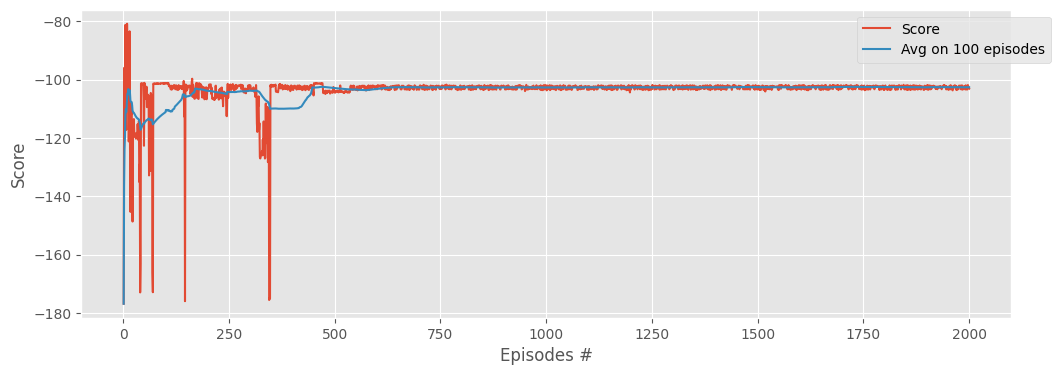

In [ ]:
%matplotlib inline

print('length of scores: ', len(scores), ', len of average scores: ', len(Avg_Scores))

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores) + 1), scores, label="Score")
plt.plot(np.arange(1, len(Avg_Scores) + 1), Avg_Scores, label="Avg on 100 episodes")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.ylabel('Score')
plt.xlabel('Episodes #')
plt.show()

In [ ]:
env.close